In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from torchvision import datasets, transforms
from PIL import Image
import gc
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MLP, self).__init__()

        layers = [nn.Linear(input_size, hidden_layers[0]), nn.BatchNorm1d(hidden_layers[0]), nn.ReLU()]
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            layers.append(nn.BatchNorm1d(hidden_layers[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
class CustomCNN(nn.Module):
    def __init__(self, input_size, conv_layers, fc_layers, num_classes):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.convs = nn.Sequential()
        in_channels = 3 # RGB
        for i, (out_channels, kernel_size, stride, padding) in enumerate(conv_layers):
            self.convs.add_module(f'conv{i}', nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
            self.convs.add_module(f'batchnorm{i}', nn.BatchNorm2d(out_channels))
            self.convs.add_module(f'relu{i}', nn.ReLU(inplace=True))
            self.convs.add_module(f'pool{i}', nn.MaxPool2d(kernel_size=3, stride=2))
            in_channels = out_channels

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fcs = nn.Sequential()
        fc_input_features = self._get_conv_output_size(conv_layers, input_size=input_size)
        for i, fc_output_features in enumerate(fc_layers):
            self.fcs.add_module(f'fc{i}', nn.Linear(fc_input_features, fc_output_features))
            self.fcs.add_module(f'relu_fc{i}', nn.ReLU(inplace=True))
            fc_input_features = fc_output_features

        # Final layer
        self.final_fc = nn.Linear(fc_input_features, num_classes)

    def _get_conv_output_size(self, conv_layers, input_size=32, pool_kernel_size=3, pool_stride=2):
        output_size = input_size
        for _, (out_channels, kernel_size, stride, padding) in enumerate(conv_layers):
            output_size = (output_size - kernel_size + 2 * padding) // stride + 1

            # Apply pooling reduction
            output_size = (output_size - pool_kernel_size) // pool_stride + 1

        return output_size * output_size * out_channels

    def forward(self, x):
        x = self.convs(x)
        x = self.flatten(x)
        x = self.fcs(x)
        x = self.final_fc(x)
        return x


class TestDataset(Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        self.images = os.listdir(data_path)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.data_path, image_name)
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image, image_name

    def __len__(self):
        return len(self.images)
    
class WrapperDataset(Dataset):
    def __init__(self, dataset, indices, transforms=None):
        self.dataset = dataset
        self.indices = indices
        self.transforms = transforms
    
    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        if self.transforms:
            x = self.transforms(x)
        return x, y

    def __len__(self):
        return len(self.indices)
    
def prepare_data_loaders(data_path, image_size = 128, batch_size = 32, val_size = 0.15):
    train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    full_dataset = datasets.ImageFolder(data_path)

    train_size = int((1 - val_size) * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    train_dataset = WrapperDataset(full_dataset, train_subset.indices, train_transforms)
    val_dataset = WrapperDataset(full_dataset, val_subset.indices, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader

def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    return accuracy, precision, recall, f1

def evaluate_model(model, model_name, criterion, val_loader, device):
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    val_bar = tqdm(val_loader, desc=f'Evaluation [VALID|{model_name}]', total=len(val_loader))

    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            if 'mlp' in model_name:
                images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    avg_loss = val_loss / len(val_loader)
    accuracy, precision, recall, f1 = get_metrics(all_labels, all_preds)
    return avg_loss, accuracy, precision, recall, f1

def train_loop(model, model_name, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs, patience=20):
    os.makedirs(model_name, exist_ok=True)
    scaler = GradScaler()

    best_f1 = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_labels = []
        all_preds = []
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [TRAIN|{model_name}]', total=len(train_loader))

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            if 'mlp' in model_name:
                images = images.view(images.size(0), -1)
            optimizer.zero_grad()

            # Use autocast for the forward pass
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale the loss and call backward
            scaler.step(optimizer)  # Optimizer step with scaler
            scaler.update()  # Update the scaler
            train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            train_accuracy = accuracy_score(all_labels, all_preds) * 100
            train_bar.set_postfix(loss=loss.item(), accuracy=f'{train_accuracy:.2f}%')

        train_avg_loss = train_loss / len(train_loader)
        train_accuracy, train_precision, train_recall, train_f1 = get_metrics(all_labels, all_preds)
        train_losses.append(train_avg_loss)
        train_accs.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')

        # if using cuda clear cache
        if device.type == 'cuda':
            torch.cuda.empty_cache()
            gc.collect()
        
        # Evaluate after each epoch
        val_avg_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, model_name, criterion, val_loader, device)
        val_losses.append(val_avg_loss)
        val_accs.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}')
        
        # check for best model and patience
        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            print(f'Saving best model at epoch {epoch+1}...')
            torch.save(model.state_dict(), f'{model_name}/{model_name}_best_model.pt')
        else:
            patience_counter += 1
            print(f'Patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print('Early stopping...')
                break
        
        scheduler.step()
        
    # save last model
    print('Saving Last Model')
    torch.save(model.state_dict(), f'{model_name}/{model_name}_last_model.pt')

    # After the training loop, create a DataFrame from the collected metrics
    epochs = range(1, len(train_losses) + 1)

    metrics = {
        'Epoch': list(epochs),
        'Train Loss': train_losses,
        'Train Accuracy': train_accs,
        'Train Precision': train_precisions,
        'Train Recall': train_recalls,
        'Train F1': train_f1s,
        'Val Loss': val_losses,
        'Val Accuracy': val_accs,
        'Val Precision': val_precisions,
        'Val Recall': val_recalls,
        'Val F1': val_f1s
    }

    df = pd.DataFrame(metrics)

    # Save the DataFrame to a CSV file
    csv_file = f'{model_name}/{model_name}_training_metrics.csv'
    df.to_csv(csv_file, index=False)

    print(f'Metrics saved to {csv_file}')
    
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_precisions, label='Train Precision')
    plt.plot(epochs, val_precisions, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision vs Epochs')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(epochs, train_recalls, label='Train Recall')
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall vs Epochs')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(epochs, train_f1s, label='Train F1 Score')
    plt.plot(epochs, val_f1s, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}/{model_name}_training_results.png')
    plt.show()

def train(
        train_path,
        model,
        model_name,
        lr0,
        lrf,
        weight_decay,
        num_epochs,
        patience,
        batch_size,
        image_size,
        val_size,
        device
):  
    print('\n'*3)
    print(f'Starting training for {model_name}')
    print(f'Number of parameters: {count_parameters(model):,}')

    train_loader, val_loader = prepare_data_loaders(train_path, image_size, batch_size, val_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr0, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=num_epochs, T_mult=1, eta_min=lrf)

    train_loop(model, model_name, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs, patience)

    print(f'Training complete for {model_name}')
    

def test_submit(model, model_name, image_size, test_path, class2id, device):
    print('Creating submission file for', model_name)
    test_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    test_dataset = TestDataset(test_path, test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    model.eval()
    all_preds = []
    all_image_names = []
    test_bar = tqdm(test_loader, desc=f'Test [TEST|{model_name}]', total=len(test_loader))

    with torch.no_grad():
        for images, image_names in test_bar:
            images = images.to(device)
            if 'mlp' in model_name:
                images = images.view(images.size(0), -1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_image_names.extend(image_names)

    df = pd.DataFrame({'file': all_image_names, 'species': all_preds})
    id2class = {v: k for k, v in class2id.items()}
    df['species'] = df['species'].apply(lambda x: id2class[x])
    df.to_csv(f'{model_name}/{model_name}_test_results.csv', index=False)
    print(f'Test results saved to {model_name}/{model_name}_test_results.csv')

def create_mlp_model(config, image_size, num_classes=12):
    hidden_layers, _ = config
    return MLP(image_size*image_size*3, hidden_layers, num_classes)

def create_cnn_model(config, image_size, num_classes=12):
    conv_layers, fc_layers, _ = config
    return CustomCNN(image_size, conv_layers, fc_layers, num_classes)

def create_efficientnet_model(model_name, num_classes=12):
    model = torch.hub.load('pytorch/vision:v0.13.0', model_name, weights='IMAGENET1K_V1')
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

def create_resnet_model(model_name, num_classes=12):
    model = torch.hub.load('pytorch/vision:v0.13.0', model_name, weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def create_mobile_net_model(model_name, num_classes=12):
    model = torch.hub.load('pytorch/vision:v0.13.0', model_name, weights='IMAGENET1K_V1')
    in_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(in_features, num_classes)
    return model

def create_googlenet_model(model_name, num_classes=12):
    model = torch.hub.load('pytorch/vision:v0.13.0', model_name, weights='IMAGENET1K_V1')
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, num_classes)
    return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_train = '/kaggle/input/plant-seedlings-classification/train'
path_to_test = '/kaggle/input/plant-seedlings-classification/test'

In [4]:
classes = []
for subfolder in os.listdir(path_to_train):
    classes.append((subfolder, len(os.listdir(os.path.join(path_to_train, subfolder)))))

df_class = pd.DataFrame(classes, columns=['class', 'count'])
df_class['percentage'] = df_class['count'] * 100 / df_class['count'].sum()
df_class['percentage'] = df_class['percentage'].round(2)
df_class

class  count  percentage
0           Scentless Mayweed    516       10.86
1                Common wheat    221        4.65
2                    Charlock    390        8.21
3                 Black-grass    263        5.54
4                  Sugar beet    385        8.11
5            Loose Silky-bent    654       13.77
6                       Maize    221        4.65
7                    Cleavers    287        6.04
8            Common Chickweed    611       12.86
9                     Fat Hen    475       10.00
10  Small-flowered Cranesbill    496       10.44
11            Shepherds Purse    231        4.86

Classes are not balanced.

In [5]:
def plot_image_grid(folder_path, images_per_class = 4):
    # Create a figure
    fig = plt.figure(figsize=(images_per_class*2, images_per_class*8))

    # List subfolders
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    for i, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)

        # Get image files
        images = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]
        selected_images = images[:images_per_class]

        for j, image in enumerate(selected_images):
            # Read and plot each image
            img = imread(os.path.join(class_folder, image))
            ax = fig.add_subplot(num_classes, images_per_class, i * images_per_class + j + 1)
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name)

    plt.tight_layout()
    plt.show()

# plot_image_grid(path_to_train)

In [6]:
# Define the configurations for each model type
mlp_configurations = [
    ([512, 256], 'mlp_n'),
    ([1024, 512, 256], 'mlp_s'),
    ([2048, 1024, 512, 256], 'mlp_m'),
    ([4096, 2048, 1024, 512, 256], 'mlp_l'),
    ([8192, 4096, 2048, 1024, 512, 256], 'mlp_xl'),
]

cnn_configurations = [
    ([(16, 3, 1, 1), (32, 3, 1, 1)], [64], 'cnn_small'),
    ([(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], [128, 64], 'cnn_medium'),
    ([(64, 6, 1, 1), (128, 3, 1, 1), (256, 3, 1, 1), (512, 3, 1, 1)], [256, 128, 64], 'cnn_large'),
    ([(128, 6, 1, 1), (256, 6, 1, 1), (512, 3, 1, 1), (1024, 3, 1, 1), (2048, 3, 1, 1)], [512, 256, 128, 64], 'cnn_extra_large')
]

pretrained_models = [
    'efficientnet_b0',
    'efficientnet_b1',
    'efficientnet_b2',
    'efficientnet_b3',
    'efficientnet_b4',
    'resnet18',
    'resnet34',
    'resnet50',
    'resnet101',
    'mobilenet_v2',
    'googlenet',
]

# Train





Starting training for mlp_n
Number of parameters: 25,302,284


Epoch 1/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:30<00:00,  8.28it/s, accuracy=32.99%, loss=1.31]


Epoch [1/100], Train Loss: 2.0073, Train Accuracy: 0.3299, Train Precision: 0.3299, Train Recall: 0.3299, Train F1: 0.3299


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:05<00:00,  8.11it/s]


Epoch [1/100], Validation Loss: 1.8800, Validation Accuracy: 0.3675, Validation Precision: 0.3675, Validation Recall: 0.3675, Validation F1: 0.3675
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.43it/s, accuracy=46.15%, loss=1.28]


Epoch [2/100], Train Loss: 1.6069, Train Accuracy: 0.4615, Train Precision: 0.4615, Train Recall: 0.4615, Train F1: 0.4615


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s]


Epoch [2/100], Validation Loss: 1.6452, Validation Accuracy: 0.4250, Validation Precision: 0.4250, Validation Recall: 0.4250, Validation F1: 0.4250
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.28it/s, accuracy=52.09%, loss=1.83]


Epoch [3/100], Train Loss: 1.4427, Train Accuracy: 0.5209, Train Precision: 0.5209, Train Recall: 0.5209, Train F1: 0.5209


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.84it/s]


Epoch [3/100], Validation Loss: 1.4391, Validation Accuracy: 0.5147, Validation Precision: 0.5147, Validation Recall: 0.5147, Validation F1: 0.5147
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.10it/s, accuracy=53.73%, loss=1.71]


Epoch [4/100], Train Loss: 1.3705, Train Accuracy: 0.5373, Train Precision: 0.5373, Train Recall: 0.5373, Train F1: 0.5373


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [4/100], Validation Loss: 1.3792, Validation Accuracy: 0.5259, Validation Precision: 0.5259, Validation Recall: 0.5259, Validation F1: 0.5259
Saving best model at epoch 4...


Epoch 5/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:21<00:00, 11.94it/s, accuracy=56.01%, loss=1.45]


Epoch [5/100], Train Loss: 1.3069, Train Accuracy: 0.5601, Train Precision: 0.5601, Train Recall: 0.5601, Train F1: 0.5601


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.23it/s]


Epoch [5/100], Validation Loss: 1.4826, Validation Accuracy: 0.5007, Validation Precision: 0.5007, Validation Recall: 0.5007, Validation F1: 0.5007
Patience: 1/10


Epoch 6/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.21it/s, accuracy=58.38%, loss=0.854]


Epoch [6/100], Train Loss: 1.2390, Train Accuracy: 0.5838, Train Precision: 0.5838, Train Recall: 0.5838, Train F1: 0.5838


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.93it/s]


Epoch [6/100], Validation Loss: 1.3730, Validation Accuracy: 0.5386, Validation Precision: 0.5386, Validation Recall: 0.5386, Validation F1: 0.5386
Saving best model at epoch 6...


Epoch 7/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.47it/s, accuracy=60.02%, loss=1.67]


Epoch [7/100], Train Loss: 1.1969, Train Accuracy: 0.6002, Train Precision: 0.6002, Train Recall: 0.6002, Train F1: 0.6002


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:04<00:00, 10.98it/s]


Epoch [7/100], Validation Loss: 1.3298, Validation Accuracy: 0.5442, Validation Precision: 0.5442, Validation Recall: 0.5442, Validation F1: 0.5442
Saving best model at epoch 7...


Epoch 8/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:19<00:00, 12.80it/s, accuracy=61.33%, loss=2.09]


Epoch [8/100], Train Loss: 1.1516, Train Accuracy: 0.6133, Train Precision: 0.6133, Train Recall: 0.6133, Train F1: 0.6133


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.84it/s]


Epoch [8/100], Validation Loss: 1.2248, Validation Accuracy: 0.5933, Validation Precision: 0.5933, Validation Recall: 0.5933, Validation F1: 0.5933
Saving best model at epoch 8...


Epoch 9/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.18it/s, accuracy=63.19%, loss=2.54]


Epoch [9/100], Train Loss: 1.1036, Train Accuracy: 0.6319, Train Precision: 0.6319, Train Recall: 0.6319, Train F1: 0.6319


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.25it/s]


Epoch [9/100], Validation Loss: 1.3408, Validation Accuracy: 0.5386, Validation Precision: 0.5386, Validation Recall: 0.5386, Validation F1: 0.5386
Patience: 1/10


Epoch 10/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.34it/s, accuracy=63.69%, loss=1.2]


Epoch [10/100], Train Loss: 1.0934, Train Accuracy: 0.6369, Train Precision: 0.6369, Train Recall: 0.6369, Train F1: 0.6369


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.18it/s]


Epoch [10/100], Validation Loss: 1.2752, Validation Accuracy: 0.5835, Validation Precision: 0.5835, Validation Recall: 0.5835, Validation F1: 0.5835
Patience: 2/10


Epoch 11/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.27it/s, accuracy=65.74%, loss=1.45]


Epoch [11/100], Train Loss: 1.0421, Train Accuracy: 0.6574, Train Precision: 0.6574, Train Recall: 0.6574, Train F1: 0.6574


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.92it/s]


Epoch [11/100], Validation Loss: 1.2036, Validation Accuracy: 0.5933, Validation Precision: 0.5933, Validation Recall: 0.5933, Validation F1: 0.5933
Patience: 3/10


Epoch 12/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.32it/s, accuracy=66.21%, loss=1.22]


Epoch [12/100], Train Loss: 1.0055, Train Accuracy: 0.6621, Train Precision: 0.6621, Train Recall: 0.6621, Train F1: 0.6621


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.01it/s]


Epoch [12/100], Validation Loss: 1.2347, Validation Accuracy: 0.6101, Validation Precision: 0.6101, Validation Recall: 0.6101, Validation F1: 0.6101
Saving best model at epoch 12...


Epoch 13/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.42it/s, accuracy=66.41%, loss=0.517]


Epoch [13/100], Train Loss: 1.0022, Train Accuracy: 0.6641, Train Precision: 0.6641, Train Recall: 0.6641, Train F1: 0.6641


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.43it/s]


Epoch [13/100], Validation Loss: 1.1259, Validation Accuracy: 0.6339, Validation Precision: 0.6339, Validation Recall: 0.6339, Validation F1: 0.6339
Saving best model at epoch 13...


Epoch 14/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.23it/s, accuracy=68.32%, loss=1.18]


Epoch [14/100], Train Loss: 0.9590, Train Accuracy: 0.6832, Train Precision: 0.6832, Train Recall: 0.6832, Train F1: 0.6832


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.45it/s]


Epoch [14/100], Validation Loss: 1.1268, Validation Accuracy: 0.6339, Validation Precision: 0.6339, Validation Recall: 0.6339, Validation F1: 0.6339
Patience: 1/10


Epoch 15/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.35it/s, accuracy=69.28%, loss=1.1]


Epoch [15/100], Train Loss: 0.9289, Train Accuracy: 0.6928, Train Precision: 0.6928, Train Recall: 0.6928, Train F1: 0.6928


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.50it/s]


Epoch [15/100], Validation Loss: 1.2670, Validation Accuracy: 0.5792, Validation Precision: 0.5792, Validation Recall: 0.5792, Validation F1: 0.5792
Patience: 2/10


Epoch 16/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.29it/s, accuracy=70.05%, loss=1.8]


Epoch [16/100], Train Loss: 0.9096, Train Accuracy: 0.7005, Train Precision: 0.7005, Train Recall: 0.7005, Train F1: 0.7005


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:04<00:00, 11.15it/s]


Epoch [16/100], Validation Loss: 1.1729, Validation Accuracy: 0.5933, Validation Precision: 0.5933, Validation Recall: 0.5933, Validation F1: 0.5933
Patience: 3/10


Epoch 17/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.40it/s, accuracy=69.73%, loss=1.29]


Epoch [17/100], Train Loss: 0.9014, Train Accuracy: 0.6973, Train Precision: 0.6973, Train Recall: 0.6973, Train F1: 0.6973


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.02it/s]


Epoch [17/100], Validation Loss: 1.1629, Validation Accuracy: 0.5891, Validation Precision: 0.5891, Validation Recall: 0.5891, Validation F1: 0.5891
Patience: 4/10


Epoch 18/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.40it/s, accuracy=72.16%, loss=2.37]


Epoch [18/100], Train Loss: 0.8682, Train Accuracy: 0.7216, Train Precision: 0.7216, Train Recall: 0.7216, Train F1: 0.7216


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.68it/s]


Epoch [18/100], Validation Loss: 1.1356, Validation Accuracy: 0.6003, Validation Precision: 0.6003, Validation Recall: 0.6003, Validation F1: 0.6003
Patience: 5/10


Epoch 19/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.10it/s, accuracy=71.44%, loss=0.514]


Epoch [19/100], Train Loss: 0.8563, Train Accuracy: 0.7144, Train Precision: 0.7144, Train Recall: 0.7144, Train F1: 0.7144


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.12it/s]


Epoch [19/100], Validation Loss: 1.1469, Validation Accuracy: 0.6031, Validation Precision: 0.6031, Validation Recall: 0.6031, Validation F1: 0.6031
Patience: 6/10


Epoch 20/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.64it/s, accuracy=72.75%, loss=0.641]


Epoch [20/100], Train Loss: 0.8244, Train Accuracy: 0.7275, Train Precision: 0.7275, Train Recall: 0.7275, Train F1: 0.7275


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.50it/s]


Epoch [20/100], Validation Loss: 1.1116, Validation Accuracy: 0.6339, Validation Precision: 0.6339, Validation Recall: 0.6339, Validation F1: 0.6339
Patience: 7/10


Epoch 21/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.36it/s, accuracy=72.90%, loss=1.22]


Epoch [21/100], Train Loss: 0.8136, Train Accuracy: 0.7290, Train Precision: 0.7290, Train Recall: 0.7290, Train F1: 0.7290


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [21/100], Validation Loss: 1.0914, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Saving best model at epoch 21...


Epoch 22/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.22it/s, accuracy=74.06%, loss=1.57]


Epoch [22/100], Train Loss: 0.7791, Train Accuracy: 0.7406, Train Precision: 0.7406, Train Recall: 0.7406, Train F1: 0.7406


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.99it/s]


Epoch [22/100], Validation Loss: 1.1064, Validation Accuracy: 0.6410, Validation Precision: 0.6410, Validation Recall: 0.6410, Validation F1: 0.6410
Patience: 1/10


Epoch 23/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.21it/s, accuracy=74.06%, loss=1.13]


Epoch [23/100], Train Loss: 0.7742, Train Accuracy: 0.7406, Train Precision: 0.7406, Train Recall: 0.7406, Train F1: 0.7406


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.34it/s]


Epoch [23/100], Validation Loss: 1.1717, Validation Accuracy: 0.6087, Validation Precision: 0.6087, Validation Recall: 0.6087, Validation F1: 0.6087
Patience: 2/10


Epoch 24/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.42it/s, accuracy=74.34%, loss=2.1]


Epoch [24/100], Train Loss: 0.7548, Train Accuracy: 0.7434, Train Precision: 0.7434, Train Recall: 0.7434, Train F1: 0.7434


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.49it/s]


Epoch [24/100], Validation Loss: 1.1112, Validation Accuracy: 0.6353, Validation Precision: 0.6353, Validation Recall: 0.6353, Validation F1: 0.6353
Patience: 3/10


Epoch 25/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.26it/s, accuracy=75.97%, loss=1.42]


Epoch [25/100], Train Loss: 0.7355, Train Accuracy: 0.7597, Train Precision: 0.7597, Train Recall: 0.7597, Train F1: 0.7597


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.43it/s]


Epoch [25/100], Validation Loss: 1.0778, Validation Accuracy: 0.6522, Validation Precision: 0.6522, Validation Recall: 0.6522, Validation F1: 0.6522
Saving best model at epoch 25...


Epoch 26/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.21it/s, accuracy=76.24%, loss=0.587]


Epoch [26/100], Train Loss: 0.7295, Train Accuracy: 0.7624, Train Precision: 0.7624, Train Recall: 0.7624, Train F1: 0.7624


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.32it/s]


Epoch [26/100], Validation Loss: 1.1491, Validation Accuracy: 0.6087, Validation Precision: 0.6087, Validation Recall: 0.6087, Validation F1: 0.6087
Patience: 1/10


Epoch 27/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:21<00:00, 12.02it/s, accuracy=76.79%, loss=0.724]


Epoch [27/100], Train Loss: 0.6992, Train Accuracy: 0.7679, Train Precision: 0.7679, Train Recall: 0.7679, Train F1: 0.7679


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.99it/s]


Epoch [27/100], Validation Loss: 1.1107, Validation Accuracy: 0.6213, Validation Precision: 0.6213, Validation Recall: 0.6213, Validation F1: 0.6213
Patience: 2/10


Epoch 28/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.24it/s, accuracy=78.90%, loss=1.28]


Epoch [28/100], Train Loss: 0.6518, Train Accuracy: 0.7890, Train Precision: 0.7890, Train Recall: 0.7890, Train F1: 0.7890


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.25it/s]


Epoch [28/100], Validation Loss: 1.1339, Validation Accuracy: 0.6311, Validation Precision: 0.6311, Validation Recall: 0.6311, Validation F1: 0.6311
Patience: 3/10


Epoch 29/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.13it/s, accuracy=78.70%, loss=0.876]


Epoch [29/100], Train Loss: 0.6636, Train Accuracy: 0.7870, Train Precision: 0.7870, Train Recall: 0.7870, Train F1: 0.7870


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.28it/s]


Epoch [29/100], Validation Loss: 1.1904, Validation Accuracy: 0.5961, Validation Precision: 0.5961, Validation Recall: 0.5961, Validation F1: 0.5961
Patience: 4/10


Epoch 30/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.32it/s, accuracy=78.10%, loss=2.37]


Epoch [30/100], Train Loss: 0.6596, Train Accuracy: 0.7810, Train Precision: 0.7810, Train Recall: 0.7810, Train F1: 0.7810


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [30/100], Validation Loss: 1.0882, Validation Accuracy: 0.6480, Validation Precision: 0.6480, Validation Recall: 0.6480, Validation F1: 0.6480
Patience: 5/10


Epoch 31/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.46it/s, accuracy=79.56%, loss=1.12]


Epoch [31/100], Train Loss: 0.6192, Train Accuracy: 0.7956, Train Precision: 0.7956, Train Recall: 0.7956, Train F1: 0.7956


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.41it/s]


Epoch [31/100], Validation Loss: 1.1633, Validation Accuracy: 0.6283, Validation Precision: 0.6283, Validation Recall: 0.6283, Validation F1: 0.6283
Patience: 6/10


Epoch 32/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.26it/s, accuracy=79.27%, loss=1.86]


Epoch [32/100], Train Loss: 0.6192, Train Accuracy: 0.7927, Train Precision: 0.7927, Train Recall: 0.7927, Train F1: 0.7927


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.53it/s]


Epoch [32/100], Validation Loss: 1.1372, Validation Accuracy: 0.6269, Validation Precision: 0.6269, Validation Recall: 0.6269, Validation F1: 0.6269
Patience: 7/10


Epoch 33/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.14it/s, accuracy=80.33%, loss=0.822]


Epoch [33/100], Train Loss: 0.6052, Train Accuracy: 0.8033, Train Precision: 0.8033, Train Recall: 0.8033, Train F1: 0.8033


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.28it/s]


Epoch [33/100], Validation Loss: 1.1064, Validation Accuracy: 0.6564, Validation Precision: 0.6564, Validation Recall: 0.6564, Validation F1: 0.6564
Saving best model at epoch 33...


Epoch 34/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.58it/s, accuracy=81.72%, loss=0.764]


Epoch [34/100], Train Loss: 0.5893, Train Accuracy: 0.8172, Train Precision: 0.8172, Train Recall: 0.8172, Train F1: 0.8172


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.54it/s]


Epoch [34/100], Validation Loss: 1.0628, Validation Accuracy: 0.6844, Validation Precision: 0.6844, Validation Recall: 0.6844, Validation F1: 0.6844
Saving best model at epoch 34...


Epoch 35/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.36it/s, accuracy=81.64%, loss=1.34]


Epoch [35/100], Train Loss: 0.5801, Train Accuracy: 0.8164, Train Precision: 0.8164, Train Recall: 0.8164, Train F1: 0.8164


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.45it/s]


Epoch [35/100], Validation Loss: 1.0848, Validation Accuracy: 0.6480, Validation Precision: 0.6480, Validation Recall: 0.6480, Validation F1: 0.6480
Patience: 1/10


Epoch 36/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.09it/s, accuracy=81.03%, loss=0.374]


Epoch [36/100], Train Loss: 0.5646, Train Accuracy: 0.8103, Train Precision: 0.8103, Train Recall: 0.8103, Train F1: 0.8103


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


Epoch [36/100], Validation Loss: 1.0482, Validation Accuracy: 0.6564, Validation Precision: 0.6564, Validation Recall: 0.6564, Validation F1: 0.6564
Patience: 2/10


Epoch 37/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:19<00:00, 12.68it/s, accuracy=82.34%, loss=1.22]


Epoch [37/100], Train Loss: 0.5453, Train Accuracy: 0.8234, Train Precision: 0.8234, Train Recall: 0.8234, Train F1: 0.8234


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.13it/s]


Epoch [37/100], Validation Loss: 1.1332, Validation Accuracy: 0.6129, Validation Precision: 0.6129, Validation Recall: 0.6129, Validation F1: 0.6129
Patience: 3/10


Epoch 38/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:19<00:00, 12.68it/s, accuracy=83.21%, loss=1.06]


Epoch [38/100], Train Loss: 0.5317, Train Accuracy: 0.8321, Train Precision: 0.8321, Train Recall: 0.8321, Train F1: 0.8321


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.70it/s]


Epoch [38/100], Validation Loss: 1.1350, Validation Accuracy: 0.6367, Validation Precision: 0.6367, Validation Recall: 0.6367, Validation F1: 0.6367
Patience: 4/10


Epoch 39/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.50it/s, accuracy=84.34%, loss=2.68]


Epoch [39/100], Train Loss: 0.4994, Train Accuracy: 0.8434, Train Precision: 0.8434, Train Recall: 0.8434, Train F1: 0.8434


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.34it/s]


Epoch [39/100], Validation Loss: 1.0142, Validation Accuracy: 0.6732, Validation Precision: 0.6732, Validation Recall: 0.6732, Validation F1: 0.6732
Patience: 5/10


Epoch 40/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.34it/s, accuracy=84.64%, loss=1.7]


Epoch [40/100], Train Loss: 0.4960, Train Accuracy: 0.8464, Train Precision: 0.8464, Train Recall: 0.8464, Train F1: 0.8464


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.41it/s]


Epoch [40/100], Validation Loss: 1.0333, Validation Accuracy: 0.6564, Validation Precision: 0.6564, Validation Recall: 0.6564, Validation F1: 0.6564
Patience: 6/10


Epoch 41/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.54it/s, accuracy=84.94%, loss=1.27]


Epoch [41/100], Train Loss: 0.4745, Train Accuracy: 0.8494, Train Precision: 0.8494, Train Recall: 0.8494, Train F1: 0.8494


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.38it/s]


Epoch [41/100], Validation Loss: 1.0951, Validation Accuracy: 0.6508, Validation Precision: 0.6508, Validation Recall: 0.6508, Validation F1: 0.6508
Patience: 7/10


Epoch 42/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.57it/s, accuracy=85.61%, loss=0.482]


Epoch [42/100], Train Loss: 0.4647, Train Accuracy: 0.8561, Train Precision: 0.8561, Train Recall: 0.8561, Train F1: 0.8561


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 11.34it/s]


Epoch [42/100], Validation Loss: 1.1808, Validation Accuracy: 0.6452, Validation Precision: 0.6452, Validation Recall: 0.6452, Validation F1: 0.6452
Patience: 8/10


Epoch 43/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.38it/s, accuracy=86.33%, loss=0.536]


Epoch [43/100], Train Loss: 0.4405, Train Accuracy: 0.8633, Train Precision: 0.8633, Train Recall: 0.8633, Train F1: 0.8633


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


Epoch [43/100], Validation Loss: 1.0994, Validation Accuracy: 0.6466, Validation Precision: 0.6466, Validation Recall: 0.6466, Validation F1: 0.6466
Patience: 9/10


Epoch 44/100 [TRAIN|mlp_n]: 100%|██████████| 253/253 [00:20<00:00, 12.18it/s, accuracy=85.46%, loss=0.996]


Epoch [44/100], Train Loss: 0.4544, Train Accuracy: 0.8546, Train Precision: 0.8546, Train Recall: 0.8546, Train F1: 0.8546


Evaluation [VALID|mlp_n]: 100%|██████████| 45/45 [00:03<00:00, 12.53it/s]


Epoch [44/100], Validation Loss: 1.0776, Validation Accuracy: 0.6816, Validation Precision: 0.6816, Validation Recall: 0.6816, Validation F1: 0.6816
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to mlp_n/mlp_n_training_metrics.csv


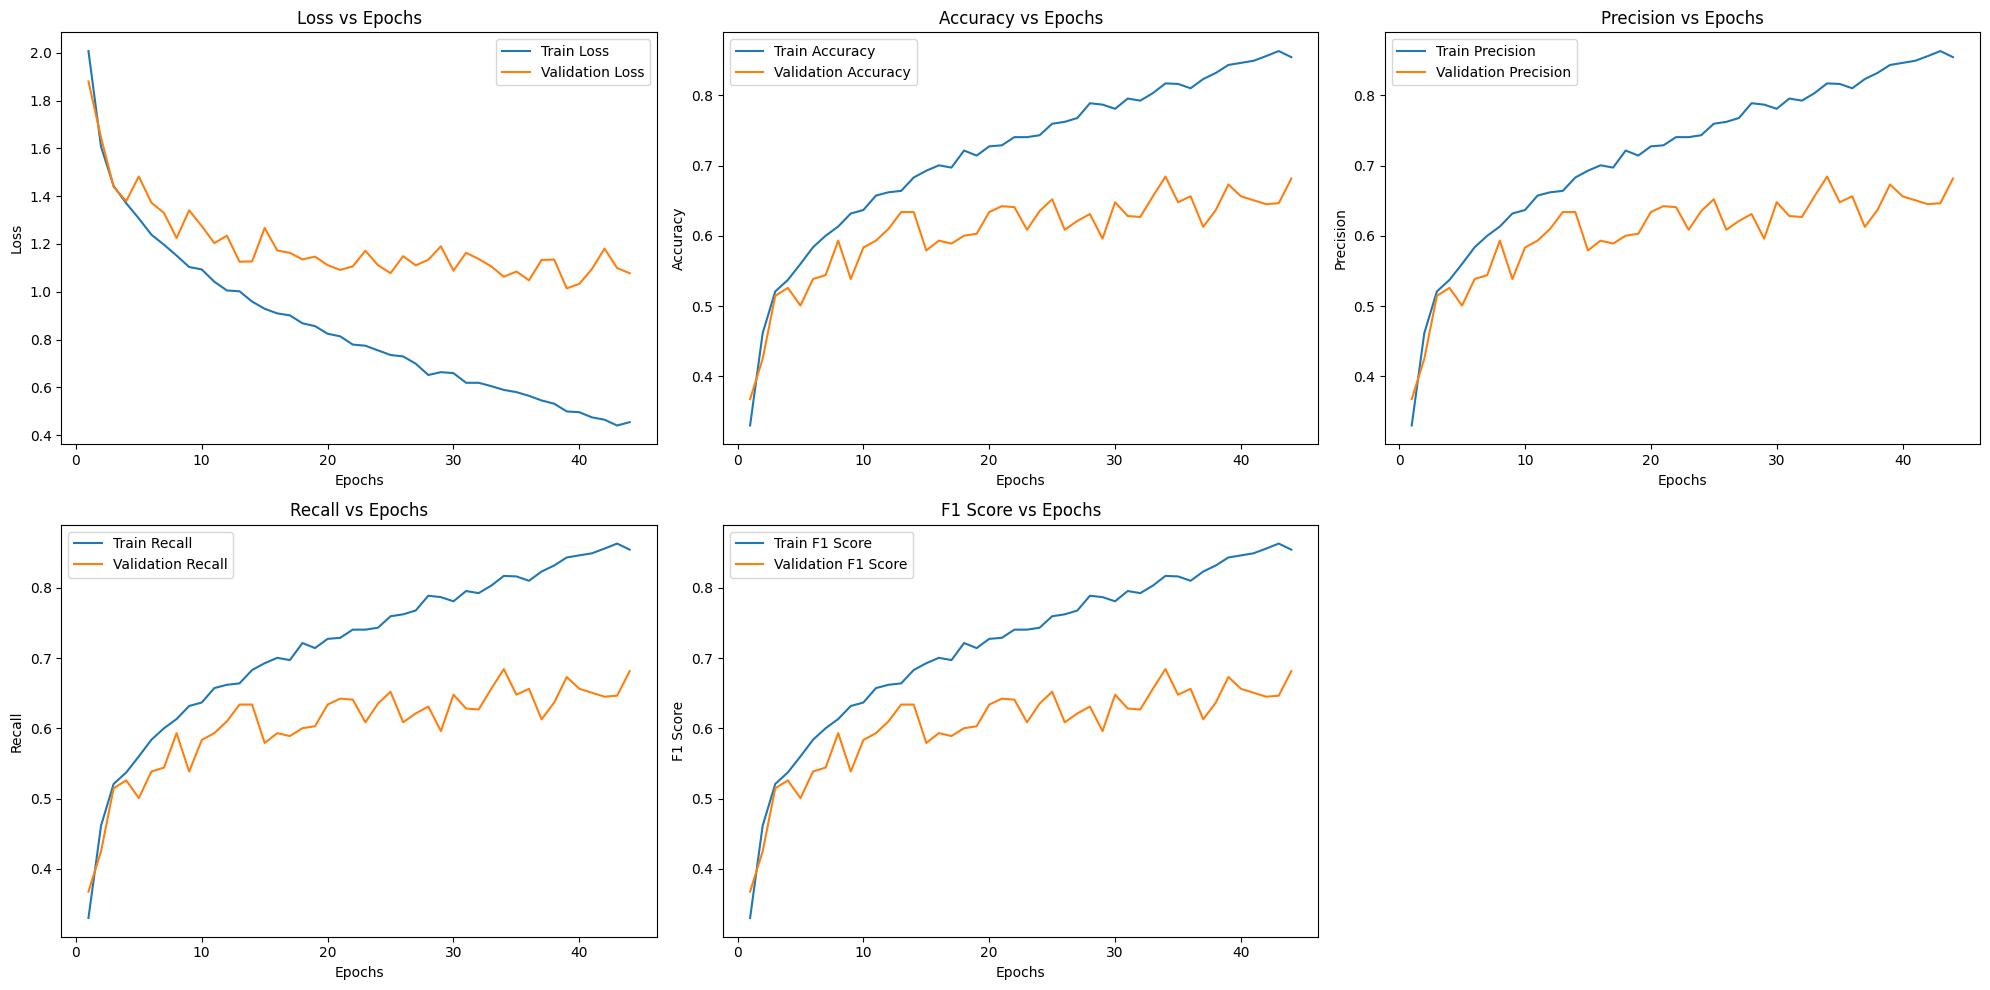

Training complete for mlp_n
Creating submission file for mlp_n


Test [TEST|mlp_n]: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


Test results saved to mlp_n/mlp_n_test_results.csv




Starting training for mlp_s
Number of parameters: 50,995,468


Epoch 1/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.96it/s, accuracy=30.69%, loss=1.99]


Epoch [1/100], Train Loss: 2.0504, Train Accuracy: 0.3069, Train Precision: 0.3069, Train Recall: 0.3069, Train F1: 0.3069


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.01it/s]


Epoch [1/100], Validation Loss: 1.7410, Validation Accuracy: 0.4404, Validation Precision: 0.4404, Validation Recall: 0.4404, Validation F1: 0.4404
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.06it/s, accuracy=45.75%, loss=1.92]


Epoch [2/100], Train Loss: 1.6211, Train Accuracy: 0.4575, Train Precision: 0.4575, Train Recall: 0.4575, Train F1: 0.4575


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.04it/s]


Epoch [2/100], Validation Loss: 1.5532, Validation Accuracy: 0.4825, Validation Precision: 0.4825, Validation Recall: 0.4825, Validation F1: 0.4825
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.84it/s, accuracy=50.88%, loss=1.77]


Epoch [3/100], Train Loss: 1.4596, Train Accuracy: 0.5088, Train Precision: 0.5088, Train Recall: 0.5088, Train F1: 0.5088


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [3/100], Validation Loss: 1.3844, Validation Accuracy: 0.5259, Validation Precision: 0.5259, Validation Recall: 0.5259, Validation F1: 0.5259
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.08it/s, accuracy=54.00%, loss=1.34]


Epoch [4/100], Train Loss: 1.3646, Train Accuracy: 0.5400, Train Precision: 0.5400, Train Recall: 0.5400, Train F1: 0.5400


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.60it/s]


Epoch [4/100], Validation Loss: 1.4606, Validation Accuracy: 0.4965, Validation Precision: 0.4965, Validation Recall: 0.4965, Validation F1: 0.4965
Patience: 1/10


Epoch 5/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.99it/s, accuracy=56.01%, loss=2.78]


Epoch [5/100], Train Loss: 1.2942, Train Accuracy: 0.5601, Train Precision: 0.5601, Train Recall: 0.5601, Train F1: 0.5601


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.96it/s]


Epoch [5/100], Validation Loss: 1.3117, Validation Accuracy: 0.5217, Validation Precision: 0.5217, Validation Recall: 0.5217, Validation F1: 0.5217
Patience: 2/10


Epoch 6/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.06it/s, accuracy=59.95%, loss=1.3]


Epoch [6/100], Train Loss: 1.1954, Train Accuracy: 0.5995, Train Precision: 0.5995, Train Recall: 0.5995, Train F1: 0.5995


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.26it/s]


Epoch [6/100], Validation Loss: 1.2982, Validation Accuracy: 0.5231, Validation Precision: 0.5231, Validation Recall: 0.5231, Validation F1: 0.5231
Patience: 3/10


Epoch 7/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.33it/s, accuracy=59.47%, loss=1.98]


Epoch [7/100], Train Loss: 1.1739, Train Accuracy: 0.5947, Train Precision: 0.5947, Train Recall: 0.5947, Train F1: 0.5947


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.31it/s]


Epoch [7/100], Validation Loss: 1.1914, Validation Accuracy: 0.6017, Validation Precision: 0.6017, Validation Recall: 0.6017, Validation F1: 0.6017
Saving best model at epoch 7...


Epoch 8/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.31it/s, accuracy=61.18%, loss=1.36]


Epoch [8/100], Train Loss: 1.1345, Train Accuracy: 0.6118, Train Precision: 0.6118, Train Recall: 0.6118, Train F1: 0.6118


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.29it/s]


Epoch [8/100], Validation Loss: 1.1926, Validation Accuracy: 0.5792, Validation Precision: 0.5792, Validation Recall: 0.5792, Validation F1: 0.5792
Patience: 1/10


Epoch 9/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.17it/s, accuracy=62.89%, loss=1.9]


Epoch [9/100], Train Loss: 1.0839, Train Accuracy: 0.6289, Train Precision: 0.6289, Train Recall: 0.6289, Train F1: 0.6289


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.14it/s]


Epoch [9/100], Validation Loss: 1.1542, Validation Accuracy: 0.6129, Validation Precision: 0.6129, Validation Recall: 0.6129, Validation F1: 0.6129
Saving best model at epoch 9...


Epoch 10/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.06it/s, accuracy=64.33%, loss=1.93]


Epoch [10/100], Train Loss: 1.0598, Train Accuracy: 0.6433, Train Precision: 0.6433, Train Recall: 0.6433, Train F1: 0.6433


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.13it/s]


Epoch [10/100], Validation Loss: 1.3468, Validation Accuracy: 0.5105, Validation Precision: 0.5105, Validation Recall: 0.5105, Validation F1: 0.5105
Patience: 1/10


Epoch 11/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.81it/s, accuracy=66.73%, loss=1.91]


Epoch [11/100], Train Loss: 1.0127, Train Accuracy: 0.6673, Train Precision: 0.6673, Train Recall: 0.6673, Train F1: 0.6673


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.33it/s]


Epoch [11/100], Validation Loss: 1.2822, Validation Accuracy: 0.5414, Validation Precision: 0.5414, Validation Recall: 0.5414, Validation F1: 0.5414
Patience: 2/10


Epoch 12/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.18it/s, accuracy=66.86%, loss=1.83]


Epoch [12/100], Train Loss: 0.9806, Train Accuracy: 0.6686, Train Precision: 0.6686, Train Recall: 0.6686, Train F1: 0.6686


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.32it/s]


Epoch [12/100], Validation Loss: 1.1122, Validation Accuracy: 0.6017, Validation Precision: 0.6017, Validation Recall: 0.6017, Validation F1: 0.6017
Patience: 3/10


Epoch 13/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.25it/s, accuracy=67.57%, loss=1.32]


Epoch [13/100], Train Loss: 0.9433, Train Accuracy: 0.6757, Train Precision: 0.6757, Train Recall: 0.6757, Train F1: 0.6757


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 11.07it/s]


Epoch [13/100], Validation Loss: 1.1873, Validation Accuracy: 0.5722, Validation Precision: 0.5722, Validation Recall: 0.5722, Validation F1: 0.5722
Patience: 4/10


Epoch 14/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.25it/s, accuracy=69.38%, loss=0.599]


Epoch [14/100], Train Loss: 0.9052, Train Accuracy: 0.6938, Train Precision: 0.6938, Train Recall: 0.6938, Train F1: 0.6938


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [14/100], Validation Loss: 1.1531, Validation Accuracy: 0.6045, Validation Precision: 0.6045, Validation Recall: 0.6045, Validation F1: 0.6045
Patience: 5/10


Epoch 15/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.39it/s, accuracy=70.08%, loss=0.694]


Epoch [15/100], Train Loss: 0.8845, Train Accuracy: 0.7008, Train Precision: 0.7008, Train Recall: 0.7008, Train F1: 0.7008


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.62it/s]


Epoch [15/100], Validation Loss: 1.1325, Validation Accuracy: 0.5891, Validation Precision: 0.5891, Validation Recall: 0.5891, Validation F1: 0.5891
Patience: 6/10


Epoch 16/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.11it/s, accuracy=70.99%, loss=0.948]


Epoch [16/100], Train Loss: 0.8631, Train Accuracy: 0.7099, Train Precision: 0.7099, Train Recall: 0.7099, Train F1: 0.7099


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.41it/s]


Epoch [16/100], Validation Loss: 1.0815, Validation Accuracy: 0.6213, Validation Precision: 0.6213, Validation Recall: 0.6213, Validation F1: 0.6213
Saving best model at epoch 16...


Epoch 17/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.97it/s, accuracy=71.36%, loss=1.16]


Epoch [17/100], Train Loss: 0.8333, Train Accuracy: 0.7136, Train Precision: 0.7136, Train Recall: 0.7136, Train F1: 0.7136


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.06it/s]


Epoch [17/100], Validation Loss: 1.0955, Validation Accuracy: 0.6311, Validation Precision: 0.6311, Validation Recall: 0.6311, Validation F1: 0.6311
Saving best model at epoch 17...


Epoch 18/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.25it/s, accuracy=72.93%, loss=1.08]


Epoch [18/100], Train Loss: 0.8088, Train Accuracy: 0.7293, Train Precision: 0.7293, Train Recall: 0.7293, Train F1: 0.7293


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [18/100], Validation Loss: 1.1468, Validation Accuracy: 0.6003, Validation Precision: 0.6003, Validation Recall: 0.6003, Validation F1: 0.6003
Patience: 1/10


Epoch 19/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.55it/s, accuracy=73.92%, loss=1.13]


Epoch [19/100], Train Loss: 0.7802, Train Accuracy: 0.7392, Train Precision: 0.7392, Train Recall: 0.7392, Train F1: 0.7392


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 10.86it/s]


Epoch [19/100], Validation Loss: 1.1421, Validation Accuracy: 0.6213, Validation Precision: 0.6213, Validation Recall: 0.6213, Validation F1: 0.6213
Patience: 2/10


Epoch 20/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.20it/s, accuracy=74.39%, loss=1]


Epoch [20/100], Train Loss: 0.7684, Train Accuracy: 0.7439, Train Precision: 0.7439, Train Recall: 0.7439, Train F1: 0.7439


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.99it/s]


Epoch [20/100], Validation Loss: 1.0831, Validation Accuracy: 0.6367, Validation Precision: 0.6367, Validation Recall: 0.6367, Validation F1: 0.6367
Saving best model at epoch 20...


Epoch 21/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.71it/s, accuracy=75.58%, loss=2.95]


Epoch [21/100], Train Loss: 0.7209, Train Accuracy: 0.7558, Train Precision: 0.7558, Train Recall: 0.7558, Train F1: 0.7558


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.93it/s]


Epoch [21/100], Validation Loss: 1.1005, Validation Accuracy: 0.6101, Validation Precision: 0.6101, Validation Recall: 0.6101, Validation F1: 0.6101
Patience: 1/10


Epoch 22/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 12.05it/s, accuracy=76.86%, loss=1.01]


Epoch [22/100], Train Loss: 0.6939, Train Accuracy: 0.7686, Train Precision: 0.7686, Train Recall: 0.7686, Train F1: 0.7686


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.28it/s]


Epoch [22/100], Validation Loss: 1.0165, Validation Accuracy: 0.6410, Validation Precision: 0.6410, Validation Recall: 0.6410, Validation F1: 0.6410
Saving best model at epoch 22...


Epoch 23/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.42it/s, accuracy=77.43%, loss=0.459]


Epoch [23/100], Train Loss: 0.6984, Train Accuracy: 0.7743, Train Precision: 0.7743, Train Recall: 0.7743, Train F1: 0.7743


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s]


Epoch [23/100], Validation Loss: 1.0486, Validation Accuracy: 0.6508, Validation Precision: 0.6508, Validation Recall: 0.6508, Validation F1: 0.6508
Saving best model at epoch 23...


Epoch 24/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.24it/s, accuracy=77.73%, loss=1.42]


Epoch [24/100], Train Loss: 0.6809, Train Accuracy: 0.7773, Train Precision: 0.7773, Train Recall: 0.7773, Train F1: 0.7773


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.14it/s]


Epoch [24/100], Validation Loss: 1.1704, Validation Accuracy: 0.5961, Validation Precision: 0.5961, Validation Recall: 0.5961, Validation F1: 0.5961
Patience: 1/10


Epoch 25/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.77it/s, accuracy=77.83%, loss=2.83]


Epoch [25/100], Train Loss: 0.6713, Train Accuracy: 0.7783, Train Precision: 0.7783, Train Recall: 0.7783, Train F1: 0.7783


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.10it/s]


Epoch [25/100], Validation Loss: 1.0329, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Patience: 2/10


Epoch 26/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.16it/s, accuracy=79.32%, loss=1.04]


Epoch [26/100], Train Loss: 0.6160, Train Accuracy: 0.7932, Train Precision: 0.7932, Train Recall: 0.7932, Train F1: 0.7932


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.40it/s]


Epoch [26/100], Validation Loss: 1.0368, Validation Accuracy: 0.6396, Validation Precision: 0.6396, Validation Recall: 0.6396, Validation F1: 0.6396
Patience: 3/10


Epoch 27/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.38it/s, accuracy=79.99%, loss=1.21]


Epoch [27/100], Train Loss: 0.6051, Train Accuracy: 0.7999, Train Precision: 0.7999, Train Recall: 0.7999, Train F1: 0.7999


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 10.30it/s]


Epoch [27/100], Validation Loss: 1.0617, Validation Accuracy: 0.6592, Validation Precision: 0.6592, Validation Recall: 0.6592, Validation F1: 0.6592
Saving best model at epoch 27...


Epoch 28/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.40it/s, accuracy=81.00%, loss=2.93]


Epoch [28/100], Train Loss: 0.5867, Train Accuracy: 0.8100, Train Precision: 0.8100, Train Recall: 0.8100, Train F1: 0.8100


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.39it/s]


Epoch [28/100], Validation Loss: 1.1029, Validation Accuracy: 0.6269, Validation Precision: 0.6269, Validation Recall: 0.6269, Validation F1: 0.6269
Patience: 1/10


Epoch 29/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.95it/s, accuracy=80.83%, loss=1.49]


Epoch [29/100], Train Loss: 0.5823, Train Accuracy: 0.8083, Train Precision: 0.8083, Train Recall: 0.8083, Train F1: 0.8083


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.15it/s]


Epoch [29/100], Validation Loss: 1.1033, Validation Accuracy: 0.6325, Validation Precision: 0.6325, Validation Recall: 0.6325, Validation F1: 0.6325
Patience: 2/10


Epoch 30/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.82it/s, accuracy=81.55%, loss=0.304]


Epoch [30/100], Train Loss: 0.5455, Train Accuracy: 0.8155, Train Precision: 0.8155, Train Recall: 0.8155, Train F1: 0.8155


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.31it/s]


Epoch [30/100], Validation Loss: 1.1394, Validation Accuracy: 0.6157, Validation Precision: 0.6157, Validation Recall: 0.6157, Validation F1: 0.6157
Patience: 3/10


Epoch 31/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 12.01it/s, accuracy=82.93%, loss=0.632]


Epoch [31/100], Train Loss: 0.5270, Train Accuracy: 0.8293, Train Precision: 0.8293, Train Recall: 0.8293, Train F1: 0.8293


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.60it/s]


Epoch [31/100], Validation Loss: 0.9832, Validation Accuracy: 0.6774, Validation Precision: 0.6774, Validation Recall: 0.6774, Validation F1: 0.6774
Saving best model at epoch 31...


Epoch 32/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:19<00:00, 12.77it/s, accuracy=82.66%, loss=0.664]


Epoch [32/100], Train Loss: 0.5135, Train Accuracy: 0.8266, Train Precision: 0.8266, Train Recall: 0.8266, Train F1: 0.8266


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.78it/s]


Epoch [32/100], Validation Loss: 1.0219, Validation Accuracy: 0.6620, Validation Precision: 0.6620, Validation Recall: 0.6620, Validation F1: 0.6620
Patience: 1/10


Epoch 33/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.14it/s, accuracy=82.69%, loss=0.39]


Epoch [33/100], Train Loss: 0.5191, Train Accuracy: 0.8269, Train Precision: 0.8269, Train Recall: 0.8269, Train F1: 0.8269


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.11it/s]


Epoch [33/100], Validation Loss: 1.0753, Validation Accuracy: 0.6480, Validation Precision: 0.6480, Validation Recall: 0.6480, Validation F1: 0.6480
Patience: 2/10


Epoch 34/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.69it/s, accuracy=84.67%, loss=0.652]


Epoch [34/100], Train Loss: 0.4806, Train Accuracy: 0.8467, Train Precision: 0.8467, Train Recall: 0.8467, Train F1: 0.8467


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.32it/s]


Epoch [34/100], Validation Loss: 1.0556, Validation Accuracy: 0.6592, Validation Precision: 0.6592, Validation Recall: 0.6592, Validation F1: 0.6592
Patience: 3/10


Epoch 35/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.16it/s, accuracy=84.27%, loss=1.94]


Epoch [35/100], Train Loss: 0.4790, Train Accuracy: 0.8427, Train Precision: 0.8427, Train Recall: 0.8427, Train F1: 0.8427


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 11.09it/s]


Epoch [35/100], Validation Loss: 1.2686, Validation Accuracy: 0.5933, Validation Precision: 0.5933, Validation Recall: 0.5933, Validation F1: 0.5933
Patience: 4/10


Epoch 36/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.09it/s, accuracy=85.53%, loss=2.38]


Epoch [36/100], Train Loss: 0.4496, Train Accuracy: 0.8553, Train Precision: 0.8553, Train Recall: 0.8553, Train F1: 0.8553


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


Epoch [36/100], Validation Loss: 1.0831, Validation Accuracy: 0.6592, Validation Precision: 0.6592, Validation Recall: 0.6592, Validation F1: 0.6592
Patience: 5/10


Epoch 37/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.13it/s, accuracy=86.20%, loss=1.14]


Epoch [37/100], Train Loss: 0.4363, Train Accuracy: 0.8620, Train Precision: 0.8620, Train Recall: 0.8620, Train F1: 0.8620


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.12it/s]


Epoch [37/100], Validation Loss: 1.0568, Validation Accuracy: 0.6704, Validation Precision: 0.6704, Validation Recall: 0.6704, Validation F1: 0.6704
Patience: 6/10


Epoch 38/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.69it/s, accuracy=86.08%, loss=1.54]


Epoch [38/100], Train Loss: 0.4395, Train Accuracy: 0.8608, Train Precision: 0.8608, Train Recall: 0.8608, Train F1: 0.8608


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [38/100], Validation Loss: 1.0002, Validation Accuracy: 0.6816, Validation Precision: 0.6816, Validation Recall: 0.6816, Validation F1: 0.6816
Saving best model at epoch 38...


Epoch 39/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.31it/s, accuracy=86.08%, loss=0.664]


Epoch [39/100], Train Loss: 0.4144, Train Accuracy: 0.8608, Train Precision: 0.8608, Train Recall: 0.8608, Train F1: 0.8608


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Epoch [39/100], Validation Loss: 1.0110, Validation Accuracy: 0.6732, Validation Precision: 0.6732, Validation Recall: 0.6732, Validation F1: 0.6732
Patience: 1/10


Epoch 40/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.28it/s, accuracy=86.40%, loss=1.16]


Epoch [40/100], Train Loss: 0.4140, Train Accuracy: 0.8640, Train Precision: 0.8640, Train Recall: 0.8640, Train F1: 0.8640


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.59it/s]


Epoch [40/100], Validation Loss: 1.0255, Validation Accuracy: 0.6648, Validation Precision: 0.6648, Validation Recall: 0.6648, Validation F1: 0.6648
Patience: 2/10


Epoch 41/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.21it/s, accuracy=87.59%, loss=2.14]


Epoch [41/100], Train Loss: 0.3837, Train Accuracy: 0.8759, Train Precision: 0.8759, Train Recall: 0.8759, Train F1: 0.8759


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 10.81it/s]


Epoch [41/100], Validation Loss: 0.9742, Validation Accuracy: 0.7013, Validation Precision: 0.7013, Validation Recall: 0.7013, Validation F1: 0.7013
Saving best model at epoch 41...


Epoch 42/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.31it/s, accuracy=87.84%, loss=0.763]


Epoch [42/100], Train Loss: 0.3881, Train Accuracy: 0.8784, Train Precision: 0.8784, Train Recall: 0.8784, Train F1: 0.8784


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.01it/s]


Epoch [42/100], Validation Loss: 1.0191, Validation Accuracy: 0.6690, Validation Precision: 0.6690, Validation Recall: 0.6690, Validation F1: 0.6690
Patience: 1/10


Epoch 43/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.15it/s, accuracy=88.06%, loss=1.55]


Epoch [43/100], Train Loss: 0.3668, Train Accuracy: 0.8806, Train Precision: 0.8806, Train Recall: 0.8806, Train F1: 0.8806


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:04<00:00, 10.56it/s]


Epoch [43/100], Validation Loss: 1.1096, Validation Accuracy: 0.6564, Validation Precision: 0.6564, Validation Recall: 0.6564, Validation F1: 0.6564
Patience: 2/10


Epoch 44/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.52it/s, accuracy=88.18%, loss=0.548]


Epoch [44/100], Train Loss: 0.3594, Train Accuracy: 0.8818, Train Precision: 0.8818, Train Recall: 0.8818, Train F1: 0.8818


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [44/100], Validation Loss: 1.1673, Validation Accuracy: 0.6494, Validation Precision: 0.6494, Validation Recall: 0.6494, Validation F1: 0.6494
Patience: 3/10


Epoch 45/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.97it/s, accuracy=89.45%, loss=1.83]


Epoch [45/100], Train Loss: 0.3419, Train Accuracy: 0.8945, Train Precision: 0.8945, Train Recall: 0.8945, Train F1: 0.8945


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.33it/s]


Epoch [45/100], Validation Loss: 1.0342, Validation Accuracy: 0.6634, Validation Precision: 0.6634, Validation Recall: 0.6634, Validation F1: 0.6634
Patience: 4/10


Epoch 46/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.93it/s, accuracy=89.52%, loss=0.799]


Epoch [46/100], Train Loss: 0.3356, Train Accuracy: 0.8952, Train Precision: 0.8952, Train Recall: 0.8952, Train F1: 0.8952


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.81it/s]


Epoch [46/100], Validation Loss: 1.0467, Validation Accuracy: 0.6690, Validation Precision: 0.6690, Validation Recall: 0.6690, Validation F1: 0.6690
Patience: 5/10


Epoch 47/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.30it/s, accuracy=88.78%, loss=0.56]


Epoch [47/100], Train Loss: 0.3219, Train Accuracy: 0.8878, Train Precision: 0.8878, Train Recall: 0.8878, Train F1: 0.8878


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.71it/s]


Epoch [47/100], Validation Loss: 1.0670, Validation Accuracy: 0.6928, Validation Precision: 0.6928, Validation Recall: 0.6928, Validation F1: 0.6928
Patience: 6/10


Epoch 48/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.99it/s, accuracy=90.24%, loss=1.04]


Epoch [48/100], Train Loss: 0.3084, Train Accuracy: 0.9024, Train Precision: 0.9024, Train Recall: 0.9024, Train F1: 0.9024


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [48/100], Validation Loss: 1.0380, Validation Accuracy: 0.6816, Validation Precision: 0.6816, Validation Recall: 0.6816, Validation F1: 0.6816
Patience: 7/10


Epoch 49/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.65it/s, accuracy=90.07%, loss=0.564]


Epoch [49/100], Train Loss: 0.3118, Train Accuracy: 0.9007, Train Precision: 0.9007, Train Recall: 0.9007, Train F1: 0.9007


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.94it/s]


Epoch [49/100], Validation Loss: 1.0892, Validation Accuracy: 0.6592, Validation Precision: 0.6592, Validation Recall: 0.6592, Validation F1: 0.6592
Patience: 8/10


Epoch 50/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:21<00:00, 11.89it/s, accuracy=90.12%, loss=0.691]


Epoch [50/100], Train Loss: 0.3056, Train Accuracy: 0.9012, Train Precision: 0.9012, Train Recall: 0.9012, Train F1: 0.9012


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 12.26it/s]


Epoch [50/100], Validation Loss: 1.0367, Validation Accuracy: 0.6802, Validation Precision: 0.6802, Validation Recall: 0.6802, Validation F1: 0.6802
Patience: 9/10


Epoch 51/100 [TRAIN|mlp_s]: 100%|██████████| 253/253 [00:20<00:00, 12.53it/s, accuracy=89.97%, loss=1.18]


Epoch [51/100], Train Loss: 0.3015, Train Accuracy: 0.8997, Train Precision: 0.8997, Train Recall: 0.8997, Train F1: 0.8997


Evaluation [VALID|mlp_s]: 100%|██████████| 45/45 [00:03<00:00, 11.63it/s]


Epoch [51/100], Validation Loss: 1.0852, Validation Accuracy: 0.6760, Validation Precision: 0.6760, Validation Recall: 0.6760, Validation F1: 0.6760
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to mlp_s/mlp_s_training_metrics.csv


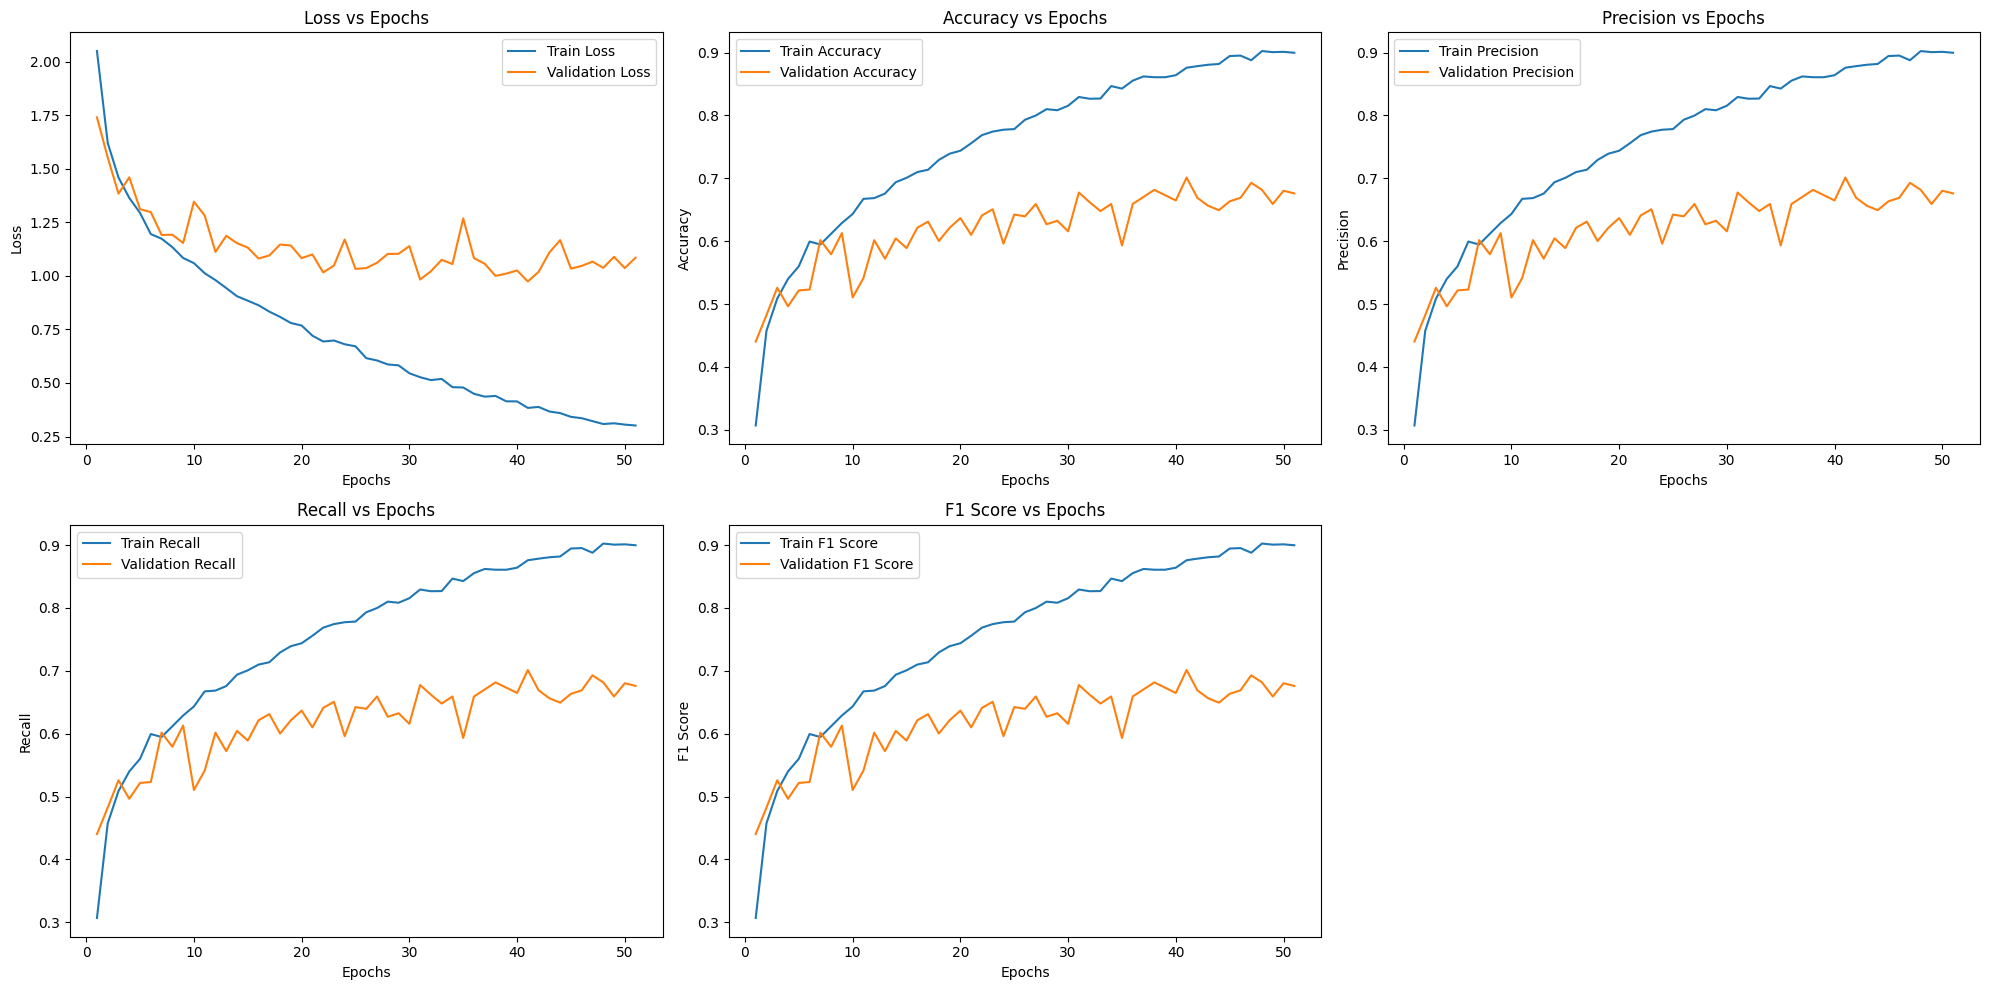

Training complete for mlp_s
Creating submission file for mlp_s


Test [TEST|mlp_s]: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]


Test results saved to mlp_s/mlp_s_test_results.csv




Starting training for mlp_m
Number of parameters: 103,430,412


Epoch 1/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:20<00:00, 12.23it/s, accuracy=28.68%, loss=2.13]


Epoch [1/100], Train Loss: 2.0684, Train Accuracy: 0.2868, Train Precision: 0.2868, Train Recall: 0.2868, Train F1: 0.2868


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.26it/s]


Epoch [1/100], Validation Loss: 1.7033, Validation Accuracy: 0.4222, Validation Precision: 0.4222, Validation Recall: 0.4222, Validation F1: 0.4222
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.26it/s, accuracy=44.41%, loss=1.48]


Epoch [2/100], Train Loss: 1.6360, Train Accuracy: 0.4441, Train Precision: 0.4441, Train Recall: 0.4441, Train F1: 0.4441


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.26it/s]


Epoch [2/100], Validation Loss: 1.5844, Validation Accuracy: 0.4628, Validation Precision: 0.4628, Validation Recall: 0.4628, Validation F1: 0.4628
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.19it/s, accuracy=49.34%, loss=1.37]


Epoch [3/100], Train Loss: 1.4734, Train Accuracy: 0.4934, Train Precision: 0.4934, Train Recall: 0.4934, Train F1: 0.4934


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.24it/s]


Epoch [3/100], Validation Loss: 1.3569, Validation Accuracy: 0.5372, Validation Precision: 0.5372, Validation Recall: 0.5372, Validation F1: 0.5372
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:21<00:00, 11.67it/s, accuracy=52.34%, loss=1.51]


Epoch [4/100], Train Loss: 1.3650, Train Accuracy: 0.5234, Train Precision: 0.5234, Train Recall: 0.5234, Train F1: 0.5234


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 11.64it/s]


Epoch [4/100], Validation Loss: 1.3647, Validation Accuracy: 0.5330, Validation Precision: 0.5330, Validation Recall: 0.5330, Validation F1: 0.5330
Patience: 1/10


Epoch 5/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.89it/s, accuracy=54.94%, loss=1.91]


Epoch [5/100], Train Loss: 1.3020, Train Accuracy: 0.5494, Train Precision: 0.5494, Train Recall: 0.5494, Train F1: 0.5494


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.67it/s]


Epoch [5/100], Validation Loss: 1.2400, Validation Accuracy: 0.5764, Validation Precision: 0.5764, Validation Recall: 0.5764, Validation F1: 0.5764
Saving best model at epoch 5...


Epoch 6/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.60it/s, accuracy=57.44%, loss=2.14]


Epoch [6/100], Train Loss: 1.2418, Train Accuracy: 0.5744, Train Precision: 0.5744, Train Recall: 0.5744, Train F1: 0.5744


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.68it/s]


Epoch [6/100], Validation Loss: 1.2320, Validation Accuracy: 0.5750, Validation Precision: 0.5750, Validation Recall: 0.5750, Validation F1: 0.5750
Patience: 1/10


Epoch 7/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.42it/s, accuracy=59.28%, loss=1.03]


Epoch [7/100], Train Loss: 1.1941, Train Accuracy: 0.5928, Train Precision: 0.5928, Train Recall: 0.5928, Train F1: 0.5928


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.49it/s]


Epoch [7/100], Validation Loss: 1.2656, Validation Accuracy: 0.5568, Validation Precision: 0.5568, Validation Recall: 0.5568, Validation F1: 0.5568
Patience: 2/10


Epoch 8/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.04it/s, accuracy=61.73%, loss=2.08]


Epoch [8/100], Train Loss: 1.1190, Train Accuracy: 0.6173, Train Precision: 0.6173, Train Recall: 0.6173, Train F1: 0.6173


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.66it/s]


Epoch [8/100], Validation Loss: 1.1964, Validation Accuracy: 0.5652, Validation Precision: 0.5652, Validation Recall: 0.5652, Validation F1: 0.5652
Patience: 3/10


Epoch 9/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.31it/s, accuracy=63.04%, loss=1.57]


Epoch [9/100], Train Loss: 1.0965, Train Accuracy: 0.6304, Train Precision: 0.6304, Train Recall: 0.6304, Train F1: 0.6304


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 12.63it/s]


Epoch [9/100], Validation Loss: 1.2195, Validation Accuracy: 0.5708, Validation Precision: 0.5708, Validation Recall: 0.5708, Validation F1: 0.5708
Patience: 4/10


Epoch 10/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.18it/s, accuracy=63.51%, loss=1.73]


Epoch [10/100], Train Loss: 1.0615, Train Accuracy: 0.6351, Train Precision: 0.6351, Train Recall: 0.6351, Train F1: 0.6351


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.63it/s]


Epoch [10/100], Validation Loss: 1.1824, Validation Accuracy: 0.5849, Validation Precision: 0.5849, Validation Recall: 0.5849, Validation F1: 0.5849
Saving best model at epoch 10...


Epoch 11/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.99it/s, accuracy=64.87%, loss=1.44]


Epoch [11/100], Train Loss: 1.0313, Train Accuracy: 0.6487, Train Precision: 0.6487, Train Recall: 0.6487, Train F1: 0.6487


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.84it/s]


Epoch [11/100], Validation Loss: 1.1779, Validation Accuracy: 0.5975, Validation Precision: 0.5975, Validation Recall: 0.5975, Validation F1: 0.5975
Saving best model at epoch 11...


Epoch 12/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s, accuracy=65.67%, loss=1.17]


Epoch [12/100], Train Loss: 0.9978, Train Accuracy: 0.6567, Train Precision: 0.6567, Train Recall: 0.6567, Train F1: 0.6567


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.98it/s]


Epoch [12/100], Validation Loss: 1.1336, Validation Accuracy: 0.6031, Validation Precision: 0.6031, Validation Recall: 0.6031, Validation F1: 0.6031
Saving best model at epoch 12...


Epoch 13/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:21<00:00, 11.87it/s, accuracy=67.03%, loss=0.784]


Epoch [13/100], Train Loss: 0.9601, Train Accuracy: 0.6703, Train Precision: 0.6703, Train Recall: 0.6703, Train F1: 0.6703


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:04<00:00,  9.79it/s]


Epoch [13/100], Validation Loss: 1.1181, Validation Accuracy: 0.6059, Validation Precision: 0.6059, Validation Recall: 0.6059, Validation F1: 0.6059
Saving best model at epoch 13...


Epoch 14/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:21<00:00, 11.87it/s, accuracy=67.85%, loss=0.847]


Epoch [14/100], Train Loss: 0.9336, Train Accuracy: 0.6785, Train Precision: 0.6785, Train Recall: 0.6785, Train F1: 0.6785


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.89it/s]


Epoch [14/100], Validation Loss: 1.5578, Validation Accuracy: 0.4825, Validation Precision: 0.4825, Validation Recall: 0.4825, Validation F1: 0.4825
Patience: 1/10


Epoch 15/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.85it/s, accuracy=68.79%, loss=1.01]


Epoch [15/100], Train Loss: 0.9008, Train Accuracy: 0.6879, Train Precision: 0.6879, Train Recall: 0.6879, Train F1: 0.6879


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.82it/s]


Epoch [15/100], Validation Loss: 1.0851, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Saving best model at epoch 15...


Epoch 16/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.88it/s, accuracy=70.00%, loss=2.79]


Epoch [16/100], Train Loss: 0.8822, Train Accuracy: 0.7000, Train Precision: 0.7000, Train Recall: 0.7000, Train F1: 0.7000


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.71it/s]


Epoch [16/100], Validation Loss: 1.1735, Validation Accuracy: 0.6045, Validation Precision: 0.6045, Validation Recall: 0.6045, Validation F1: 0.6045
Patience: 1/10


Epoch 17/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.23it/s, accuracy=72.18%, loss=1.04]


Epoch [17/100], Train Loss: 0.8158, Train Accuracy: 0.7218, Train Precision: 0.7218, Train Recall: 0.7218, Train F1: 0.7218


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 11.64it/s]


Epoch [17/100], Validation Loss: 1.0750, Validation Accuracy: 0.6269, Validation Precision: 0.6269, Validation Recall: 0.6269, Validation F1: 0.6269
Patience: 2/10


Epoch 18/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.63it/s, accuracy=71.39%, loss=1.89]


Epoch [18/100], Train Loss: 0.8204, Train Accuracy: 0.7139, Train Precision: 0.7139, Train Recall: 0.7139, Train F1: 0.7139


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:04<00:00, 10.89it/s]


Epoch [18/100], Validation Loss: 1.0668, Validation Accuracy: 0.6157, Validation Precision: 0.6157, Validation Recall: 0.6157, Validation F1: 0.6157
Patience: 3/10


Epoch 19/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:28<00:00,  8.84it/s, accuracy=73.12%, loss=1.58]


Epoch [19/100], Train Loss: 0.8071, Train Accuracy: 0.7312, Train Precision: 0.7312, Train Recall: 0.7312, Train F1: 0.7312


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:04<00:00, 11.07it/s]


Epoch [19/100], Validation Loss: 1.0435, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Patience: 4/10


Epoch 20/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:25<00:00,  9.89it/s, accuracy=72.50%, loss=2.92]


Epoch [20/100], Train Loss: 0.8120, Train Accuracy: 0.7250, Train Precision: 0.7250, Train Recall: 0.7250, Train F1: 0.7250


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.99it/s]


Epoch [20/100], Validation Loss: 1.0397, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Patience: 5/10


Epoch 21/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.19it/s, accuracy=73.97%, loss=1.52]


Epoch [21/100], Train Loss: 0.7506, Train Accuracy: 0.7397, Train Precision: 0.7397, Train Recall: 0.7397, Train F1: 0.7397


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


Epoch [21/100], Validation Loss: 1.0732, Validation Accuracy: 0.6311, Validation Precision: 0.6311, Validation Recall: 0.6311, Validation F1: 0.6311
Patience: 6/10


Epoch 22/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:21<00:00, 11.72it/s, accuracy=75.95%, loss=1.62]


Epoch [22/100], Train Loss: 0.7056, Train Accuracy: 0.7595, Train Precision: 0.7595, Train Recall: 0.7595, Train F1: 0.7595


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:04<00:00, 11.15it/s]


Epoch [22/100], Validation Loss: 1.0430, Validation Accuracy: 0.6283, Validation Precision: 0.6283, Validation Recall: 0.6283, Validation F1: 0.6283
Patience: 7/10


Epoch 23/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.17it/s, accuracy=76.17%, loss=0.698]


Epoch [23/100], Train Loss: 0.7064, Train Accuracy: 0.7617, Train Precision: 0.7617, Train Recall: 0.7617, Train F1: 0.7617


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.05it/s]


Epoch [23/100], Validation Loss: 1.0035, Validation Accuracy: 0.6802, Validation Precision: 0.6802, Validation Recall: 0.6802, Validation F1: 0.6802
Saving best model at epoch 23...


Epoch 24/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.74it/s, accuracy=77.71%, loss=1.04]


Epoch [24/100], Train Loss: 0.6666, Train Accuracy: 0.7771, Train Precision: 0.7771, Train Recall: 0.7771, Train F1: 0.7771


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.97it/s]


Epoch [24/100], Validation Loss: 1.0499, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Patience: 1/10


Epoch 25/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.94it/s, accuracy=78.42%, loss=2.19]


Epoch [25/100], Train Loss: 0.6458, Train Accuracy: 0.7842, Train Precision: 0.7842, Train Recall: 0.7842, Train F1: 0.7842


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.74it/s]


Epoch [25/100], Validation Loss: 1.0000, Validation Accuracy: 0.6494, Validation Precision: 0.6494, Validation Recall: 0.6494, Validation F1: 0.6494
Patience: 2/10


Epoch 26/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.40it/s, accuracy=80.06%, loss=0.709]


Epoch [26/100], Train Loss: 0.5988, Train Accuracy: 0.8006, Train Precision: 0.8006, Train Recall: 0.8006, Train F1: 0.8006


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 11.26it/s]


Epoch [26/100], Validation Loss: 0.9907, Validation Accuracy: 0.6676, Validation Precision: 0.6676, Validation Recall: 0.6676, Validation F1: 0.6676
Patience: 3/10


Epoch 27/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:21<00:00, 11.70it/s, accuracy=79.49%, loss=1.25]


Epoch [27/100], Train Loss: 0.6096, Train Accuracy: 0.7949, Train Precision: 0.7949, Train Recall: 0.7949, Train F1: 0.7949


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 12.93it/s]


Epoch [27/100], Validation Loss: 1.2140, Validation Accuracy: 0.5989, Validation Precision: 0.5989, Validation Recall: 0.5989, Validation F1: 0.5989
Patience: 4/10


Epoch 28/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.26it/s, accuracy=79.24%, loss=0.733]


Epoch [28/100], Train Loss: 0.5956, Train Accuracy: 0.7924, Train Precision: 0.7924, Train Recall: 0.7924, Train F1: 0.7924


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.94it/s]


Epoch [28/100], Validation Loss: 1.1113, Validation Accuracy: 0.6325, Validation Precision: 0.6325, Validation Recall: 0.6325, Validation F1: 0.6325
Patience: 5/10


Epoch 29/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:23<00:00, 10.78it/s, accuracy=79.71%, loss=0.392]


Epoch [29/100], Train Loss: 0.5788, Train Accuracy: 0.7971, Train Precision: 0.7971, Train Recall: 0.7971, Train F1: 0.7971


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 13.89it/s]


Epoch [29/100], Validation Loss: 1.0235, Validation Accuracy: 0.6494, Validation Precision: 0.6494, Validation Recall: 0.6494, Validation F1: 0.6494
Patience: 6/10


Epoch 30/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.35it/s, accuracy=80.43%, loss=1.08]


Epoch [30/100], Train Loss: 0.5763, Train Accuracy: 0.8043, Train Precision: 0.8043, Train Recall: 0.8043, Train F1: 0.8043


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:04<00:00, 11.10it/s]


Epoch [30/100], Validation Loss: 1.0902, Validation Accuracy: 0.6325, Validation Precision: 0.6325, Validation Recall: 0.6325, Validation F1: 0.6325
Patience: 7/10


Epoch 31/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.21it/s, accuracy=81.89%, loss=0.419]


Epoch [31/100], Train Loss: 0.5352, Train Accuracy: 0.8189, Train Precision: 0.8189, Train Recall: 0.8189, Train F1: 0.8189


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.26it/s]


Epoch [31/100], Validation Loss: 1.0729, Validation Accuracy: 0.6438, Validation Precision: 0.6438, Validation Recall: 0.6438, Validation F1: 0.6438
Patience: 8/10


Epoch 32/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.31it/s, accuracy=83.11%, loss=0.848]


Epoch [32/100], Train Loss: 0.5006, Train Accuracy: 0.8311, Train Precision: 0.8311, Train Recall: 0.8311, Train F1: 0.8311


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.04it/s]


Epoch [32/100], Validation Loss: 1.0269, Validation Accuracy: 0.6774, Validation Precision: 0.6774, Validation Recall: 0.6774, Validation F1: 0.6774
Patience: 9/10


Epoch 33/100 [TRAIN|mlp_m]: 100%|██████████| 253/253 [00:22<00:00, 11.41it/s, accuracy=82.14%, loss=0.213]


Epoch [33/100], Train Loss: 0.5206, Train Accuracy: 0.8214, Train Precision: 0.8214, Train Recall: 0.8214, Train F1: 0.8214


Evaluation [VALID|mlp_m]: 100%|██████████| 45/45 [00:03<00:00, 14.22it/s]


Epoch [33/100], Validation Loss: 1.0001, Validation Accuracy: 0.6704, Validation Precision: 0.6704, Validation Recall: 0.6704, Validation F1: 0.6704
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to mlp_m/mlp_m_training_metrics.csv


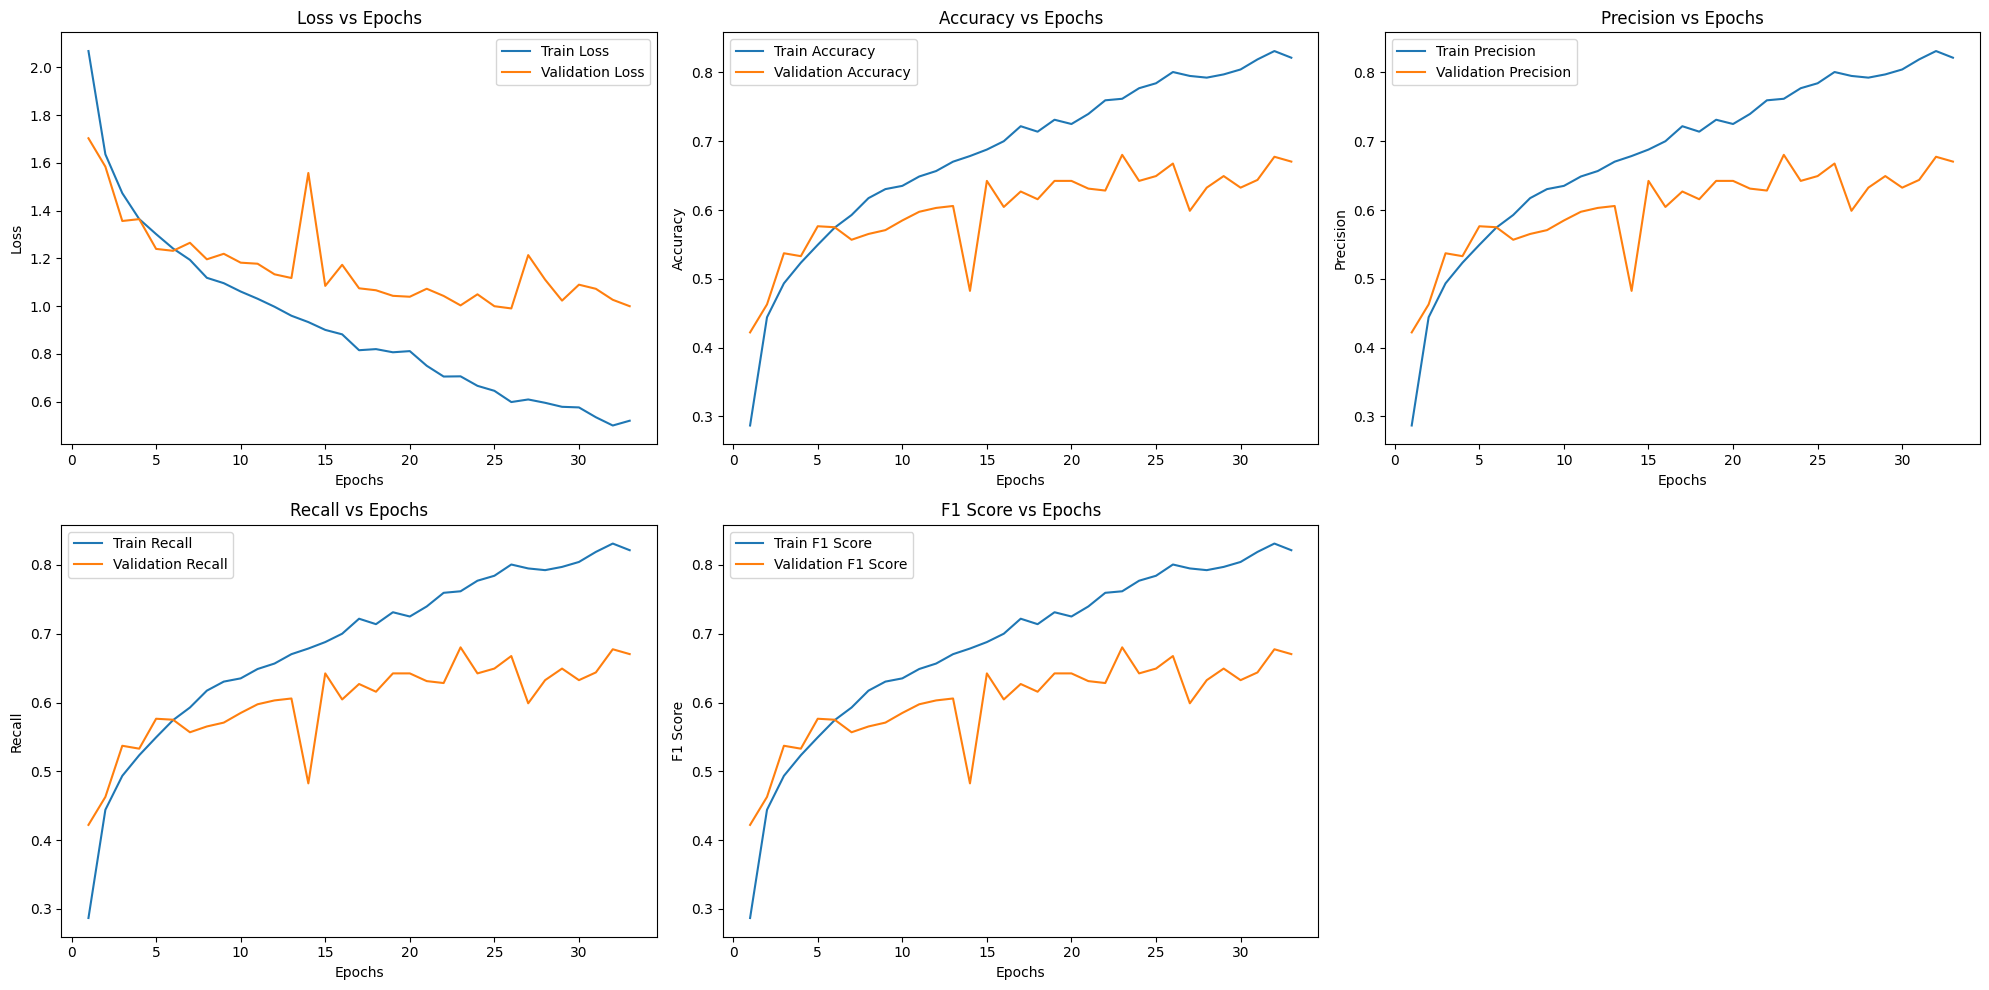

Training complete for mlp_m
Creating submission file for mlp_m


Test [TEST|mlp_m]: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Test results saved to mlp_m/mlp_m_test_results.csv




Starting training for mlp_l
Number of parameters: 212,494,604


Epoch 1/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s, accuracy=26.65%, loss=2.08]


Epoch [1/100], Train Loss: 2.1202, Train Accuracy: 0.2665, Train Precision: 0.2665, Train Recall: 0.2665, Train F1: 0.2665


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00, 10.43it/s]


Epoch [1/100], Validation Loss: 1.8514, Validation Accuracy: 0.3689, Validation Precision: 0.3689, Validation Recall: 0.3689, Validation F1: 0.3689
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.08it/s, accuracy=40.33%, loss=1.64]


Epoch [2/100], Train Loss: 1.6957, Train Accuracy: 0.4033, Train Precision: 0.4033, Train Recall: 0.4033, Train F1: 0.4033


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.21it/s]


Epoch [2/100], Validation Loss: 1.5452, Validation Accuracy: 0.4109, Validation Precision: 0.4109, Validation Recall: 0.4109, Validation F1: 0.4109
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.00it/s, accuracy=47.61%, loss=1.29]


Epoch [3/100], Train Loss: 1.5247, Train Accuracy: 0.4761, Train Precision: 0.4761, Train Recall: 0.4761, Train F1: 0.4761


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.70it/s]


Epoch [3/100], Validation Loss: 1.3836, Validation Accuracy: 0.5231, Validation Precision: 0.5231, Validation Recall: 0.5231, Validation F1: 0.5231
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.76it/s, accuracy=50.58%, loss=1.51]


Epoch [4/100], Train Loss: 1.4267, Train Accuracy: 0.5058, Train Precision: 0.5058, Train Recall: 0.5058, Train F1: 0.5058


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.35it/s]


Epoch [4/100], Validation Loss: 1.3574, Validation Accuracy: 0.5484, Validation Precision: 0.5484, Validation Recall: 0.5484, Validation F1: 0.5484
Saving best model at epoch 4...


Epoch 5/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.60it/s, accuracy=51.94%, loss=2.02]


Epoch [5/100], Train Loss: 1.3744, Train Accuracy: 0.5194, Train Precision: 0.5194, Train Recall: 0.5194, Train F1: 0.5194


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.28it/s]


Epoch [5/100], Validation Loss: 1.4772, Validation Accuracy: 0.4741, Validation Precision: 0.4741, Validation Recall: 0.4741, Validation F1: 0.4741
Patience: 1/10


Epoch 6/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.71it/s, accuracy=54.79%, loss=1.61]


Epoch [6/100], Train Loss: 1.2886, Train Accuracy: 0.5479, Train Precision: 0.5479, Train Recall: 0.5479, Train F1: 0.5479


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.38it/s]


Epoch [6/100], Validation Loss: 1.3118, Validation Accuracy: 0.5428, Validation Precision: 0.5428, Validation Recall: 0.5428, Validation F1: 0.5428
Patience: 2/10


Epoch 7/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.07it/s, accuracy=56.70%, loss=1.67]


Epoch [7/100], Train Loss: 1.2588, Train Accuracy: 0.5670, Train Precision: 0.5670, Train Recall: 0.5670, Train F1: 0.5670


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.74it/s]


Epoch [7/100], Validation Loss: 1.3874, Validation Accuracy: 0.5007, Validation Precision: 0.5007, Validation Recall: 0.5007, Validation F1: 0.5007
Patience: 3/10


Epoch 8/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.48it/s, accuracy=58.41%, loss=2.07]


Epoch [8/100], Train Loss: 1.2238, Train Accuracy: 0.5841, Train Precision: 0.5841, Train Recall: 0.5841, Train F1: 0.5841


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.50it/s]


Epoch [8/100], Validation Loss: 1.2415, Validation Accuracy: 0.5652, Validation Precision: 0.5652, Validation Recall: 0.5652, Validation F1: 0.5652
Saving best model at epoch 8...


Epoch 9/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.59it/s, accuracy=59.85%, loss=1.74]


Epoch [9/100], Train Loss: 1.1790, Train Accuracy: 0.5985, Train Precision: 0.5985, Train Recall: 0.5985, Train F1: 0.5985


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.69it/s]


Epoch [9/100], Validation Loss: 1.1947, Validation Accuracy: 0.5891, Validation Precision: 0.5891, Validation Recall: 0.5891, Validation F1: 0.5891
Saving best model at epoch 9...


Epoch 10/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.52it/s, accuracy=59.80%, loss=1.9]


Epoch [10/100], Train Loss: 1.1665, Train Accuracy: 0.5980, Train Precision: 0.5980, Train Recall: 0.5980, Train F1: 0.5980


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.45it/s]


Epoch [10/100], Validation Loss: 1.2327, Validation Accuracy: 0.5554, Validation Precision: 0.5554, Validation Recall: 0.5554, Validation F1: 0.5554
Patience: 1/10


Epoch 11/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.24it/s, accuracy=61.43%, loss=0.726]


Epoch [11/100], Train Loss: 1.1089, Train Accuracy: 0.6143, Train Precision: 0.6143, Train Recall: 0.6143, Train F1: 0.6143


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:05<00:00,  8.92it/s]


Epoch [11/100], Validation Loss: 1.1714, Validation Accuracy: 0.5820, Validation Precision: 0.5820, Validation Recall: 0.5820, Validation F1: 0.5820
Patience: 2/10


Epoch 12/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.19it/s, accuracy=62.08%, loss=1.26]


Epoch [12/100], Train Loss: 1.0942, Train Accuracy: 0.6208, Train Precision: 0.6208, Train Recall: 0.6208, Train F1: 0.6208


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.37it/s]


Epoch [12/100], Validation Loss: 1.2533, Validation Accuracy: 0.5624, Validation Precision: 0.5624, Validation Recall: 0.5624, Validation F1: 0.5624
Patience: 3/10


Epoch 13/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.58it/s, accuracy=62.77%, loss=0.859]


Epoch [13/100], Train Loss: 1.0853, Train Accuracy: 0.6277, Train Precision: 0.6277, Train Recall: 0.6277, Train F1: 0.6277


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.35it/s]


Epoch [13/100], Validation Loss: 1.2309, Validation Accuracy: 0.5624, Validation Precision: 0.5624, Validation Recall: 0.5624, Validation F1: 0.5624
Patience: 4/10


Epoch 14/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.39it/s, accuracy=64.73%, loss=0.98]


Epoch [14/100], Train Loss: 1.0419, Train Accuracy: 0.6473, Train Precision: 0.6473, Train Recall: 0.6473, Train F1: 0.6473


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.48it/s]


Epoch [14/100], Validation Loss: 1.2142, Validation Accuracy: 0.5582, Validation Precision: 0.5582, Validation Recall: 0.5582, Validation F1: 0.5582
Patience: 5/10


Epoch 15/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.35it/s, accuracy=64.85%, loss=0.956]


Epoch [15/100], Train Loss: 0.9993, Train Accuracy: 0.6485, Train Precision: 0.6485, Train Recall: 0.6485, Train F1: 0.6485


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00,  9.94it/s]


Epoch [15/100], Validation Loss: 1.2203, Validation Accuracy: 0.5568, Validation Precision: 0.5568, Validation Recall: 0.5568, Validation F1: 0.5568
Patience: 6/10


Epoch 16/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.01it/s, accuracy=66.91%, loss=1.28]


Epoch [16/100], Train Loss: 0.9618, Train Accuracy: 0.6691, Train Precision: 0.6691, Train Recall: 0.6691, Train F1: 0.6691


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.37it/s]


Epoch [16/100], Validation Loss: 1.6369, Validation Accuracy: 0.4474, Validation Precision: 0.4474, Validation Recall: 0.4474, Validation F1: 0.4474
Patience: 7/10


Epoch 17/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.42it/s, accuracy=67.10%, loss=0.936]


Epoch [17/100], Train Loss: 0.9529, Train Accuracy: 0.6710, Train Precision: 0.6710, Train Recall: 0.6710, Train F1: 0.6710


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


Epoch [17/100], Validation Loss: 1.1086, Validation Accuracy: 0.6157, Validation Precision: 0.6157, Validation Recall: 0.6157, Validation F1: 0.6157
Saving best model at epoch 17...


Epoch 18/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.65it/s, accuracy=69.09%, loss=2.52]


Epoch [18/100], Train Loss: 0.9120, Train Accuracy: 0.6909, Train Precision: 0.6909, Train Recall: 0.6909, Train F1: 0.6909


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.76it/s]


Epoch [18/100], Validation Loss: 1.1545, Validation Accuracy: 0.5835, Validation Precision: 0.5835, Validation Recall: 0.5835, Validation F1: 0.5835
Patience: 1/10


Epoch 19/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.30it/s, accuracy=69.53%, loss=2.83]


Epoch [19/100], Train Loss: 0.9049, Train Accuracy: 0.6953, Train Precision: 0.6953, Train Recall: 0.6953, Train F1: 0.6953


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00,  9.05it/s]


Epoch [19/100], Validation Loss: 1.1539, Validation Accuracy: 0.6185, Validation Precision: 0.6185, Validation Recall: 0.6185, Validation F1: 0.6185
Saving best model at epoch 19...


Epoch 20/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.42it/s, accuracy=69.53%, loss=2.31]


Epoch [20/100], Train Loss: 0.9007, Train Accuracy: 0.6953, Train Precision: 0.6953, Train Recall: 0.6953, Train F1: 0.6953


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.67it/s]


Epoch [20/100], Validation Loss: 1.1000, Validation Accuracy: 0.6059, Validation Precision: 0.6059, Validation Recall: 0.6059, Validation F1: 0.6059
Patience: 1/10


Epoch 21/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.62it/s, accuracy=71.69%, loss=1.44]


Epoch [21/100], Train Loss: 0.8482, Train Accuracy: 0.7169, Train Precision: 0.7169, Train Recall: 0.7169, Train F1: 0.7169


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.70it/s]


Epoch [21/100], Validation Loss: 1.1030, Validation Accuracy: 0.6087, Validation Precision: 0.6087, Validation Recall: 0.6087, Validation F1: 0.6087
Patience: 2/10


Epoch 22/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.40it/s, accuracy=72.23%, loss=1.16]


Epoch [22/100], Train Loss: 0.8110, Train Accuracy: 0.7223, Train Precision: 0.7223, Train Recall: 0.7223, Train F1: 0.7223


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.68it/s]


Epoch [22/100], Validation Loss: 1.1099, Validation Accuracy: 0.6101, Validation Precision: 0.6101, Validation Recall: 0.6101, Validation F1: 0.6101
Patience: 3/10


Epoch 23/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.98it/s, accuracy=73.00%, loss=0.663]


Epoch [23/100], Train Loss: 0.7952, Train Accuracy: 0.7300, Train Precision: 0.7300, Train Recall: 0.7300, Train F1: 0.7300


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00, 10.93it/s]


Epoch [23/100], Validation Loss: 1.1378, Validation Accuracy: 0.5989, Validation Precision: 0.5989, Validation Recall: 0.5989, Validation F1: 0.5989
Patience: 4/10


Epoch 24/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s, accuracy=74.19%, loss=1.35]


Epoch [24/100], Train Loss: 0.7753, Train Accuracy: 0.7419, Train Precision: 0.7419, Train Recall: 0.7419, Train F1: 0.7419


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.72it/s]


Epoch [24/100], Validation Loss: 1.1969, Validation Accuracy: 0.5806, Validation Precision: 0.5806, Validation Recall: 0.5806, Validation F1: 0.5806
Patience: 5/10


Epoch 25/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.56it/s, accuracy=73.99%, loss=1.04]


Epoch [25/100], Train Loss: 0.7520, Train Accuracy: 0.7399, Train Precision: 0.7399, Train Recall: 0.7399, Train F1: 0.7399


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.79it/s]


Epoch [25/100], Validation Loss: 1.1933, Validation Accuracy: 0.5989, Validation Precision: 0.5989, Validation Recall: 0.5989, Validation F1: 0.5989
Patience: 6/10


Epoch 26/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.62it/s, accuracy=74.61%, loss=0.383]


Epoch [26/100], Train Loss: 0.7375, Train Accuracy: 0.7461, Train Precision: 0.7461, Train Recall: 0.7461, Train F1: 0.7461


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.34it/s]


Epoch [26/100], Validation Loss: 1.1249, Validation Accuracy: 0.6129, Validation Precision: 0.6129, Validation Recall: 0.6129, Validation F1: 0.6129
Patience: 7/10


Epoch 27/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.10it/s, accuracy=75.35%, loss=3.06]


Epoch [27/100], Train Loss: 0.7319, Train Accuracy: 0.7535, Train Precision: 0.7535, Train Recall: 0.7535, Train F1: 0.7535


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00,  9.65it/s]


Epoch [27/100], Validation Loss: 1.0089, Validation Accuracy: 0.6620, Validation Precision: 0.6620, Validation Recall: 0.6620, Validation F1: 0.6620
Saving best model at epoch 27...


Epoch 28/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.38it/s, accuracy=77.56%, loss=0.912]


Epoch [28/100], Train Loss: 0.6720, Train Accuracy: 0.7756, Train Precision: 0.7756, Train Recall: 0.7756, Train F1: 0.7756


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.73it/s]


Epoch [28/100], Validation Loss: 1.0533, Validation Accuracy: 0.6438, Validation Precision: 0.6438, Validation Recall: 0.6438, Validation F1: 0.6438
Patience: 1/10


Epoch 29/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.50it/s, accuracy=76.42%, loss=2.09]


Epoch [29/100], Train Loss: 0.7101, Train Accuracy: 0.7642, Train Precision: 0.7642, Train Recall: 0.7642, Train F1: 0.7642


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.60it/s]


Epoch [29/100], Validation Loss: 1.1226, Validation Accuracy: 0.6129, Validation Precision: 0.6129, Validation Recall: 0.6129, Validation F1: 0.6129
Patience: 2/10


Epoch 30/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s, accuracy=77.93%, loss=1.39]


Epoch [30/100], Train Loss: 0.6420, Train Accuracy: 0.7793, Train Precision: 0.7793, Train Recall: 0.7793, Train F1: 0.7793


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.59it/s]


Epoch [30/100], Validation Loss: 1.0002, Validation Accuracy: 0.6690, Validation Precision: 0.6690, Validation Recall: 0.6690, Validation F1: 0.6690
Saving best model at epoch 30...


Epoch 31/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.25it/s, accuracy=78.82%, loss=0.82]


Epoch [31/100], Train Loss: 0.6292, Train Accuracy: 0.7882, Train Precision: 0.7882, Train Recall: 0.7882, Train F1: 0.7882


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.79it/s]


Epoch [31/100], Validation Loss: 1.1923, Validation Accuracy: 0.6031, Validation Precision: 0.6031, Validation Recall: 0.6031, Validation F1: 0.6031
Patience: 1/10


Epoch 32/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.17it/s, accuracy=79.96%, loss=1.15]


Epoch [32/100], Train Loss: 0.6065, Train Accuracy: 0.7996, Train Precision: 0.7996, Train Recall: 0.7996, Train F1: 0.7996


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [32/100], Validation Loss: 0.9997, Validation Accuracy: 0.6536, Validation Precision: 0.6536, Validation Recall: 0.6536, Validation F1: 0.6536
Patience: 2/10


Epoch 33/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.11it/s, accuracy=79.84%, loss=1.43]


Epoch [33/100], Train Loss: 0.5783, Train Accuracy: 0.7984, Train Precision: 0.7984, Train Recall: 0.7984, Train F1: 0.7984


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.32it/s]


Epoch [33/100], Validation Loss: 1.0747, Validation Accuracy: 0.6452, Validation Precision: 0.6452, Validation Recall: 0.6452, Validation F1: 0.6452
Patience: 3/10


Epoch 34/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.71it/s, accuracy=80.88%, loss=0.383]


Epoch [34/100], Train Loss: 0.5665, Train Accuracy: 0.8088, Train Precision: 0.8088, Train Recall: 0.8088, Train F1: 0.8088


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.63it/s]


Epoch [34/100], Validation Loss: 1.1161, Validation Accuracy: 0.6283, Validation Precision: 0.6283, Validation Recall: 0.6283, Validation F1: 0.6283
Patience: 4/10


Epoch 35/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.26it/s, accuracy=81.20%, loss=1.79]


Epoch [35/100], Train Loss: 0.5566, Train Accuracy: 0.8120, Train Precision: 0.8120, Train Recall: 0.8120, Train F1: 0.8120


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.52it/s]


Epoch [35/100], Validation Loss: 1.1577, Validation Accuracy: 0.6199, Validation Precision: 0.6199, Validation Recall: 0.6199, Validation F1: 0.6199
Patience: 5/10


Epoch 36/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.50it/s, accuracy=81.03%, loss=1.01]


Epoch [36/100], Train Loss: 0.5507, Train Accuracy: 0.8103, Train Precision: 0.8103, Train Recall: 0.8103, Train F1: 0.8103


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.07it/s]


Epoch [36/100], Validation Loss: 1.0189, Validation Accuracy: 0.6508, Validation Precision: 0.6508, Validation Recall: 0.6508, Validation F1: 0.6508
Patience: 6/10


Epoch 37/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s, accuracy=82.88%, loss=1.2]


Epoch [37/100], Train Loss: 0.5139, Train Accuracy: 0.8288, Train Precision: 0.8288, Train Recall: 0.8288, Train F1: 0.8288


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.29it/s]


Epoch [37/100], Validation Loss: 1.0905, Validation Accuracy: 0.6508, Validation Precision: 0.6508, Validation Recall: 0.6508, Validation F1: 0.6508
Patience: 7/10


Epoch 38/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.98it/s, accuracy=83.01%, loss=0.349]


Epoch [38/100], Train Loss: 0.4841, Train Accuracy: 0.8301, Train Precision: 0.8301, Train Recall: 0.8301, Train F1: 0.8301


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.44it/s]


Epoch [38/100], Validation Loss: 0.9735, Validation Accuracy: 0.6662, Validation Precision: 0.6662, Validation Recall: 0.6662, Validation F1: 0.6662
Patience: 8/10


Epoch 39/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.48it/s, accuracy=82.91%, loss=1.06]


Epoch [39/100], Train Loss: 0.4974, Train Accuracy: 0.8291, Train Precision: 0.8291, Train Recall: 0.8291, Train F1: 0.8291


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.46it/s]


Epoch [39/100], Validation Loss: 0.9414, Validation Accuracy: 0.6816, Validation Precision: 0.6816, Validation Recall: 0.6816, Validation F1: 0.6816
Saving best model at epoch 39...


Epoch 40/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.01it/s, accuracy=84.25%, loss=1.54]


Epoch [40/100], Train Loss: 0.4662, Train Accuracy: 0.8425, Train Precision: 0.8425, Train Recall: 0.8425, Train F1: 0.8425


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.50it/s]


Epoch [40/100], Validation Loss: 1.0443, Validation Accuracy: 0.6704, Validation Precision: 0.6704, Validation Recall: 0.6704, Validation F1: 0.6704
Patience: 1/10


Epoch 41/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.43it/s, accuracy=83.87%, loss=1.29]


Epoch [41/100], Train Loss: 0.4703, Train Accuracy: 0.8387, Train Precision: 0.8387, Train Recall: 0.8387, Train F1: 0.8387


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.68it/s]


Epoch [41/100], Validation Loss: 1.0199, Validation Accuracy: 0.6662, Validation Precision: 0.6662, Validation Recall: 0.6662, Validation F1: 0.6662
Patience: 2/10


Epoch 42/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.36it/s, accuracy=85.39%, loss=1.62]


Epoch [42/100], Train Loss: 0.4404, Train Accuracy: 0.8539, Train Precision: 0.8539, Train Recall: 0.8539, Train F1: 0.8539


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [42/100], Validation Loss: 1.1012, Validation Accuracy: 0.6466, Validation Precision: 0.6466, Validation Recall: 0.6466, Validation F1: 0.6466
Patience: 3/10


Epoch 43/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.21it/s, accuracy=85.78%, loss=1.16]


Epoch [43/100], Train Loss: 0.4366, Train Accuracy: 0.8578, Train Precision: 0.8578, Train Recall: 0.8578, Train F1: 0.8578


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.80it/s]


Epoch [43/100], Validation Loss: 0.9921, Validation Accuracy: 0.6690, Validation Precision: 0.6690, Validation Recall: 0.6690, Validation F1: 0.6690
Patience: 4/10


Epoch 44/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.64it/s, accuracy=86.67%, loss=0.258]


Epoch [44/100], Train Loss: 0.4106, Train Accuracy: 0.8667, Train Precision: 0.8667, Train Recall: 0.8667, Train F1: 0.8667


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.68it/s]


Epoch [44/100], Validation Loss: 1.1134, Validation Accuracy: 0.6508, Validation Precision: 0.6508, Validation Recall: 0.6508, Validation F1: 0.6508
Patience: 5/10


Epoch 45/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s, accuracy=86.92%, loss=1.38]


Epoch [45/100], Train Loss: 0.3904, Train Accuracy: 0.8692, Train Precision: 0.8692, Train Recall: 0.8692, Train F1: 0.8692


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.64it/s]


Epoch [45/100], Validation Loss: 1.1198, Validation Accuracy: 0.6424, Validation Precision: 0.6424, Validation Recall: 0.6424, Validation F1: 0.6424
Patience: 6/10


Epoch 46/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.15it/s, accuracy=87.44%, loss=0.441]


Epoch [46/100], Train Loss: 0.3838, Train Accuracy: 0.8744, Train Precision: 0.8744, Train Recall: 0.8744, Train F1: 0.8744


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


Epoch [46/100], Validation Loss: 0.9733, Validation Accuracy: 0.6816, Validation Precision: 0.6816, Validation Recall: 0.6816, Validation F1: 0.6816
Patience: 7/10


Epoch 47/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.27it/s, accuracy=87.79%, loss=0.894]


Epoch [47/100], Train Loss: 0.3531, Train Accuracy: 0.8779, Train Precision: 0.8779, Train Recall: 0.8779, Train F1: 0.8779


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.69it/s]


Epoch [47/100], Validation Loss: 1.0254, Validation Accuracy: 0.6844, Validation Precision: 0.6844, Validation Recall: 0.6844, Validation F1: 0.6844
Saving best model at epoch 47...


Epoch 48/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.04it/s, accuracy=87.96%, loss=0.621]


Epoch [48/100], Train Loss: 0.3672, Train Accuracy: 0.8796, Train Precision: 0.8796, Train Recall: 0.8796, Train F1: 0.8796


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.77it/s]


Epoch [48/100], Validation Loss: 1.0107, Validation Accuracy: 0.6858, Validation Precision: 0.6858, Validation Recall: 0.6858, Validation F1: 0.6858
Saving best model at epoch 48...


Epoch 49/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.97it/s, accuracy=88.63%, loss=0.3]


Epoch [49/100], Train Loss: 0.3418, Train Accuracy: 0.8863, Train Precision: 0.8863, Train Recall: 0.8863, Train F1: 0.8863


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.79it/s]


Epoch [49/100], Validation Loss: 0.9388, Validation Accuracy: 0.7013, Validation Precision: 0.7013, Validation Recall: 0.7013, Validation F1: 0.7013
Saving best model at epoch 49...


Epoch 50/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s, accuracy=88.65%, loss=0.699]


Epoch [50/100], Train Loss: 0.3457, Train Accuracy: 0.8865, Train Precision: 0.8865, Train Recall: 0.8865, Train F1: 0.8865


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.51it/s]


Epoch [50/100], Validation Loss: 0.9571, Validation Accuracy: 0.6914, Validation Precision: 0.6914, Validation Recall: 0.6914, Validation F1: 0.6914
Patience: 1/10


Epoch 51/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.61it/s, accuracy=87.76%, loss=1.38]


Epoch [51/100], Train Loss: 0.3454, Train Accuracy: 0.8776, Train Precision: 0.8776, Train Recall: 0.8776, Train F1: 0.8776


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.68it/s]


Epoch [51/100], Validation Loss: 1.0728, Validation Accuracy: 0.6578, Validation Precision: 0.6578, Validation Recall: 0.6578, Validation F1: 0.6578
Patience: 2/10


Epoch 52/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.03it/s, accuracy=89.20%, loss=0.441]


Epoch [52/100], Train Loss: 0.3205, Train Accuracy: 0.8920, Train Precision: 0.8920, Train Recall: 0.8920, Train F1: 0.8920


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.93it/s]


Epoch [52/100], Validation Loss: 1.0025, Validation Accuracy: 0.6886, Validation Precision: 0.6886, Validation Recall: 0.6886, Validation F1: 0.6886
Patience: 3/10


Epoch 53/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.06it/s, accuracy=90.34%, loss=0.275]


Epoch [53/100], Train Loss: 0.3077, Train Accuracy: 0.9034, Train Precision: 0.9034, Train Recall: 0.9034, Train F1: 0.9034


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00, 10.15it/s]


Epoch [53/100], Validation Loss: 1.1529, Validation Accuracy: 0.6466, Validation Precision: 0.6466, Validation Recall: 0.6466, Validation F1: 0.6466
Patience: 4/10


Epoch 54/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.81it/s, accuracy=90.61%, loss=2.57]


Epoch [54/100], Train Loss: 0.2817, Train Accuracy: 0.9061, Train Precision: 0.9061, Train Recall: 0.9061, Train F1: 0.9061


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.70it/s]


Epoch [54/100], Validation Loss: 1.0084, Validation Accuracy: 0.6830, Validation Precision: 0.6830, Validation Recall: 0.6830, Validation F1: 0.6830
Patience: 5/10


Epoch 55/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.04it/s, accuracy=90.39%, loss=0.726]


Epoch [55/100], Train Loss: 0.2912, Train Accuracy: 0.9039, Train Precision: 0.9039, Train Recall: 0.9039, Train F1: 0.9039


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.47it/s]


Epoch [55/100], Validation Loss: 1.0607, Validation Accuracy: 0.6774, Validation Precision: 0.6774, Validation Recall: 0.6774, Validation F1: 0.6774
Patience: 6/10


Epoch 56/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.40it/s, accuracy=91.70%, loss=2.76]


Epoch [56/100], Train Loss: 0.2638, Train Accuracy: 0.9170, Train Precision: 0.9170, Train Recall: 0.9170, Train F1: 0.9170


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.39it/s]


Epoch [56/100], Validation Loss: 1.0263, Validation Accuracy: 0.7055, Validation Precision: 0.7055, Validation Recall: 0.7055, Validation F1: 0.7055
Saving best model at epoch 56...


Epoch 57/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s, accuracy=91.03%, loss=1.54]


Epoch [57/100], Train Loss: 0.2609, Train Accuracy: 0.9103, Train Precision: 0.9103, Train Recall: 0.9103, Train F1: 0.9103


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.55it/s]


Epoch [57/100], Validation Loss: 0.9935, Validation Accuracy: 0.7083, Validation Precision: 0.7083, Validation Recall: 0.7083, Validation F1: 0.7083
Saving best model at epoch 57...


Epoch 58/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.08it/s, accuracy=92.40%, loss=1.36]


Epoch [58/100], Train Loss: 0.2377, Train Accuracy: 0.9240, Train Precision: 0.9240, Train Recall: 0.9240, Train F1: 0.9240


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00,  9.15it/s]


Epoch [58/100], Validation Loss: 0.9990, Validation Accuracy: 0.6957, Validation Precision: 0.6957, Validation Recall: 0.6957, Validation F1: 0.6957
Patience: 1/10


Epoch 59/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.29it/s, accuracy=92.47%, loss=0.533]


Epoch [59/100], Train Loss: 0.2288, Train Accuracy: 0.9247, Train Precision: 0.9247, Train Recall: 0.9247, Train F1: 0.9247


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.71it/s]


Epoch [59/100], Validation Loss: 1.0148, Validation Accuracy: 0.7041, Validation Precision: 0.7041, Validation Recall: 0.7041, Validation F1: 0.7041
Patience: 2/10


Epoch 60/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.19it/s, accuracy=92.89%, loss=0.979]


Epoch [60/100], Train Loss: 0.2207, Train Accuracy: 0.9289, Train Precision: 0.9289, Train Recall: 0.9289, Train F1: 0.9289


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


Epoch [60/100], Validation Loss: 0.9664, Validation Accuracy: 0.7083, Validation Precision: 0.7083, Validation Recall: 0.7083, Validation F1: 0.7083
Patience: 3/10


Epoch 61/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.47it/s, accuracy=92.47%, loss=0.849]


Epoch [61/100], Train Loss: 0.2332, Train Accuracy: 0.9247, Train Precision: 0.9247, Train Recall: 0.9247, Train F1: 0.9247


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.46it/s]


Epoch [61/100], Validation Loss: 1.0425, Validation Accuracy: 0.6872, Validation Precision: 0.6872, Validation Recall: 0.6872, Validation F1: 0.6872
Patience: 4/10


Epoch 62/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.06it/s, accuracy=93.26%, loss=4.1]


Epoch [62/100], Train Loss: 0.2196, Train Accuracy: 0.9326, Train Precision: 0.9326, Train Recall: 0.9326, Train F1: 0.9326


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.75it/s]


Epoch [62/100], Validation Loss: 1.0149, Validation Accuracy: 0.6872, Validation Precision: 0.6872, Validation Recall: 0.6872, Validation F1: 0.6872
Patience: 5/10


Epoch 63/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.18it/s, accuracy=93.46%, loss=0.408]


Epoch [63/100], Train Loss: 0.1987, Train Accuracy: 0.9346, Train Precision: 0.9346, Train Recall: 0.9346, Train F1: 0.9346


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00, 10.04it/s]


Epoch [63/100], Validation Loss: 1.0063, Validation Accuracy: 0.6886, Validation Precision: 0.6886, Validation Recall: 0.6886, Validation F1: 0.6886
Patience: 6/10


Epoch 64/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.17it/s, accuracy=93.56%, loss=0.313]


Epoch [64/100], Train Loss: 0.1978, Train Accuracy: 0.9356, Train Precision: 0.9356, Train Recall: 0.9356, Train F1: 0.9356


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.51it/s]


Epoch [64/100], Validation Loss: 0.9897, Validation Accuracy: 0.7013, Validation Precision: 0.7013, Validation Recall: 0.7013, Validation F1: 0.7013
Patience: 7/10


Epoch 65/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.36it/s, accuracy=94.18%, loss=0.945]


Epoch [65/100], Train Loss: 0.1838, Train Accuracy: 0.9418, Train Precision: 0.9418, Train Recall: 0.9418, Train F1: 0.9418


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.71it/s]


Epoch [65/100], Validation Loss: 0.9781, Validation Accuracy: 0.6886, Validation Precision: 0.6886, Validation Recall: 0.6886, Validation F1: 0.6886
Patience: 8/10


Epoch 66/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.53it/s, accuracy=94.35%, loss=0.0918]


Epoch [66/100], Train Loss: 0.1827, Train Accuracy: 0.9435, Train Precision: 0.9435, Train Recall: 0.9435, Train F1: 0.9435


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.53it/s]


Epoch [66/100], Validation Loss: 0.9723, Validation Accuracy: 0.7237, Validation Precision: 0.7237, Validation Recall: 0.7237, Validation F1: 0.7237
Saving best model at epoch 66...


Epoch 67/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.19it/s, accuracy=94.50%, loss=0.432]


Epoch [67/100], Train Loss: 0.1866, Train Accuracy: 0.9450, Train Precision: 0.9450, Train Recall: 0.9450, Train F1: 0.9450


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


Epoch [67/100], Validation Loss: 0.9875, Validation Accuracy: 0.7069, Validation Precision: 0.7069, Validation Recall: 0.7069, Validation F1: 0.7069
Patience: 1/10


Epoch 68/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.17it/s, accuracy=94.55%, loss=1.93]


Epoch [68/100], Train Loss: 0.1768, Train Accuracy: 0.9455, Train Precision: 0.9455, Train Recall: 0.9455, Train F1: 0.9455


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00, 10.55it/s]


Epoch [68/100], Validation Loss: 1.0337, Validation Accuracy: 0.6914, Validation Precision: 0.6914, Validation Recall: 0.6914, Validation F1: 0.6914
Patience: 2/10


Epoch 69/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.73it/s, accuracy=94.95%, loss=0.196]


Epoch [69/100], Train Loss: 0.1565, Train Accuracy: 0.9495, Train Precision: 0.9495, Train Recall: 0.9495, Train F1: 0.9495


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [69/100], Validation Loss: 0.9471, Validation Accuracy: 0.7153, Validation Precision: 0.7153, Validation Recall: 0.7153, Validation F1: 0.7153
Patience: 3/10


Epoch 70/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s, accuracy=94.25%, loss=0.231]


Epoch [70/100], Train Loss: 0.1690, Train Accuracy: 0.9425, Train Precision: 0.9425, Train Recall: 0.9425, Train F1: 0.9425


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.60it/s]


Epoch [70/100], Validation Loss: 1.0168, Validation Accuracy: 0.7111, Validation Precision: 0.7111, Validation Recall: 0.7111, Validation F1: 0.7111
Patience: 4/10


Epoch 71/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.56it/s, accuracy=95.64%, loss=2.02]


Epoch [71/100], Train Loss: 0.1602, Train Accuracy: 0.9564, Train Precision: 0.9564, Train Recall: 0.9564, Train F1: 0.9564


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.53it/s]


Epoch [71/100], Validation Loss: 0.9976, Validation Accuracy: 0.7125, Validation Precision: 0.7125, Validation Recall: 0.7125, Validation F1: 0.7125
Patience: 5/10


Epoch 72/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:21<00:00, 11.62it/s, accuracy=95.52%, loss=0.0828]


Epoch [72/100], Train Loss: 0.1432, Train Accuracy: 0.9552, Train Precision: 0.9552, Train Recall: 0.9552, Train F1: 0.9552


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.80it/s]


Epoch [72/100], Validation Loss: 0.9753, Validation Accuracy: 0.7279, Validation Precision: 0.7279, Validation Recall: 0.7279, Validation F1: 0.7279
Saving best model at epoch 72...


Epoch 73/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:21<00:00, 11.55it/s, accuracy=95.32%, loss=0.103]


Epoch [73/100], Train Loss: 0.1522, Train Accuracy: 0.9532, Train Precision: 0.9532, Train Recall: 0.9532, Train F1: 0.9532


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.21it/s]


Epoch [73/100], Validation Loss: 1.0547, Validation Accuracy: 0.6942, Validation Precision: 0.6942, Validation Recall: 0.6942, Validation F1: 0.6942
Patience: 1/10


Epoch 74/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.35it/s, accuracy=96.23%, loss=0.515]


Epoch [74/100], Train Loss: 0.1275, Train Accuracy: 0.9623, Train Precision: 0.9623, Train Recall: 0.9623, Train F1: 0.9623


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.54it/s]


Epoch [74/100], Validation Loss: 0.9884, Validation Accuracy: 0.6971, Validation Precision: 0.6971, Validation Recall: 0.6971, Validation F1: 0.6971
Patience: 2/10


Epoch 75/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.31it/s, accuracy=96.04%, loss=2.44]


Epoch [75/100], Train Loss: 0.1391, Train Accuracy: 0.9604, Train Precision: 0.9604, Train Recall: 0.9604, Train F1: 0.9604


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [75/100], Validation Loss: 1.0247, Validation Accuracy: 0.7097, Validation Precision: 0.7097, Validation Recall: 0.7097, Validation F1: 0.7097
Patience: 3/10


Epoch 76/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.31it/s, accuracy=95.99%, loss=2.74]


Epoch [76/100], Train Loss: 0.1393, Train Accuracy: 0.9599, Train Precision: 0.9599, Train Recall: 0.9599, Train F1: 0.9599


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.78it/s]


Epoch [76/100], Validation Loss: 1.0569, Validation Accuracy: 0.7041, Validation Precision: 0.7041, Validation Recall: 0.7041, Validation F1: 0.7041
Patience: 4/10


Epoch 77/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.25it/s, accuracy=96.19%, loss=0.412]


Epoch [77/100], Train Loss: 0.1292, Train Accuracy: 0.9619, Train Precision: 0.9619, Train Recall: 0.9619, Train F1: 0.9619


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.81it/s]


Epoch [77/100], Validation Loss: 1.0360, Validation Accuracy: 0.7083, Validation Precision: 0.7083, Validation Recall: 0.7083, Validation F1: 0.7083
Patience: 5/10


Epoch 78/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.50it/s, accuracy=96.56%, loss=0.103]


Epoch [78/100], Train Loss: 0.1223, Train Accuracy: 0.9656, Train Precision: 0.9656, Train Recall: 0.9656, Train F1: 0.9656


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 11.35it/s]


Epoch [78/100], Validation Loss: 1.0655, Validation Accuracy: 0.7069, Validation Precision: 0.7069, Validation Recall: 0.7069, Validation F1: 0.7069
Patience: 6/10


Epoch 79/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:24<00:00, 10.40it/s, accuracy=95.96%, loss=1.59]


Epoch [79/100], Train Loss: 0.1276, Train Accuracy: 0.9596, Train Precision: 0.9596, Train Recall: 0.9596, Train F1: 0.9596


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.54it/s]


Epoch [79/100], Validation Loss: 0.9939, Validation Accuracy: 0.7167, Validation Precision: 0.7167, Validation Recall: 0.7167, Validation F1: 0.7167
Patience: 7/10


Epoch 80/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.45it/s, accuracy=96.53%, loss=0.0452]


Epoch [80/100], Train Loss: 0.1106, Train Accuracy: 0.9653, Train Precision: 0.9653, Train Recall: 0.9653, Train F1: 0.9653


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.64it/s]


Epoch [80/100], Validation Loss: 1.0333, Validation Accuracy: 0.7111, Validation Precision: 0.7111, Validation Recall: 0.7111, Validation F1: 0.7111
Patience: 8/10


Epoch 81/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:23<00:00, 10.83it/s, accuracy=97.42%, loss=1.45]


Epoch [81/100], Train Loss: 0.0984, Train Accuracy: 0.9742, Train Precision: 0.9742, Train Recall: 0.9742, Train F1: 0.9742


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:04<00:00, 10.06it/s]


Epoch [81/100], Validation Loss: 1.0004, Validation Accuracy: 0.7055, Validation Precision: 0.7055, Validation Recall: 0.7055, Validation F1: 0.7055
Patience: 9/10


Epoch 82/100 [TRAIN|mlp_l]: 100%|██████████| 253/253 [00:22<00:00, 11.09it/s, accuracy=96.68%, loss=0.1]


Epoch [82/100], Train Loss: 0.1137, Train Accuracy: 0.9668, Train Precision: 0.9668, Train Recall: 0.9668, Train F1: 0.9668


Evaluation [VALID|mlp_l]: 100%|██████████| 45/45 [00:03<00:00, 12.35it/s]


Epoch [82/100], Validation Loss: 1.0445, Validation Accuracy: 0.7013, Validation Precision: 0.7013, Validation Recall: 0.7013, Validation F1: 0.7013
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to mlp_l/mlp_l_training_metrics.csv


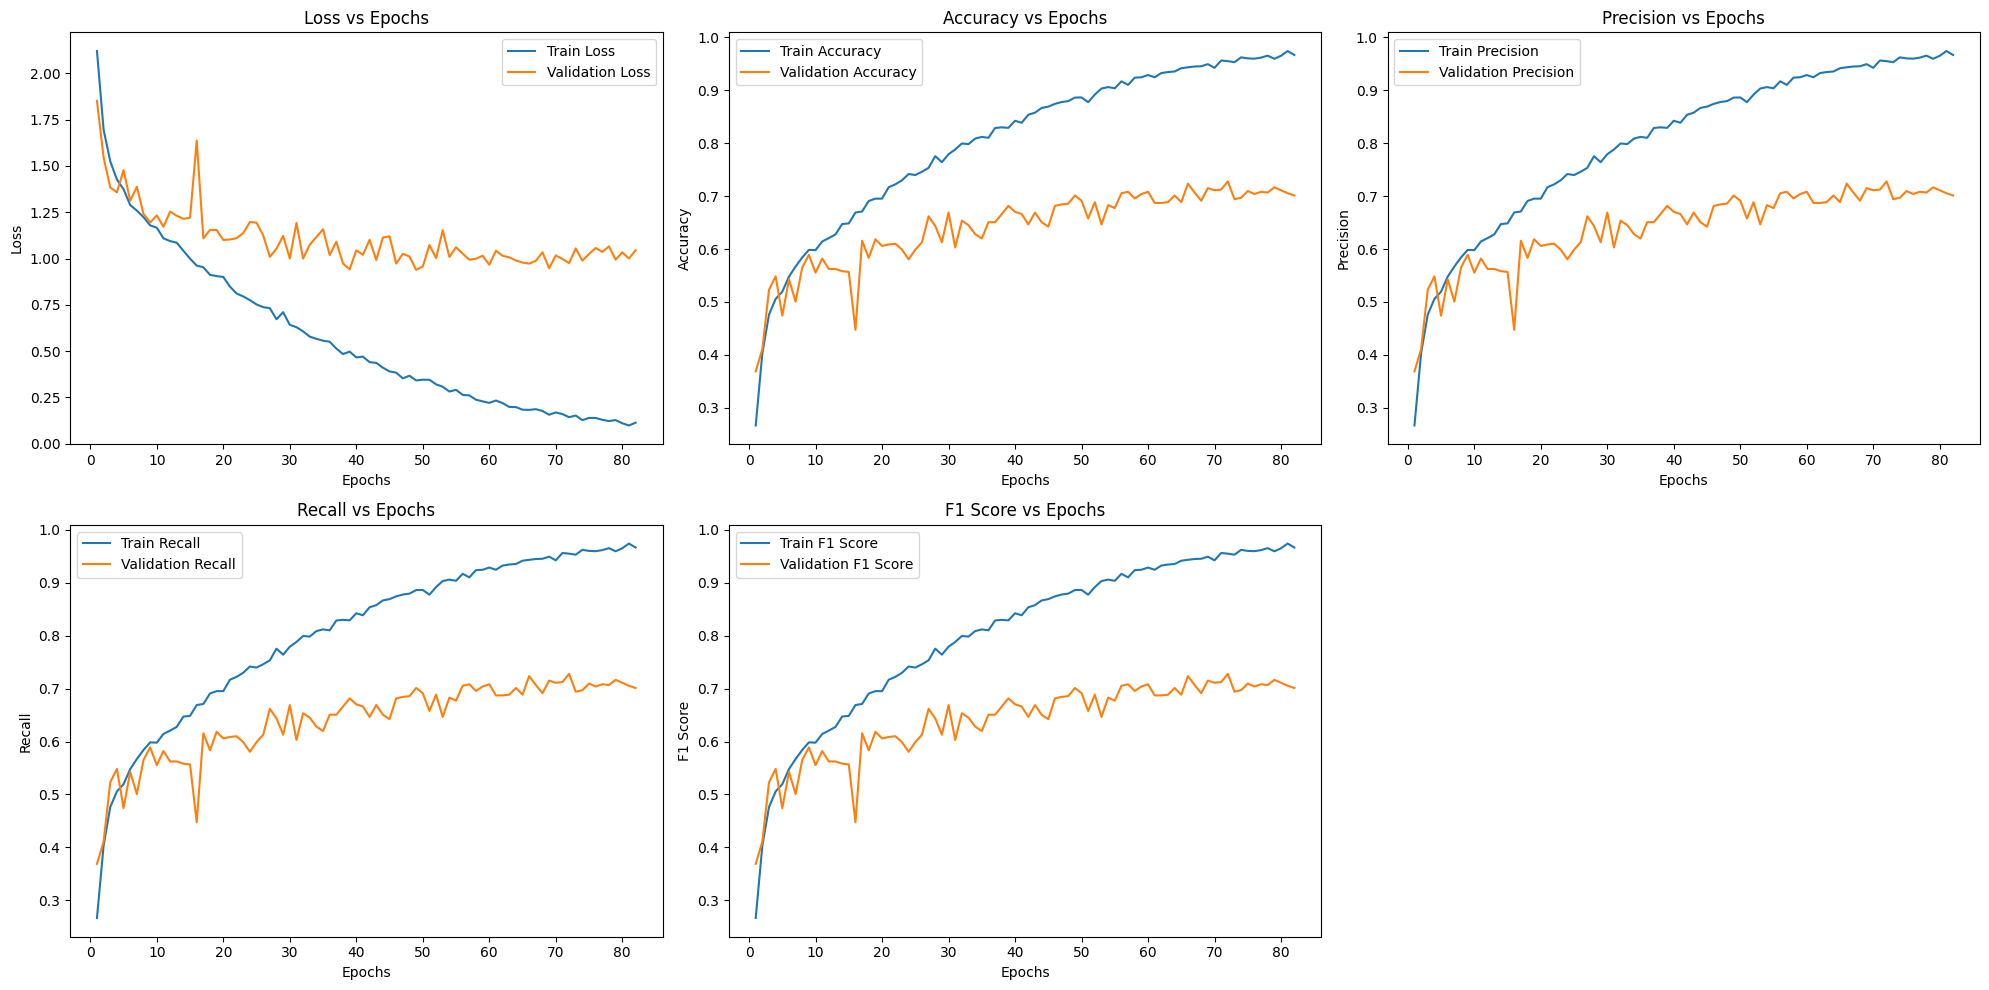

Training complete for mlp_l
Creating submission file for mlp_l


Test [TEST|mlp_l]: 100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Test results saved to mlp_l/mlp_l_test_results.csv




Starting training for mlp_xl
Number of parameters: 447,400,204


Epoch 1/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.78it/s, accuracy=21.90%, loss=2.14]


Epoch [1/100], Train Loss: 2.2389, Train Accuracy: 0.2190, Train Precision: 0.2190, Train Recall: 0.2190, Train F1: 0.2190


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 12.16it/s]


Epoch [1/100], Validation Loss: 1.8569, Validation Accuracy: 0.3436, Validation Precision: 0.3436, Validation Recall: 0.3436, Validation F1: 0.3436
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.91it/s, accuracy=36.49%, loss=1.86]


Epoch [2/100], Train Loss: 1.8196, Train Accuracy: 0.3649, Train Precision: 0.3649, Train Recall: 0.3649, Train F1: 0.3649


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.20it/s]


Epoch [2/100], Validation Loss: 1.6313, Validation Accuracy: 0.4488, Validation Precision: 0.4488, Validation Recall: 0.4488, Validation F1: 0.4488
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.74it/s, accuracy=43.15%, loss=2]


Epoch [3/100], Train Loss: 1.6124, Train Accuracy: 0.4315, Train Precision: 0.4315, Train Recall: 0.4315, Train F1: 0.4315


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.14it/s]


Epoch [3/100], Validation Loss: 1.4481, Validation Accuracy: 0.4895, Validation Precision: 0.4895, Validation Recall: 0.4895, Validation F1: 0.4895
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.92it/s, accuracy=46.77%, loss=2.78]


Epoch [4/100], Train Loss: 1.5286, Train Accuracy: 0.4677, Train Precision: 0.4677, Train Recall: 0.4677, Train F1: 0.4677


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.36it/s]


Epoch [4/100], Validation Loss: 1.4786, Validation Accuracy: 0.4839, Validation Precision: 0.4839, Validation Recall: 0.4839, Validation F1: 0.4839
Patience: 1/10


Epoch 5/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.78it/s, accuracy=49.72%, loss=1.97]


Epoch [5/100], Train Loss: 1.4323, Train Accuracy: 0.4972, Train Precision: 0.4972, Train Recall: 0.4972, Train F1: 0.4972


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.36it/s]


Epoch [5/100], Validation Loss: 1.6146, Validation Accuracy: 0.4418, Validation Precision: 0.4418, Validation Recall: 0.4418, Validation F1: 0.4418
Patience: 2/10


Epoch 6/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.95it/s, accuracy=51.20%, loss=2.6]


Epoch [6/100], Train Loss: 1.3936, Train Accuracy: 0.5120, Train Precision: 0.5120, Train Recall: 0.5120, Train F1: 0.5120


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.52it/s]


Epoch [6/100], Validation Loss: 1.4265, Validation Accuracy: 0.4839, Validation Precision: 0.4839, Validation Recall: 0.4839, Validation F1: 0.4839
Patience: 3/10


Epoch 7/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.76it/s, accuracy=53.13%, loss=1.11]


Epoch [7/100], Train Loss: 1.3721, Train Accuracy: 0.5313, Train Precision: 0.5313, Train Recall: 0.5313, Train F1: 0.5313


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.14it/s]


Epoch [7/100], Validation Loss: 1.4391, Validation Accuracy: 0.4965, Validation Precision: 0.4965, Validation Recall: 0.4965, Validation F1: 0.4965
Saving best model at epoch 7...


Epoch 8/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.97it/s, accuracy=55.07%, loss=1.84]


Epoch [8/100], Train Loss: 1.3135, Train Accuracy: 0.5507, Train Precision: 0.5507, Train Recall: 0.5507, Train F1: 0.5507


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.74it/s]


Epoch [8/100], Validation Loss: 1.6968, Validation Accuracy: 0.3829, Validation Precision: 0.3829, Validation Recall: 0.3829, Validation F1: 0.3829
Patience: 1/10


Epoch 9/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.84it/s, accuracy=56.03%, loss=1.49]


Epoch [9/100], Train Loss: 1.2656, Train Accuracy: 0.5603, Train Precision: 0.5603, Train Recall: 0.5603, Train F1: 0.5603


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.29it/s]


Epoch [9/100], Validation Loss: 1.2490, Validation Accuracy: 0.5680, Validation Precision: 0.5680, Validation Recall: 0.5680, Validation F1: 0.5680
Saving best model at epoch 9...


Epoch 10/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.95it/s, accuracy=56.65%, loss=1.36]


Epoch [10/100], Train Loss: 1.2472, Train Accuracy: 0.5665, Train Precision: 0.5665, Train Recall: 0.5665, Train F1: 0.5665


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.12it/s]


Epoch [10/100], Validation Loss: 1.3069, Validation Accuracy: 0.5484, Validation Precision: 0.5484, Validation Recall: 0.5484, Validation F1: 0.5484
Patience: 1/10


Epoch 11/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.93it/s, accuracy=57.64%, loss=2.12]


Epoch [11/100], Train Loss: 1.2355, Train Accuracy: 0.5764, Train Precision: 0.5764, Train Recall: 0.5764, Train F1: 0.5764


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.87it/s]


Epoch [11/100], Validation Loss: 1.1756, Validation Accuracy: 0.5947, Validation Precision: 0.5947, Validation Recall: 0.5947, Validation F1: 0.5947
Saving best model at epoch 11...


Epoch 12/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.86it/s, accuracy=58.95%, loss=2.37]


Epoch [12/100], Train Loss: 1.1951, Train Accuracy: 0.5895, Train Precision: 0.5895, Train Recall: 0.5895, Train F1: 0.5895


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.41it/s]


Epoch [12/100], Validation Loss: 1.3519, Validation Accuracy: 0.5091, Validation Precision: 0.5091, Validation Recall: 0.5091, Validation F1: 0.5091
Patience: 1/10


Epoch 13/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.93it/s, accuracy=59.97%, loss=1.97]


Epoch [13/100], Train Loss: 1.1619, Train Accuracy: 0.5997, Train Precision: 0.5997, Train Recall: 0.5997, Train F1: 0.5997


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.37it/s]


Epoch [13/100], Validation Loss: 1.2088, Validation Accuracy: 0.5778, Validation Precision: 0.5778, Validation Recall: 0.5778, Validation F1: 0.5778
Patience: 2/10


Epoch 14/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.72it/s, accuracy=62.37%, loss=1.84]


Epoch [14/100], Train Loss: 1.1101, Train Accuracy: 0.6237, Train Precision: 0.6237, Train Recall: 0.6237, Train F1: 0.6237


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.01it/s]


Epoch [14/100], Validation Loss: 1.1991, Validation Accuracy: 0.5806, Validation Precision: 0.5806, Validation Recall: 0.5806, Validation F1: 0.5806
Patience: 3/10


Epoch 15/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.99it/s, accuracy=61.56%, loss=0.597]


Epoch [15/100], Train Loss: 1.1276, Train Accuracy: 0.6156, Train Precision: 0.6156, Train Recall: 0.6156, Train F1: 0.6156


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.03it/s]


Epoch [15/100], Validation Loss: 1.3208, Validation Accuracy: 0.5484, Validation Precision: 0.5484, Validation Recall: 0.5484, Validation F1: 0.5484
Patience: 4/10


Epoch 16/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.80it/s, accuracy=62.65%, loss=0.758]


Epoch [16/100], Train Loss: 1.0928, Train Accuracy: 0.6265, Train Precision: 0.6265, Train Recall: 0.6265, Train F1: 0.6265


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.07it/s]


Epoch [16/100], Validation Loss: 1.1923, Validation Accuracy: 0.5708, Validation Precision: 0.5708, Validation Recall: 0.5708, Validation F1: 0.5708
Patience: 5/10


Epoch 17/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.85it/s, accuracy=63.56%, loss=0.524]


Epoch [17/100], Train Loss: 1.0628, Train Accuracy: 0.6356, Train Precision: 0.6356, Train Recall: 0.6356, Train F1: 0.6356


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 12.83it/s]


Epoch [17/100], Validation Loss: 1.0541, Validation Accuracy: 0.6241, Validation Precision: 0.6241, Validation Recall: 0.6241, Validation F1: 0.6241
Saving best model at epoch 17...


Epoch 18/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.71it/s, accuracy=64.73%, loss=1.98]


Epoch [18/100], Train Loss: 1.0397, Train Accuracy: 0.6473, Train Precision: 0.6473, Train Recall: 0.6473, Train F1: 0.6473


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.13it/s]


Epoch [18/100], Validation Loss: 1.2347, Validation Accuracy: 0.5806, Validation Precision: 0.5806, Validation Recall: 0.5806, Validation F1: 0.5806
Patience: 1/10


Epoch 19/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.92it/s, accuracy=64.60%, loss=1.12]


Epoch [19/100], Train Loss: 1.0288, Train Accuracy: 0.6460, Train Precision: 0.6460, Train Recall: 0.6460, Train F1: 0.6460


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.30it/s]


Epoch [19/100], Validation Loss: 1.3218, Validation Accuracy: 0.5456, Validation Precision: 0.5456, Validation Recall: 0.5456, Validation F1: 0.5456
Patience: 2/10


Epoch 20/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.81it/s, accuracy=65.57%, loss=1.96]


Epoch [20/100], Train Loss: 1.0156, Train Accuracy: 0.6557, Train Precision: 0.6557, Train Recall: 0.6557, Train F1: 0.6557


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.11it/s]


Epoch [20/100], Validation Loss: 1.0749, Validation Accuracy: 0.6311, Validation Precision: 0.6311, Validation Recall: 0.6311, Validation F1: 0.6311
Saving best model at epoch 20...


Epoch 21/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.99it/s, accuracy=67.30%, loss=1.05]


Epoch [21/100], Train Loss: 0.9798, Train Accuracy: 0.6730, Train Precision: 0.6730, Train Recall: 0.6730, Train F1: 0.6730


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.09it/s]


Epoch [21/100], Validation Loss: 1.2462, Validation Accuracy: 0.5694, Validation Precision: 0.5694, Validation Recall: 0.5694, Validation F1: 0.5694
Patience: 1/10


Epoch 22/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.83it/s, accuracy=67.57%, loss=1.43]


Epoch [22/100], Train Loss: 0.9536, Train Accuracy: 0.6757, Train Precision: 0.6757, Train Recall: 0.6757, Train F1: 0.6757


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.27it/s]


Epoch [22/100], Validation Loss: 1.1358, Validation Accuracy: 0.6087, Validation Precision: 0.6087, Validation Recall: 0.6087, Validation F1: 0.6087
Patience: 2/10


Epoch 23/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.99it/s, accuracy=67.82%, loss=1.89]


Epoch [23/100], Train Loss: 0.9437, Train Accuracy: 0.6782, Train Precision: 0.6782, Train Recall: 0.6782, Train F1: 0.6782


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.80it/s]


Epoch [23/100], Validation Loss: 1.1308, Validation Accuracy: 0.6199, Validation Precision: 0.6199, Validation Recall: 0.6199, Validation F1: 0.6199
Patience: 3/10


Epoch 24/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.69it/s, accuracy=68.14%, loss=1.68]


Epoch [24/100], Train Loss: 0.9241, Train Accuracy: 0.6814, Train Precision: 0.6814, Train Recall: 0.6814, Train F1: 0.6814


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.26it/s]


Epoch [24/100], Validation Loss: 1.2466, Validation Accuracy: 0.5540, Validation Precision: 0.5540, Validation Recall: 0.5540, Validation F1: 0.5540
Patience: 4/10


Epoch 25/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.99it/s, accuracy=68.69%, loss=2.95]


Epoch [25/100], Train Loss: 0.9066, Train Accuracy: 0.6869, Train Precision: 0.6869, Train Recall: 0.6869, Train F1: 0.6869


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.17it/s]


Epoch [25/100], Validation Loss: 1.0381, Validation Accuracy: 0.6522, Validation Precision: 0.6522, Validation Recall: 0.6522, Validation F1: 0.6522
Saving best model at epoch 25...


Epoch 26/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.74it/s, accuracy=70.18%, loss=1.22]


Epoch [26/100], Train Loss: 0.8868, Train Accuracy: 0.7018, Train Precision: 0.7018, Train Recall: 0.7018, Train F1: 0.7018


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.35it/s]


Epoch [26/100], Validation Loss: 1.0435, Validation Accuracy: 0.6381, Validation Precision: 0.6381, Validation Recall: 0.6381, Validation F1: 0.6381
Patience: 1/10


Epoch 27/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.94it/s, accuracy=71.07%, loss=2.59]


Epoch [27/100], Train Loss: 0.8674, Train Accuracy: 0.7107, Train Precision: 0.7107, Train Recall: 0.7107, Train F1: 0.7107


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.05it/s]


Epoch [27/100], Validation Loss: 1.1226, Validation Accuracy: 0.6171, Validation Precision: 0.6171, Validation Recall: 0.6171, Validation F1: 0.6171
Patience: 2/10


Epoch 28/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.75it/s, accuracy=69.98%, loss=1.41]


Epoch [28/100], Train Loss: 0.8796, Train Accuracy: 0.6998, Train Precision: 0.6998, Train Recall: 0.6998, Train F1: 0.6998


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.31it/s]


Epoch [28/100], Validation Loss: 1.2661, Validation Accuracy: 0.5708, Validation Precision: 0.5708, Validation Recall: 0.5708, Validation F1: 0.5708
Patience: 3/10


Epoch 29/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.96it/s, accuracy=71.46%, loss=0.825]


Epoch [29/100], Train Loss: 0.8417, Train Accuracy: 0.7146, Train Precision: 0.7146, Train Recall: 0.7146, Train F1: 0.7146


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 12.94it/s]


Epoch [29/100], Validation Loss: 1.2463, Validation Accuracy: 0.5638, Validation Precision: 0.5638, Validation Recall: 0.5638, Validation F1: 0.5638
Patience: 4/10


Epoch 30/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.70it/s, accuracy=72.55%, loss=0.409]


Epoch [30/100], Train Loss: 0.8147, Train Accuracy: 0.7255, Train Precision: 0.7255, Train Recall: 0.7255, Train F1: 0.7255


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.31it/s]


Epoch [30/100], Validation Loss: 1.0974, Validation Accuracy: 0.6143, Validation Precision: 0.6143, Validation Recall: 0.6143, Validation F1: 0.6143
Patience: 5/10


Epoch 31/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.95it/s, accuracy=73.40%, loss=1.22]


Epoch [31/100], Train Loss: 0.7929, Train Accuracy: 0.7340, Train Precision: 0.7340, Train Recall: 0.7340, Train F1: 0.7340


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.41it/s]


Epoch [31/100], Validation Loss: 1.0751, Validation Accuracy: 0.6241, Validation Precision: 0.6241, Validation Recall: 0.6241, Validation F1: 0.6241
Patience: 6/10


Epoch 32/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.83it/s, accuracy=73.37%, loss=2.15]


Epoch [32/100], Train Loss: 0.7905, Train Accuracy: 0.7337, Train Precision: 0.7337, Train Recall: 0.7337, Train F1: 0.7337


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.04it/s]


Epoch [32/100], Validation Loss: 1.0219, Validation Accuracy: 0.6564, Validation Precision: 0.6564, Validation Recall: 0.6564, Validation F1: 0.6564
Saving best model at epoch 32...


Epoch 33/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.98it/s, accuracy=74.24%, loss=1.58]


Epoch [33/100], Train Loss: 0.7605, Train Accuracy: 0.7424, Train Precision: 0.7424, Train Recall: 0.7424, Train F1: 0.7424


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.33it/s]


Epoch [33/100], Validation Loss: 1.0284, Validation Accuracy: 0.6367, Validation Precision: 0.6367, Validation Recall: 0.6367, Validation F1: 0.6367
Patience: 1/10


Epoch 34/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.88it/s, accuracy=75.30%, loss=2.31]


Epoch [34/100], Train Loss: 0.7437, Train Accuracy: 0.7530, Train Precision: 0.7530, Train Recall: 0.7530, Train F1: 0.7530


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.31it/s]


Epoch [34/100], Validation Loss: 0.9917, Validation Accuracy: 0.6564, Validation Precision: 0.6564, Validation Recall: 0.6564, Validation F1: 0.6564
Patience: 2/10


Epoch 35/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.90it/s, accuracy=75.53%, loss=0.475]


Epoch [35/100], Train Loss: 0.7143, Train Accuracy: 0.7553, Train Precision: 0.7553, Train Recall: 0.7553, Train F1: 0.7553


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.40it/s]


Epoch [35/100], Validation Loss: 0.9985, Validation Accuracy: 0.6410, Validation Precision: 0.6410, Validation Recall: 0.6410, Validation F1: 0.6410
Patience: 3/10


Epoch 36/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.78it/s, accuracy=75.92%, loss=2.83]


Epoch [36/100], Train Loss: 0.7272, Train Accuracy: 0.7592, Train Precision: 0.7592, Train Recall: 0.7592, Train F1: 0.7592


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.87it/s]


Epoch [36/100], Validation Loss: 1.0762, Validation Accuracy: 0.6101, Validation Precision: 0.6101, Validation Recall: 0.6101, Validation F1: 0.6101
Patience: 4/10


Epoch 37/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.98it/s, accuracy=75.43%, loss=1.34]


Epoch [37/100], Train Loss: 0.7043, Train Accuracy: 0.7543, Train Precision: 0.7543, Train Recall: 0.7543, Train F1: 0.7543


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.49it/s]


Epoch [37/100], Validation Loss: 1.0315, Validation Accuracy: 0.6410, Validation Precision: 0.6410, Validation Recall: 0.6410, Validation F1: 0.6410
Patience: 5/10


Epoch 38/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.90it/s, accuracy=76.89%, loss=1.03]


Epoch [38/100], Train Loss: 0.6752, Train Accuracy: 0.7689, Train Precision: 0.7689, Train Recall: 0.7689, Train F1: 0.7689


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 12.95it/s]


Epoch [38/100], Validation Loss: 0.9638, Validation Accuracy: 0.6676, Validation Precision: 0.6676, Validation Recall: 0.6676, Validation F1: 0.6676
Saving best model at epoch 38...


Epoch 39/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.87it/s, accuracy=77.88%, loss=0.886]


Epoch [39/100], Train Loss: 0.6399, Train Accuracy: 0.7788, Train Precision: 0.7788, Train Recall: 0.7788, Train F1: 0.7788


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.58it/s]


Epoch [39/100], Validation Loss: 1.0311, Validation Accuracy: 0.6396, Validation Precision: 0.6396, Validation Recall: 0.6396, Validation F1: 0.6396
Patience: 1/10


Epoch 40/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.91it/s, accuracy=78.94%, loss=0.59]


Epoch [40/100], Train Loss: 0.6134, Train Accuracy: 0.7894, Train Precision: 0.7894, Train Recall: 0.7894, Train F1: 0.7894


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.25it/s]


Epoch [40/100], Validation Loss: 0.9611, Validation Accuracy: 0.6732, Validation Precision: 0.6732, Validation Recall: 0.6732, Validation F1: 0.6732
Saving best model at epoch 40...


Epoch 41/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.82it/s, accuracy=79.42%, loss=2.52]


Epoch [41/100], Train Loss: 0.6123, Train Accuracy: 0.7942, Train Precision: 0.7942, Train Recall: 0.7942, Train F1: 0.7942


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.83it/s]


Epoch [41/100], Validation Loss: 0.9740, Validation Accuracy: 0.6662, Validation Precision: 0.6662, Validation Recall: 0.6662, Validation F1: 0.6662
Patience: 1/10


Epoch 42/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.94it/s, accuracy=80.16%, loss=2.98]


Epoch [42/100], Train Loss: 0.5987, Train Accuracy: 0.8016, Train Precision: 0.8016, Train Recall: 0.8016, Train F1: 0.8016


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.15it/s]


Epoch [42/100], Validation Loss: 1.0343, Validation Accuracy: 0.6367, Validation Precision: 0.6367, Validation Recall: 0.6367, Validation F1: 0.6367
Patience: 2/10


Epoch 43/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.74it/s, accuracy=79.56%, loss=1.31]


Epoch [43/100], Train Loss: 0.5917, Train Accuracy: 0.7956, Train Precision: 0.7956, Train Recall: 0.7956, Train F1: 0.7956


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.95it/s]


Epoch [43/100], Validation Loss: 0.8977, Validation Accuracy: 0.6928, Validation Precision: 0.6928, Validation Recall: 0.6928, Validation F1: 0.6928
Saving best model at epoch 43...


Epoch 44/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.90it/s, accuracy=80.58%, loss=0.848]


Epoch [44/100], Train Loss: 0.5753, Train Accuracy: 0.8058, Train Precision: 0.8058, Train Recall: 0.8058, Train F1: 0.8058


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.06it/s]


Epoch [44/100], Validation Loss: 0.9694, Validation Accuracy: 0.6830, Validation Precision: 0.6830, Validation Recall: 0.6830, Validation F1: 0.6830
Patience: 1/10


Epoch 45/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.85it/s, accuracy=81.32%, loss=0.676]


Epoch [45/100], Train Loss: 0.5513, Train Accuracy: 0.8132, Train Precision: 0.8132, Train Recall: 0.8132, Train F1: 0.8132


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.20it/s]


Epoch [45/100], Validation Loss: 0.9622, Validation Accuracy: 0.6606, Validation Precision: 0.6606, Validation Recall: 0.6606, Validation F1: 0.6606
Patience: 2/10


Epoch 46/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.99it/s, accuracy=80.58%, loss=1.86]


Epoch [46/100], Train Loss: 0.5471, Train Accuracy: 0.8058, Train Precision: 0.8058, Train Recall: 0.8058, Train F1: 0.8058


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.05it/s]


Epoch [46/100], Validation Loss: 1.0855, Validation Accuracy: 0.6536, Validation Precision: 0.6536, Validation Recall: 0.6536, Validation F1: 0.6536
Patience: 3/10


Epoch 47/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.88it/s, accuracy=82.29%, loss=1.31]


Epoch [47/100], Train Loss: 0.5198, Train Accuracy: 0.8229, Train Precision: 0.8229, Train Recall: 0.8229, Train F1: 0.8229


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.12it/s]


Epoch [47/100], Validation Loss: 0.9768, Validation Accuracy: 0.6746, Validation Precision: 0.6746, Validation Recall: 0.6746, Validation F1: 0.6746
Patience: 4/10


Epoch 48/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.86it/s, accuracy=83.40%, loss=0.247]


Epoch [48/100], Train Loss: 0.4996, Train Accuracy: 0.8340, Train Precision: 0.8340, Train Recall: 0.8340, Train F1: 0.8340


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 12.66it/s]


Epoch [48/100], Validation Loss: 0.9505, Validation Accuracy: 0.6858, Validation Precision: 0.6858, Validation Recall: 0.6858, Validation F1: 0.6858
Patience: 5/10


Epoch 49/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.84it/s, accuracy=81.77%, loss=1.67]


Epoch [49/100], Train Loss: 0.5176, Train Accuracy: 0.8177, Train Precision: 0.8177, Train Recall: 0.8177, Train F1: 0.8177


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.09it/s]


Epoch [49/100], Validation Loss: 0.9622, Validation Accuracy: 0.6718, Validation Precision: 0.6718, Validation Recall: 0.6718, Validation F1: 0.6718
Patience: 6/10


Epoch 50/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.94it/s, accuracy=83.85%, loss=0.407]


Epoch [50/100], Train Loss: 0.4799, Train Accuracy: 0.8385, Train Precision: 0.8385, Train Recall: 0.8385, Train F1: 0.8385


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.37it/s]


Epoch [50/100], Validation Loss: 1.0791, Validation Accuracy: 0.6620, Validation Precision: 0.6620, Validation Recall: 0.6620, Validation F1: 0.6620
Patience: 7/10


Epoch 51/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.82it/s, accuracy=84.05%, loss=0.485]


Epoch [51/100], Train Loss: 0.4563, Train Accuracy: 0.8405, Train Precision: 0.8405, Train Recall: 0.8405, Train F1: 0.8405


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.99it/s]


Epoch [51/100], Validation Loss: 0.9427, Validation Accuracy: 0.6844, Validation Precision: 0.6844, Validation Recall: 0.6844, Validation F1: 0.6844
Patience: 8/10


Epoch 52/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.94it/s, accuracy=85.43%, loss=0.776]


Epoch [52/100], Train Loss: 0.4424, Train Accuracy: 0.8543, Train Precision: 0.8543, Train Recall: 0.8543, Train F1: 0.8543


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.29it/s]


Epoch [52/100], Validation Loss: 0.9219, Validation Accuracy: 0.7167, Validation Precision: 0.7167, Validation Recall: 0.7167, Validation F1: 0.7167
Saving best model at epoch 52...


Epoch 53/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.78it/s, accuracy=85.53%, loss=0.894]


Epoch [53/100], Train Loss: 0.4203, Train Accuracy: 0.8553, Train Precision: 0.8553, Train Recall: 0.8553, Train F1: 0.8553


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.23it/s]


Epoch [53/100], Validation Loss: 0.9737, Validation Accuracy: 0.6816, Validation Precision: 0.6816, Validation Recall: 0.6816, Validation F1: 0.6816
Patience: 1/10


Epoch 54/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.91it/s, accuracy=86.80%, loss=1.61]


Epoch [54/100], Train Loss: 0.3983, Train Accuracy: 0.8680, Train Precision: 0.8680, Train Recall: 0.8680, Train F1: 0.8680


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.59it/s]


Epoch [54/100], Validation Loss: 0.8854, Validation Accuracy: 0.6985, Validation Precision: 0.6985, Validation Recall: 0.6985, Validation F1: 0.6985
Patience: 2/10


Epoch 55/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.85it/s, accuracy=86.72%, loss=0.209]


Epoch [55/100], Train Loss: 0.3946, Train Accuracy: 0.8672, Train Precision: 0.8672, Train Recall: 0.8672, Train F1: 0.8672


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.15it/s]


Epoch [55/100], Validation Loss: 1.0176, Validation Accuracy: 0.6620, Validation Precision: 0.6620, Validation Recall: 0.6620, Validation F1: 0.6620
Patience: 3/10


Epoch 56/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.90it/s, accuracy=85.21%, loss=1.39]


Epoch [56/100], Train Loss: 0.4300, Train Accuracy: 0.8521, Train Precision: 0.8521, Train Recall: 0.8521, Train F1: 0.8521


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.28it/s]


Epoch [56/100], Validation Loss: 0.9066, Validation Accuracy: 0.6999, Validation Precision: 0.6999, Validation Recall: 0.6999, Validation F1: 0.6999
Patience: 4/10


Epoch 57/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.80it/s, accuracy=87.76%, loss=2.54]


Epoch [57/100], Train Loss: 0.3712, Train Accuracy: 0.8776, Train Precision: 0.8776, Train Recall: 0.8776, Train F1: 0.8776


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.98it/s]


Epoch [57/100], Validation Loss: 0.8806, Validation Accuracy: 0.7125, Validation Precision: 0.7125, Validation Recall: 0.7125, Validation F1: 0.7125
Patience: 5/10


Epoch 58/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.91it/s, accuracy=87.59%, loss=0.67]


Epoch [58/100], Train Loss: 0.3602, Train Accuracy: 0.8759, Train Precision: 0.8759, Train Recall: 0.8759, Train F1: 0.8759


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.10it/s]


Epoch [58/100], Validation Loss: 0.9279, Validation Accuracy: 0.7041, Validation Precision: 0.7041, Validation Recall: 0.7041, Validation F1: 0.7041
Patience: 6/10


Epoch 59/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.74it/s, accuracy=88.48%, loss=0.973]


Epoch [59/100], Train Loss: 0.3462, Train Accuracy: 0.8848, Train Precision: 0.8848, Train Recall: 0.8848, Train F1: 0.8848


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 11.85it/s]


Epoch [59/100], Validation Loss: 0.9455, Validation Accuracy: 0.6957, Validation Precision: 0.6957, Validation Recall: 0.6957, Validation F1: 0.6957
Patience: 7/10


Epoch 60/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.90it/s, accuracy=88.16%, loss=0.775]


Epoch [60/100], Train Loss: 0.3436, Train Accuracy: 0.8816, Train Precision: 0.8816, Train Recall: 0.8816, Train F1: 0.8816


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.29it/s]


Epoch [60/100], Validation Loss: 0.9882, Validation Accuracy: 0.6774, Validation Precision: 0.6774, Validation Recall: 0.6774, Validation F1: 0.6774
Patience: 8/10


Epoch 61/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.69it/s, accuracy=88.38%, loss=0.406]


Epoch [61/100], Train Loss: 0.3377, Train Accuracy: 0.8838, Train Precision: 0.8838, Train Recall: 0.8838, Train F1: 0.8838


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.88it/s]


Epoch [61/100], Validation Loss: 0.8759, Validation Accuracy: 0.7181, Validation Precision: 0.7181, Validation Recall: 0.7181, Validation F1: 0.7181
Saving best model at epoch 61...


Epoch 62/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.93it/s, accuracy=89.30%, loss=1.83]


Epoch [62/100], Train Loss: 0.3244, Train Accuracy: 0.8930, Train Precision: 0.8930, Train Recall: 0.8930, Train F1: 0.8930


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.28it/s]


Epoch [62/100], Validation Loss: 0.9332, Validation Accuracy: 0.6971, Validation Precision: 0.6971, Validation Recall: 0.6971, Validation F1: 0.6971
Patience: 1/10


Epoch 63/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.84it/s, accuracy=88.83%, loss=0.586]


Epoch [63/100], Train Loss: 0.3341, Train Accuracy: 0.8883, Train Precision: 0.8883, Train Recall: 0.8883, Train F1: 0.8883


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.20it/s]


Epoch [63/100], Validation Loss: 0.9346, Validation Accuracy: 0.6971, Validation Precision: 0.6971, Validation Recall: 0.6971, Validation F1: 0.6971
Patience: 2/10


Epoch 64/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.99it/s, accuracy=90.36%, loss=2]


Epoch [64/100], Train Loss: 0.2981, Train Accuracy: 0.9036, Train Precision: 0.9036, Train Recall: 0.9036, Train F1: 0.9036


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.00it/s]


Epoch [64/100], Validation Loss: 0.9301, Validation Accuracy: 0.7153, Validation Precision: 0.7153, Validation Recall: 0.7153, Validation F1: 0.7153
Patience: 3/10


Epoch 65/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.76it/s, accuracy=90.02%, loss=0.144]


Epoch [65/100], Train Loss: 0.3038, Train Accuracy: 0.9002, Train Precision: 0.9002, Train Recall: 0.9002, Train F1: 0.9002


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [65/100], Validation Loss: 1.0212, Validation Accuracy: 0.6732, Validation Precision: 0.6732, Validation Recall: 0.6732, Validation F1: 0.6732
Patience: 4/10


Epoch 66/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.78it/s, accuracy=90.44%, loss=0.493]


Epoch [66/100], Train Loss: 0.2874, Train Accuracy: 0.9044, Train Precision: 0.9044, Train Recall: 0.9044, Train F1: 0.9044


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.25it/s]


Epoch [66/100], Validation Loss: 0.9063, Validation Accuracy: 0.7167, Validation Precision: 0.7167, Validation Recall: 0.7167, Validation F1: 0.7167
Patience: 5/10


Epoch 67/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.81it/s, accuracy=91.58%, loss=2.97]


Epoch [67/100], Train Loss: 0.2641, Train Accuracy: 0.9158, Train Precision: 0.9158, Train Recall: 0.9158, Train F1: 0.9158


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 11.12it/s]


Epoch [67/100], Validation Loss: 0.9444, Validation Accuracy: 0.6844, Validation Precision: 0.6844, Validation Recall: 0.6844, Validation F1: 0.6844
Patience: 6/10


Epoch 68/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.80it/s, accuracy=91.21%, loss=1.96]


Epoch [68/100], Train Loss: 0.2746, Train Accuracy: 0.9121, Train Precision: 0.9121, Train Recall: 0.9121, Train F1: 0.9121


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.05it/s]


Epoch [68/100], Validation Loss: 0.8963, Validation Accuracy: 0.6900, Validation Precision: 0.6900, Validation Recall: 0.6900, Validation F1: 0.6900
Patience: 7/10


Epoch 69/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.80it/s, accuracy=91.53%, loss=3.16]


Epoch [69/100], Train Loss: 0.2639, Train Accuracy: 0.9153, Train Precision: 0.9153, Train Recall: 0.9153, Train F1: 0.9153


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.62it/s]


Epoch [69/100], Validation Loss: 0.9280, Validation Accuracy: 0.7125, Validation Precision: 0.7125, Validation Recall: 0.7125, Validation F1: 0.7125
Patience: 8/10


Epoch 70/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:31<00:00,  7.95it/s, accuracy=92.12%, loss=1.4]


Epoch [70/100], Train Loss: 0.2497, Train Accuracy: 0.9212, Train Precision: 0.9212, Train Recall: 0.9212, Train F1: 0.9212


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:03<00:00, 13.26it/s]


Epoch [70/100], Validation Loss: 0.9549, Validation Accuracy: 0.6942, Validation Precision: 0.6942, Validation Recall: 0.6942, Validation F1: 0.6942
Patience: 9/10


Epoch 71/100 [TRAIN|mlp_xl]: 100%|██████████| 253/253 [00:32<00:00,  7.89it/s, accuracy=91.90%, loss=0.612]


Epoch [71/100], Train Loss: 0.2504, Train Accuracy: 0.9190, Train Precision: 0.9190, Train Recall: 0.9190, Train F1: 0.9190


Evaluation [VALID|mlp_xl]: 100%|██████████| 45/45 [00:04<00:00, 10.32it/s]


Epoch [71/100], Validation Loss: 1.0007, Validation Accuracy: 0.6746, Validation Precision: 0.6746, Validation Recall: 0.6746, Validation F1: 0.6746
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to mlp_xl/mlp_xl_training_metrics.csv


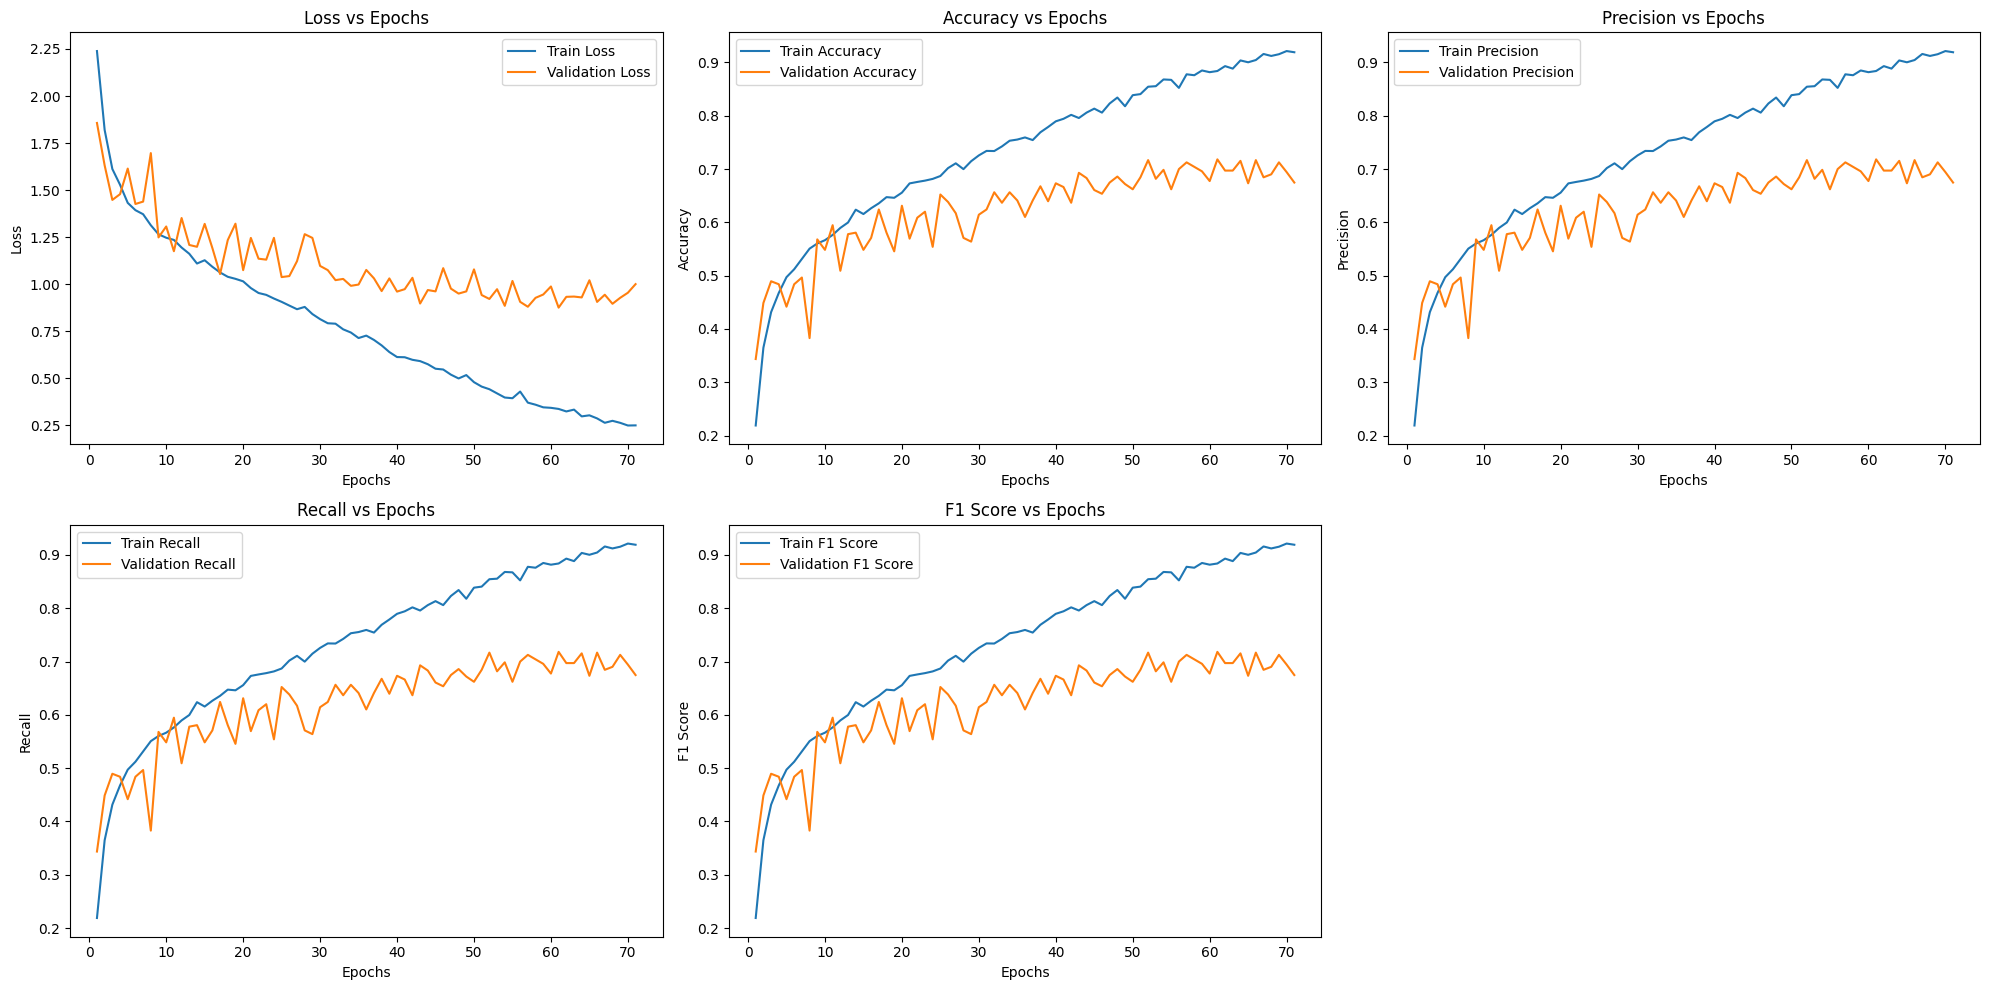

Training complete for mlp_xl
Creating submission file for mlp_xl


Test [TEST|mlp_xl]: 100%|██████████| 13/13 [00:02<00:00,  6.50it/s]


Test results saved to mlp_xl/mlp_xl_test_results.csv




Starting training for cnn_small
Number of parameters: 1,974,156


Epoch 1/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:23<00:00, 10.71it/s, accuracy=31.61%, loss=1.92]


Epoch [1/100], Train Loss: 2.0029, Train Accuracy: 0.3161, Train Precision: 0.3161, Train Recall: 0.3161, Train F1: 0.3161


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.43it/s]


Epoch [1/100], Validation Loss: 1.5963, Validation Accuracy: 0.4628, Validation Precision: 0.4628, Validation Recall: 0.4628, Validation F1: 0.4628
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.59it/s, accuracy=53.75%, loss=1.58]


Epoch [2/100], Train Loss: 1.3710, Train Accuracy: 0.5375, Train Precision: 0.5375, Train Recall: 0.5375, Train F1: 0.5375


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.23it/s]


Epoch [2/100], Validation Loss: 1.1677, Validation Accuracy: 0.6143, Validation Precision: 0.6143, Validation Recall: 0.6143, Validation F1: 0.6143
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s, accuracy=63.36%, loss=0.802]


Epoch [3/100], Train Loss: 1.1043, Train Accuracy: 0.6336, Train Precision: 0.6336, Train Recall: 0.6336, Train F1: 0.6336


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [3/100], Validation Loss: 1.0499, Validation Accuracy: 0.6311, Validation Precision: 0.6311, Validation Recall: 0.6311, Validation F1: 0.6311
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.77it/s, accuracy=67.82%, loss=0.56]


Epoch [4/100], Train Loss: 0.9688, Train Accuracy: 0.6782, Train Precision: 0.6782, Train Recall: 0.6782, Train F1: 0.6782


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00, 11.08it/s]


Epoch [4/100], Validation Loss: 0.9163, Validation Accuracy: 0.6914, Validation Precision: 0.6914, Validation Recall: 0.6914, Validation F1: 0.6914
Saving best model at epoch 4...


Epoch 5/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.82it/s, accuracy=70.94%, loss=0.936]


Epoch [5/100], Train Loss: 0.8624, Train Accuracy: 0.7094, Train Precision: 0.7094, Train Recall: 0.7094, Train F1: 0.7094


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.24it/s]


Epoch [5/100], Validation Loss: 0.8425, Validation Accuracy: 0.7055, Validation Precision: 0.7055, Validation Recall: 0.7055, Validation F1: 0.7055
Saving best model at epoch 5...


Epoch 6/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:22<00:00, 11.02it/s, accuracy=72.93%, loss=0.333]


Epoch [6/100], Train Loss: 0.8036, Train Accuracy: 0.7293, Train Precision: 0.7293, Train Recall: 0.7293, Train F1: 0.7293


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.26it/s]


Epoch [6/100], Validation Loss: 0.8017, Validation Accuracy: 0.7349, Validation Precision: 0.7349, Validation Recall: 0.7349, Validation F1: 0.7349
Saving best model at epoch 6...


Epoch 7/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.34it/s, accuracy=74.81%, loss=1.36]


Epoch [7/100], Train Loss: 0.7563, Train Accuracy: 0.7481, Train Precision: 0.7481, Train Recall: 0.7481, Train F1: 0.7481


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.65it/s]


Epoch [7/100], Validation Loss: 0.7735, Validation Accuracy: 0.7181, Validation Precision: 0.7181, Validation Recall: 0.7181, Validation F1: 0.7181
Patience: 1/10


Epoch 8/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.45it/s, accuracy=77.01%, loss=1.32]


Epoch [8/100], Train Loss: 0.6982, Train Accuracy: 0.7701, Train Precision: 0.7701, Train Recall: 0.7701, Train F1: 0.7701


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.00it/s]


Epoch [8/100], Validation Loss: 0.7280, Validation Accuracy: 0.7433, Validation Precision: 0.7433, Validation Recall: 0.7433, Validation F1: 0.7433
Saving best model at epoch 8...


Epoch 9/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s, accuracy=79.37%, loss=0.385]


Epoch [9/100], Train Loss: 0.6355, Train Accuracy: 0.7937, Train Precision: 0.7937, Train Recall: 0.7937, Train F1: 0.7937


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 11.28it/s]


Epoch [9/100], Validation Loss: 0.7487, Validation Accuracy: 0.7335, Validation Precision: 0.7335, Validation Recall: 0.7335, Validation F1: 0.7335
Patience: 1/10


Epoch 10/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.65it/s, accuracy=78.55%, loss=0.305]


Epoch [10/100], Train Loss: 0.6326, Train Accuracy: 0.7855, Train Precision: 0.7855, Train Recall: 0.7855, Train F1: 0.7855


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.26it/s]


Epoch [10/100], Validation Loss: 0.7290, Validation Accuracy: 0.7546, Validation Precision: 0.7546, Validation Recall: 0.7546, Validation F1: 0.7546
Saving best model at epoch 10...


Epoch 11/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.66it/s, accuracy=80.33%, loss=0.332]


Epoch [11/100], Train Loss: 0.6012, Train Accuracy: 0.8033, Train Precision: 0.8033, Train Recall: 0.8033, Train F1: 0.8033


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 11.78it/s]


Epoch [11/100], Validation Loss: 0.7309, Validation Accuracy: 0.7377, Validation Precision: 0.7377, Validation Recall: 0.7377, Validation F1: 0.7377
Patience: 1/10


Epoch 12/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:22<00:00, 11.19it/s, accuracy=81.69%, loss=0.926]


Epoch [12/100], Train Loss: 0.5632, Train Accuracy: 0.8169, Train Precision: 0.8169, Train Recall: 0.8169, Train F1: 0.8169


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.27it/s]


Epoch [12/100], Validation Loss: 0.6278, Validation Accuracy: 0.7938, Validation Precision: 0.7938, Validation Recall: 0.7938, Validation F1: 0.7938
Saving best model at epoch 12...


Epoch 13/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.57it/s, accuracy=83.13%, loss=1.25]


Epoch [13/100], Train Loss: 0.5433, Train Accuracy: 0.8313, Train Precision: 0.8313, Train Recall: 0.8313, Train F1: 0.8313


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.27it/s]


Epoch [13/100], Validation Loss: 0.6238, Validation Accuracy: 0.7784, Validation Precision: 0.7784, Validation Recall: 0.7784, Validation F1: 0.7784
Patience: 1/10


Epoch 14/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.96it/s, accuracy=82.36%, loss=0.417]


Epoch [14/100], Train Loss: 0.5318, Train Accuracy: 0.8236, Train Precision: 0.8236, Train Recall: 0.8236, Train F1: 0.8236


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.32it/s]


Epoch [14/100], Validation Loss: 0.6188, Validation Accuracy: 0.7798, Validation Precision: 0.7798, Validation Recall: 0.7798, Validation F1: 0.7798
Patience: 2/10


Epoch 15/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.48it/s, accuracy=83.58%, loss=0.816]


Epoch [15/100], Train Loss: 0.5083, Train Accuracy: 0.8358, Train Precision: 0.8358, Train Recall: 0.8358, Train F1: 0.8358


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.28it/s]


Epoch [15/100], Validation Loss: 0.6311, Validation Accuracy: 0.7812, Validation Precision: 0.7812, Validation Recall: 0.7812, Validation F1: 0.7812
Patience: 3/10


Epoch 16/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.73it/s, accuracy=84.00%, loss=0.126]


Epoch [16/100], Train Loss: 0.4804, Train Accuracy: 0.8400, Train Precision: 0.8400, Train Recall: 0.8400, Train F1: 0.8400


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.17it/s]


Epoch [16/100], Validation Loss: 0.5840, Validation Accuracy: 0.7924, Validation Precision: 0.7924, Validation Recall: 0.7924, Validation F1: 0.7924
Patience: 4/10


Epoch 17/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:21<00:00, 11.65it/s, accuracy=83.92%, loss=0.787]


Epoch [17/100], Train Loss: 0.4855, Train Accuracy: 0.8392, Train Precision: 0.8392, Train Recall: 0.8392, Train F1: 0.8392


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00,  9.80it/s]


Epoch [17/100], Validation Loss: 0.5658, Validation Accuracy: 0.8107, Validation Precision: 0.8107, Validation Recall: 0.8107, Validation F1: 0.8107
Saving best model at epoch 17...


Epoch 18/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.69it/s, accuracy=85.31%, loss=2.01]


Epoch [18/100], Train Loss: 0.4663, Train Accuracy: 0.8531, Train Precision: 0.8531, Train Recall: 0.8531, Train F1: 0.8531


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.08it/s]


Epoch [18/100], Validation Loss: 0.5748, Validation Accuracy: 0.7952, Validation Precision: 0.7952, Validation Recall: 0.7952, Validation F1: 0.7952
Patience: 1/10


Epoch 19/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.77it/s, accuracy=85.66%, loss=0.0429]


Epoch [19/100], Train Loss: 0.4454, Train Accuracy: 0.8566, Train Precision: 0.8566, Train Recall: 0.8566, Train F1: 0.8566


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 11.93it/s]


Epoch [19/100], Validation Loss: 0.5573, Validation Accuracy: 0.8022, Validation Precision: 0.8022, Validation Recall: 0.8022, Validation F1: 0.8022
Patience: 2/10


Epoch 20/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.45it/s, accuracy=86.40%, loss=0.451]


Epoch [20/100], Train Loss: 0.4268, Train Accuracy: 0.8640, Train Precision: 0.8640, Train Recall: 0.8640, Train F1: 0.8640


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.26it/s]


Epoch [20/100], Validation Loss: 0.5686, Validation Accuracy: 0.8050, Validation Precision: 0.8050, Validation Recall: 0.8050, Validation F1: 0.8050
Patience: 3/10


Epoch 21/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.77it/s, accuracy=86.15%, loss=1.18]


Epoch [21/100], Train Loss: 0.4231, Train Accuracy: 0.8615, Train Precision: 0.8615, Train Recall: 0.8615, Train F1: 0.8615


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.27it/s]


Epoch [21/100], Validation Loss: 0.5869, Validation Accuracy: 0.7952, Validation Precision: 0.7952, Validation Recall: 0.7952, Validation F1: 0.7952
Patience: 4/10


Epoch 22/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.88it/s, accuracy=87.34%, loss=0.885]


Epoch [22/100], Train Loss: 0.4024, Train Accuracy: 0.8734, Train Precision: 0.8734, Train Recall: 0.8734, Train F1: 0.8734


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.14it/s]


Epoch [22/100], Validation Loss: 0.5558, Validation Accuracy: 0.7994, Validation Precision: 0.7994, Validation Recall: 0.7994, Validation F1: 0.7994
Patience: 5/10


Epoch 23/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:23<00:00, 10.99it/s, accuracy=87.59%, loss=0.661]


Epoch [23/100], Train Loss: 0.3902, Train Accuracy: 0.8759, Train Precision: 0.8759, Train Recall: 0.8759, Train F1: 0.8759


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.10it/s]


Epoch [23/100], Validation Loss: 0.5647, Validation Accuracy: 0.7896, Validation Precision: 0.7896, Validation Recall: 0.7896, Validation F1: 0.7896
Patience: 6/10


Epoch 24/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.77it/s, accuracy=87.52%, loss=0.0581]


Epoch [24/100], Train Loss: 0.3913, Train Accuracy: 0.8752, Train Precision: 0.8752, Train Recall: 0.8752, Train F1: 0.8752


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.13it/s]


Epoch [24/100], Validation Loss: 0.5316, Validation Accuracy: 0.8008, Validation Precision: 0.8008, Validation Recall: 0.8008, Validation F1: 0.8008
Patience: 7/10


Epoch 25/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.82it/s, accuracy=88.31%, loss=0.0324]


Epoch [25/100], Train Loss: 0.3696, Train Accuracy: 0.8831, Train Precision: 0.8831, Train Recall: 0.8831, Train F1: 0.8831


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.17it/s]


Epoch [25/100], Validation Loss: 0.5409, Validation Accuracy: 0.8205, Validation Precision: 0.8205, Validation Recall: 0.8205, Validation F1: 0.8205
Saving best model at epoch 25...


Epoch 26/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.77it/s, accuracy=88.48%, loss=0.197]


Epoch [26/100], Train Loss: 0.3589, Train Accuracy: 0.8848, Train Precision: 0.8848, Train Recall: 0.8848, Train F1: 0.8848


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00, 11.20it/s]


Epoch [26/100], Validation Loss: 0.5818, Validation Accuracy: 0.7826, Validation Precision: 0.7826, Validation Recall: 0.7826, Validation F1: 0.7826
Patience: 1/10


Epoch 27/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 13.07it/s, accuracy=87.74%, loss=0.79]


Epoch [27/100], Train Loss: 0.3661, Train Accuracy: 0.8774, Train Precision: 0.8774, Train Recall: 0.8774, Train F1: 0.8774


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.39it/s]


Epoch [27/100], Validation Loss: 0.5290, Validation Accuracy: 0.8149, Validation Precision: 0.8149, Validation Recall: 0.8149, Validation F1: 0.8149
Patience: 2/10


Epoch 28/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:21<00:00, 12.05it/s, accuracy=88.04%, loss=0.356]


Epoch [28/100], Train Loss: 0.3597, Train Accuracy: 0.8804, Train Precision: 0.8804, Train Recall: 0.8804, Train F1: 0.8804


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00,  9.75it/s]


Epoch [28/100], Validation Loss: 0.5443, Validation Accuracy: 0.8163, Validation Precision: 0.8163, Validation Recall: 0.8163, Validation F1: 0.8163
Patience: 3/10


Epoch 29/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.24it/s, accuracy=88.61%, loss=0.246]


Epoch [29/100], Train Loss: 0.3404, Train Accuracy: 0.8861, Train Precision: 0.8861, Train Recall: 0.8861, Train F1: 0.8861


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 11.83it/s]


Epoch [29/100], Validation Loss: 0.5451, Validation Accuracy: 0.7966, Validation Precision: 0.7966, Validation Recall: 0.7966, Validation F1: 0.7966
Patience: 4/10


Epoch 30/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.26it/s, accuracy=88.80%, loss=0.385]


Epoch [30/100], Train Loss: 0.3333, Train Accuracy: 0.8880, Train Precision: 0.8880, Train Recall: 0.8880, Train F1: 0.8880


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.35it/s]


Epoch [30/100], Validation Loss: 0.5719, Validation Accuracy: 0.8022, Validation Precision: 0.8022, Validation Recall: 0.8022, Validation F1: 0.8022
Patience: 5/10


Epoch 31/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.64it/s, accuracy=89.50%, loss=1.15]


Epoch [31/100], Train Loss: 0.3329, Train Accuracy: 0.8950, Train Precision: 0.8950, Train Recall: 0.8950, Train F1: 0.8950


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [31/100], Validation Loss: 0.5103, Validation Accuracy: 0.8065, Validation Precision: 0.8065, Validation Recall: 0.8065, Validation F1: 0.8065
Patience: 6/10


Epoch 32/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.44it/s, accuracy=89.55%, loss=0.217]


Epoch [32/100], Train Loss: 0.3228, Train Accuracy: 0.8955, Train Precision: 0.8955, Train Recall: 0.8955, Train F1: 0.8955


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [32/100], Validation Loss: 0.5082, Validation Accuracy: 0.8233, Validation Precision: 0.8233, Validation Recall: 0.8233, Validation F1: 0.8233
Saving best model at epoch 32...


Epoch 33/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.54it/s, accuracy=90.07%, loss=0.644]


Epoch [33/100], Train Loss: 0.3180, Train Accuracy: 0.9007, Train Precision: 0.9007, Train Recall: 0.9007, Train F1: 0.9007


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.04it/s]


Epoch [33/100], Validation Loss: 0.5418, Validation Accuracy: 0.8107, Validation Precision: 0.8107, Validation Recall: 0.8107, Validation F1: 0.8107
Patience: 1/10


Epoch 34/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:23<00:00, 10.85it/s, accuracy=90.31%, loss=0.617]


Epoch [34/100], Train Loss: 0.3028, Train Accuracy: 0.9031, Train Precision: 0.9031, Train Recall: 0.9031, Train F1: 0.9031


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


Epoch [34/100], Validation Loss: 0.4923, Validation Accuracy: 0.8247, Validation Precision: 0.8247, Validation Recall: 0.8247, Validation F1: 0.8247
Saving best model at epoch 34...


Epoch 35/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.96it/s, accuracy=90.07%, loss=1.15]


Epoch [35/100], Train Loss: 0.3140, Train Accuracy: 0.9007, Train Precision: 0.9007, Train Recall: 0.9007, Train F1: 0.9007


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00, 11.15it/s]


Epoch [35/100], Validation Loss: 0.5163, Validation Accuracy: 0.8233, Validation Precision: 0.8233, Validation Recall: 0.8233, Validation F1: 0.8233
Patience: 1/10


Epoch 36/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.81it/s, accuracy=90.39%, loss=0.724]


Epoch [36/100], Train Loss: 0.2936, Train Accuracy: 0.9039, Train Precision: 0.9039, Train Recall: 0.9039, Train F1: 0.9039


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.31it/s]


Epoch [36/100], Validation Loss: 0.5243, Validation Accuracy: 0.8093, Validation Precision: 0.8093, Validation Recall: 0.8093, Validation F1: 0.8093
Patience: 2/10


Epoch 37/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.46it/s, accuracy=91.11%, loss=0.0929]


Epoch [37/100], Train Loss: 0.2829, Train Accuracy: 0.9111, Train Precision: 0.9111, Train Recall: 0.9111, Train F1: 0.9111


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.36it/s]


Epoch [37/100], Validation Loss: 0.4927, Validation Accuracy: 0.8247, Validation Precision: 0.8247, Validation Recall: 0.8247, Validation F1: 0.8247
Patience: 3/10


Epoch 38/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.76it/s, accuracy=90.61%, loss=0.858]


Epoch [38/100], Train Loss: 0.2905, Train Accuracy: 0.9061, Train Precision: 0.9061, Train Recall: 0.9061, Train F1: 0.9061


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.55it/s]


Epoch [38/100], Validation Loss: 0.5224, Validation Accuracy: 0.8050, Validation Precision: 0.8050, Validation Recall: 0.8050, Validation F1: 0.8050
Patience: 4/10


Epoch 39/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.48it/s, accuracy=90.29%, loss=0.178]


Epoch [39/100], Train Loss: 0.2847, Train Accuracy: 0.9029, Train Precision: 0.9029, Train Recall: 0.9029, Train F1: 0.9029


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00,  9.07it/s]


Epoch [39/100], Validation Loss: 0.5051, Validation Accuracy: 0.8191, Validation Precision: 0.8191, Validation Recall: 0.8191, Validation F1: 0.8191
Patience: 5/10


Epoch 40/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:21<00:00, 11.81it/s, accuracy=90.83%, loss=0.203]


Epoch [40/100], Train Loss: 0.2740, Train Accuracy: 0.9083, Train Precision: 0.9083, Train Recall: 0.9083, Train F1: 0.9083


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.65it/s]


Epoch [40/100], Validation Loss: 0.5325, Validation Accuracy: 0.8121, Validation Precision: 0.8121, Validation Recall: 0.8121, Validation F1: 0.8121
Patience: 6/10


Epoch 41/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.57it/s, accuracy=91.31%, loss=1.03]


Epoch [41/100], Train Loss: 0.2741, Train Accuracy: 0.9131, Train Precision: 0.9131, Train Recall: 0.9131, Train F1: 0.9131


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [41/100], Validation Loss: 0.4967, Validation Accuracy: 0.8191, Validation Precision: 0.8191, Validation Recall: 0.8191, Validation F1: 0.8191
Patience: 7/10


Epoch 42/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.36it/s, accuracy=91.06%, loss=0.0674]


Epoch [42/100], Train Loss: 0.2672, Train Accuracy: 0.9106, Train Precision: 0.9106, Train Recall: 0.9106, Train F1: 0.9106


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [42/100], Validation Loss: 0.5128, Validation Accuracy: 0.8065, Validation Precision: 0.8065, Validation Recall: 0.8065, Validation F1: 0.8065
Patience: 8/10


Epoch 43/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.45it/s, accuracy=91.78%, loss=0.146]


Epoch [43/100], Train Loss: 0.2541, Train Accuracy: 0.9178, Train Precision: 0.9178, Train Recall: 0.9178, Train F1: 0.9178


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [43/100], Validation Loss: 0.5128, Validation Accuracy: 0.8177, Validation Precision: 0.8177, Validation Recall: 0.8177, Validation F1: 0.8177
Patience: 9/10


Epoch 44/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.81it/s, accuracy=92.40%, loss=0.381]


Epoch [44/100], Train Loss: 0.2457, Train Accuracy: 0.9240, Train Precision: 0.9240, Train Recall: 0.9240, Train F1: 0.9240


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


Epoch [44/100], Validation Loss: 0.4937, Validation Accuracy: 0.8261, Validation Precision: 0.8261, Validation Recall: 0.8261, Validation F1: 0.8261
Saving best model at epoch 44...


Epoch 45/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:23<00:00, 10.94it/s, accuracy=91.63%, loss=0.00308]


Epoch [45/100], Train Loss: 0.2568, Train Accuracy: 0.9163, Train Precision: 0.9163, Train Recall: 0.9163, Train F1: 0.9163


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.28it/s]


Epoch [45/100], Validation Loss: 0.5149, Validation Accuracy: 0.8121, Validation Precision: 0.8121, Validation Recall: 0.8121, Validation F1: 0.8121
Patience: 1/10


Epoch 46/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.60it/s, accuracy=92.44%, loss=0.499]


Epoch [46/100], Train Loss: 0.2436, Train Accuracy: 0.9244, Train Precision: 0.9244, Train Recall: 0.9244, Train F1: 0.9244


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.03it/s]


Epoch [46/100], Validation Loss: 0.5193, Validation Accuracy: 0.8093, Validation Precision: 0.8093, Validation Recall: 0.8093, Validation F1: 0.8093
Patience: 2/10


Epoch 47/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.65it/s, accuracy=92.10%, loss=0.116]


Epoch [47/100], Train Loss: 0.2500, Train Accuracy: 0.9210, Train Precision: 0.9210, Train Recall: 0.9210, Train F1: 0.9210


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.23it/s]


Epoch [47/100], Validation Loss: 0.4860, Validation Accuracy: 0.8191, Validation Precision: 0.8191, Validation Recall: 0.8191, Validation F1: 0.8191
Patience: 3/10


Epoch 48/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.81it/s, accuracy=93.11%, loss=0.0281]


Epoch [48/100], Train Loss: 0.2384, Train Accuracy: 0.9311, Train Precision: 0.9311, Train Recall: 0.9311, Train F1: 0.9311


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00, 10.96it/s]


Epoch [48/100], Validation Loss: 0.4952, Validation Accuracy: 0.8163, Validation Precision: 0.8163, Validation Recall: 0.8163, Validation F1: 0.8163
Patience: 4/10


Epoch 49/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 12.74it/s, accuracy=92.52%, loss=0.5]


Epoch [49/100], Train Loss: 0.2377, Train Accuracy: 0.9252, Train Precision: 0.9252, Train Recall: 0.9252, Train F1: 0.9252


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.42it/s]


Epoch [49/100], Validation Loss: 0.5166, Validation Accuracy: 0.8205, Validation Precision: 0.8205, Validation Recall: 0.8205, Validation F1: 0.8205
Patience: 5/10


Epoch 50/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.57it/s, accuracy=92.47%, loss=0.504]


Epoch [50/100], Train Loss: 0.2316, Train Accuracy: 0.9247, Train Precision: 0.9247, Train Recall: 0.9247, Train F1: 0.9247


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:04<00:00,  9.86it/s]


Epoch [50/100], Validation Loss: 0.5187, Validation Accuracy: 0.8233, Validation Precision: 0.8233, Validation Recall: 0.8233, Validation F1: 0.8233
Patience: 6/10


Epoch 51/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:22<00:00, 11.47it/s, accuracy=93.56%, loss=0.198]


Epoch [51/100], Train Loss: 0.2187, Train Accuracy: 0.9356, Train Precision: 0.9356, Train Recall: 0.9356, Train F1: 0.9356


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.23it/s]


Epoch [51/100], Validation Loss: 0.5065, Validation Accuracy: 0.8177, Validation Precision: 0.8177, Validation Recall: 0.8177, Validation F1: 0.8177
Patience: 7/10


Epoch 52/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 13.21it/s, accuracy=92.49%, loss=1.82]


Epoch [52/100], Train Loss: 0.2414, Train Accuracy: 0.9249, Train Precision: 0.9249, Train Recall: 0.9249, Train F1: 0.9249


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.05it/s]


Epoch [52/100], Validation Loss: 0.4965, Validation Accuracy: 0.8149, Validation Precision: 0.8149, Validation Recall: 0.8149, Validation F1: 0.8149
Patience: 8/10


Epoch 53/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:19<00:00, 13.03it/s, accuracy=92.62%, loss=0.0397]


Epoch [53/100], Train Loss: 0.2261, Train Accuracy: 0.9262, Train Precision: 0.9262, Train Recall: 0.9262, Train F1: 0.9262


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 11.98it/s]


Epoch [53/100], Validation Loss: 0.5049, Validation Accuracy: 0.8135, Validation Precision: 0.8135, Validation Recall: 0.8135, Validation F1: 0.8135
Patience: 9/10


Epoch 54/100 [TRAIN|cnn_small]: 100%|██████████| 253/253 [00:20<00:00, 12.24it/s, accuracy=93.29%, loss=0.0344]


Epoch [54/100], Train Loss: 0.2095, Train Accuracy: 0.9329, Train Precision: 0.9329, Train Recall: 0.9329, Train F1: 0.9329


Evaluation [VALID|cnn_small]: 100%|██████████| 45/45 [00:03<00:00, 12.51it/s]


Epoch [54/100], Validation Loss: 0.4833, Validation Accuracy: 0.8233, Validation Precision: 0.8233, Validation Recall: 0.8233, Validation F1: 0.8233
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to cnn_small/cnn_small_training_metrics.csv


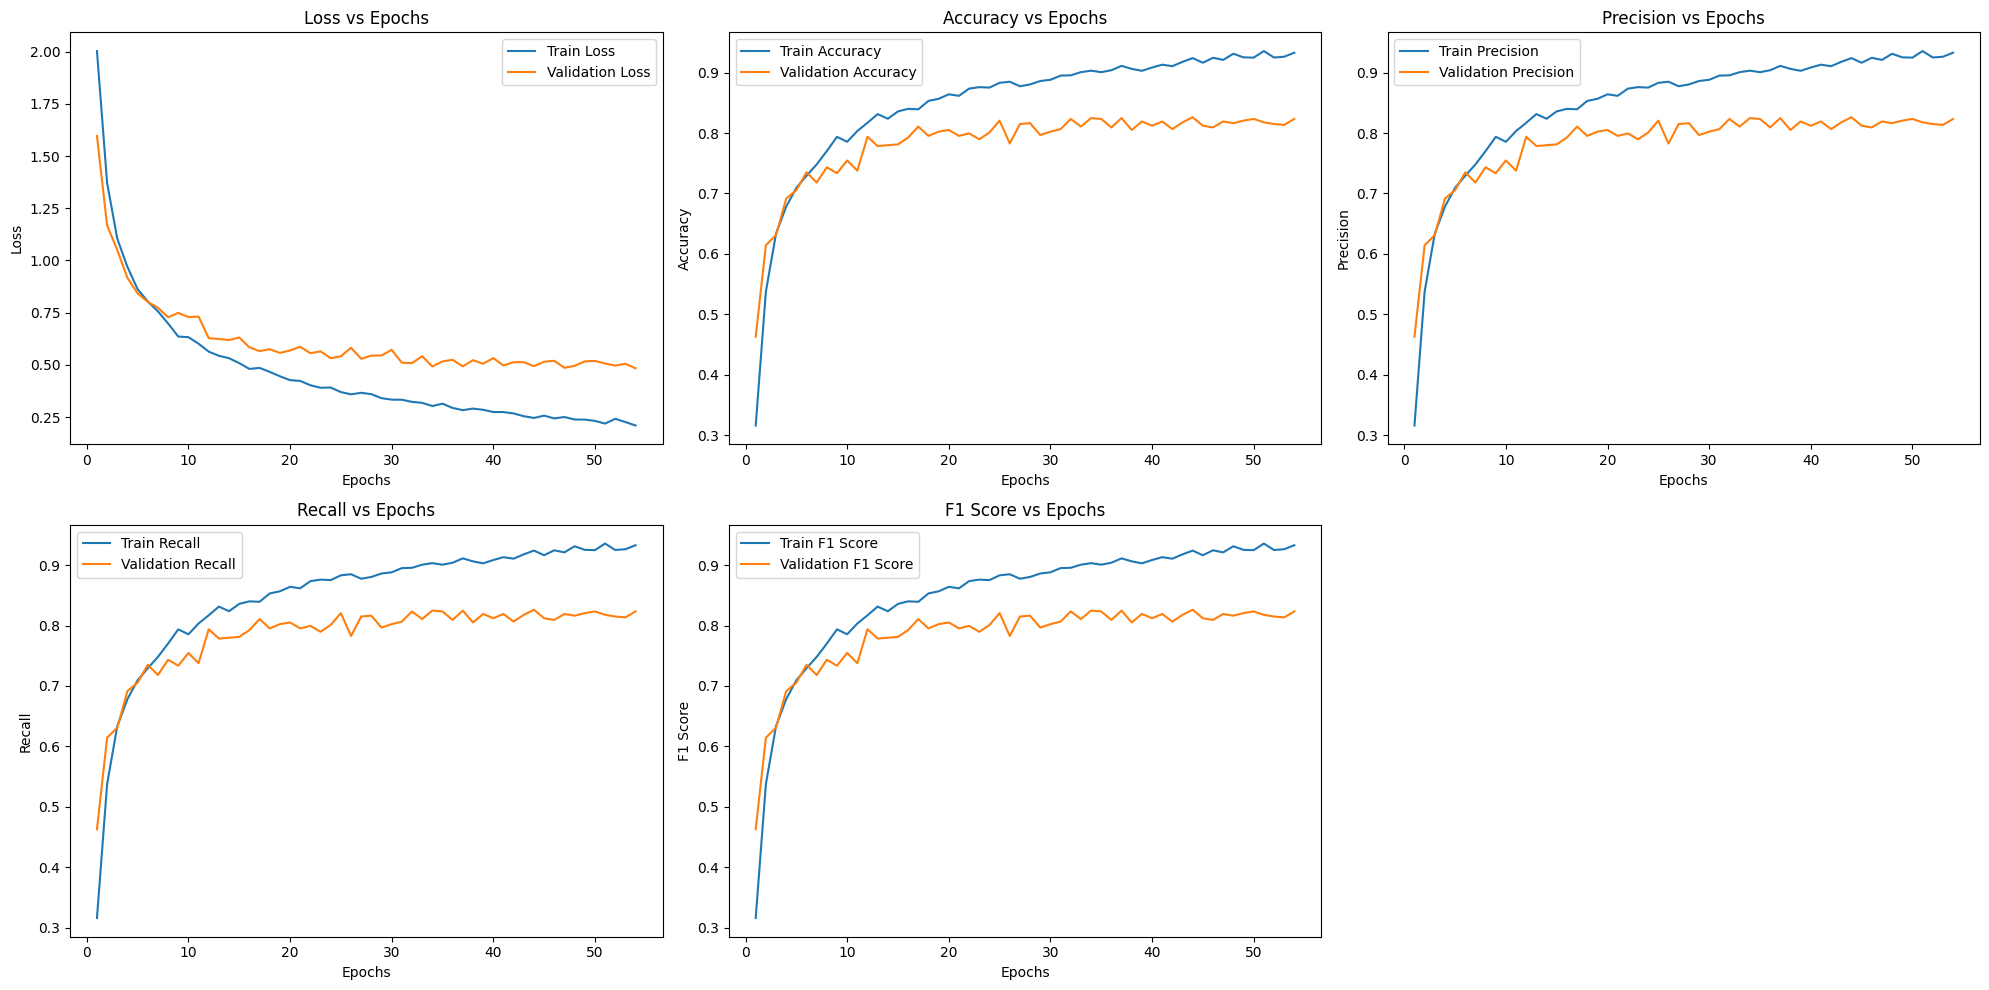

Training complete for cnn_small
Creating submission file for cnn_small


Test [TEST|cnn_small]: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Test results saved to cnn_small/cnn_small_test_results.csv




Starting training for cnn_medium
Number of parameters: 3,789,260


Epoch 1/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.44it/s, accuracy=46.92%, loss=1.82]


Epoch [1/100], Train Loss: 1.6365, Train Accuracy: 0.4692, Train Precision: 0.4692, Train Recall: 0.4692, Train F1: 0.4692


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.35it/s]


Epoch [1/100], Validation Loss: 1.0506, Validation Accuracy: 0.6466, Validation Precision: 0.6466, Validation Recall: 0.6466, Validation F1: 0.6466
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:23<00:00, 10.62it/s, accuracy=70.35%, loss=1.05]


Epoch [2/100], Train Loss: 0.9108, Train Accuracy: 0.7035, Train Precision: 0.7035, Train Recall: 0.7035, Train F1: 0.7035


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.16it/s]


Epoch [2/100], Validation Loss: 0.8797, Validation Accuracy: 0.6942, Validation Precision: 0.6942, Validation Recall: 0.6942, Validation F1: 0.6942
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.12it/s, accuracy=79.12%, loss=1.18]


Epoch [3/100], Train Loss: 0.6526, Train Accuracy: 0.7912, Train Precision: 0.7912, Train Recall: 0.7912, Train F1: 0.7912


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s]


Epoch [3/100], Validation Loss: 0.6096, Validation Accuracy: 0.8107, Validation Precision: 0.8107, Validation Recall: 0.8107, Validation F1: 0.8107
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:19<00:00, 12.83it/s, accuracy=82.24%, loss=0.704]


Epoch [4/100], Train Loss: 0.5387, Train Accuracy: 0.8224, Train Precision: 0.8224, Train Recall: 0.8224, Train F1: 0.8224


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.57it/s]


Epoch [4/100], Validation Loss: 0.5097, Validation Accuracy: 0.8191, Validation Precision: 0.8191, Validation Recall: 0.8191, Validation F1: 0.8191
Saving best model at epoch 4...


Epoch 5/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.09it/s, accuracy=85.06%, loss=0.657]


Epoch [5/100], Train Loss: 0.4596, Train Accuracy: 0.8506, Train Precision: 0.8506, Train Recall: 0.8506, Train F1: 0.8506


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.33it/s]


Epoch [5/100], Validation Loss: 0.4812, Validation Accuracy: 0.8303, Validation Precision: 0.8303, Validation Recall: 0.8303, Validation F1: 0.8303
Saving best model at epoch 5...


Epoch 6/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.34it/s, accuracy=86.87%, loss=0.151]


Epoch [6/100], Train Loss: 0.3955, Train Accuracy: 0.8687, Train Precision: 0.8687, Train Recall: 0.8687, Train F1: 0.8687


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.39it/s]


Epoch [6/100], Validation Loss: 0.4190, Validation Accuracy: 0.8569, Validation Precision: 0.8569, Validation Recall: 0.8569, Validation F1: 0.8569
Saving best model at epoch 6...


Epoch 7/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:21<00:00, 12.01it/s, accuracy=88.36%, loss=0.0912]


Epoch [7/100], Train Loss: 0.3549, Train Accuracy: 0.8836, Train Precision: 0.8836, Train Recall: 0.8836, Train F1: 0.8836


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:04<00:00,  9.95it/s]


Epoch [7/100], Validation Loss: 0.4624, Validation Accuracy: 0.8457, Validation Precision: 0.8457, Validation Recall: 0.8457, Validation F1: 0.8457
Patience: 1/10


Epoch 8/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:22<00:00, 11.42it/s, accuracy=88.85%, loss=0.441]


Epoch [8/100], Train Loss: 0.3280, Train Accuracy: 0.8885, Train Precision: 0.8885, Train Recall: 0.8885, Train F1: 0.8885


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:04<00:00, 10.90it/s]


Epoch [8/100], Validation Loss: 0.4083, Validation Accuracy: 0.8597, Validation Precision: 0.8597, Validation Recall: 0.8597, Validation F1: 0.8597
Saving best model at epoch 8...


Epoch 9/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.47it/s, accuracy=89.67%, loss=0.285]


Epoch [9/100], Train Loss: 0.3034, Train Accuracy: 0.8967, Train Precision: 0.8967, Train Recall: 0.8967, Train F1: 0.8967


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.32it/s]


Epoch [9/100], Validation Loss: 0.4097, Validation Accuracy: 0.8668, Validation Precision: 0.8668, Validation Recall: 0.8668, Validation F1: 0.8668
Saving best model at epoch 9...


Epoch 10/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.56it/s, accuracy=90.17%, loss=0.372]


Epoch [10/100], Train Loss: 0.2737, Train Accuracy: 0.9017, Train Precision: 0.9017, Train Recall: 0.9017, Train F1: 0.9017


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.23it/s]


Epoch [10/100], Validation Loss: 0.3553, Validation Accuracy: 0.8738, Validation Precision: 0.8738, Validation Recall: 0.8738, Validation F1: 0.8738
Saving best model at epoch 10...


Epoch 11/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.37it/s, accuracy=91.23%, loss=0.418]


Epoch [11/100], Train Loss: 0.2603, Train Accuracy: 0.9123, Train Precision: 0.9123, Train Recall: 0.9123, Train F1: 0.9123


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.26it/s]


Epoch [11/100], Validation Loss: 0.3541, Validation Accuracy: 0.8794, Validation Precision: 0.8794, Validation Recall: 0.8794, Validation F1: 0.8794
Saving best model at epoch 11...


Epoch 12/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.24it/s, accuracy=91.13%, loss=0.0522]


Epoch [12/100], Train Loss: 0.2450, Train Accuracy: 0.9113, Train Precision: 0.9113, Train Recall: 0.9113, Train F1: 0.9113


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.37it/s]


Epoch [12/100], Validation Loss: 0.3494, Validation Accuracy: 0.8752, Validation Precision: 0.8752, Validation Recall: 0.8752, Validation F1: 0.8752
Patience: 1/10


Epoch 13/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:23<00:00, 10.73it/s, accuracy=91.43%, loss=0.0489]


Epoch [13/100], Train Loss: 0.2417, Train Accuracy: 0.9143, Train Precision: 0.9143, Train Recall: 0.9143, Train F1: 0.9143


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 11.35it/s]


Epoch [13/100], Validation Loss: 0.3256, Validation Accuracy: 0.8962, Validation Precision: 0.8962, Validation Recall: 0.8962, Validation F1: 0.8962
Saving best model at epoch 13...


Epoch 14/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.38it/s, accuracy=92.12%, loss=0.349]


Epoch [14/100], Train Loss: 0.2196, Train Accuracy: 0.9212, Train Precision: 0.9212, Train Recall: 0.9212, Train F1: 0.9212


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.16it/s]


Epoch [14/100], Validation Loss: 0.3733, Validation Accuracy: 0.8724, Validation Precision: 0.8724, Validation Recall: 0.8724, Validation F1: 0.8724
Patience: 1/10


Epoch 15/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.27it/s, accuracy=92.99%, loss=0.0688]


Epoch [15/100], Train Loss: 0.1974, Train Accuracy: 0.9299, Train Precision: 0.9299, Train Recall: 0.9299, Train F1: 0.9299


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.51it/s]


Epoch [15/100], Validation Loss: 0.3206, Validation Accuracy: 0.8990, Validation Precision: 0.8990, Validation Recall: 0.8990, Validation F1: 0.8990
Saving best model at epoch 15...


Epoch 16/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.40it/s, accuracy=91.92%, loss=0.159]


Epoch [16/100], Train Loss: 0.2158, Train Accuracy: 0.9192, Train Precision: 0.9192, Train Recall: 0.9192, Train F1: 0.9192


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.36it/s]


Epoch [16/100], Validation Loss: 0.4066, Validation Accuracy: 0.8850, Validation Precision: 0.8850, Validation Recall: 0.8850, Validation F1: 0.8850
Patience: 1/10


Epoch 17/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.55it/s, accuracy=93.34%, loss=0.073]


Epoch [17/100], Train Loss: 0.1858, Train Accuracy: 0.9334, Train Precision: 0.9334, Train Recall: 0.9334, Train F1: 0.9334


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:04<00:00, 10.65it/s]


Epoch [17/100], Validation Loss: 0.3380, Validation Accuracy: 0.8808, Validation Precision: 0.8808, Validation Recall: 0.8808, Validation F1: 0.8808
Patience: 2/10


Epoch 18/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.13it/s, accuracy=94.50%, loss=0.0551]


Epoch [18/100], Train Loss: 0.1677, Train Accuracy: 0.9450, Train Precision: 0.9450, Train Recall: 0.9450, Train F1: 0.9450


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:04<00:00,  9.95it/s]


Epoch [18/100], Validation Loss: 0.3668, Validation Accuracy: 0.8892, Validation Precision: 0.8892, Validation Recall: 0.8892, Validation F1: 0.8892
Patience: 3/10


Epoch 19/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:22<00:00, 11.21it/s, accuracy=94.40%, loss=0.0325]


Epoch [19/100], Train Loss: 0.1649, Train Accuracy: 0.9440, Train Precision: 0.9440, Train Recall: 0.9440, Train F1: 0.9440


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.40it/s]


Epoch [19/100], Validation Loss: 0.3253, Validation Accuracy: 0.8906, Validation Precision: 0.8906, Validation Recall: 0.8906, Validation F1: 0.8906
Patience: 4/10


Epoch 20/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.49it/s, accuracy=94.77%, loss=1.02]


Epoch [20/100], Train Loss: 0.1533, Train Accuracy: 0.9477, Train Precision: 0.9477, Train Recall: 0.9477, Train F1: 0.9477


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.27it/s]


Epoch [20/100], Validation Loss: 0.3939, Validation Accuracy: 0.8836, Validation Precision: 0.8836, Validation Recall: 0.8836, Validation F1: 0.8836
Patience: 5/10


Epoch 21/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.57it/s, accuracy=94.08%, loss=0.135]


Epoch [21/100], Train Loss: 0.1583, Train Accuracy: 0.9408, Train Precision: 0.9408, Train Recall: 0.9408, Train F1: 0.9408


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 11.98it/s]


Epoch [21/100], Validation Loss: 0.3034, Validation Accuracy: 0.8976, Validation Precision: 0.8976, Validation Recall: 0.8976, Validation F1: 0.8976
Patience: 6/10


Epoch 22/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:19<00:00, 12.78it/s, accuracy=95.10%, loss=0.0172]


Epoch [22/100], Train Loss: 0.1336, Train Accuracy: 0.9510, Train Precision: 0.9510, Train Recall: 0.9510, Train F1: 0.9510


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 11.71it/s]


Epoch [22/100], Validation Loss: 0.2972, Validation Accuracy: 0.8934, Validation Precision: 0.8934, Validation Recall: 0.8934, Validation F1: 0.8934
Patience: 7/10


Epoch 23/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.46it/s, accuracy=95.22%, loss=0.549]


Epoch [23/100], Train Loss: 0.1360, Train Accuracy: 0.9522, Train Precision: 0.9522, Train Recall: 0.9522, Train F1: 0.9522


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.13it/s]


Epoch [23/100], Validation Loss: 0.3960, Validation Accuracy: 0.8766, Validation Precision: 0.8766, Validation Recall: 0.8766, Validation F1: 0.8766
Patience: 8/10


Epoch 24/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:23<00:00, 10.68it/s, accuracy=95.19%, loss=0.939]


Epoch [24/100], Train Loss: 0.1341, Train Accuracy: 0.9519, Train Precision: 0.9519, Train Recall: 0.9519, Train F1: 0.9519


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 11.87it/s]


Epoch [24/100], Validation Loss: 0.3808, Validation Accuracy: 0.8864, Validation Precision: 0.8864, Validation Recall: 0.8864, Validation F1: 0.8864
Patience: 9/10


Epoch 25/100 [TRAIN|cnn_medium]: 100%|██████████| 253/253 [00:20<00:00, 12.32it/s, accuracy=95.47%, loss=0.00146]


Epoch [25/100], Train Loss: 0.1295, Train Accuracy: 0.9547, Train Precision: 0.9547, Train Recall: 0.9547, Train F1: 0.9547


Evaluation [VALID|cnn_medium]: 100%|██████████| 45/45 [00:03<00:00, 12.39it/s]


Epoch [25/100], Validation Loss: 0.3305, Validation Accuracy: 0.8990, Validation Precision: 0.8990, Validation Recall: 0.8990, Validation F1: 0.8990
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to cnn_medium/cnn_medium_training_metrics.csv


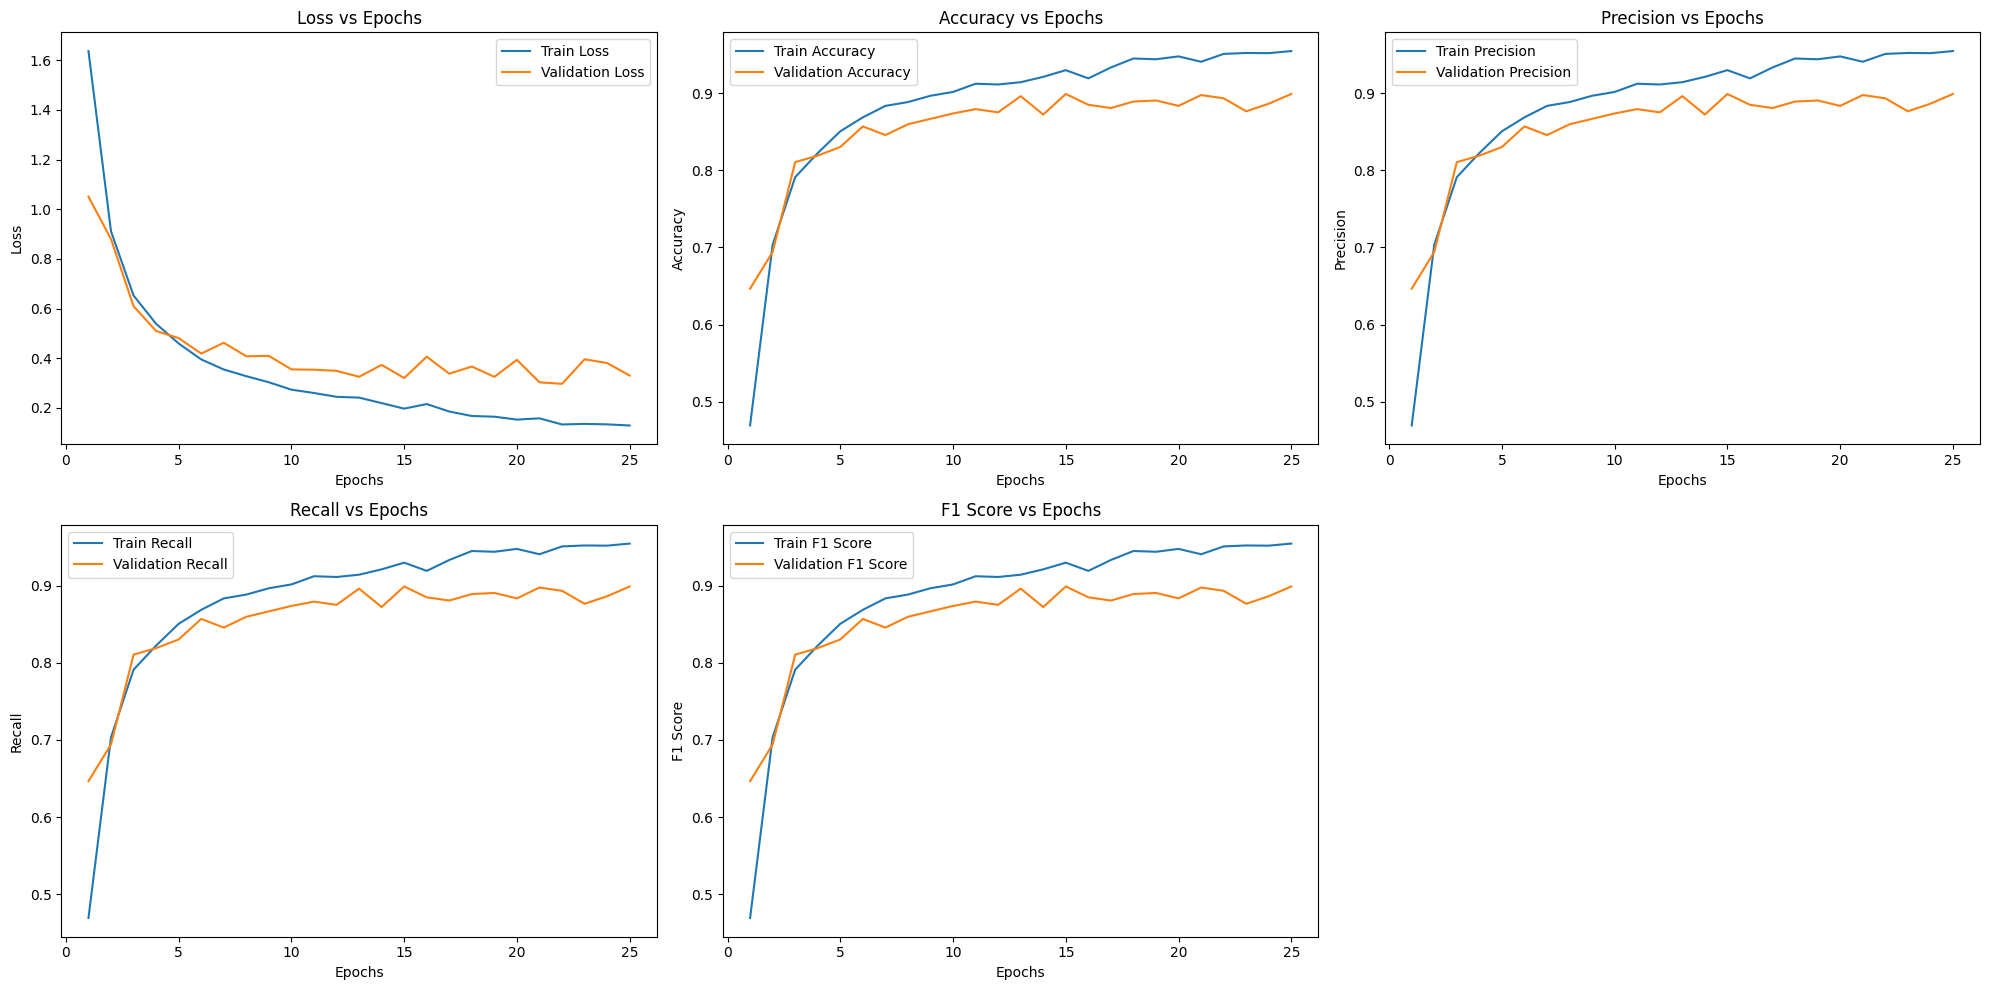

Training complete for cnn_medium
Creating submission file for cnn_medium


Test [TEST|cnn_medium]: 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]


Test results saved to cnn_medium/cnn_medium_test_results.csv




Starting training for cnn_large
Number of parameters: 6,318,860


Epoch 1/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.30it/s, accuracy=46.87%, loss=0.797]


Epoch [1/100], Train Loss: 1.6022, Train Accuracy: 0.4687, Train Precision: 0.4687, Train Recall: 0.4687, Train F1: 0.4687


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.81it/s]


Epoch [1/100], Validation Loss: 1.4911, Validation Accuracy: 0.5259, Validation Precision: 0.5259, Validation Recall: 0.5259, Validation F1: 0.5259
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:19<00:00, 12.87it/s, accuracy=71.44%, loss=1.3]


Epoch [2/100], Train Loss: 0.8527, Train Accuracy: 0.7144, Train Precision: 0.7144, Train Recall: 0.7144, Train F1: 0.7144


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:04<00:00, 11.06it/s]


Epoch [2/100], Validation Loss: 0.6852, Validation Accuracy: 0.7938, Validation Precision: 0.7938, Validation Recall: 0.7938, Validation F1: 0.7938
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:19<00:00, 12.76it/s, accuracy=80.83%, loss=0.157]


Epoch [3/100], Train Loss: 0.5829, Train Accuracy: 0.8083, Train Precision: 0.8083, Train Recall: 0.8083, Train F1: 0.8083


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.01it/s]


Epoch [3/100], Validation Loss: 0.5773, Validation Accuracy: 0.8065, Validation Precision: 0.8065, Validation Recall: 0.8065, Validation F1: 0.8065
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:21<00:00, 11.58it/s, accuracy=84.52%, loss=1.22]


Epoch [4/100], Train Loss: 0.4601, Train Accuracy: 0.8452, Train Precision: 0.8452, Train Recall: 0.8452, Train F1: 0.8452


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:04<00:00,  9.81it/s]


Epoch [4/100], Validation Loss: 0.4365, Validation Accuracy: 0.8626, Validation Precision: 0.8626, Validation Recall: 0.8626, Validation F1: 0.8626
Saving best model at epoch 4...


Epoch 5/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:21<00:00, 11.62it/s, accuracy=86.25%, loss=0.999]


Epoch [5/100], Train Loss: 0.3952, Train Accuracy: 0.8625, Train Precision: 0.8625, Train Recall: 0.8625, Train F1: 0.8625


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.07it/s]


Epoch [5/100], Validation Loss: 0.4652, Validation Accuracy: 0.8373, Validation Precision: 0.8373, Validation Recall: 0.8373, Validation F1: 0.8373
Patience: 1/10


Epoch 6/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.13it/s, accuracy=87.79%, loss=0.859]


Epoch [6/100], Train Loss: 0.3626, Train Accuracy: 0.8779, Train Precision: 0.8779, Train Recall: 0.8779, Train F1: 0.8779


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.84it/s]


Epoch [6/100], Validation Loss: 0.3743, Validation Accuracy: 0.8822, Validation Precision: 0.8822, Validation Recall: 0.8822, Validation F1: 0.8822
Saving best model at epoch 6...


Epoch 7/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.40it/s, accuracy=89.08%, loss=0.189]


Epoch [7/100], Train Loss: 0.3054, Train Accuracy: 0.8908, Train Precision: 0.8908, Train Recall: 0.8908, Train F1: 0.8908


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:04<00:00, 10.87it/s]


Epoch [7/100], Validation Loss: 0.3828, Validation Accuracy: 0.8822, Validation Precision: 0.8822, Validation Recall: 0.8822, Validation F1: 0.8822
Patience: 1/10


Epoch 8/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.33it/s, accuracy=89.72%, loss=0.972]


Epoch [8/100], Train Loss: 0.2875, Train Accuracy: 0.8972, Train Precision: 0.8972, Train Recall: 0.8972, Train F1: 0.8972


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.03it/s]


Epoch [8/100], Validation Loss: 0.3349, Validation Accuracy: 0.9046, Validation Precision: 0.9046, Validation Recall: 0.9046, Validation F1: 0.9046
Saving best model at epoch 8...


Epoch 9/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.35it/s, accuracy=90.96%, loss=0.158]


Epoch [9/100], Train Loss: 0.2529, Train Accuracy: 0.9096, Train Precision: 0.9096, Train Recall: 0.9096, Train F1: 0.9096


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.85it/s]


Epoch [9/100], Validation Loss: 0.3778, Validation Accuracy: 0.8794, Validation Precision: 0.8794, Validation Recall: 0.8794, Validation F1: 0.8794
Patience: 1/10


Epoch 10/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:24<00:00, 10.41it/s, accuracy=91.23%, loss=1.01]


Epoch [10/100], Train Loss: 0.2518, Train Accuracy: 0.9123, Train Precision: 0.9123, Train Recall: 0.9123, Train F1: 0.9123


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.06it/s]


Epoch [10/100], Validation Loss: 0.3104, Validation Accuracy: 0.9074, Validation Precision: 0.9074, Validation Recall: 0.9074, Validation F1: 0.9074
Saving best model at epoch 10...


Epoch 11/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.59it/s, accuracy=91.73%, loss=0.135]


Epoch [11/100], Train Loss: 0.2367, Train Accuracy: 0.9173, Train Precision: 0.9173, Train Recall: 0.9173, Train F1: 0.9173


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.96it/s]


Epoch [11/100], Validation Loss: 0.3162, Validation Accuracy: 0.8892, Validation Precision: 0.8892, Validation Recall: 0.8892, Validation F1: 0.8892
Patience: 1/10


Epoch 12/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:19<00:00, 12.70it/s, accuracy=92.15%, loss=0.128]


Epoch [12/100], Train Loss: 0.2141, Train Accuracy: 0.9215, Train Precision: 0.9215, Train Recall: 0.9215, Train F1: 0.9215


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.82it/s]


Epoch [12/100], Validation Loss: 0.3206, Validation Accuracy: 0.8948, Validation Precision: 0.8948, Validation Recall: 0.8948, Validation F1: 0.8948
Patience: 2/10


Epoch 13/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.54it/s, accuracy=92.94%, loss=0.503]


Epoch [13/100], Train Loss: 0.1948, Train Accuracy: 0.9294, Train Precision: 0.9294, Train Recall: 0.9294, Train F1: 0.9294


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.68it/s]


Epoch [13/100], Validation Loss: 0.2750, Validation Accuracy: 0.9074, Validation Precision: 0.9074, Validation Recall: 0.9074, Validation F1: 0.9074
Patience: 3/10


Epoch 14/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.34it/s, accuracy=93.46%, loss=0.216]


Epoch [14/100], Train Loss: 0.1853, Train Accuracy: 0.9346, Train Precision: 0.9346, Train Recall: 0.9346, Train F1: 0.9346


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.20it/s]


Epoch [14/100], Validation Loss: 0.3619, Validation Accuracy: 0.8892, Validation Precision: 0.8892, Validation Recall: 0.8892, Validation F1: 0.8892
Patience: 4/10


Epoch 15/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:21<00:00, 11.72it/s, accuracy=93.71%, loss=0.0173]


Epoch [15/100], Train Loss: 0.1646, Train Accuracy: 0.9371, Train Precision: 0.9371, Train Recall: 0.9371, Train F1: 0.9371


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:04<00:00,  9.72it/s]


Epoch [15/100], Validation Loss: 0.2871, Validation Accuracy: 0.9088, Validation Precision: 0.9088, Validation Recall: 0.9088, Validation F1: 0.9088
Saving best model at epoch 15...


Epoch 16/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:22<00:00, 11.34it/s, accuracy=94.30%, loss=0.127]


Epoch [16/100], Train Loss: 0.1638, Train Accuracy: 0.9430, Train Precision: 0.9430, Train Recall: 0.9430, Train F1: 0.9430


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.02it/s]


Epoch [16/100], Validation Loss: 0.4021, Validation Accuracy: 0.8766, Validation Precision: 0.8766, Validation Recall: 0.8766, Validation F1: 0.8766
Patience: 1/10


Epoch 17/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.55it/s, accuracy=94.23%, loss=0.00427]


Epoch [17/100], Train Loss: 0.1501, Train Accuracy: 0.9423, Train Precision: 0.9423, Train Recall: 0.9423, Train F1: 0.9423


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.82it/s]


Epoch [17/100], Validation Loss: 0.3286, Validation Accuracy: 0.9060, Validation Precision: 0.9060, Validation Recall: 0.9060, Validation F1: 0.9060
Patience: 2/10


Epoch 18/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.55it/s, accuracy=94.95%, loss=0.758]


Epoch [18/100], Train Loss: 0.1445, Train Accuracy: 0.9495, Train Precision: 0.9495, Train Recall: 0.9495, Train F1: 0.9495


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.98it/s]


Epoch [18/100], Validation Loss: 0.3905, Validation Accuracy: 0.8878, Validation Precision: 0.8878, Validation Recall: 0.8878, Validation F1: 0.8878
Patience: 3/10


Epoch 19/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.13it/s, accuracy=94.62%, loss=0.184]


Epoch [19/100], Train Loss: 0.1500, Train Accuracy: 0.9462, Train Precision: 0.9462, Train Recall: 0.9462, Train F1: 0.9462


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.77it/s]


Epoch [19/100], Validation Loss: 0.3986, Validation Accuracy: 0.8864, Validation Precision: 0.8864, Validation Recall: 0.8864, Validation F1: 0.8864
Patience: 4/10


Epoch 20/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.36it/s, accuracy=94.82%, loss=0.0494]


Epoch [20/100], Train Loss: 0.1315, Train Accuracy: 0.9482, Train Precision: 0.9482, Train Recall: 0.9482, Train F1: 0.9482


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.12it/s]


Epoch [20/100], Validation Loss: 0.2942, Validation Accuracy: 0.9229, Validation Precision: 0.9229, Validation Recall: 0.9229, Validation F1: 0.9229
Saving best model at epoch 20...


Epoch 21/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:23<00:00, 10.55it/s, accuracy=95.59%, loss=0.139]


Epoch [21/100], Train Loss: 0.1172, Train Accuracy: 0.9559, Train Precision: 0.9559, Train Recall: 0.9559, Train F1: 0.9559


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.68it/s]


Epoch [21/100], Validation Loss: 0.3928, Validation Accuracy: 0.8864, Validation Precision: 0.8864, Validation Recall: 0.8864, Validation F1: 0.8864
Patience: 1/10


Epoch 22/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.57it/s, accuracy=95.44%, loss=0.439]


Epoch [22/100], Train Loss: 0.1220, Train Accuracy: 0.9544, Train Precision: 0.9544, Train Recall: 0.9544, Train F1: 0.9544


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.00it/s]


Epoch [22/100], Validation Loss: 0.3102, Validation Accuracy: 0.9060, Validation Precision: 0.9060, Validation Recall: 0.9060, Validation F1: 0.9060
Patience: 2/10


Epoch 23/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.08it/s, accuracy=95.91%, loss=0.133]


Epoch [23/100], Train Loss: 0.1145, Train Accuracy: 0.9591, Train Precision: 0.9591, Train Recall: 0.9591, Train F1: 0.9591


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.79it/s]


Epoch [23/100], Validation Loss: 0.2733, Validation Accuracy: 0.9158, Validation Precision: 0.9158, Validation Recall: 0.9158, Validation F1: 0.9158
Patience: 3/10


Epoch 24/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.60it/s, accuracy=96.21%, loss=0.461]


Epoch [24/100], Train Loss: 0.1015, Train Accuracy: 0.9621, Train Precision: 0.9621, Train Recall: 0.9621, Train F1: 0.9621


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.14it/s]


Epoch [24/100], Validation Loss: 0.3154, Validation Accuracy: 0.9144, Validation Precision: 0.9144, Validation Recall: 0.9144, Validation F1: 0.9144
Patience: 4/10


Epoch 25/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.41it/s, accuracy=95.94%, loss=0.0363]


Epoch [25/100], Train Loss: 0.1123, Train Accuracy: 0.9594, Train Precision: 0.9594, Train Recall: 0.9594, Train F1: 0.9594


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.85it/s]


Epoch [25/100], Validation Loss: 0.2864, Validation Accuracy: 0.9229, Validation Precision: 0.9229, Validation Recall: 0.9229, Validation F1: 0.9229
Patience: 5/10


Epoch 26/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.29it/s, accuracy=96.76%, loss=0.0179]


Epoch [26/100], Train Loss: 0.0917, Train Accuracy: 0.9676, Train Precision: 0.9676, Train Recall: 0.9676, Train F1: 0.9676


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:04<00:00,  9.62it/s]


Epoch [26/100], Validation Loss: 0.3279, Validation Accuracy: 0.9130, Validation Precision: 0.9130, Validation Recall: 0.9130, Validation F1: 0.9130
Patience: 6/10


Epoch 27/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:22<00:00, 11.20it/s, accuracy=95.84%, loss=0.697]


Epoch [27/100], Train Loss: 0.1044, Train Accuracy: 0.9584, Train Precision: 0.9584, Train Recall: 0.9584, Train F1: 0.9584


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.86it/s]


Epoch [27/100], Validation Loss: 0.4024, Validation Accuracy: 0.8934, Validation Precision: 0.8934, Validation Recall: 0.8934, Validation F1: 0.8934
Patience: 7/10


Epoch 28/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.36it/s, accuracy=97.05%, loss=0.00873]


Epoch [28/100], Train Loss: 0.0823, Train Accuracy: 0.9705, Train Precision: 0.9705, Train Recall: 0.9705, Train F1: 0.9705


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.89it/s]


Epoch [28/100], Validation Loss: 0.2896, Validation Accuracy: 0.9215, Validation Precision: 0.9215, Validation Recall: 0.9215, Validation F1: 0.9215
Patience: 8/10


Epoch 29/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.45it/s, accuracy=97.32%, loss=0.0402]


Epoch [29/100], Train Loss: 0.0770, Train Accuracy: 0.9732, Train Precision: 0.9732, Train Recall: 0.9732, Train F1: 0.9732


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 11.85it/s]


Epoch [29/100], Validation Loss: 0.3376, Validation Accuracy: 0.9173, Validation Precision: 0.9173, Validation Recall: 0.9173, Validation F1: 0.9173
Patience: 9/10


Epoch 30/100 [TRAIN|cnn_large]: 100%|██████████| 253/253 [00:20<00:00, 12.41it/s, accuracy=96.76%, loss=0.00509]


Epoch [30/100], Train Loss: 0.0876, Train Accuracy: 0.9676, Train Precision: 0.9676, Train Recall: 0.9676, Train F1: 0.9676


Evaluation [VALID|cnn_large]: 100%|██████████| 45/45 [00:03<00:00, 12.02it/s]


Epoch [30/100], Validation Loss: 0.3473, Validation Accuracy: 0.9102, Validation Precision: 0.9102, Validation Recall: 0.9102, Validation F1: 0.9102
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to cnn_large/cnn_large_training_metrics.csv


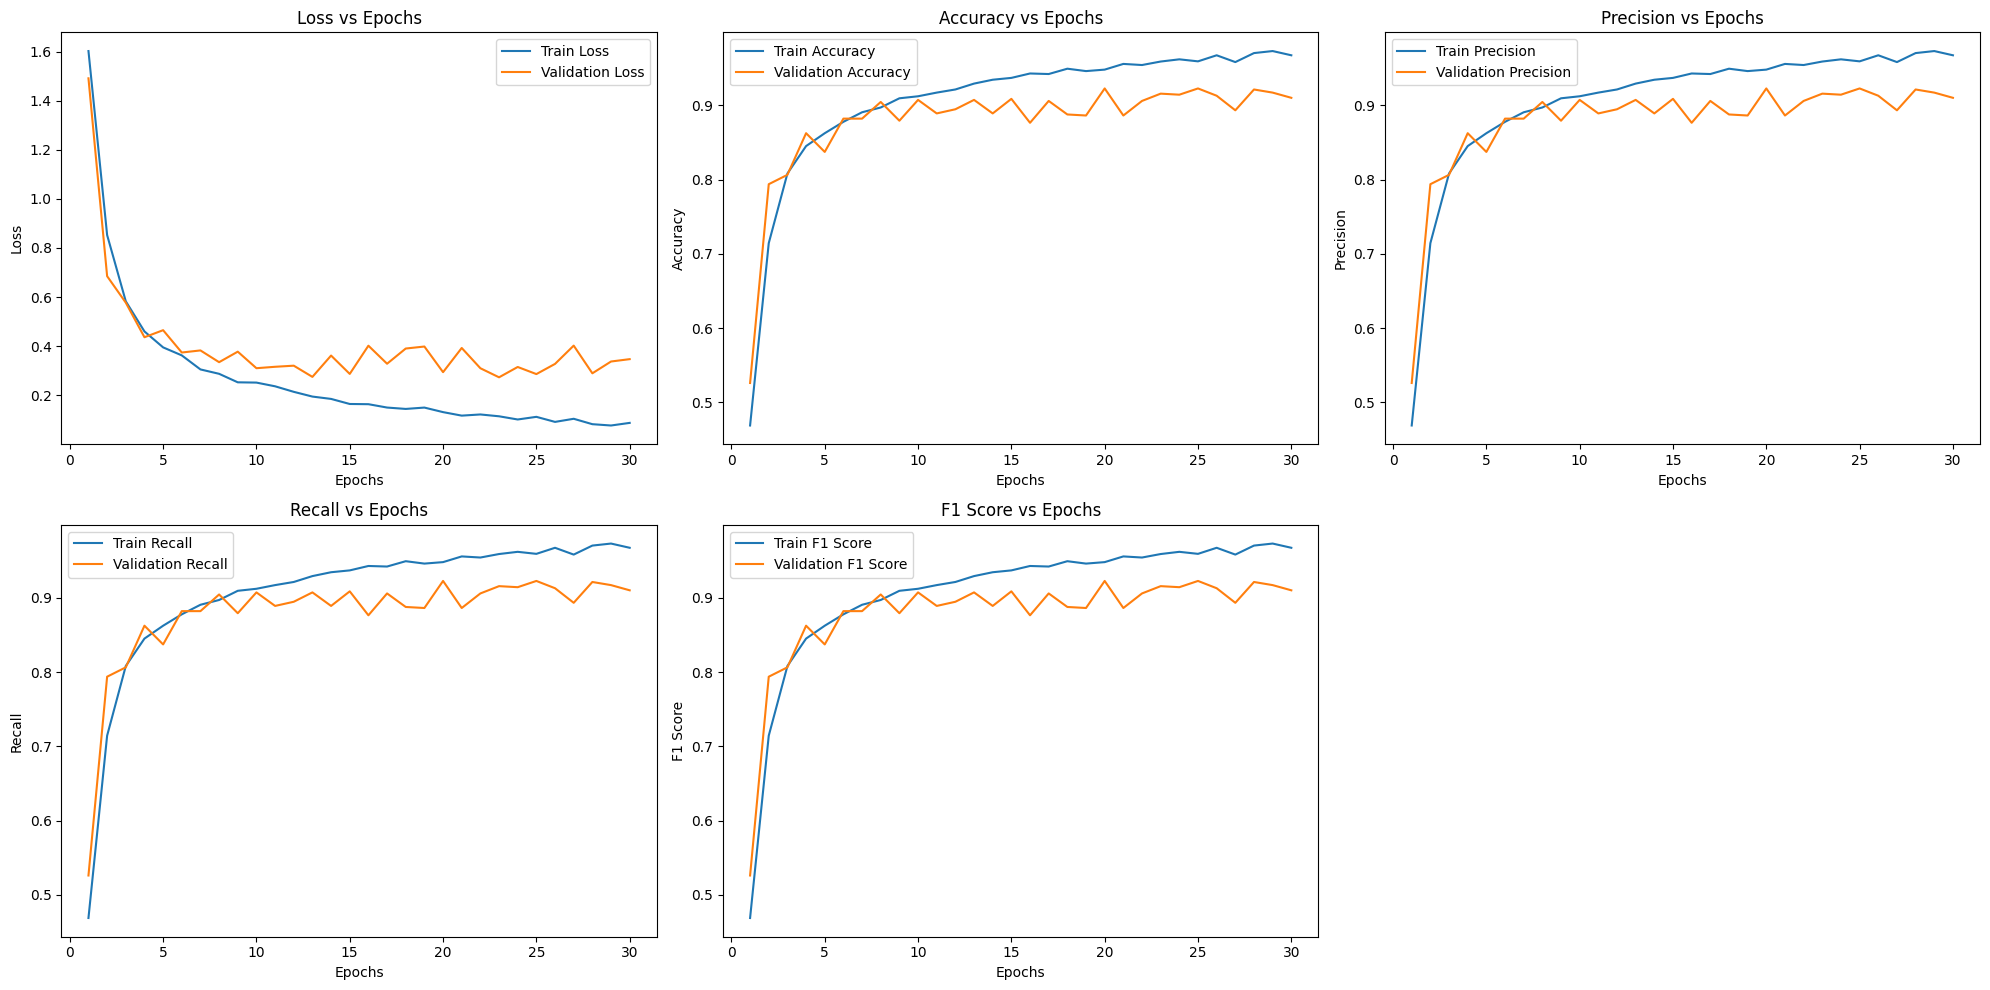

Training complete for cnn_large
Creating submission file for cnn_large


Test [TEST|cnn_large]: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Test results saved to cnn_large/cnn_large_test_results.csv




Starting training for cnn_extra_large
Number of parameters: 30,346,060


Epoch 1/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.86it/s, accuracy=40.85%, loss=0.824]


Epoch [1/100], Train Loss: 1.7008, Train Accuracy: 0.4085, Train Precision: 0.4085, Train Recall: 0.4085, Train F1: 0.4085


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.41it/s]


Epoch [1/100], Validation Loss: 1.3615, Validation Accuracy: 0.5624, Validation Precision: 0.5624, Validation Recall: 0.5624, Validation F1: 0.5624
Saving best model at epoch 1...


Epoch 2/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:27<00:00,  9.27it/s, accuracy=64.33%, loss=1.55]


Epoch [2/100], Train Loss: 1.0390, Train Accuracy: 0.6433, Train Precision: 0.6433, Train Recall: 0.6433, Train F1: 0.6433


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.77it/s]


Epoch [2/100], Validation Loss: 0.7355, Validation Accuracy: 0.7616, Validation Precision: 0.7616, Validation Recall: 0.7616, Validation F1: 0.7616
Saving best model at epoch 2...


Epoch 3/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.81it/s, accuracy=75.65%, loss=0.781]


Epoch [3/100], Train Loss: 0.7382, Train Accuracy: 0.7565, Train Precision: 0.7565, Train Recall: 0.7565, Train F1: 0.7565


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:04<00:00, 10.76it/s]


Epoch [3/100], Validation Loss: 0.4951, Validation Accuracy: 0.8275, Validation Precision: 0.8275, Validation Recall: 0.8275, Validation F1: 0.8275
Saving best model at epoch 3...


Epoch 4/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.67it/s, accuracy=80.28%, loss=0.777]


Epoch [4/100], Train Loss: 0.5527, Train Accuracy: 0.8028, Train Precision: 0.8028, Train Recall: 0.8028, Train F1: 0.8028


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.75it/s]


Epoch [4/100], Validation Loss: 0.6468, Validation Accuracy: 0.7882, Validation Precision: 0.7882, Validation Recall: 0.7882, Validation F1: 0.7882
Patience: 1/10


Epoch 5/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.60it/s, accuracy=84.00%, loss=0.721]


Epoch [5/100], Train Loss: 0.4672, Train Accuracy: 0.8400, Train Precision: 0.8400, Train Recall: 0.8400, Train F1: 0.8400


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.61it/s]


Epoch [5/100], Validation Loss: 0.4588, Validation Accuracy: 0.8387, Validation Precision: 0.8387, Validation Recall: 0.8387, Validation F1: 0.8387
Saving best model at epoch 5...


Epoch 6/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.46it/s, accuracy=84.82%, loss=0.0626]


Epoch [6/100], Train Loss: 0.4293, Train Accuracy: 0.8482, Train Precision: 0.8482, Train Recall: 0.8482, Train F1: 0.8482


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:04<00:00,  9.26it/s]


Epoch [6/100], Validation Loss: 0.4517, Validation Accuracy: 0.8499, Validation Precision: 0.8499, Validation Recall: 0.8499, Validation F1: 0.8499
Saving best model at epoch 6...


Epoch 7/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:26<00:00,  9.55it/s, accuracy=87.27%, loss=0.247]


Epoch [7/100], Train Loss: 0.3667, Train Accuracy: 0.8727, Train Precision: 0.8727, Train Recall: 0.8727, Train F1: 0.8727


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s]


Epoch [7/100], Validation Loss: 0.3719, Validation Accuracy: 0.8583, Validation Precision: 0.8583, Validation Recall: 0.8583, Validation F1: 0.8583
Saving best model at epoch 7...


Epoch 8/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.52it/s, accuracy=87.59%, loss=0.866]


Epoch [8/100], Train Loss: 0.3582, Train Accuracy: 0.8759, Train Precision: 0.8759, Train Recall: 0.8759, Train F1: 0.8759


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s]


Epoch [8/100], Validation Loss: 0.3411, Validation Accuracy: 0.8597, Validation Precision: 0.8597, Validation Recall: 0.8597, Validation F1: 0.8597
Saving best model at epoch 8...


Epoch 9/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.51it/s, accuracy=89.20%, loss=0.0496]


Epoch [9/100], Train Loss: 0.3044, Train Accuracy: 0.8920, Train Precision: 0.8920, Train Recall: 0.8920, Train F1: 0.8920


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.91it/s]


Epoch [9/100], Validation Loss: 0.2622, Validation Accuracy: 0.9144, Validation Precision: 0.9144, Validation Recall: 0.9144, Validation F1: 0.9144
Saving best model at epoch 9...


Epoch 10/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.49it/s, accuracy=89.08%, loss=0.0994]


Epoch [10/100], Train Loss: 0.2962, Train Accuracy: 0.8908, Train Precision: 0.8908, Train Recall: 0.8908, Train F1: 0.8908


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.61it/s]


Epoch [10/100], Validation Loss: 0.3303, Validation Accuracy: 0.8738, Validation Precision: 0.8738, Validation Recall: 0.8738, Validation F1: 0.8738
Patience: 1/10


Epoch 11/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.23it/s, accuracy=90.09%, loss=0.0436]


Epoch [11/100], Train Loss: 0.2730, Train Accuracy: 0.9009, Train Precision: 0.9009, Train Recall: 0.9009, Train F1: 0.9009


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:04<00:00,  9.42it/s]


Epoch [11/100], Validation Loss: 0.3549, Validation Accuracy: 0.8710, Validation Precision: 0.8710, Validation Recall: 0.8710, Validation F1: 0.8710
Patience: 2/10


Epoch 12/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:25<00:00,  9.86it/s, accuracy=90.54%, loss=0.00817]


Epoch [12/100], Train Loss: 0.2611, Train Accuracy: 0.9054, Train Precision: 0.9054, Train Recall: 0.9054, Train F1: 0.9054


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.78it/s]


Epoch [12/100], Validation Loss: 0.3212, Validation Accuracy: 0.8850, Validation Precision: 0.8850, Validation Recall: 0.8850, Validation F1: 0.8850
Patience: 3/10


Epoch 13/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.46it/s, accuracy=91.03%, loss=0.0834]


Epoch [13/100], Train Loss: 0.2409, Train Accuracy: 0.9103, Train Precision: 0.9103, Train Recall: 0.9103, Train F1: 0.9103


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.54it/s]


Epoch [13/100], Validation Loss: 0.2650, Validation Accuracy: 0.9088, Validation Precision: 0.9088, Validation Recall: 0.9088, Validation F1: 0.9088
Patience: 4/10


Epoch 14/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.72it/s, accuracy=91.01%, loss=0.199]


Epoch [14/100], Train Loss: 0.2356, Train Accuracy: 0.9101, Train Precision: 0.9101, Train Recall: 0.9101, Train F1: 0.9101


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:04<00:00, 10.65it/s]


Epoch [14/100], Validation Loss: 0.2722, Validation Accuracy: 0.8948, Validation Precision: 0.8948, Validation Recall: 0.8948, Validation F1: 0.8948
Patience: 5/10


Epoch 15/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.84it/s, accuracy=92.79%, loss=0.101]


Epoch [15/100], Train Loss: 0.1959, Train Accuracy: 0.9279, Train Precision: 0.9279, Train Recall: 0.9279, Train F1: 0.9279


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.59it/s]


Epoch [15/100], Validation Loss: 0.4179, Validation Accuracy: 0.8640, Validation Precision: 0.8640, Validation Recall: 0.8640, Validation F1: 0.8640
Patience: 6/10


Epoch 16/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:25<00:00, 10.03it/s, accuracy=92.97%, loss=0.613]


Epoch [16/100], Train Loss: 0.2071, Train Accuracy: 0.9297, Train Precision: 0.9297, Train Recall: 0.9297, Train F1: 0.9297


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:04<00:00,  9.35it/s]


Epoch [16/100], Validation Loss: 0.2870, Validation Accuracy: 0.8906, Validation Precision: 0.8906, Validation Recall: 0.8906, Validation F1: 0.8906
Patience: 7/10


Epoch 17/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:25<00:00,  9.91it/s, accuracy=92.35%, loss=0.189]


Epoch [17/100], Train Loss: 0.2029, Train Accuracy: 0.9235, Train Precision: 0.9235, Train Recall: 0.9235, Train F1: 0.9235


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.83it/s]


Epoch [17/100], Validation Loss: 0.3032, Validation Accuracy: 0.9046, Validation Precision: 0.9046, Validation Recall: 0.9046, Validation F1: 0.9046
Patience: 8/10


Epoch 18/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:23<00:00, 10.57it/s, accuracy=93.63%, loss=0.107]


Epoch [18/100], Train Loss: 0.1749, Train Accuracy: 0.9363, Train Precision: 0.9363, Train Recall: 0.9363, Train F1: 0.9363


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.65it/s]


Epoch [18/100], Validation Loss: 0.2439, Validation Accuracy: 0.9018, Validation Precision: 0.9018, Validation Recall: 0.9018, Validation F1: 0.9018
Patience: 9/10


Epoch 19/100 [TRAIN|cnn_extra_large]: 100%|██████████| 253/253 [00:24<00:00, 10.53it/s, accuracy=93.73%, loss=0.0424]


Epoch [19/100], Train Loss: 0.1818, Train Accuracy: 0.9373, Train Precision: 0.9373, Train Recall: 0.9373, Train F1: 0.9373


Evaluation [VALID|cnn_extra_large]: 100%|██████████| 45/45 [00:03<00:00, 11.67it/s]


Epoch [19/100], Validation Loss: 0.3272, Validation Accuracy: 0.8892, Validation Precision: 0.8892, Validation Recall: 0.8892, Validation F1: 0.8892
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to cnn_extra_large/cnn_extra_large_training_metrics.csv


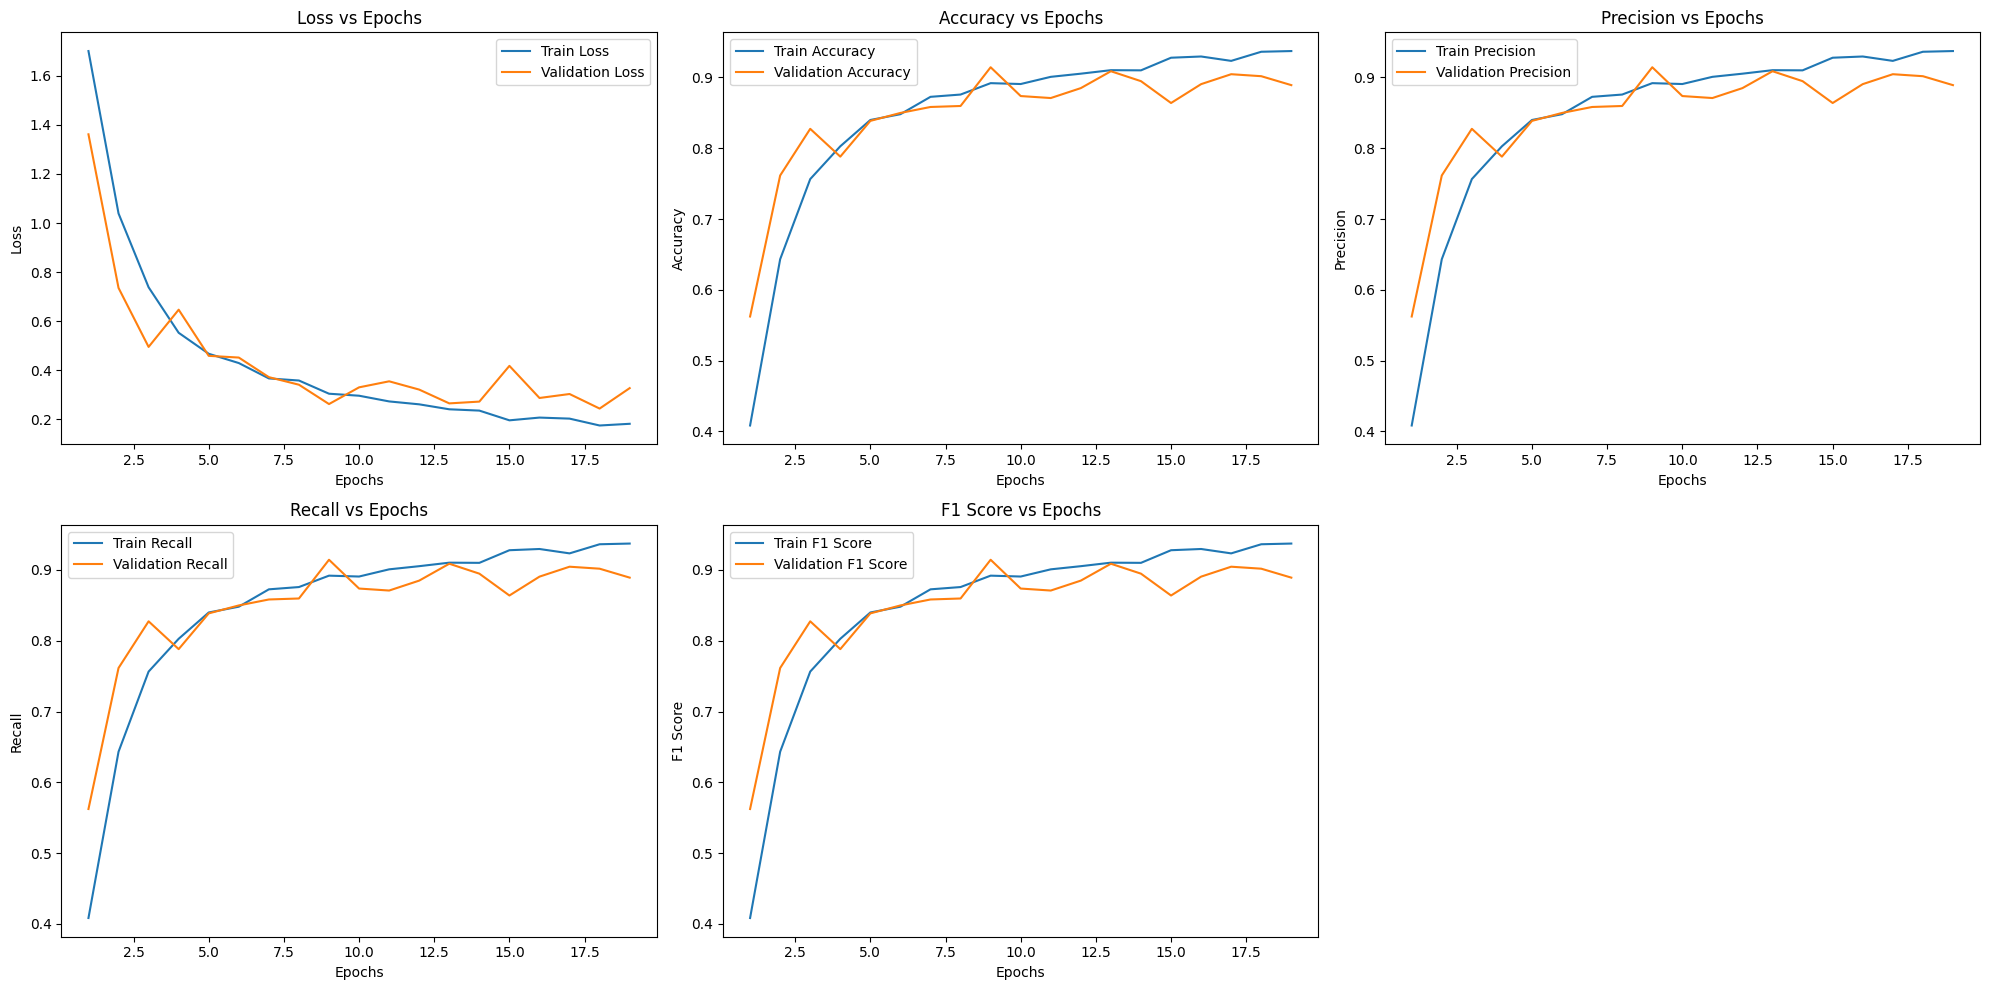

Training complete for cnn_extra_large
Creating submission file for cnn_extra_large


Test [TEST|cnn_extra_large]: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]

Test results saved to cnn_extra_large/cnn_extra_large_test_results.csv


In [7]:
image_size = 128
for config in mlp_configurations + cnn_configurations:
    model_name = config[-1]
    if 'mlp' in model_name:
        model = create_mlp_model(config, image_size)
    else:
        model = create_cnn_model(config, image_size)
    
    model = model.to(device)

    train(
        path_to_train,
        model,
        model_name,
        lr0 = 0.0001,
        lrf = 0.00001,
        weight_decay = 0.00005,
        num_epochs = 100,
        patience = 10,
        batch_size = 16,
        image_size = image_size,
        val_size = 0.15,
        device = device,
    )

    temp_dataset = datasets.ImageFolder(path_to_train)
    class2id = temp_dataset.class_to_idx

    # load the best model
    model.load_state_dict(torch.load(f'{model_name}/{model_name}_best_model.pt'))

    test_submit(model, model_name, image_size, path_to_test, class2id, device)

    del model

Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /root/.cache/torch/hub/v0.13.0.zip
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 84.4MB/s]






Starting training for efficientnet_b0
Number of parameters: 4,022,920


Epoch 1/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s, accuracy=45.63%, loss=1.61]


Epoch [1/60], Train Loss: 1.9059, Train Accuracy: 0.4563, Train Precision: 0.4563, Train Recall: 0.4563, Train F1: 0.4563


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [1/60], Validation Loss: 1.0140, Validation Accuracy: 0.7602, Validation Precision: 0.7602, Validation Recall: 0.7602, Validation F1: 0.7602
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s, accuracy=82.93%, loss=1.32]


Epoch [2/60], Train Loss: 0.7072, Train Accuracy: 0.8293, Train Precision: 0.8293, Train Recall: 0.8293, Train F1: 0.8293


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [2/60], Validation Loss: 0.3439, Validation Accuracy: 0.9158, Validation Precision: 0.9158, Validation Recall: 0.9158, Validation F1: 0.9158
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=91.53%, loss=1.84]


Epoch [3/60], Train Loss: 0.3232, Train Accuracy: 0.9153, Train Precision: 0.9153, Train Recall: 0.9153, Train F1: 0.9153


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch [3/60], Validation Loss: 0.1947, Validation Accuracy: 0.9495, Validation Precision: 0.9495, Validation Recall: 0.9495, Validation F1: 0.9495
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s, accuracy=93.71%, loss=0.469]


Epoch [4/60], Train Loss: 0.2091, Train Accuracy: 0.9371, Train Precision: 0.9371, Train Recall: 0.9371, Train F1: 0.9371


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


Epoch [4/60], Validation Loss: 0.1662, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:28<00:00,  2.22it/s, accuracy=95.54%, loss=0.641]


Epoch [5/60], Train Loss: 0.1574, Train Accuracy: 0.9554, Train Precision: 0.9554, Train Recall: 0.9554, Train F1: 0.9554


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


Epoch [5/60], Validation Loss: 0.1489, Validation Accuracy: 0.9537, Validation Precision: 0.9537, Validation Recall: 0.9537, Validation F1: 0.9537
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s, accuracy=96.63%, loss=0.404]


Epoch [6/60], Train Loss: 0.1265, Train Accuracy: 0.9663, Train Precision: 0.9663, Train Recall: 0.9663, Train F1: 0.9663


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [6/60], Validation Loss: 0.1344, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s, accuracy=97.32%, loss=0.306]


Epoch [7/60], Train Loss: 0.0925, Train Accuracy: 0.9732, Train Precision: 0.9732, Train Recall: 0.9732, Train F1: 0.9732


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch [7/60], Validation Loss: 0.1096, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Saving best model at epoch 7...


Epoch 8/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s, accuracy=97.50%, loss=0.423]


Epoch [8/60], Train Loss: 0.0871, Train Accuracy: 0.9750, Train Precision: 0.9750, Train Recall: 0.9750, Train F1: 0.9750


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


Epoch [8/60], Validation Loss: 0.1208, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 1/10


Epoch 9/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=97.99%, loss=0.021]


Epoch [9/60], Train Loss: 0.0631, Train Accuracy: 0.9799, Train Precision: 0.9799, Train Recall: 0.9799, Train F1: 0.9799


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch [9/60], Validation Loss: 0.1109, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 2/10


Epoch 10/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s, accuracy=98.51%, loss=0.645]


Epoch [10/60], Train Loss: 0.0567, Train Accuracy: 0.9851, Train Precision: 0.9851, Train Recall: 0.9851, Train F1: 0.9851


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch [10/60], Validation Loss: 0.1023, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 3/10


Epoch 11/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=98.27%, loss=1.32]


Epoch [11/60], Train Loss: 0.0755, Train Accuracy: 0.9827, Train Precision: 0.9827, Train Recall: 0.9827, Train F1: 0.9827


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [11/60], Validation Loss: 0.1100, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Saving best model at epoch 11...


Epoch 12/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.50it/s, accuracy=98.17%, loss=0.721]


Epoch [12/60], Train Loss: 0.0670, Train Accuracy: 0.9817, Train Precision: 0.9817, Train Recall: 0.9817, Train F1: 0.9817


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


Epoch [12/60], Validation Loss: 0.1301, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 1/10


Epoch 13/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s, accuracy=98.76%, loss=1.11]


Epoch [13/60], Train Loss: 0.0581, Train Accuracy: 0.9876, Train Precision: 0.9876, Train Recall: 0.9876, Train F1: 0.9876


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


Epoch [13/60], Validation Loss: 0.1124, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Saving best model at epoch 13...


Epoch 14/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:29<00:00,  2.18it/s, accuracy=99.06%, loss=0.196]


Epoch [14/60], Train Loss: 0.0412, Train Accuracy: 0.9906, Train Precision: 0.9906, Train Recall: 0.9906, Train F1: 0.9906


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


Epoch [14/60], Validation Loss: 0.0834, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Saving best model at epoch 14...


Epoch 15/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s, accuracy=99.18%, loss=0.0945]


Epoch [15/60], Train Loss: 0.0304, Train Accuracy: 0.9918, Train Precision: 0.9918, Train Recall: 0.9918, Train F1: 0.9918


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch [15/60], Validation Loss: 0.0853, Validation Accuracy: 0.9804, Validation Precision: 0.9804, Validation Recall: 0.9804, Validation F1: 0.9804
Saving best model at epoch 15...


Epoch 16/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=99.21%, loss=1.64]


Epoch [16/60], Train Loss: 0.0517, Train Accuracy: 0.9921, Train Precision: 0.9921, Train Recall: 0.9921, Train F1: 0.9921


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [16/60], Validation Loss: 0.0727, Validation Accuracy: 0.9846, Validation Precision: 0.9846, Validation Recall: 0.9846, Validation F1: 0.9846
Saving best model at epoch 16...


Epoch 17/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.61it/s, accuracy=99.41%, loss=0.133]


Epoch [17/60], Train Loss: 0.0265, Train Accuracy: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [17/60], Validation Loss: 0.0883, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Patience: 1/10


Epoch 18/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s, accuracy=99.36%, loss=0.686]


Epoch [18/60], Train Loss: 0.0356, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch [18/60], Validation Loss: 0.0745, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Patience: 2/10


Epoch 19/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:26<00:00,  2.46it/s, accuracy=99.36%, loss=0.627]


Epoch [19/60], Train Loss: 0.0322, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [19/60], Validation Loss: 0.0997, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 3/10


Epoch 20/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=99.11%, loss=1.06]


Epoch [20/60], Train Loss: 0.0438, Train Accuracy: 0.9911, Train Precision: 0.9911, Train Recall: 0.9911, Train F1: 0.9911


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


Epoch [20/60], Validation Loss: 0.1049, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 4/10


Epoch 21/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.61it/s, accuracy=99.43%, loss=1.52]


Epoch [21/60], Train Loss: 0.0427, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Epoch [21/60], Validation Loss: 0.0858, Validation Accuracy: 0.9818, Validation Precision: 0.9818, Validation Recall: 0.9818, Validation F1: 0.9818
Patience: 5/10


Epoch 22/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.55%, loss=0.444]


Epoch [22/60], Train Loss: 0.0215, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Epoch [22/60], Validation Loss: 0.0793, Validation Accuracy: 0.9832, Validation Precision: 0.9832, Validation Recall: 0.9832, Validation F1: 0.9832
Patience: 6/10


Epoch 23/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:29<00:00,  2.19it/s, accuracy=99.50%, loss=0.0663]


Epoch [23/60], Train Loss: 0.0189, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.40it/s]


Epoch [23/60], Validation Loss: 0.0973, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 7/10


Epoch 24/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s, accuracy=99.83%, loss=0.0771]


Epoch [24/60], Train Loss: 0.0130, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [24/60], Validation Loss: 0.0894, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Patience: 8/10


Epoch 25/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.56it/s, accuracy=99.58%, loss=0.168]


Epoch [25/60], Train Loss: 0.0161, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1: 0.9958


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Epoch [25/60], Validation Loss: 0.0789, Validation Accuracy: 0.9818, Validation Precision: 0.9818, Validation Recall: 0.9818, Validation F1: 0.9818
Patience: 9/10


Epoch 26/60 [TRAIN|efficientnet_b0]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.60%, loss=0.125]


Epoch [26/60], Train Loss: 0.0166, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|efficientnet_b0]: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


Epoch [26/60], Validation Loss: 0.0883, Validation Accuracy: 0.9846, Validation Precision: 0.9846, Validation Recall: 0.9846, Validation F1: 0.9846
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to efficientnet_b0/efficientnet_b0_training_metrics.csv


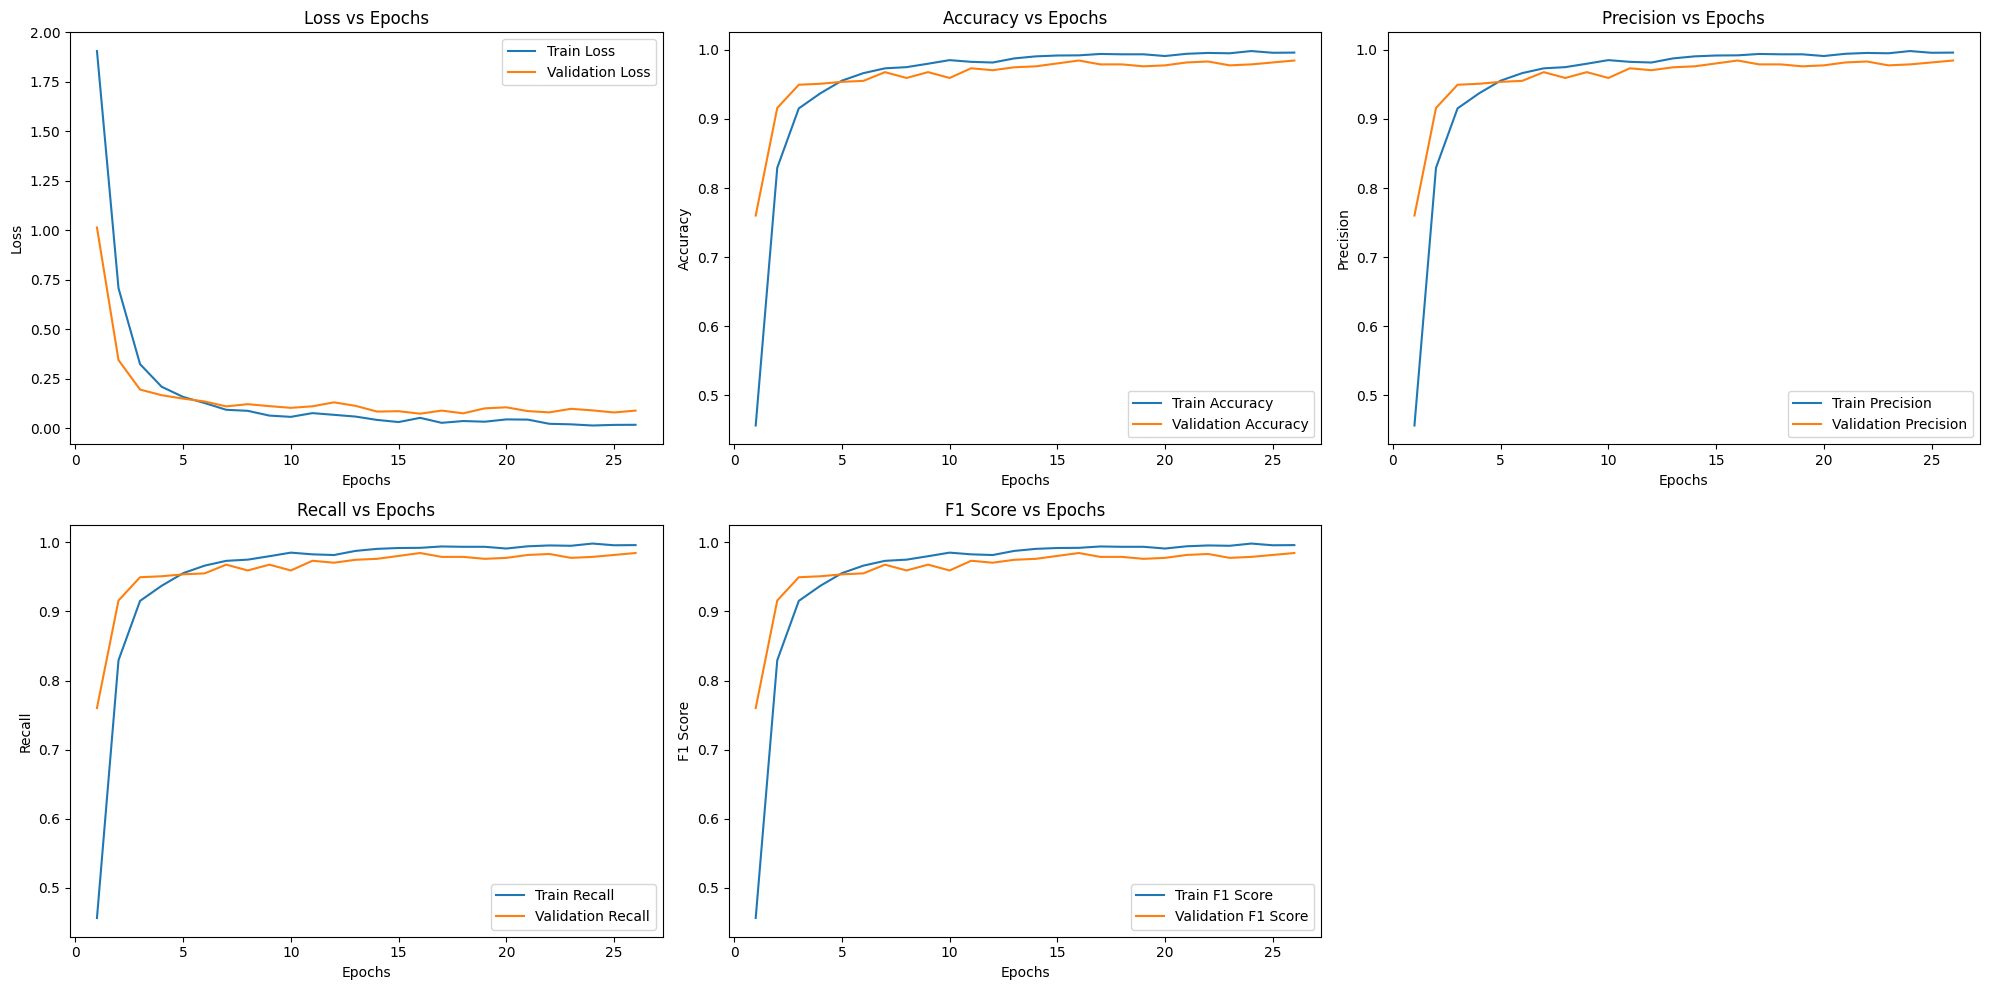

Training complete for efficientnet_b0
Creating submission file for efficientnet_b0


Test [TEST|efficientnet_b0]: 100%|██████████| 13/13 [00:02<00:00,  4.86it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth


Test results saved to efficientnet_b0/efficientnet_b0_test_results.csv


100%|██████████| 30.1M/30.1M [00:00<00:00, 66.2MB/s]






Starting training for efficientnet_b1
Number of parameters: 6,528,556


Epoch 1/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:29<00:00,  2.20it/s, accuracy=42.04%, loss=1.33]


Epoch [1/60], Train Loss: 1.9864, Train Accuracy: 0.4204, Train Precision: 0.4204, Train Recall: 0.4204, Train F1: 0.4204


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch [1/60], Validation Loss: 1.1628, Validation Accuracy: 0.7083, Validation Precision: 0.7083, Validation Recall: 0.7083, Validation F1: 0.7083
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=81.22%, loss=0.934]


Epoch [2/60], Train Loss: 0.7770, Train Accuracy: 0.8122, Train Precision: 0.8122, Train Recall: 0.8122, Train F1: 0.8122


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [2/60], Validation Loss: 0.3436, Validation Accuracy: 0.9130, Validation Precision: 0.9130, Validation Recall: 0.9130, Validation F1: 0.9130
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, accuracy=91.60%, loss=0.952]


Epoch [3/60], Train Loss: 0.3286, Train Accuracy: 0.9160, Train Precision: 0.9160, Train Recall: 0.9160, Train F1: 0.9160


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [3/60], Validation Loss: 0.1942, Validation Accuracy: 0.9383, Validation Precision: 0.9383, Validation Recall: 0.9383, Validation F1: 0.9383
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.39it/s, accuracy=94.35%, loss=0.274]


Epoch [4/60], Train Loss: 0.2002, Train Accuracy: 0.9435, Train Precision: 0.9435, Train Recall: 0.9435, Train F1: 0.9435


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [4/60], Validation Loss: 0.1386, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.37it/s, accuracy=95.52%, loss=0.161]


Epoch [5/60], Train Loss: 0.1511, Train Accuracy: 0.9552, Train Precision: 0.9552, Train Recall: 0.9552, Train F1: 0.9552


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch [5/60], Validation Loss: 0.1248, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:29<00:00,  2.15it/s, accuracy=96.93%, loss=0.321]


Epoch [6/60], Train Loss: 0.1145, Train Accuracy: 0.9693, Train Precision: 0.9693, Train Recall: 0.9693, Train F1: 0.9693


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [6/60], Validation Loss: 0.1020, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, accuracy=97.32%, loss=0.394]


Epoch [7/60], Train Loss: 0.0982, Train Accuracy: 0.9732, Train Precision: 0.9732, Train Recall: 0.9732, Train F1: 0.9732


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [7/60], Validation Loss: 0.0967, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 1/10


Epoch 8/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.37it/s, accuracy=97.89%, loss=0.951]


Epoch [8/60], Train Loss: 0.0873, Train Accuracy: 0.9789, Train Precision: 0.9789, Train Recall: 0.9789, Train F1: 0.9789


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch [8/60], Validation Loss: 0.0834, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 2/10


Epoch 9/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.37it/s, accuracy=98.02%, loss=0.936]


Epoch [9/60], Train Loss: 0.0773, Train Accuracy: 0.9802, Train Precision: 0.9802, Train Recall: 0.9802, Train F1: 0.9802


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [9/60], Validation Loss: 0.0754, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Saving best model at epoch 9...


Epoch 10/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:31<00:00,  2.02it/s, accuracy=98.41%, loss=0.234]


Epoch [10/60], Train Loss: 0.0562, Train Accuracy: 0.9841, Train Precision: 0.9841, Train Recall: 0.9841, Train F1: 0.9841


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [10/60], Validation Loss: 0.0693, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 1/10


Epoch 11/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, accuracy=98.76%, loss=1.06]


Epoch [11/60], Train Loss: 0.0592, Train Accuracy: 0.9876, Train Precision: 0.9876, Train Recall: 0.9876, Train F1: 0.9876


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [11/60], Validation Loss: 0.0790, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 2/10


Epoch 12/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=98.86%, loss=0.0953]


Epoch [12/60], Train Loss: 0.0419, Train Accuracy: 0.9886, Train Precision: 0.9886, Train Recall: 0.9886, Train F1: 0.9886


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [12/60], Validation Loss: 0.0792, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 3/10


Epoch 13/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.41%, loss=0.119]


Epoch [13/60], Train Loss: 0.0271, Train Accuracy: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch [13/60], Validation Loss: 0.0755, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 4/10


Epoch 14/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:29<00:00,  2.19it/s, accuracy=99.16%, loss=0.8]


Epoch [14/60], Train Loss: 0.0394, Train Accuracy: 0.9916, Train Precision: 0.9916, Train Recall: 0.9916, Train F1: 0.9916


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


Epoch [14/60], Validation Loss: 0.0710, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 5/10


Epoch 15/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.37it/s, accuracy=99.18%, loss=0.468]


Epoch [15/60], Train Loss: 0.0316, Train Accuracy: 0.9918, Train Precision: 0.9918, Train Recall: 0.9918, Train F1: 0.9918


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch [15/60], Validation Loss: 0.0883, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Saving best model at epoch 15...


Epoch 16/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=99.01%, loss=1.14]


Epoch [16/60], Train Loss: 0.0490, Train Accuracy: 0.9901, Train Precision: 0.9901, Train Recall: 0.9901, Train F1: 0.9901


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch [16/60], Validation Loss: 0.0788, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 1/10


Epoch 17/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, accuracy=99.06%, loss=0.733]


Epoch [17/60], Train Loss: 0.0478, Train Accuracy: 0.9906, Train Precision: 0.9906, Train Recall: 0.9906, Train F1: 0.9906


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [17/60], Validation Loss: 0.0701, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 2/10


Epoch 18/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.37it/s, accuracy=99.60%, loss=0.497]


Epoch [18/60], Train Loss: 0.0285, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Epoch [18/60], Validation Loss: 0.0653, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 3/10


Epoch 19/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:29<00:00,  2.13it/s, accuracy=99.31%, loss=0.0125]


Epoch [19/60], Train Loss: 0.0224, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [19/60], Validation Loss: 0.0650, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 4/10


Epoch 20/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.58%, loss=0.464]


Epoch [20/60], Train Loss: 0.0225, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1: 0.9958


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [20/60], Validation Loss: 0.0704, Validation Accuracy: 0.9818, Validation Precision: 0.9818, Validation Recall: 0.9818, Validation F1: 0.9818
Saving best model at epoch 20...


Epoch 21/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.37it/s, accuracy=99.55%, loss=0.0264]


Epoch [21/60], Train Loss: 0.0189, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [21/60], Validation Loss: 0.0789, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 1/10


Epoch 22/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, accuracy=99.63%, loss=0.276]


Epoch [22/60], Train Loss: 0.0189, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [22/60], Validation Loss: 0.0708, Validation Accuracy: 0.9804, Validation Precision: 0.9804, Validation Recall: 0.9804, Validation F1: 0.9804
Patience: 2/10


Epoch 23/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:31<00:00,  2.05it/s, accuracy=99.46%, loss=0.198]


Epoch [23/60], Train Loss: 0.0215, Train Accuracy: 0.9946, Train Precision: 0.9946, Train Recall: 0.9946, Train F1: 0.9946


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [23/60], Validation Loss: 0.0803, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 3/10


Epoch 24/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.39it/s, accuracy=99.63%, loss=0.0504]


Epoch [24/60], Train Loss: 0.0155, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [24/60], Validation Loss: 0.0949, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 4/10


Epoch 25/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, accuracy=99.78%, loss=0.224]


Epoch [25/60], Train Loss: 0.0157, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [25/60], Validation Loss: 0.0808, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 5/10


Epoch 26/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.40it/s, accuracy=99.60%, loss=0.413]


Epoch [26/60], Train Loss: 0.0192, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [26/60], Validation Loss: 0.0974, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 6/10


Epoch 27/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, accuracy=99.68%, loss=0.518]


Epoch [27/60], Train Loss: 0.0191, Train Accuracy: 0.9968, Train Precision: 0.9968, Train Recall: 0.9968, Train F1: 0.9968


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch [27/60], Validation Loss: 0.0845, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 7/10


Epoch 28/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:28<00:00,  2.24it/s, accuracy=99.68%, loss=0.161]


Epoch [28/60], Train Loss: 0.0152, Train Accuracy: 0.9968, Train Precision: 0.9968, Train Recall: 0.9968, Train F1: 0.9968


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Epoch [28/60], Validation Loss: 0.0807, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 8/10


Epoch 29/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.42it/s, accuracy=99.80%, loss=0.0263]


Epoch [29/60], Train Loss: 0.0102, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch [29/60], Validation Loss: 0.0828, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 9/10


Epoch 30/60 [TRAIN|efficientnet_b1]: 100%|██████████| 64/64 [00:26<00:00,  2.39it/s, accuracy=99.75%, loss=0.181]


Epoch [30/60], Train Loss: 0.0104, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|efficientnet_b1]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [30/60], Validation Loss: 0.0861, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to efficientnet_b1/efficientnet_b1_training_metrics.csv


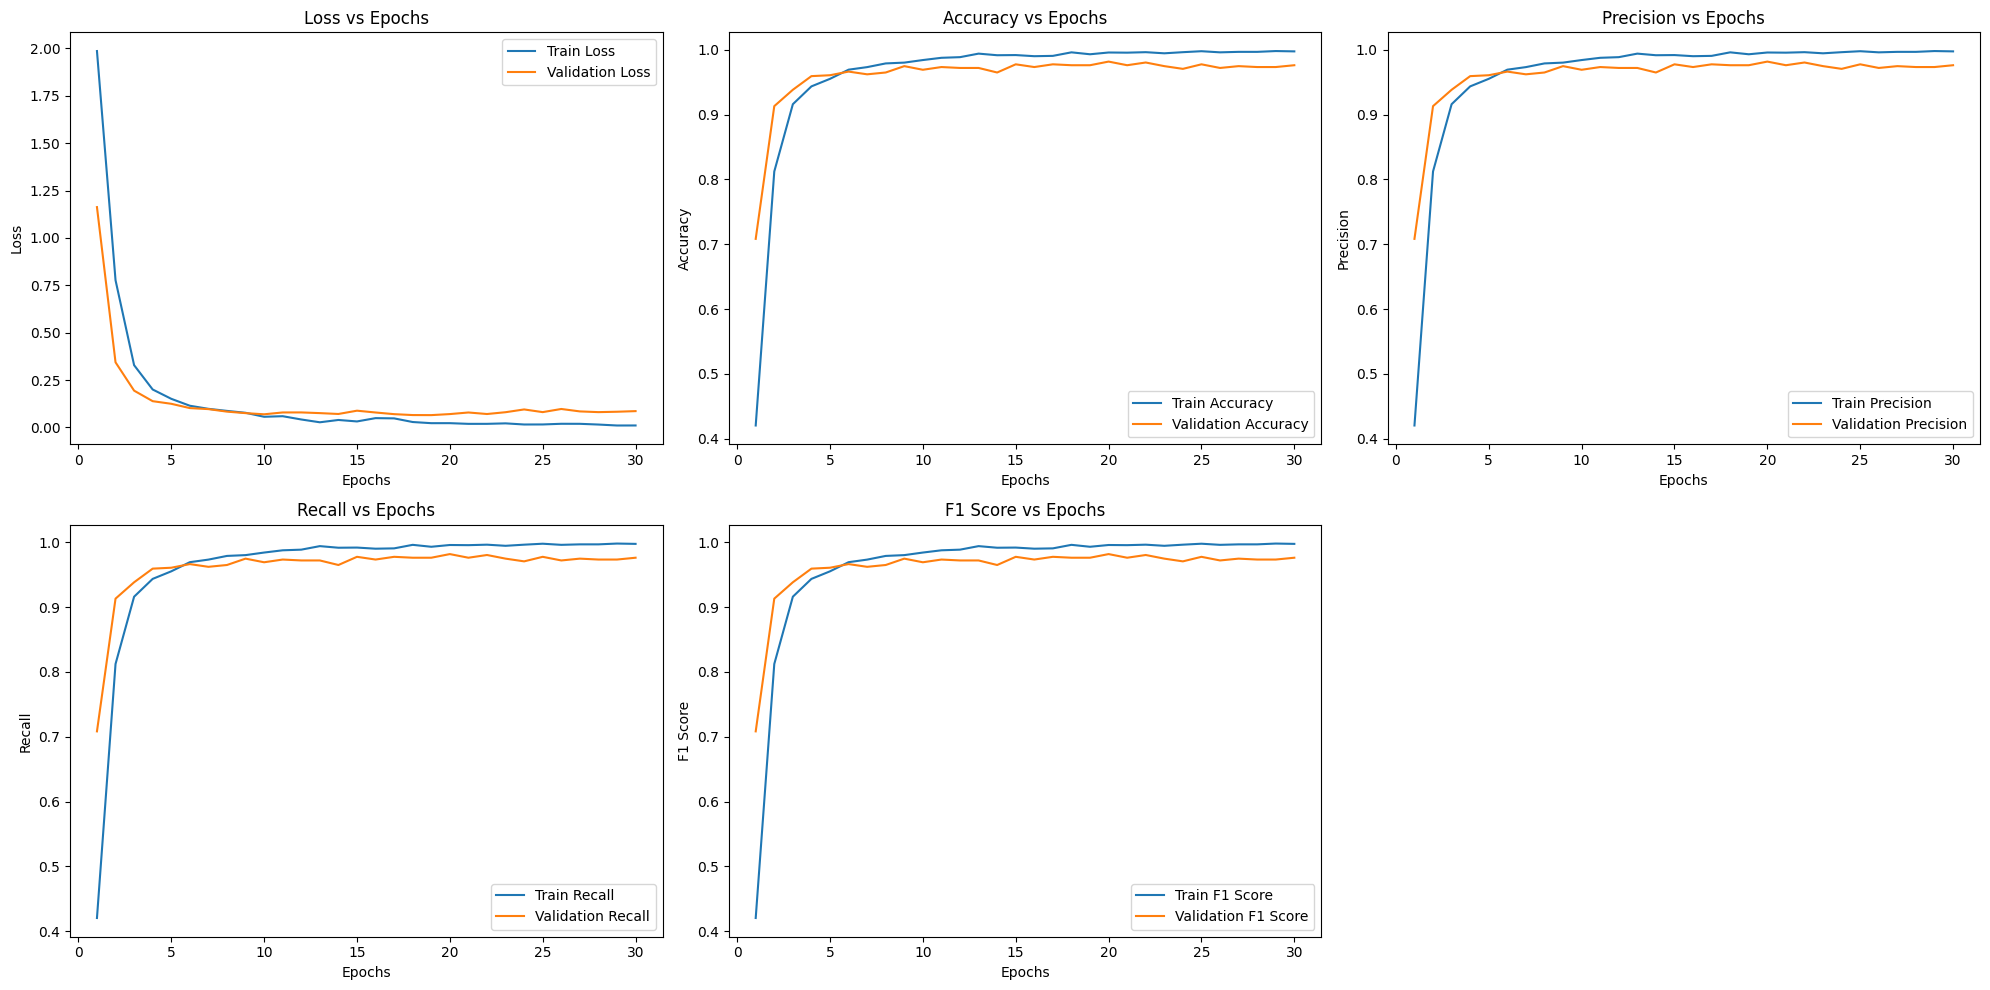

Training complete for efficientnet_b1
Creating submission file for efficientnet_b1


Test [TEST|efficientnet_b1]: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


Test results saved to efficientnet_b1/efficientnet_b1_test_results.csv


100%|██████████| 35.2M/35.2M [00:00<00:00, 153MB/s]






Starting training for efficientnet_b2
Number of parameters: 7,717,902


Epoch 1/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, accuracy=52.79%, loss=0.956]


Epoch [1/60], Train Loss: 1.7500, Train Accuracy: 0.5279, Train Precision: 0.5279, Train Recall: 0.5279, Train F1: 0.5279


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch [1/60], Validation Loss: 0.8059, Validation Accuracy: 0.8121, Validation Precision: 0.8121, Validation Recall: 0.8121, Validation F1: 0.8121
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:29<00:00,  2.14it/s, accuracy=86.85%, loss=0.875]


Epoch [2/60], Train Loss: 0.4997, Train Accuracy: 0.8685, Train Precision: 0.8685, Train Recall: 0.8685, Train F1: 0.8685


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [2/60], Validation Loss: 0.2865, Validation Accuracy: 0.9271, Validation Precision: 0.9271, Validation Recall: 0.9271, Validation F1: 0.9271
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=93.66%, loss=1.01]


Epoch [3/60], Train Loss: 0.2393, Train Accuracy: 0.9366, Train Precision: 0.9366, Train Recall: 0.9366, Train F1: 0.9366


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [3/60], Validation Loss: 0.1811, Validation Accuracy: 0.9523, Validation Precision: 0.9523, Validation Recall: 0.9523, Validation F1: 0.9523
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, accuracy=95.94%, loss=0.62]


Epoch [4/60], Train Loss: 0.1559, Train Accuracy: 0.9594, Train Precision: 0.9594, Train Recall: 0.9594, Train F1: 0.9594


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [4/60], Validation Loss: 0.1404, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, accuracy=97.23%, loss=1.01]


Epoch [5/60], Train Loss: 0.1124, Train Accuracy: 0.9723, Train Precision: 0.9723, Train Recall: 0.9723, Train F1: 0.9723


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [5/60], Validation Loss: 0.1392, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:31<00:00,  2.05it/s, accuracy=97.42%, loss=0.308]


Epoch [6/60], Train Loss: 0.0930, Train Accuracy: 0.9742, Train Precision: 0.9742, Train Recall: 0.9742, Train F1: 0.9742


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [6/60], Validation Loss: 0.1354, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, accuracy=97.97%, loss=0.589]


Epoch [7/60], Train Loss: 0.0777, Train Accuracy: 0.9797, Train Precision: 0.9797, Train Recall: 0.9797, Train F1: 0.9797


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


Epoch [7/60], Validation Loss: 0.1376, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Saving best model at epoch 7...


Epoch 8/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:28<00:00,  2.21it/s, accuracy=98.71%, loss=0.311]


Epoch [8/60], Train Loss: 0.0519, Train Accuracy: 0.9871, Train Precision: 0.9871, Train Recall: 0.9871, Train F1: 0.9871


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [8/60], Validation Loss: 0.1447, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 1/10


Epoch 9/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, accuracy=98.86%, loss=0.202]


Epoch [9/60], Train Loss: 0.0433, Train Accuracy: 0.9886, Train Precision: 0.9886, Train Recall: 0.9886, Train F1: 0.9886


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [9/60], Validation Loss: 0.1516, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 2/10


Epoch 10/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:31<00:00,  2.05it/s, accuracy=99.11%, loss=0.276]


Epoch [10/60], Train Loss: 0.0396, Train Accuracy: 0.9911, Train Precision: 0.9911, Train Recall: 0.9911, Train F1: 0.9911


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [10/60], Validation Loss: 0.1661, Validation Accuracy: 0.9523, Validation Precision: 0.9523, Validation Recall: 0.9523, Validation F1: 0.9523
Patience: 3/10


Epoch 11/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, accuracy=98.89%, loss=0.19]


Epoch [11/60], Train Loss: 0.0429, Train Accuracy: 0.9889, Train Precision: 0.9889, Train Recall: 0.9889, Train F1: 0.9889


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [11/60], Validation Loss: 0.1619, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 4/10


Epoch 12/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, accuracy=99.01%, loss=0.8]


Epoch [12/60], Train Loss: 0.0442, Train Accuracy: 0.9901, Train Precision: 0.9901, Train Recall: 0.9901, Train F1: 0.9901


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [12/60], Validation Loss: 0.1203, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Saving best model at epoch 12...


Epoch 13/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, accuracy=99.50%, loss=0.538]


Epoch [13/60], Train Loss: 0.0287, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [13/60], Validation Loss: 0.1419, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 1/10


Epoch 14/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s, accuracy=99.31%, loss=0.0262]


Epoch [14/60], Train Loss: 0.0273, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch [14/60], Validation Loss: 0.1245, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 2/10


Epoch 15/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s, accuracy=99.43%, loss=0.24]


Epoch [15/60], Train Loss: 0.0242, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [15/60], Validation Loss: 0.1789, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 3/10


Epoch 16/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, accuracy=99.53%, loss=0.0863]


Epoch [16/60], Train Loss: 0.0192, Train Accuracy: 0.9953, Train Precision: 0.9953, Train Recall: 0.9953, Train F1: 0.9953


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [16/60], Validation Loss: 0.1391, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 4/10


Epoch 17/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, accuracy=99.58%, loss=0.355]


Epoch [17/60], Train Loss: 0.0224, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1: 0.9958


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch [17/60], Validation Loss: 0.1480, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 5/10


Epoch 18/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, accuracy=99.33%, loss=0.332]


Epoch [18/60], Train Loss: 0.0265, Train Accuracy: 0.9933, Train Precision: 0.9933, Train Recall: 0.9933, Train F1: 0.9933


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


Epoch [18/60], Validation Loss: 0.1243, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Saving best model at epoch 18...


Epoch 19/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:31<00:00,  2.06it/s, accuracy=99.33%, loss=0.675]


Epoch [19/60], Train Loss: 0.0316, Train Accuracy: 0.9933, Train Precision: 0.9933, Train Recall: 0.9933, Train F1: 0.9933


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [19/60], Validation Loss: 0.1223, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 1/10


Epoch 20/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.43%, loss=1.07]


Epoch [20/60], Train Loss: 0.0389, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [20/60], Validation Loss: 0.1436, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 2/10


Epoch 21/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, accuracy=99.21%, loss=1.52]


Epoch [21/60], Train Loss: 0.0492, Train Accuracy: 0.9921, Train Precision: 0.9921, Train Recall: 0.9921, Train F1: 0.9921


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [21/60], Validation Loss: 0.1489, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 3/10


Epoch 22/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, accuracy=99.63%, loss=0.142]


Epoch [22/60], Train Loss: 0.0185, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [22/60], Validation Loss: 0.1492, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 4/10


Epoch 23/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:31<00:00,  2.03it/s, accuracy=99.75%, loss=0.0817]


Epoch [23/60], Train Loss: 0.0131, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [23/60], Validation Loss: 0.1391, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 5/10


Epoch 24/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, accuracy=99.80%, loss=0.195]


Epoch [24/60], Train Loss: 0.0120, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [24/60], Validation Loss: 0.1507, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 6/10


Epoch 25/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, accuracy=99.53%, loss=0.34]


Epoch [25/60], Train Loss: 0.0179, Train Accuracy: 0.9953, Train Precision: 0.9953, Train Recall: 0.9953, Train F1: 0.9953


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [25/60], Validation Loss: 0.1236, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 7/10


Epoch 26/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.63%, loss=0.215]


Epoch [26/60], Train Loss: 0.0161, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch [26/60], Validation Loss: 0.1388, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 8/10


Epoch 27/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:28<00:00,  2.21it/s, accuracy=99.68%, loss=0.156]


Epoch [27/60], Train Loss: 0.0117, Train Accuracy: 0.9968, Train Precision: 0.9968, Train Recall: 0.9968, Train F1: 0.9968


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch [27/60], Validation Loss: 0.1523, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 9/10


Epoch 28/60 [TRAIN|efficientnet_b2]: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s, accuracy=99.63%, loss=0.695]


Epoch [28/60], Train Loss: 0.0227, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b2]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [28/60], Validation Loss: 0.1566, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to efficientnet_b2/efficientnet_b2_training_metrics.csv


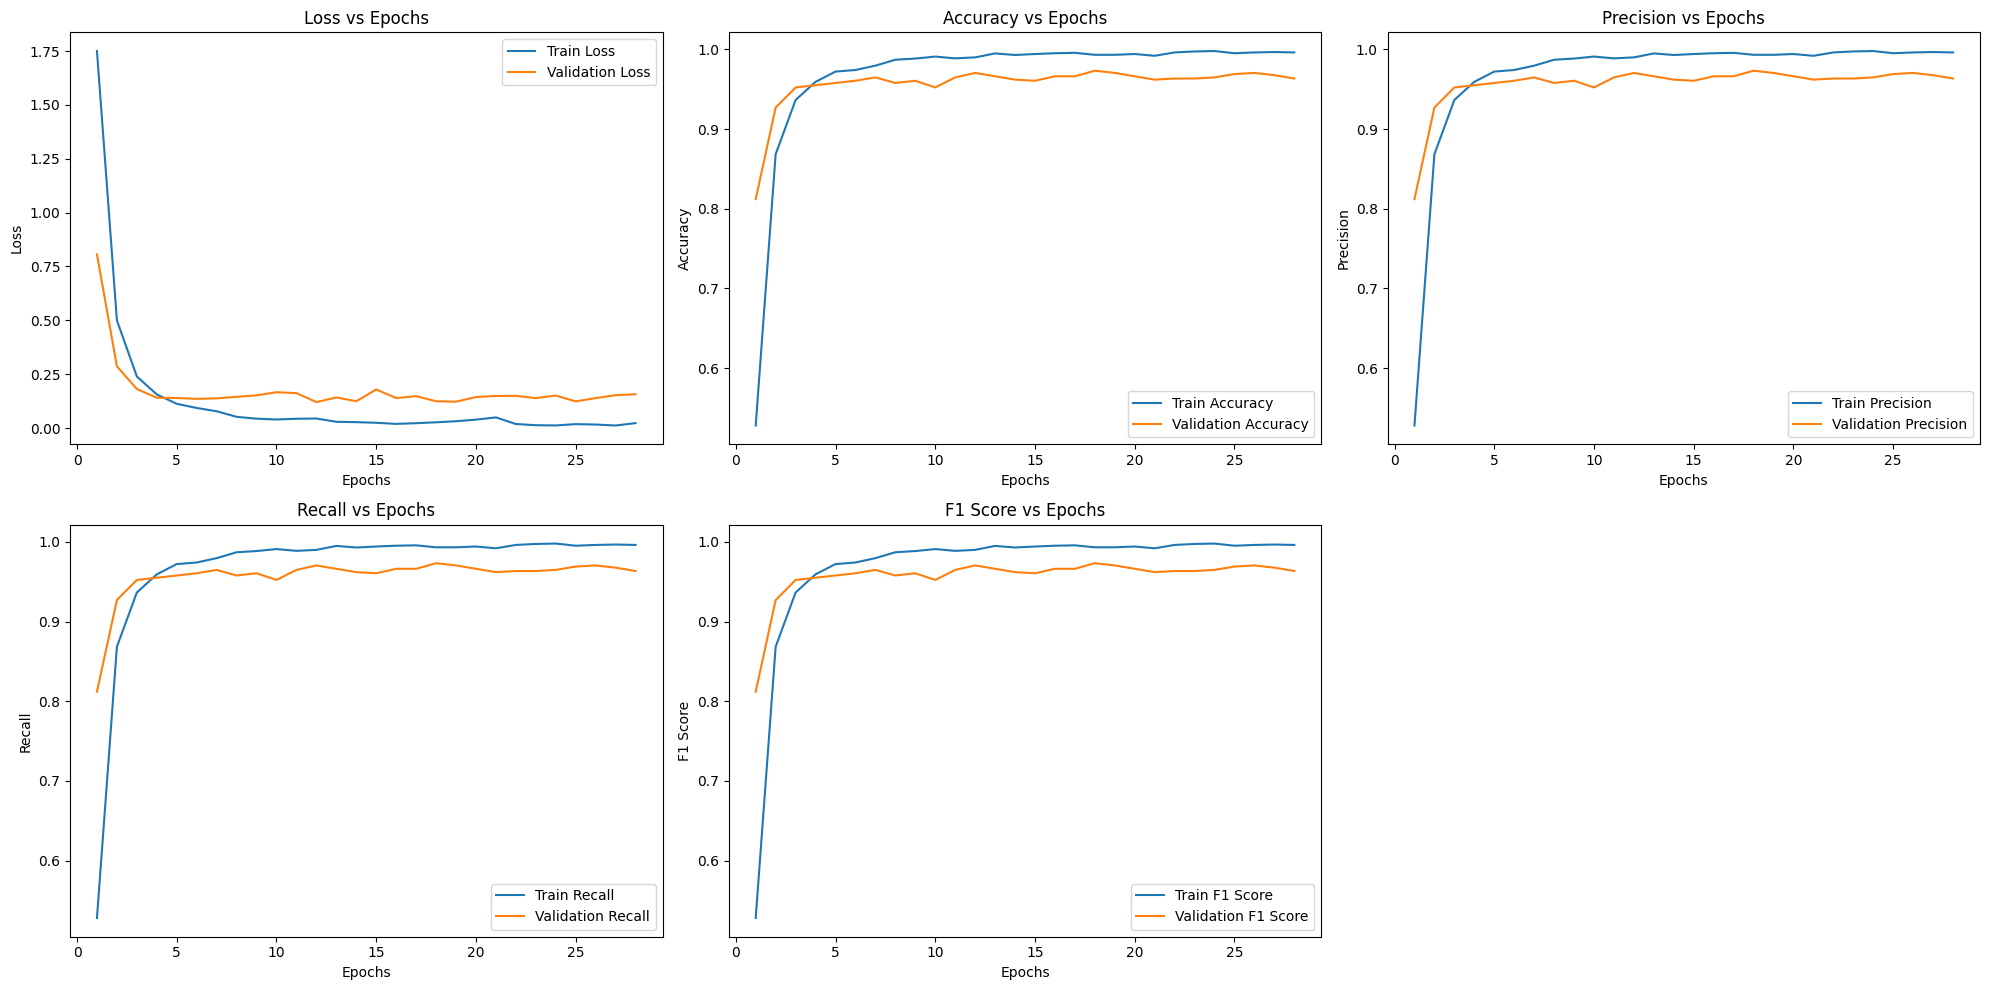

Training complete for efficientnet_b2
Creating submission file for efficientnet_b2


Test [TEST|efficientnet_b2]: 100%|██████████| 13/13 [00:02<00:00,  4.53it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Test results saved to efficientnet_b2/efficientnet_b2_test_results.csv


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 78.3MB/s]






Starting training for efficientnet_b3
Number of parameters: 10,714,676


Epoch 1/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=45.53%, loss=1.28]


Epoch [1/60], Train Loss: 1.9322, Train Accuracy: 0.4553, Train Precision: 0.4553, Train Recall: 0.4553, Train F1: 0.4553


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


Epoch [1/60], Validation Loss: 0.9929, Validation Accuracy: 0.7153, Validation Precision: 0.7153, Validation Recall: 0.7153, Validation F1: 0.7153
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=81.84%, loss=0.354]


Epoch [2/60], Train Loss: 0.6588, Train Accuracy: 0.8184, Train Precision: 0.8184, Train Recall: 0.8184, Train F1: 0.8184


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [2/60], Validation Loss: 1.2551, Validation Accuracy: 0.9369, Validation Precision: 0.9369, Validation Recall: 0.9369, Validation F1: 0.9369
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.93it/s, accuracy=93.09%, loss=0.63]


Epoch [3/60], Train Loss: 0.2641, Train Accuracy: 0.9309, Train Precision: 0.9309, Train Recall: 0.9309, Train F1: 0.9309


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


Epoch [3/60], Validation Loss: 0.1609, Validation Accuracy: 0.9495, Validation Precision: 0.9495, Validation Recall: 0.9495, Validation F1: 0.9495
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s, accuracy=94.65%, loss=0.176]


Epoch [4/60], Train Loss: 0.1732, Train Accuracy: 0.9465, Train Precision: 0.9465, Train Recall: 0.9465, Train F1: 0.9465


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


Epoch [4/60], Validation Loss: 0.1175, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.96it/s, accuracy=96.16%, loss=1.19]


Epoch [5/60], Train Loss: 0.1430, Train Accuracy: 0.9616, Train Precision: 0.9616, Train Recall: 0.9616, Train F1: 0.9616


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


Epoch [5/60], Validation Loss: 0.1050, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=96.88%, loss=0.333]


Epoch [6/60], Train Loss: 0.1081, Train Accuracy: 0.9688, Train Precision: 0.9688, Train Recall: 0.9688, Train F1: 0.9688


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [6/60], Validation Loss: 0.1035, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 1/10


Epoch 7/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.89it/s, accuracy=97.65%, loss=1.23]


Epoch [7/60], Train Loss: 0.0943, Train Accuracy: 0.9765, Train Precision: 0.9765, Train Recall: 0.9765, Train F1: 0.9765


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


Epoch [7/60], Validation Loss: 0.0901, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Saving best model at epoch 7...


Epoch 8/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=97.97%, loss=1.45]


Epoch [8/60], Train Loss: 0.0865, Train Accuracy: 0.9797, Train Precision: 0.9797, Train Recall: 0.9797, Train F1: 0.9797


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [8/60], Validation Loss: 0.1037, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 1/10


Epoch 9/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=98.56%, loss=0.668]


Epoch [9/60], Train Loss: 0.0646, Train Accuracy: 0.9856, Train Precision: 0.9856, Train Recall: 0.9856, Train F1: 0.9856


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [9/60], Validation Loss: 0.1143, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 2/10


Epoch 10/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s, accuracy=98.24%, loss=0.801]


Epoch [10/60], Train Loss: 0.0651, Train Accuracy: 0.9824, Train Precision: 0.9824, Train Recall: 0.9824, Train F1: 0.9824


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch [10/60], Validation Loss: 0.1190, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 3/10


Epoch 11/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:34<00:00,  1.86it/s, accuracy=98.61%, loss=0.114]


Epoch [11/60], Train Loss: 0.0467, Train Accuracy: 0.9861, Train Precision: 0.9861, Train Recall: 0.9861, Train F1: 0.9861


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


Epoch [11/60], Validation Loss: 0.1118, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 4/10


Epoch 12/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.94it/s, accuracy=98.86%, loss=0.0189]


Epoch [12/60], Train Loss: 0.0345, Train Accuracy: 0.9886, Train Precision: 0.9886, Train Recall: 0.9886, Train F1: 0.9886


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [12/60], Validation Loss: 0.1016, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Saving best model at epoch 12...


Epoch 13/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:31<00:00,  2.01it/s, accuracy=99.08%, loss=0.138]


Epoch [13/60], Train Loss: 0.0325, Train Accuracy: 0.9908, Train Precision: 0.9908, Train Recall: 0.9908, Train F1: 0.9908


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [13/60], Validation Loss: 0.1052, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 1/10


Epoch 14/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=99.43%, loss=1.41]


Epoch [14/60], Train Loss: 0.0457, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Epoch [14/60], Validation Loss: 0.0954, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 2/10


Epoch 15/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.93it/s, accuracy=99.08%, loss=0.936]


Epoch [15/60], Train Loss: 0.0450, Train Accuracy: 0.9908, Train Precision: 0.9908, Train Recall: 0.9908, Train F1: 0.9908


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


Epoch [15/60], Validation Loss: 0.0997, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 3/10


Epoch 16/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s, accuracy=99.53%, loss=0.17]


Epoch [16/60], Train Loss: 0.0266, Train Accuracy: 0.9953, Train Precision: 0.9953, Train Recall: 0.9953, Train F1: 0.9953


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [16/60], Validation Loss: 0.1096, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 4/10


Epoch 17/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=99.36%, loss=0.508]


Epoch [17/60], Train Loss: 0.0292, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


Epoch [17/60], Validation Loss: 0.0999, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 5/10


Epoch 18/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.92it/s, accuracy=99.53%, loss=0.0416]


Epoch [18/60], Train Loss: 0.0197, Train Accuracy: 0.9953, Train Precision: 0.9953, Train Recall: 0.9953, Train F1: 0.9953


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch [18/60], Validation Loss: 0.0884, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 6/10


Epoch 19/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.63%, loss=1.02]


Epoch [19/60], Train Loss: 0.0280, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch [19/60], Validation Loss: 0.0953, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Saving best model at epoch 19...


Epoch 20/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.13%, loss=1.56]


Epoch [20/60], Train Loss: 0.0457, Train Accuracy: 0.9913, Train Precision: 0.9913, Train Recall: 0.9913, Train F1: 0.9913


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch [20/60], Validation Loss: 0.0923, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 1/10


Epoch 21/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s, accuracy=99.55%, loss=0.146]


Epoch [21/60], Train Loss: 0.0192, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch [21/60], Validation Loss: 0.1086, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 2/10


Epoch 22/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:34<00:00,  1.88it/s, accuracy=99.55%, loss=1.08]


Epoch [22/60], Train Loss: 0.0332, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [22/60], Validation Loss: 0.1360, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 3/10


Epoch 23/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.63%, loss=0.785]


Epoch [23/60], Train Loss: 0.0285, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [23/60], Validation Loss: 0.1133, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 4/10


Epoch 24/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s, accuracy=99.36%, loss=0.194]


Epoch [24/60], Train Loss: 0.0256, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


Epoch [24/60], Validation Loss: 0.0977, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 5/10


Epoch 25/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.73%, loss=0.886]


Epoch [25/60], Train Loss: 0.0243, Train Accuracy: 0.9973, Train Precision: 0.9973, Train Recall: 0.9973, Train F1: 0.9973


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Epoch [25/60], Validation Loss: 0.1073, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 6/10


Epoch 26/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:34<00:00,  1.87it/s, accuracy=99.65%, loss=0.0608]


Epoch [26/60], Train Loss: 0.0137, Train Accuracy: 0.9965, Train Precision: 0.9965, Train Recall: 0.9965, Train F1: 0.9965


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [26/60], Validation Loss: 0.0994, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 7/10


Epoch 27/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.80%, loss=0.352]


Epoch [27/60], Train Loss: 0.0136, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [27/60], Validation Loss: 0.0897, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Saving best model at epoch 27...


Epoch 28/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s, accuracy=99.75%, loss=1.23]


Epoch [28/60], Train Loss: 0.0276, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch [28/60], Validation Loss: 0.0922, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 1/10


Epoch 29/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.95it/s, accuracy=99.83%, loss=0.0255]


Epoch [29/60], Train Loss: 0.0086, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch [29/60], Validation Loss: 0.0867, Validation Accuracy: 0.9818, Validation Precision: 0.9818, Validation Recall: 0.9818, Validation F1: 0.9818
Saving best model at epoch 29...


Epoch 30/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.90it/s, accuracy=99.80%, loss=0.0292]


Epoch [30/60], Train Loss: 0.0087, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch [30/60], Validation Loss: 0.0846, Validation Accuracy: 0.9804, Validation Precision: 0.9804, Validation Recall: 0.9804, Validation F1: 0.9804
Patience: 1/10


Epoch 31/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s, accuracy=99.85%, loss=0.0194]


Epoch [31/60], Train Loss: 0.0079, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [31/60], Validation Loss: 0.0960, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 2/10


Epoch 32/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s, accuracy=99.88%, loss=0.196]


Epoch [32/60], Train Loss: 0.0083, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


Epoch [32/60], Validation Loss: 0.0864, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 3/10


Epoch 33/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=99.85%, loss=0.521]


Epoch [33/60], Train Loss: 0.0144, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch [33/60], Validation Loss: 0.0937, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 4/10


Epoch 34/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.96it/s, accuracy=99.70%, loss=0.038]


Epoch [34/60], Train Loss: 0.0108, Train Accuracy: 0.9970, Train Precision: 0.9970, Train Recall: 0.9970, Train F1: 0.9970


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [34/60], Validation Loss: 0.0932, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 5/10


Epoch 35/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s, accuracy=99.78%, loss=0.0974]


Epoch [35/60], Train Loss: 0.0111, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch [35/60], Validation Loss: 0.1010, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 6/10


Epoch 36/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.88%, loss=0.0521]


Epoch [36/60], Train Loss: 0.0071, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [36/60], Validation Loss: 0.1084, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 7/10


Epoch 37/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:33<00:00,  1.92it/s, accuracy=99.88%, loss=0.544]


Epoch [37/60], Train Loss: 0.0143, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


Epoch [37/60], Validation Loss: 0.0922, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 8/10


Epoch 38/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s, accuracy=99.83%, loss=0.137]


Epoch [38/60], Train Loss: 0.0081, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


Epoch [38/60], Validation Loss: 0.1023, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 9/10


Epoch 39/60 [TRAIN|efficientnet_b3]: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s, accuracy=99.90%, loss=0.004]


Epoch [39/60], Train Loss: 0.0048, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1: 0.9990


Evaluation [VALID|efficientnet_b3]: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


Epoch [39/60], Validation Loss: 0.1014, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to efficientnet_b3/efficientnet_b3_training_metrics.csv


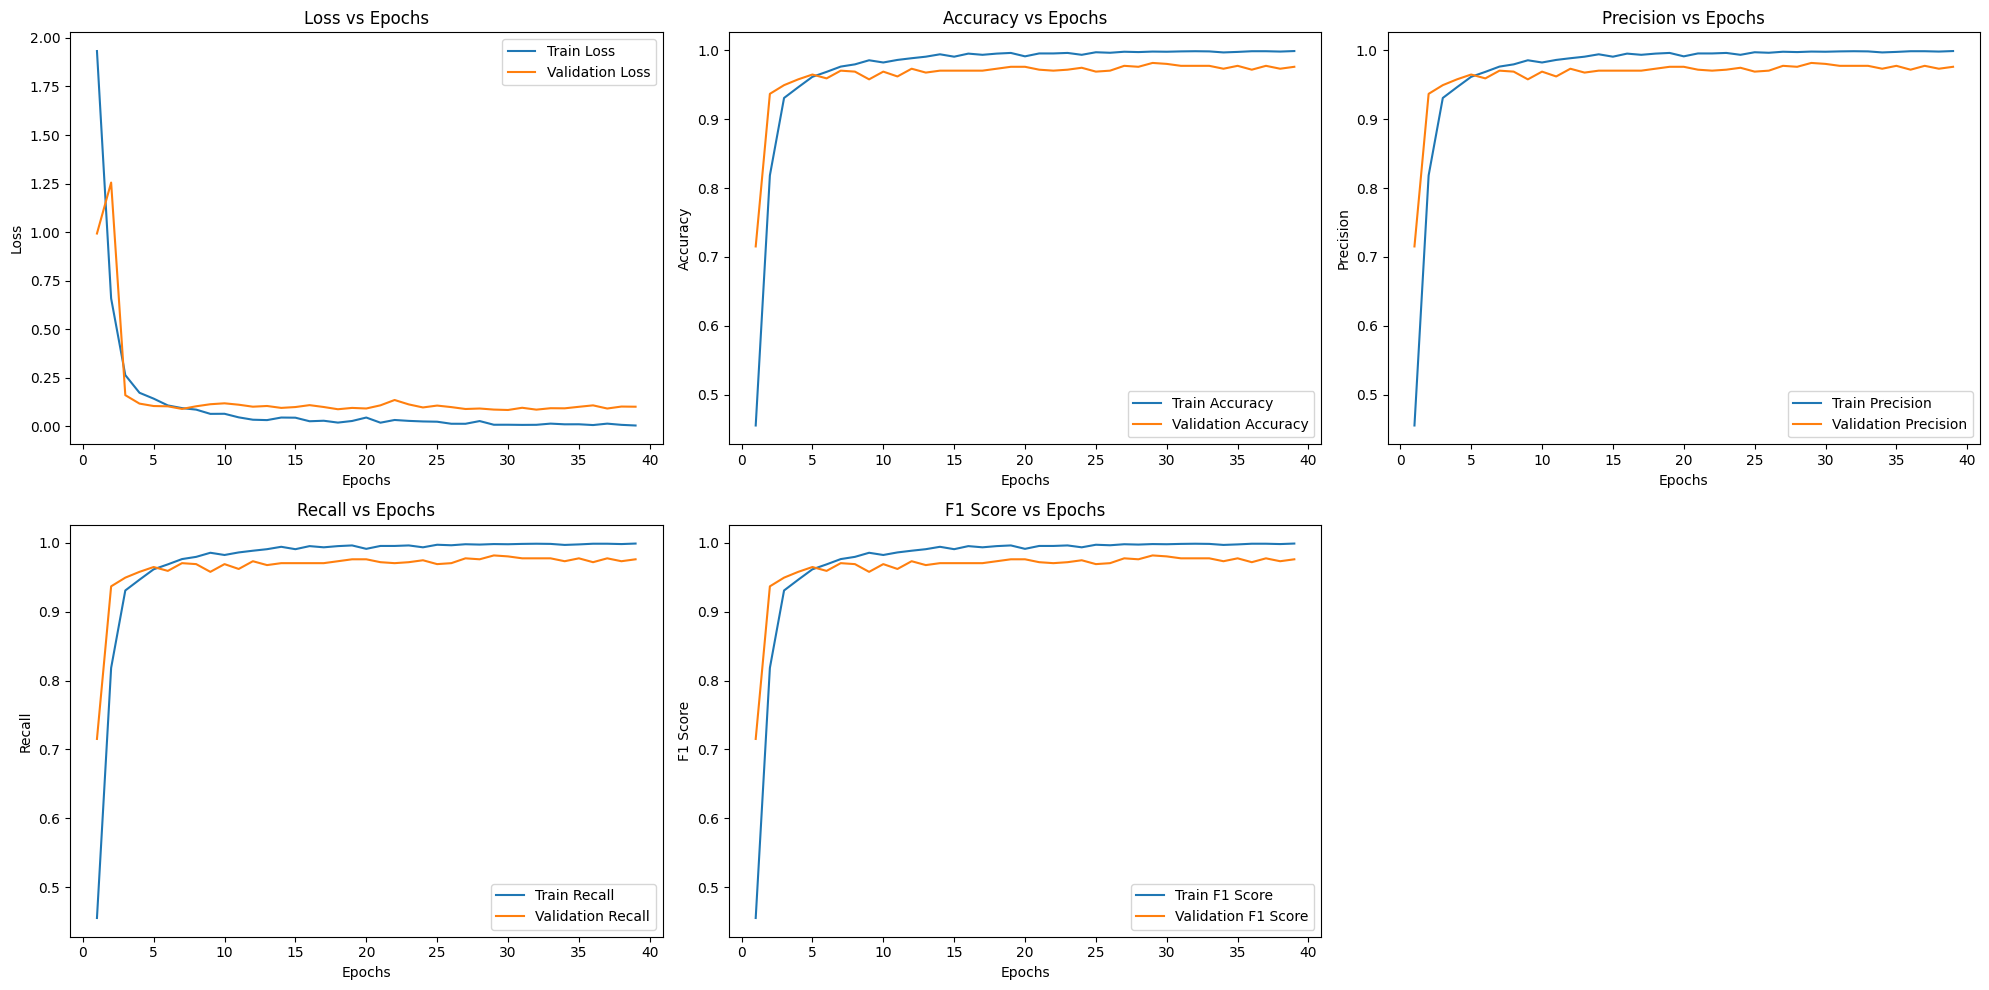

Training complete for efficientnet_b3
Creating submission file for efficientnet_b3


Test [TEST|efficientnet_b3]: 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Test results saved to efficientnet_b3/efficientnet_b3_test_results.csv


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:01<00:00, 69.3MB/s]






Starting training for efficientnet_b4
Number of parameters: 17,570,132


Epoch 1/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=28.54%, loss=1.93]


Epoch [1/60], Train Loss: 2.3272, Train Accuracy: 0.2854, Train Precision: 0.2854, Train Recall: 0.2854, Train F1: 0.2854


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch [1/60], Validation Loss: 2.0609, Validation Accuracy: 0.4979, Validation Precision: 0.4979, Validation Recall: 0.4979, Validation F1: 0.4979
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.50it/s, accuracy=59.10%, loss=0.867]


Epoch [2/60], Train Loss: 1.4523, Train Accuracy: 0.5910, Train Precision: 0.5910, Train Recall: 0.5910, Train F1: 0.5910


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [2/60], Validation Loss: 0.7578, Validation Accuracy: 0.7952, Validation Precision: 0.7952, Validation Recall: 0.7952, Validation F1: 0.7952
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=80.80%, loss=1.11]


Epoch [3/60], Train Loss: 0.6028, Train Accuracy: 0.8080, Train Precision: 0.8080, Train Recall: 0.8080, Train F1: 0.8080


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [3/60], Validation Loss: 0.3359, Validation Accuracy: 0.8850, Validation Precision: 0.8850, Validation Recall: 0.8850, Validation F1: 0.8850
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=89.03%, loss=0.573]


Epoch [4/60], Train Loss: 0.3332, Train Accuracy: 0.8903, Train Precision: 0.8903, Train Recall: 0.8903, Train F1: 0.8903


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch [4/60], Validation Loss: 0.2384, Validation Accuracy: 0.9173, Validation Precision: 0.9173, Validation Recall: 0.9173, Validation F1: 0.9173
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.49it/s, accuracy=90.71%, loss=0.243]


Epoch [5/60], Train Loss: 0.2600, Train Accuracy: 0.9071, Train Precision: 0.9071, Train Recall: 0.9071, Train F1: 0.9071


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [5/60], Validation Loss: 0.2173, Validation Accuracy: 0.9229, Validation Precision: 0.9229, Validation Recall: 0.9229, Validation F1: 0.9229
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.52it/s, accuracy=92.79%, loss=0.568]


Epoch [6/60], Train Loss: 0.2085, Train Accuracy: 0.9279, Train Precision: 0.9279, Train Recall: 0.9279, Train F1: 0.9279


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [6/60], Validation Loss: 0.1869, Validation Accuracy: 0.9299, Validation Precision: 0.9299, Validation Recall: 0.9299, Validation F1: 0.9299
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s, accuracy=93.01%, loss=0.225]


Epoch [7/60], Train Loss: 0.1777, Train Accuracy: 0.9301, Train Precision: 0.9301, Train Recall: 0.9301, Train F1: 0.9301


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


Epoch [7/60], Validation Loss: 0.1721, Validation Accuracy: 0.9439, Validation Precision: 0.9439, Validation Recall: 0.9439, Validation F1: 0.9439
Saving best model at epoch 7...


Epoch 8/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=94.92%, loss=0.899]


Epoch [8/60], Train Loss: 0.1596, Train Accuracy: 0.9492, Train Precision: 0.9492, Train Recall: 0.9492, Train F1: 0.9492


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [8/60], Validation Loss: 0.1631, Validation Accuracy: 0.9397, Validation Precision: 0.9397, Validation Recall: 0.9397, Validation F1: 0.9397
Patience: 1/10


Epoch 9/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.54it/s, accuracy=95.24%, loss=0.817]


Epoch [9/60], Train Loss: 0.1423, Train Accuracy: 0.9524, Train Precision: 0.9524, Train Recall: 0.9524, Train F1: 0.9524


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch [9/60], Validation Loss: 0.1502, Validation Accuracy: 0.9453, Validation Precision: 0.9453, Validation Recall: 0.9453, Validation F1: 0.9453
Saving best model at epoch 9...


Epoch 10/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=95.71%, loss=0.0526]


Epoch [10/60], Train Loss: 0.1223, Train Accuracy: 0.9571, Train Precision: 0.9571, Train Recall: 0.9571, Train F1: 0.9571


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


Epoch [10/60], Validation Loss: 0.1488, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Saving best model at epoch 10...


Epoch 11/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=96.41%, loss=0.0476]


Epoch [11/60], Train Loss: 0.1014, Train Accuracy: 0.9641, Train Precision: 0.9641, Train Recall: 0.9641, Train F1: 0.9641


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [11/60], Validation Loss: 0.1339, Validation Accuracy: 0.9523, Validation Precision: 0.9523, Validation Recall: 0.9523, Validation F1: 0.9523
Saving best model at epoch 11...


Epoch 12/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=96.93%, loss=0.142]


Epoch [12/60], Train Loss: 0.0975, Train Accuracy: 0.9693, Train Precision: 0.9693, Train Recall: 0.9693, Train F1: 0.9693


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [12/60], Validation Loss: 0.1418, Validation Accuracy: 0.9495, Validation Precision: 0.9495, Validation Recall: 0.9495, Validation F1: 0.9495
Patience: 1/10


Epoch 13/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=97.45%, loss=0.0106]


Epoch [13/60], Train Loss: 0.0831, Train Accuracy: 0.9745, Train Precision: 0.9745, Train Recall: 0.9745, Train F1: 0.9745


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [13/60], Validation Loss: 0.1288, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Saving best model at epoch 13...


Epoch 14/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=97.47%, loss=1.5]


Epoch [14/60], Train Loss: 0.0978, Train Accuracy: 0.9747, Train Precision: 0.9747, Train Recall: 0.9747, Train F1: 0.9747


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


Epoch [14/60], Validation Loss: 0.1482, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Patience: 1/10


Epoch 15/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=97.55%, loss=0.628]


Epoch [15/60], Train Loss: 0.0797, Train Accuracy: 0.9755, Train Precision: 0.9755, Train Recall: 0.9755, Train F1: 0.9755


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch [15/60], Validation Loss: 0.1514, Validation Accuracy: 0.9523, Validation Precision: 0.9523, Validation Recall: 0.9523, Validation F1: 0.9523
Patience: 2/10


Epoch 16/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=97.52%, loss=0.454]


Epoch [16/60], Train Loss: 0.0758, Train Accuracy: 0.9752, Train Precision: 0.9752, Train Recall: 0.9752, Train F1: 0.9752


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [16/60], Validation Loss: 0.1272, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 3/10


Epoch 17/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s, accuracy=97.57%, loss=0.0355]


Epoch [17/60], Train Loss: 0.0694, Train Accuracy: 0.9757, Train Precision: 0.9757, Train Recall: 0.9757, Train F1: 0.9757


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [17/60], Validation Loss: 0.1329, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 4/10


Epoch 18/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=98.34%, loss=0.371]


Epoch [18/60], Train Loss: 0.0563, Train Accuracy: 0.9834, Train Precision: 0.9834, Train Recall: 0.9834, Train F1: 0.9834


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch [18/60], Validation Loss: 0.1301, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 5/10


Epoch 19/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s, accuracy=98.27%, loss=0.983]


Epoch [19/60], Train Loss: 0.0659, Train Accuracy: 0.9827, Train Precision: 0.9827, Train Recall: 0.9827, Train F1: 0.9827


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch [19/60], Validation Loss: 0.1176, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Saving best model at epoch 19...


Epoch 20/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=98.24%, loss=0.0883]


Epoch [20/60], Train Loss: 0.0564, Train Accuracy: 0.9824, Train Precision: 0.9824, Train Recall: 0.9824, Train F1: 0.9824


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [20/60], Validation Loss: 0.1165, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Saving best model at epoch 20...


Epoch 21/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=98.54%, loss=1.64]


Epoch [21/60], Train Loss: 0.0681, Train Accuracy: 0.9854, Train Precision: 0.9854, Train Recall: 0.9854, Train F1: 0.9854


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [21/60], Validation Loss: 0.1201, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 1/10


Epoch 22/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.52it/s, accuracy=98.59%, loss=1.8]


Epoch [22/60], Train Loss: 0.0719, Train Accuracy: 0.9859, Train Precision: 0.9859, Train Recall: 0.9859, Train F1: 0.9859


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [22/60], Validation Loss: 0.1335, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 2/10


Epoch 23/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.54it/s, accuracy=98.71%, loss=0.104]


Epoch [23/60], Train Loss: 0.0393, Train Accuracy: 0.9871, Train Precision: 0.9871, Train Recall: 0.9871, Train F1: 0.9871


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [23/60], Validation Loss: 0.1203, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 3/10


Epoch 24/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=98.81%, loss=0.576]


Epoch [24/60], Train Loss: 0.0454, Train Accuracy: 0.9881, Train Precision: 0.9881, Train Recall: 0.9881, Train F1: 0.9881


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [24/60], Validation Loss: 0.1271, Validation Accuracy: 0.9537, Validation Precision: 0.9537, Validation Recall: 0.9537, Validation F1: 0.9537
Patience: 4/10


Epoch 25/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=99.03%, loss=0.0314]


Epoch [25/60], Train Loss: 0.0301, Train Accuracy: 0.9903, Train Precision: 0.9903, Train Recall: 0.9903, Train F1: 0.9903


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [25/60], Validation Loss: 0.1293, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 5/10


Epoch 26/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=98.86%, loss=0.254]


Epoch [26/60], Train Loss: 0.0369, Train Accuracy: 0.9886, Train Precision: 0.9886, Train Recall: 0.9886, Train F1: 0.9886


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [26/60], Validation Loss: 0.1163, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Saving best model at epoch 26...


Epoch 27/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=99.21%, loss=0.15]


Epoch [27/60], Train Loss: 0.0287, Train Accuracy: 0.9921, Train Precision: 0.9921, Train Recall: 0.9921, Train F1: 0.9921


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


Epoch [27/60], Validation Loss: 0.1265, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 1/10


Epoch 28/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.49it/s, accuracy=99.08%, loss=0.135]


Epoch [28/60], Train Loss: 0.0306, Train Accuracy: 0.9908, Train Precision: 0.9908, Train Recall: 0.9908, Train F1: 0.9908


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [28/60], Validation Loss: 0.1239, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 2/10


Epoch 29/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.54it/s, accuracy=99.13%, loss=0.0579]


Epoch [29/60], Train Loss: 0.0262, Train Accuracy: 0.9913, Train Precision: 0.9913, Train Recall: 0.9913, Train F1: 0.9913


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [29/60], Validation Loss: 0.1282, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 3/10


Epoch 30/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.52it/s, accuracy=99.36%, loss=0.157]


Epoch [30/60], Train Loss: 0.0233, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch [30/60], Validation Loss: 0.1315, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 4/10


Epoch 31/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s, accuracy=99.16%, loss=0.445]


Epoch [31/60], Train Loss: 0.0313, Train Accuracy: 0.9916, Train Precision: 0.9916, Train Recall: 0.9916, Train F1: 0.9916


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [31/60], Validation Loss: 0.1304, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 5/10


Epoch 32/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=99.50%, loss=0.0534]


Epoch [32/60], Train Loss: 0.0218, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [32/60], Validation Loss: 0.1307, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 6/10


Epoch 33/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=99.31%, loss=0.643]


Epoch [33/60], Train Loss: 0.0324, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [33/60], Validation Loss: 0.1278, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 7/10


Epoch 34/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.49it/s, accuracy=99.33%, loss=0.0932]


Epoch [34/60], Train Loss: 0.0220, Train Accuracy: 0.9933, Train Precision: 0.9933, Train Recall: 0.9933, Train F1: 0.9933


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [34/60], Validation Loss: 0.1208, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Saving best model at epoch 34...


Epoch 35/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=99.31%, loss=0.889]


Epoch [35/60], Train Loss: 0.0323, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [35/60], Validation Loss: 0.1214, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 1/10


Epoch 36/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=99.21%, loss=0.126]


Epoch [36/60], Train Loss: 0.0232, Train Accuracy: 0.9921, Train Precision: 0.9921, Train Recall: 0.9921, Train F1: 0.9921


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Epoch [36/60], Validation Loss: 0.1303, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 2/10


Epoch 37/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s, accuracy=99.28%, loss=2.49]


Epoch [37/60], Train Loss: 0.0605, Train Accuracy: 0.9928, Train Precision: 0.9928, Train Recall: 0.9928, Train F1: 0.9928


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [37/60], Validation Loss: 0.1428, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 3/10


Epoch 38/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=99.31%, loss=0.746]


Epoch [38/60], Train Loss: 0.0327, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch [38/60], Validation Loss: 0.1519, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 4/10


Epoch 39/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=99.33%, loss=0.769]


Epoch [39/60], Train Loss: 0.0303, Train Accuracy: 0.9933, Train Precision: 0.9933, Train Recall: 0.9933, Train F1: 0.9933


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [39/60], Validation Loss: 0.1398, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 5/10


Epoch 40/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=99.23%, loss=0.000789]


Epoch [40/60], Train Loss: 0.0239, Train Accuracy: 0.9923, Train Precision: 0.9923, Train Recall: 0.9923, Train F1: 0.9923


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [40/60], Validation Loss: 0.1588, Validation Accuracy: 0.9537, Validation Precision: 0.9537, Validation Recall: 0.9537, Validation F1: 0.9537
Patience: 6/10


Epoch 41/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.54it/s, accuracy=99.36%, loss=0.51]


Epoch [41/60], Train Loss: 0.0262, Train Accuracy: 0.9936, Train Precision: 0.9936, Train Recall: 0.9936, Train F1: 0.9936


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [41/60], Validation Loss: 0.1469, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 7/10


Epoch 42/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.52it/s, accuracy=99.46%, loss=0.91]


Epoch [42/60], Train Loss: 0.0294, Train Accuracy: 0.9946, Train Precision: 0.9946, Train Recall: 0.9946, Train F1: 0.9946


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [42/60], Validation Loss: 0.1473, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 8/10


Epoch 43/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:42<00:00,  1.51it/s, accuracy=99.33%, loss=0.329]


Epoch [43/60], Train Loss: 0.0240, Train Accuracy: 0.9933, Train Precision: 0.9933, Train Recall: 0.9933, Train F1: 0.9933


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [43/60], Validation Loss: 0.1345, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 9/10


Epoch 44/60 [TRAIN|efficientnet_b4]: 100%|██████████| 64/64 [00:41<00:00,  1.53it/s, accuracy=99.41%, loss=1.17]


Epoch [44/60], Train Loss: 0.0340, Train Accuracy: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941


Evaluation [VALID|efficientnet_b4]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch [44/60], Validation Loss: 0.1419, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to efficientnet_b4/efficientnet_b4_training_metrics.csv


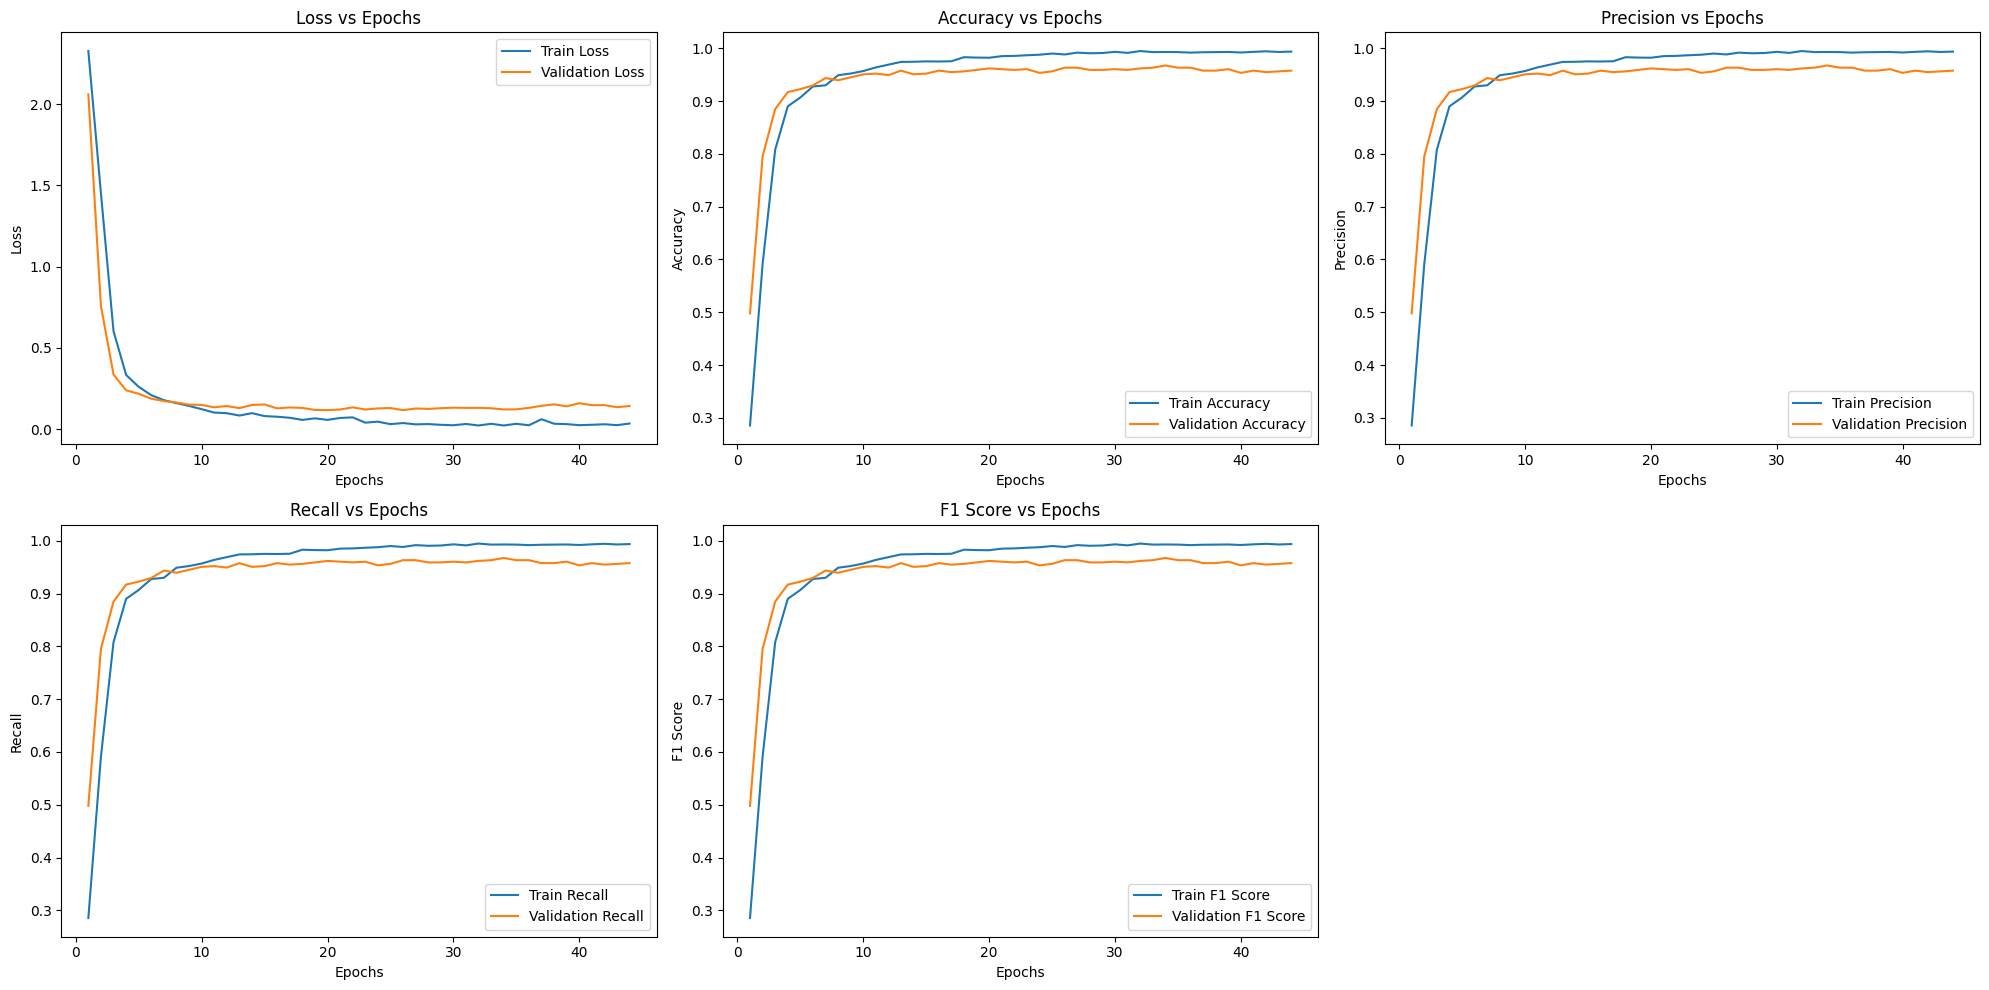

Training complete for efficientnet_b4
Creating submission file for efficientnet_b4


Test [TEST|efficientnet_b4]: 100%|██████████| 13/13 [00:03<00:00,  3.84it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Test results saved to efficientnet_b4/efficientnet_b4_test_results.csv


100%|██████████| 44.7M/44.7M [00:00<00:00, 243MB/s]






Starting training for resnet18
Number of parameters: 11,182,668


Epoch 1/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=70.00%, loss=0.362]


Epoch [1/60], Train Loss: 0.9603, Train Accuracy: 0.7000, Train Precision: 0.7000, Train Recall: 0.7000, Train F1: 0.7000


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [1/60], Validation Loss: 0.3143, Validation Accuracy: 0.9018, Validation Precision: 0.9018, Validation Recall: 0.9018, Validation F1: 0.9018
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.74it/s, accuracy=92.97%, loss=1.53]


Epoch [2/60], Train Loss: 0.2538, Train Accuracy: 0.9297, Train Precision: 0.9297, Train Recall: 0.9297, Train F1: 0.9297


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [2/60], Validation Loss: 0.1833, Validation Accuracy: 0.9467, Validation Precision: 0.9467, Validation Recall: 0.9467, Validation F1: 0.9467
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:28<00:00,  2.23it/s, accuracy=95.29%, loss=0.478]


Epoch [3/60], Train Loss: 0.1585, Train Accuracy: 0.9529, Train Precision: 0.9529, Train Recall: 0.9529, Train F1: 0.9529


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [3/60], Validation Loss: 0.1391, Validation Accuracy: 0.9467, Validation Precision: 0.9467, Validation Recall: 0.9467, Validation F1: 0.9467
Patience: 1/10


Epoch 4/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.68it/s, accuracy=96.76%, loss=0.625]


Epoch [4/60], Train Loss: 0.1196, Train Accuracy: 0.9676, Train Precision: 0.9676, Train Recall: 0.9676, Train F1: 0.9676


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [4/60], Validation Loss: 0.1368, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:22<00:00,  2.80it/s, accuracy=97.42%, loss=0.555]


Epoch [5/60], Train Loss: 0.0968, Train Accuracy: 0.9742, Train Precision: 0.9742, Train Recall: 0.9742, Train F1: 0.9742


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


Epoch [5/60], Validation Loss: 0.1693, Validation Accuracy: 0.9425, Validation Precision: 0.9425, Validation Recall: 0.9425, Validation F1: 0.9425
Patience: 1/10


Epoch 6/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.75it/s, accuracy=97.45%, loss=0.705]


Epoch [6/60], Train Loss: 0.0965, Train Accuracy: 0.9745, Train Precision: 0.9745, Train Recall: 0.9745, Train F1: 0.9745


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [6/60], Validation Loss: 0.1160, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.73it/s, accuracy=97.45%, loss=0.164]


Epoch [7/60], Train Loss: 0.0873, Train Accuracy: 0.9745, Train Precision: 0.9745, Train Recall: 0.9745, Train F1: 0.9745


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [7/60], Validation Loss: 0.1308, Validation Accuracy: 0.9537, Validation Precision: 0.9537, Validation Recall: 0.9537, Validation F1: 0.9537
Patience: 1/10


Epoch 8/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s, accuracy=98.74%, loss=0.137]


Epoch [8/60], Train Loss: 0.0462, Train Accuracy: 0.9874, Train Precision: 0.9874, Train Recall: 0.9874, Train F1: 0.9874


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [8/60], Validation Loss: 0.1418, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Patience: 2/10


Epoch 9/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.74it/s, accuracy=98.93%, loss=0.134]


Epoch [9/60], Train Loss: 0.0395, Train Accuracy: 0.9893, Train Precision: 0.9893, Train Recall: 0.9893, Train F1: 0.9893


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch [9/60], Validation Loss: 0.1122, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Saving best model at epoch 9...


Epoch 10/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.71it/s, accuracy=98.71%, loss=0.151]


Epoch [10/60], Train Loss: 0.0405, Train Accuracy: 0.9871, Train Precision: 0.9871, Train Recall: 0.9871, Train F1: 0.9871


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [10/60], Validation Loss: 0.1079, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 1/10


Epoch 11/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.68it/s, accuracy=98.96%, loss=0.136]


Epoch [11/60], Train Loss: 0.0367, Train Accuracy: 0.9896, Train Precision: 0.9896, Train Recall: 0.9896, Train F1: 0.9896


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [11/60], Validation Loss: 0.1238, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 2/10


Epoch 12/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.67it/s, accuracy=99.48%, loss=0.0216]


Epoch [12/60], Train Loss: 0.0239, Train Accuracy: 0.9948, Train Precision: 0.9948, Train Recall: 0.9948, Train F1: 0.9948


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [12/60], Validation Loss: 0.1154, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Saving best model at epoch 12...


Epoch 13/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:29<00:00,  2.20it/s, accuracy=99.60%, loss=0.327]


Epoch [13/60], Train Loss: 0.0211, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


Epoch [13/60], Validation Loss: 0.0982, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Saving best model at epoch 13...


Epoch 14/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.71it/s, accuracy=99.43%, loss=0.122]


Epoch [14/60], Train Loss: 0.0262, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [14/60], Validation Loss: 0.1077, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 1/10


Epoch 15/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.72it/s, accuracy=99.75%, loss=0.014]


Epoch [15/60], Train Loss: 0.0140, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [15/60], Validation Loss: 0.0936, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Saving best model at epoch 15...


Epoch 16/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.69it/s, accuracy=99.55%, loss=0.185]


Epoch [16/60], Train Loss: 0.0146, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [16/60], Validation Loss: 0.0896, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 1/10


Epoch 17/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:22<00:00,  2.80it/s, accuracy=99.43%, loss=0.508]


Epoch [17/60], Train Loss: 0.0311, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


Epoch [17/60], Validation Loss: 0.0912, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 2/10


Epoch 18/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:28<00:00,  2.22it/s, accuracy=99.55%, loss=0.355]


Epoch [18/60], Train Loss: 0.0248, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [18/60], Validation Loss: 0.0988, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 3/10


Epoch 19/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.73it/s, accuracy=99.46%, loss=0.337]


Epoch [19/60], Train Loss: 0.0317, Train Accuracy: 0.9946, Train Precision: 0.9946, Train Recall: 0.9946, Train F1: 0.9946


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch [19/60], Validation Loss: 0.1053, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 4/10


Epoch 20/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.78it/s, accuracy=99.31%, loss=1.6]


Epoch [20/60], Train Loss: 0.0535, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [20/60], Validation Loss: 0.0927, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 5/10


Epoch 21/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.70it/s, accuracy=99.28%, loss=1.12]


Epoch [21/60], Train Loss: 0.0448, Train Accuracy: 0.9928, Train Precision: 0.9928, Train Recall: 0.9928, Train F1: 0.9928


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [21/60], Validation Loss: 0.1270, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 6/10


Epoch 22/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.70it/s, accuracy=99.08%, loss=0.105]


Epoch [22/60], Train Loss: 0.0436, Train Accuracy: 0.9908, Train Precision: 0.9908, Train Recall: 0.9908, Train F1: 0.9908


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [22/60], Validation Loss: 0.1056, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Saving best model at epoch 22...


Epoch 23/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:29<00:00,  2.18it/s, accuracy=99.80%, loss=0.0645]


Epoch [23/60], Train Loss: 0.0139, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [23/60], Validation Loss: 0.1029, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Saving best model at epoch 23...


Epoch 24/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.69it/s, accuracy=99.88%, loss=0.148]


Epoch [24/60], Train Loss: 0.0095, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [24/60], Validation Loss: 0.1085, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 1/10


Epoch 25/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.75it/s, accuracy=99.88%, loss=0.112]


Epoch [25/60], Train Loss: 0.0085, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch [25/60], Validation Loss: 0.0840, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 2/10


Epoch 26/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.69it/s, accuracy=99.88%, loss=1.18]


Epoch [26/60], Train Loss: 0.0240, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [26/60], Validation Loss: 0.0877, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Saving best model at epoch 26...


Epoch 27/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.70it/s, accuracy=99.26%, loss=0.00715]


Epoch [27/60], Train Loss: 0.0302, Train Accuracy: 0.9926, Train Precision: 0.9926, Train Recall: 0.9926, Train F1: 0.9926


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [27/60], Validation Loss: 0.1000, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 1/10


Epoch 28/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:28<00:00,  2.24it/s, accuracy=99.95%, loss=0.0169]


Epoch [28/60], Train Loss: 0.0062, Train Accuracy: 0.9995, Train Precision: 0.9995, Train Recall: 0.9995, Train F1: 0.9995


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [28/60], Validation Loss: 0.0974, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 2/10


Epoch 29/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.73it/s, accuracy=100.00%, loss=0.0968]


Epoch [29/60], Train Loss: 0.0054, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [29/60], Validation Loss: 0.1093, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 3/10


Epoch 30/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.73it/s, accuracy=99.85%, loss=0.00892]


Epoch [30/60], Train Loss: 0.0053, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [30/60], Validation Loss: 0.0922, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 4/10


Epoch 31/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.78it/s, accuracy=99.98%, loss=0.00927]


Epoch [31/60], Train Loss: 0.0036, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1: 0.9998


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch [31/60], Validation Loss: 0.0968, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 5/10


Epoch 32/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.76it/s, accuracy=99.98%, loss=0.412]


Epoch [32/60], Train Loss: 0.0089, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1: 0.9998


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [32/60], Validation Loss: 0.0952, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 6/10


Epoch 33/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:28<00:00,  2.21it/s, accuracy=99.80%, loss=0.292]


Epoch [33/60], Train Loss: 0.0136, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch [33/60], Validation Loss: 0.1085, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 7/10


Epoch 34/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.69it/s, accuracy=99.90%, loss=0.153]


Epoch [34/60], Train Loss: 0.0092, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1: 0.9990


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [34/60], Validation Loss: 0.1508, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 8/10


Epoch 35/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.70it/s, accuracy=99.95%, loss=0.00113]


Epoch [35/60], Train Loss: 0.0044, Train Accuracy: 0.9995, Train Precision: 0.9995, Train Recall: 0.9995, Train F1: 0.9995


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [35/60], Validation Loss: 0.1207, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 9/10


Epoch 36/60 [TRAIN|resnet18]: 100%|██████████| 64/64 [00:23<00:00,  2.68it/s, accuracy=99.95%, loss=0.482]


Epoch [36/60], Train Loss: 0.0107, Train Accuracy: 0.9995, Train Precision: 0.9995, Train Recall: 0.9995, Train F1: 0.9995


Evaluation [VALID|resnet18]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [36/60], Validation Loss: 0.1399, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to resnet18/resnet18_training_metrics.csv


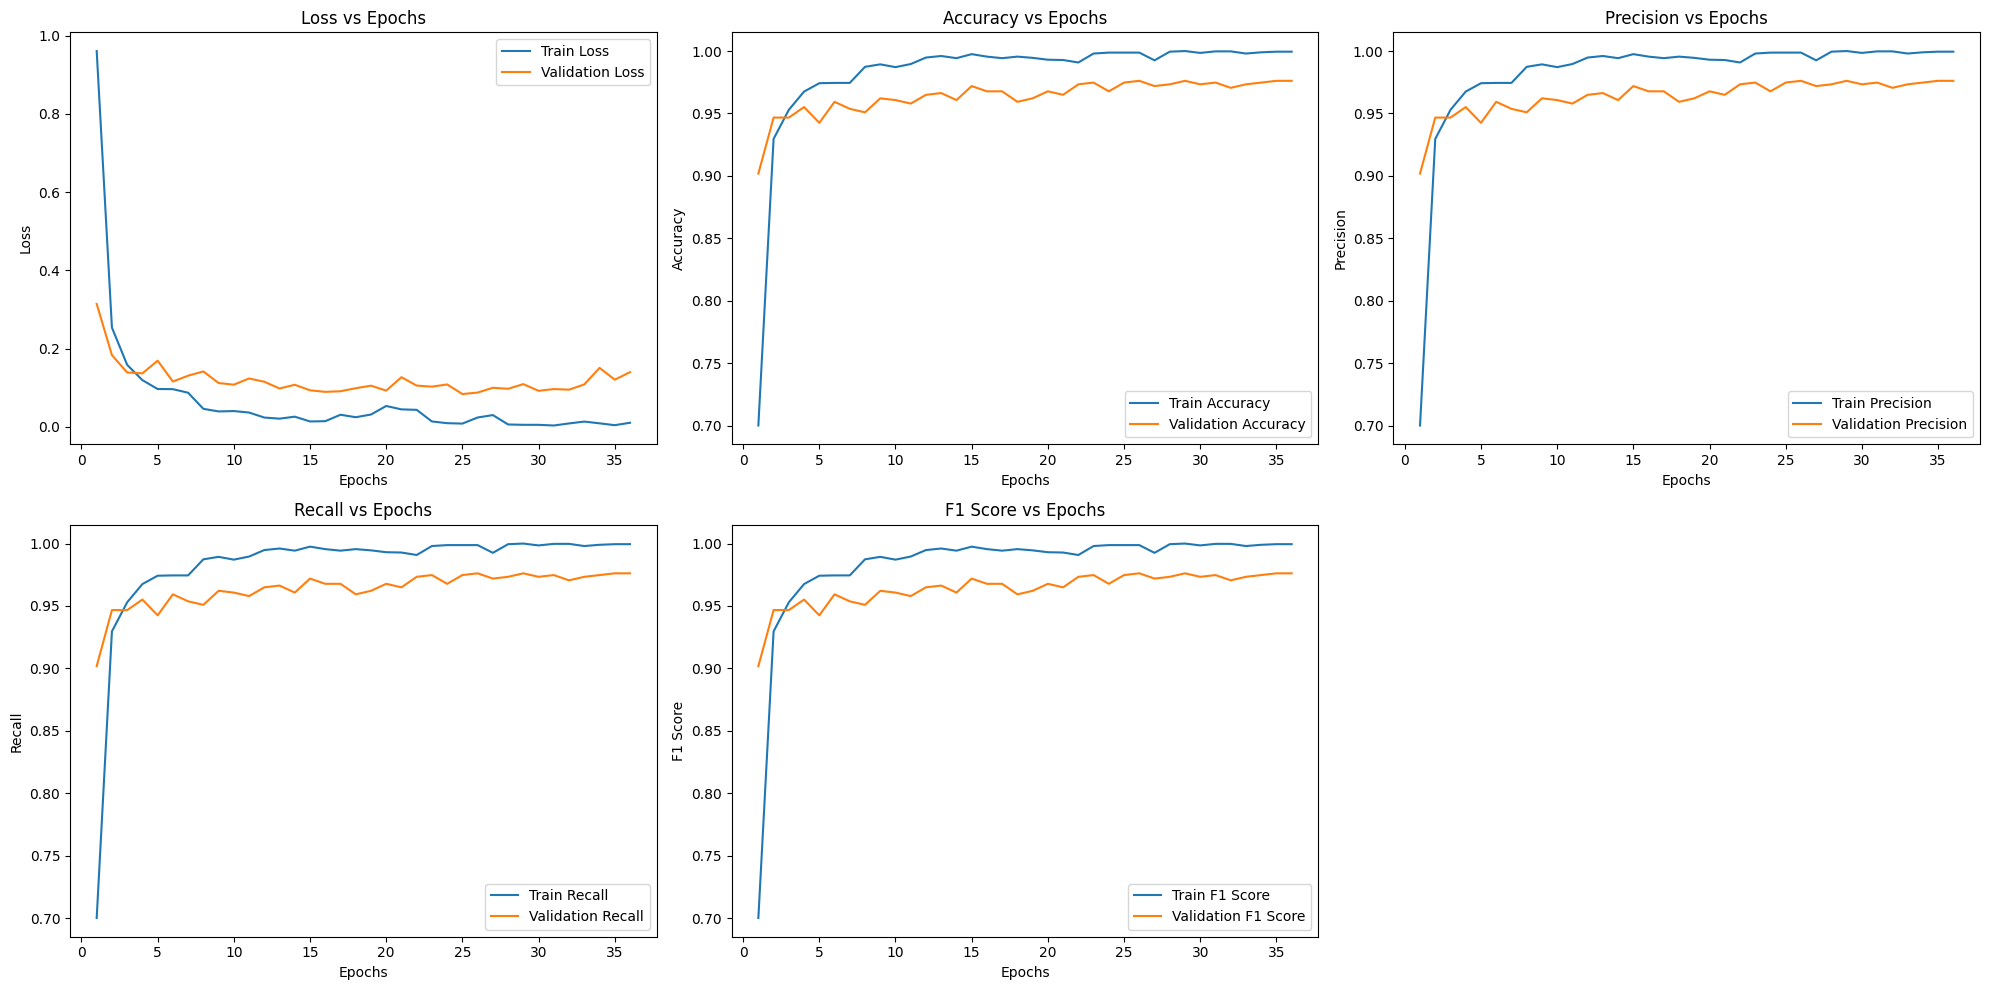

Training complete for resnet18
Creating submission file for resnet18


Test [TEST|resnet18]: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Test results saved to resnet18/resnet18_test_results.csv


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 73.9MB/s]






Starting training for resnet34
Number of parameters: 21,290,828


Epoch 1/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, accuracy=79.07%, loss=0.932]


Epoch [1/60], Train Loss: 0.6880, Train Accuracy: 0.7907, Train Precision: 0.7907, Train Recall: 0.7907, Train F1: 0.7907


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch [1/60], Validation Loss: 0.2835, Validation Accuracy: 0.9060, Validation Precision: 0.9060, Validation Recall: 0.9060, Validation F1: 0.9060
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s, accuracy=92.97%, loss=0.185]


Epoch [2/60], Train Loss: 0.2076, Train Accuracy: 0.9297, Train Precision: 0.9297, Train Recall: 0.9297, Train F1: 0.9297


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [2/60], Validation Loss: 0.1733, Validation Accuracy: 0.9453, Validation Precision: 0.9453, Validation Recall: 0.9453, Validation F1: 0.9453
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=95.52%, loss=0.458]


Epoch [3/60], Train Loss: 0.1408, Train Accuracy: 0.9552, Train Precision: 0.9552, Train Recall: 0.9552, Train F1: 0.9552


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [3/60], Validation Loss: 0.1705, Validation Accuracy: 0.9453, Validation Precision: 0.9453, Validation Recall: 0.9453, Validation F1: 0.9453
Patience: 1/10


Epoch 4/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s, accuracy=96.01%, loss=0.0882]


Epoch [4/60], Train Loss: 0.1225, Train Accuracy: 0.9601, Train Precision: 0.9601, Train Recall: 0.9601, Train F1: 0.9601


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [4/60], Validation Loss: 0.1662, Validation Accuracy: 0.9453, Validation Precision: 0.9453, Validation Recall: 0.9453, Validation F1: 0.9453
Patience: 2/10


Epoch 5/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.65it/s, accuracy=97.77%, loss=0.265]


Epoch [5/60], Train Loss: 0.0730, Train Accuracy: 0.9777, Train Precision: 0.9777, Train Recall: 0.9777, Train F1: 0.9777


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [5/60], Validation Loss: 0.1333, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, accuracy=98.14%, loss=0.25]


Epoch [6/60], Train Loss: 0.0676, Train Accuracy: 0.9814, Train Precision: 0.9814, Train Recall: 0.9814, Train F1: 0.9814


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch [6/60], Validation Loss: 0.1015, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s, accuracy=98.49%, loss=0.507]


Epoch [7/60], Train Loss: 0.0595, Train Accuracy: 0.9849, Train Precision: 0.9849, Train Recall: 0.9849, Train F1: 0.9849


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [7/60], Validation Loss: 0.1797, Validation Accuracy: 0.9495, Validation Precision: 0.9495, Validation Recall: 0.9495, Validation F1: 0.9495
Patience: 1/10


Epoch 8/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s, accuracy=98.34%, loss=0.0269]


Epoch [8/60], Train Loss: 0.0595, Train Accuracy: 0.9834, Train Precision: 0.9834, Train Recall: 0.9834, Train F1: 0.9834


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


Epoch [8/60], Validation Loss: 0.1143, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 2/10


Epoch 9/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=98.76%, loss=0.00507]


Epoch [9/60], Train Loss: 0.0359, Train Accuracy: 0.9876, Train Precision: 0.9876, Train Recall: 0.9876, Train F1: 0.9876


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [9/60], Validation Loss: 0.1417, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 3/10


Epoch 10/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s, accuracy=98.98%, loss=0.297]


Epoch [10/60], Train Loss: 0.0373, Train Accuracy: 0.9898, Train Precision: 0.9898, Train Recall: 0.9898, Train F1: 0.9898


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [10/60], Validation Loss: 0.1189, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 4/10


Epoch 11/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:29<00:00,  2.19it/s, accuracy=98.61%, loss=0.232]


Epoch [11/60], Train Loss: 0.0479, Train Accuracy: 0.9861, Train Precision: 0.9861, Train Recall: 0.9861, Train F1: 0.9861


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


Epoch [11/60], Validation Loss: 0.1501, Validation Accuracy: 0.9481, Validation Precision: 0.9481, Validation Recall: 0.9481, Validation F1: 0.9481
Patience: 5/10


Epoch 12/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=98.89%, loss=0.657]


Epoch [12/60], Train Loss: 0.0508, Train Accuracy: 0.9889, Train Precision: 0.9889, Train Recall: 0.9889, Train F1: 0.9889


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [12/60], Validation Loss: 0.1227, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 6/10


Epoch 13/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.66it/s, accuracy=98.24%, loss=0.0657]


Epoch [13/60], Train Loss: 0.0535, Train Accuracy: 0.9824, Train Precision: 0.9824, Train Recall: 0.9824, Train F1: 0.9824


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [13/60], Validation Loss: 0.1244, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 7/10


Epoch 14/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s, accuracy=98.96%, loss=1.07]


Epoch [14/60], Train Loss: 0.0490, Train Accuracy: 0.9896, Train Precision: 0.9896, Train Recall: 0.9896, Train F1: 0.9896


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [14/60], Validation Loss: 0.0981, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Saving best model at epoch 14...


Epoch 15/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.33%, loss=0.00864]


Epoch [15/60], Train Loss: 0.0220, Train Accuracy: 0.9933, Train Precision: 0.9933, Train Recall: 0.9933, Train F1: 0.9933


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.40it/s]


Epoch [15/60], Validation Loss: 0.0698, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Saving best model at epoch 15...


Epoch 16/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:29<00:00,  2.21it/s, accuracy=99.75%, loss=0.198]


Epoch [16/60], Train Loss: 0.0106, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [16/60], Validation Loss: 0.1054, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 1/10


Epoch 17/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s, accuracy=99.75%, loss=0.0725]


Epoch [17/60], Train Loss: 0.0121, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [17/60], Validation Loss: 0.1030, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 2/10


Epoch 18/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.66it/s, accuracy=99.16%, loss=0.559]


Epoch [18/60], Train Loss: 0.0338, Train Accuracy: 0.9916, Train Precision: 0.9916, Train Recall: 0.9916, Train F1: 0.9916


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [18/60], Validation Loss: 0.1574, Validation Accuracy: 0.9537, Validation Precision: 0.9537, Validation Recall: 0.9537, Validation F1: 0.9537
Patience: 3/10


Epoch 19/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:23<00:00,  2.67it/s, accuracy=99.03%, loss=0.578]


Epoch [19/60], Train Loss: 0.0401, Train Accuracy: 0.9903, Train Precision: 0.9903, Train Recall: 0.9903, Train F1: 0.9903


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


Epoch [19/60], Validation Loss: 0.1330, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 4/10


Epoch 20/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=98.89%, loss=0.462]


Epoch [20/60], Train Loss: 0.0450, Train Accuracy: 0.9889, Train Precision: 0.9889, Train Recall: 0.9889, Train F1: 0.9889


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:05<00:00,  2.00it/s]


Epoch [20/60], Validation Loss: 0.1294, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 5/10


Epoch 21/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=99.13%, loss=0.186]


Epoch [21/60], Train Loss: 0.0317, Train Accuracy: 0.9913, Train Precision: 0.9913, Train Recall: 0.9913, Train F1: 0.9913


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


Epoch [21/60], Validation Loss: 0.1192, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 6/10


Epoch 22/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=99.50%, loss=0.00592]


Epoch [22/60], Train Loss: 0.0198, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [22/60], Validation Loss: 0.1397, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 7/10


Epoch 23/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.65it/s, accuracy=99.26%, loss=0.0244]


Epoch [23/60], Train Loss: 0.0235, Train Accuracy: 0.9926, Train Precision: 0.9926, Train Recall: 0.9926, Train F1: 0.9926


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [23/60], Validation Loss: 0.0955, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 8/10


Epoch 24/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=99.50%, loss=0.2]


Epoch [24/60], Train Loss: 0.0184, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [24/60], Validation Loss: 0.0983, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 9/10


Epoch 25/60 [TRAIN|resnet34]: 100%|██████████| 64/64 [00:26<00:00,  2.41it/s, accuracy=99.63%, loss=0.0513]


Epoch [25/60], Train Loss: 0.0143, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|resnet34]: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch [25/60], Validation Loss: 0.0959, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to resnet34/resnet34_training_metrics.csv


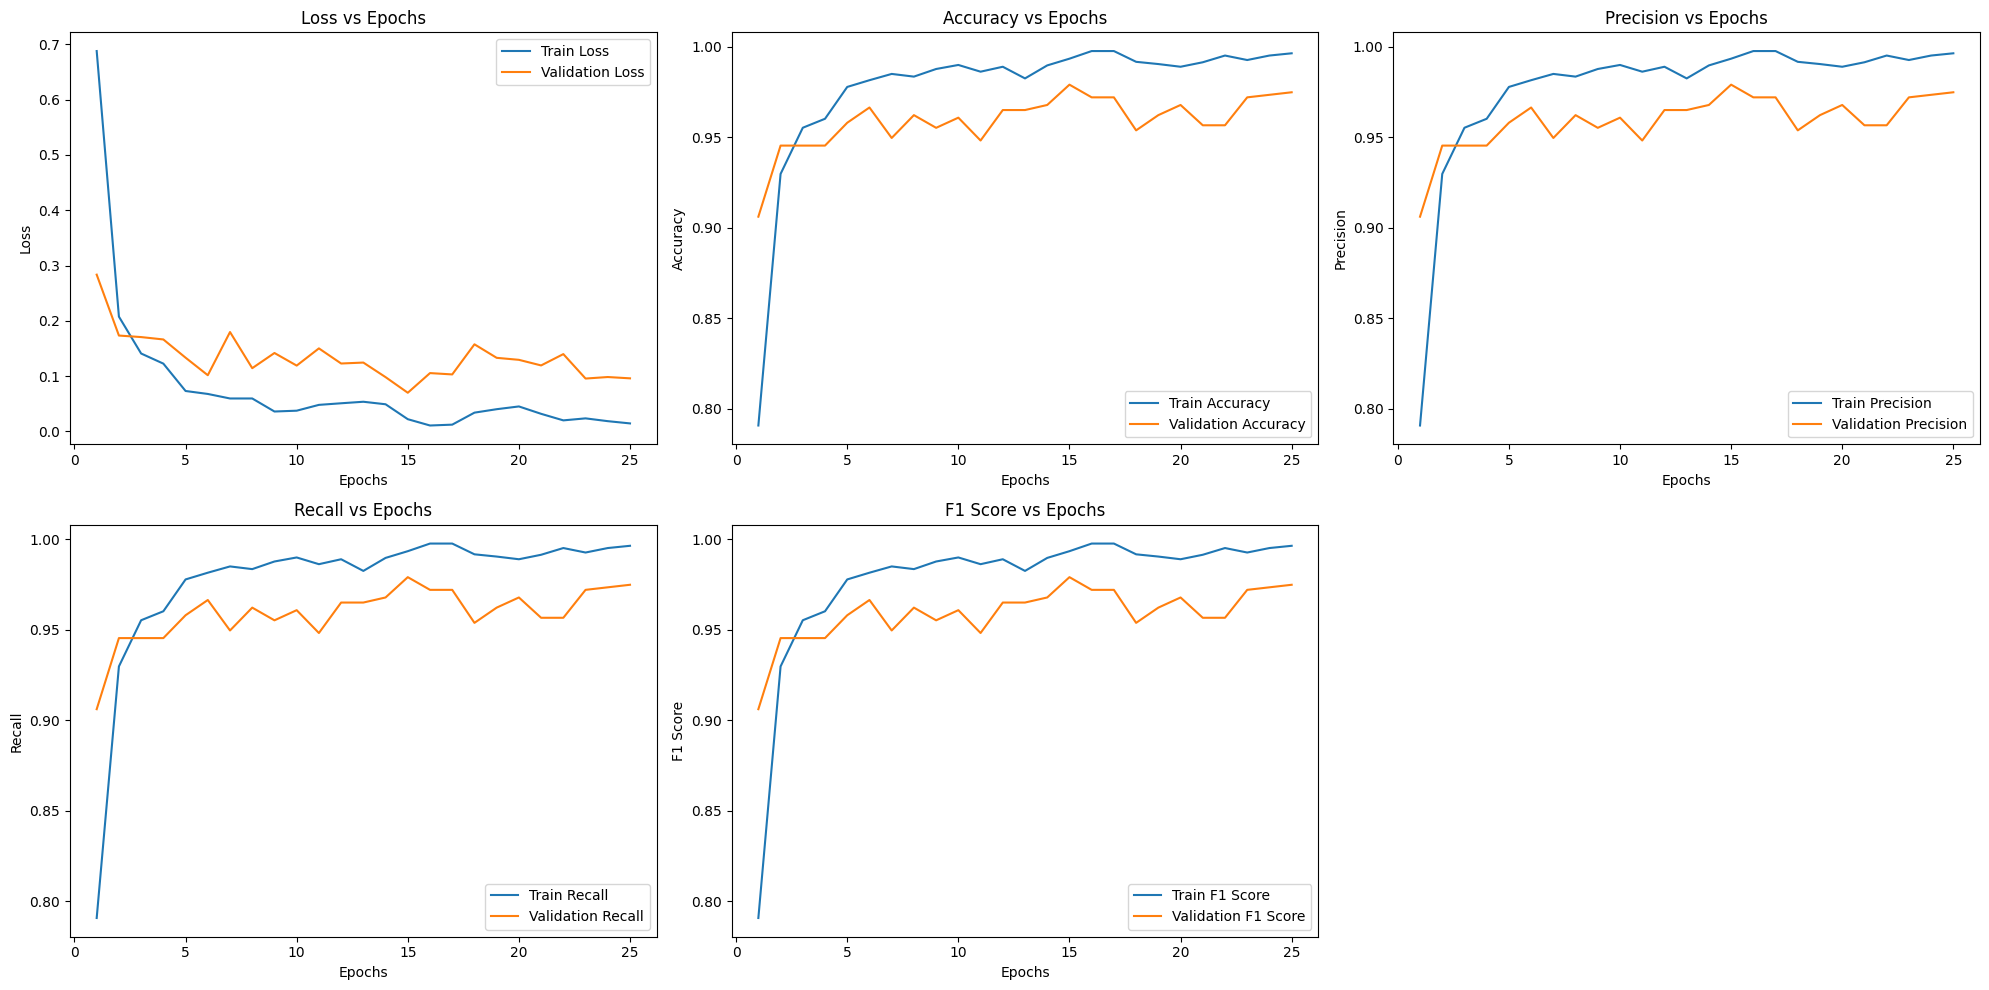

Training complete for resnet34
Creating submission file for resnet34


Test [TEST|resnet34]: 100%|██████████| 13/13 [00:03<00:00,  3.75it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Test results saved to resnet34/resnet34_test_results.csv


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.1MB/s]






Starting training for resnet50
Number of parameters: 23,532,620


Epoch 1/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, accuracy=78.65%, loss=0.365]


Epoch [1/60], Train Loss: 0.7288, Train Accuracy: 0.7865, Train Precision: 0.7865, Train Recall: 0.7865, Train F1: 0.7865


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch [1/60], Validation Loss: 0.2608, Validation Accuracy: 0.9102, Validation Precision: 0.9102, Validation Recall: 0.9102, Validation F1: 0.9102
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=92.59%, loss=0.169]


Epoch [2/60], Train Loss: 0.2170, Train Accuracy: 0.9259, Train Precision: 0.9259, Train Recall: 0.9259, Train F1: 0.9259


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [2/60], Validation Loss: 0.1762, Validation Accuracy: 0.9383, Validation Precision: 0.9383, Validation Recall: 0.9383, Validation F1: 0.9383
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, accuracy=95.34%, loss=0.674]


Epoch [3/60], Train Loss: 0.1460, Train Accuracy: 0.9534, Train Precision: 0.9534, Train Recall: 0.9534, Train F1: 0.9534


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [3/60], Validation Loss: 0.1596, Validation Accuracy: 0.9425, Validation Precision: 0.9425, Validation Recall: 0.9425, Validation F1: 0.9425
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, accuracy=96.31%, loss=0.039]


Epoch [4/60], Train Loss: 0.1147, Train Accuracy: 0.9631, Train Precision: 0.9631, Train Recall: 0.9631, Train F1: 0.9631


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


Epoch [4/60], Validation Loss: 0.1138, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:30<00:00,  2.09it/s, accuracy=97.03%, loss=0.274]


Epoch [5/60], Train Loss: 0.0902, Train Accuracy: 0.9703, Train Precision: 0.9703, Train Recall: 0.9703, Train F1: 0.9703


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [5/60], Validation Loss: 0.1112, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 1/10


Epoch 6/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, accuracy=97.40%, loss=0.0601]


Epoch [6/60], Train Loss: 0.0857, Train Accuracy: 0.9740, Train Precision: 0.9740, Train Recall: 0.9740, Train F1: 0.9740


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [6/60], Validation Loss: 0.1453, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 2/10


Epoch 7/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=98.49%, loss=0.167]


Epoch [7/60], Train Loss: 0.0589, Train Accuracy: 0.9849, Train Precision: 0.9849, Train Recall: 0.9849, Train F1: 0.9849


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [7/60], Validation Loss: 0.0869, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Saving best model at epoch 7...


Epoch 8/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=98.59%, loss=0.241]


Epoch [8/60], Train Loss: 0.0477, Train Accuracy: 0.9859, Train Precision: 0.9859, Train Recall: 0.9859, Train F1: 0.9859


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.86it/s]


Epoch [8/60], Validation Loss: 0.0785, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 1/10


Epoch 9/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s, accuracy=98.02%, loss=0.565]


Epoch [9/60], Train Loss: 0.0759, Train Accuracy: 0.9802, Train Precision: 0.9802, Train Recall: 0.9802, Train F1: 0.9802


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [9/60], Validation Loss: 0.1274, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 2/10


Epoch 10/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=97.94%, loss=0.0171]


Epoch [10/60], Train Loss: 0.0680, Train Accuracy: 0.9794, Train Precision: 0.9794, Train Recall: 0.9794, Train F1: 0.9794


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [10/60], Validation Loss: 0.1095, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 3/10


Epoch 11/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=98.37%, loss=1.9]


Epoch [11/60], Train Loss: 0.0779, Train Accuracy: 0.9837, Train Precision: 0.9837, Train Recall: 0.9837, Train F1: 0.9837


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [11/60], Validation Loss: 0.1037, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 4/10


Epoch 12/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=99.23%, loss=0.0954]


Epoch [12/60], Train Loss: 0.0288, Train Accuracy: 0.9923, Train Precision: 0.9923, Train Recall: 0.9923, Train F1: 0.9923


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [12/60], Validation Loss: 0.0966, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 5/10


Epoch 13/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:29<00:00,  2.14it/s, accuracy=99.23%, loss=0.00392]


Epoch [13/60], Train Loss: 0.0259, Train Accuracy: 0.9923, Train Precision: 0.9923, Train Recall: 0.9923, Train F1: 0.9923


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [13/60], Validation Loss: 0.0766, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Saving best model at epoch 13...


Epoch 14/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.23it/s, accuracy=99.48%, loss=0.526]


Epoch [14/60], Train Loss: 0.0258, Train Accuracy: 0.9948, Train Precision: 0.9948, Train Recall: 0.9948, Train F1: 0.9948


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [14/60], Validation Loss: 0.0721, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 1/10


Epoch 15/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.29it/s, accuracy=98.96%, loss=3.08]


Epoch [15/60], Train Loss: 0.0797, Train Accuracy: 0.9896, Train Precision: 0.9896, Train Recall: 0.9896, Train F1: 0.9896


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [15/60], Validation Loss: 0.1058, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 2/10


Epoch 16/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=98.51%, loss=0.0647]


Epoch [16/60], Train Loss: 0.0563, Train Accuracy: 0.9851, Train Precision: 0.9851, Train Recall: 0.9851, Train F1: 0.9851


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [16/60], Validation Loss: 0.1511, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Patience: 3/10


Epoch 17/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s, accuracy=99.41%, loss=0.0274]


Epoch [17/60], Train Loss: 0.0228, Train Accuracy: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


Epoch [17/60], Validation Loss: 0.0835, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 4/10


Epoch 18/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:31<00:00,  2.03it/s, accuracy=99.58%, loss=0.771]


Epoch [18/60], Train Loss: 0.0286, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1: 0.9958


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [18/60], Validation Loss: 0.0850, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 5/10


Epoch 19/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, accuracy=98.64%, loss=0.507]


Epoch [19/60], Train Loss: 0.0555, Train Accuracy: 0.9864, Train Precision: 0.9864, Train Recall: 0.9864, Train F1: 0.9864


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


Epoch [19/60], Validation Loss: 0.1049, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 6/10


Epoch 20/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, accuracy=99.03%, loss=2.73]


Epoch [20/60], Train Loss: 0.0754, Train Accuracy: 0.9903, Train Precision: 0.9903, Train Recall: 0.9903, Train F1: 0.9903


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [20/60], Validation Loss: 0.1521, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 7/10


Epoch 21/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, accuracy=99.38%, loss=0.0197]


Epoch [21/60], Train Loss: 0.0207, Train Accuracy: 0.9938, Train Precision: 0.9938, Train Recall: 0.9938, Train F1: 0.9938


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [21/60], Validation Loss: 0.0874, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 8/10


Epoch 22/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:30<00:00,  2.10it/s, accuracy=99.85%, loss=0.747]


Epoch [22/60], Train Loss: 0.0186, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch [22/60], Validation Loss: 0.1279, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 9/10


Epoch 23/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, accuracy=99.60%, loss=0.371]


Epoch [23/60], Train Loss: 0.0198, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [23/60], Validation Loss: 0.0960, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Saving best model at epoch 23...


Epoch 24/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=98.79%, loss=0.0481]


Epoch [24/60], Train Loss: 0.0429, Train Accuracy: 0.9879, Train Precision: 0.9879, Train Recall: 0.9879, Train F1: 0.9879


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]


Epoch [24/60], Validation Loss: 0.0848, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 1/10


Epoch 25/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, accuracy=99.78%, loss=0.133]


Epoch [25/60], Train Loss: 0.0134, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [25/60], Validation Loss: 0.0678, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Saving best model at epoch 25...


Epoch 26/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=99.80%, loss=0.00243]


Epoch [26/60], Train Loss: 0.0085, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch [26/60], Validation Loss: 0.0909, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 1/10


Epoch 27/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:30<00:00,  2.10it/s, accuracy=99.93%, loss=0.0249]


Epoch [27/60], Train Loss: 0.0040, Train Accuracy: 0.9993, Train Precision: 0.9993, Train Recall: 0.9993, Train F1: 0.9993


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch [27/60], Validation Loss: 0.0725, Validation Accuracy: 0.9804, Validation Precision: 0.9804, Validation Recall: 0.9804, Validation F1: 0.9804
Saving best model at epoch 27...


Epoch 28/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, accuracy=99.93%, loss=0.0429]


Epoch [28/60], Train Loss: 0.0039, Train Accuracy: 0.9993, Train Precision: 0.9993, Train Recall: 0.9993, Train F1: 0.9993


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch [28/60], Validation Loss: 0.0759, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 1/10


Epoch 29/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, accuracy=99.83%, loss=0.257]


Epoch [29/60], Train Loss: 0.0090, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [29/60], Validation Loss: 0.0993, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 2/10


Epoch 30/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.65%, loss=0.107]


Epoch [30/60], Train Loss: 0.0129, Train Accuracy: 0.9965, Train Precision: 0.9965, Train Recall: 0.9965, Train F1: 0.9965


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [30/60], Validation Loss: 0.0871, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 3/10


Epoch 31/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:32<00:00,  1.98it/s, accuracy=99.73%, loss=1.51]


Epoch [31/60], Train Loss: 0.0317, Train Accuracy: 0.9973, Train Precision: 0.9973, Train Recall: 0.9973, Train F1: 0.9973


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch [31/60], Validation Loss: 0.0879, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 4/10


Epoch 32/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.23it/s, accuracy=99.63%, loss=0.202]


Epoch [32/60], Train Loss: 0.0172, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [32/60], Validation Loss: 0.0951, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 5/10


Epoch 33/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:29<00:00,  2.20it/s, accuracy=99.60%, loss=0.32]


Epoch [33/60], Train Loss: 0.0177, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


Epoch [33/60], Validation Loss: 0.0840, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Patience: 6/10


Epoch 34/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.21it/s, accuracy=99.73%, loss=0.243]


Epoch [34/60], Train Loss: 0.0170, Train Accuracy: 0.9973, Train Precision: 0.9973, Train Recall: 0.9973, Train F1: 0.9973


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


Epoch [34/60], Validation Loss: 0.0918, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 7/10


Epoch 35/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:31<00:00,  2.05it/s, accuracy=99.80%, loss=0.497]


Epoch [35/60], Train Loss: 0.0134, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Epoch [35/60], Validation Loss: 0.0698, Validation Accuracy: 0.9860, Validation Precision: 0.9860, Validation Recall: 0.9860, Validation F1: 0.9860
Saving best model at epoch 35...


Epoch 36/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s, accuracy=99.48%, loss=0.744]


Epoch [36/60], Train Loss: 0.0285, Train Accuracy: 0.9948, Train Precision: 0.9948, Train Recall: 0.9948, Train F1: 0.9948


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [36/60], Validation Loss: 0.0759, Validation Accuracy: 0.9832, Validation Precision: 0.9832, Validation Recall: 0.9832, Validation F1: 0.9832
Patience: 1/10


Epoch 37/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.29it/s, accuracy=99.26%, loss=0.0606]


Epoch [37/60], Train Loss: 0.0219, Train Accuracy: 0.9926, Train Precision: 0.9926, Train Recall: 0.9926, Train F1: 0.9926


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [37/60], Validation Loss: 0.0858, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 2/10


Epoch 38/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.78%, loss=0.00417]


Epoch [38/60], Train Loss: 0.0090, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


Epoch [38/60], Validation Loss: 0.0637, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Patience: 3/10


Epoch 39/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.37it/s, accuracy=99.88%, loss=0.588]


Epoch [39/60], Train Loss: 0.0137, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch [39/60], Validation Loss: 0.0849, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Patience: 4/10


Epoch 40/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:31<00:00,  2.02it/s, accuracy=99.78%, loss=0.252]


Epoch [40/60], Train Loss: 0.0131, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [40/60], Validation Loss: 0.0845, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 5/10


Epoch 41/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s, accuracy=100.00%, loss=0.0214]


Epoch [41/60], Train Loss: 0.0025, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [41/60], Validation Loss: 0.0826, Validation Accuracy: 0.9762, Validation Precision: 0.9762, Validation Recall: 0.9762, Validation F1: 0.9762
Patience: 6/10


Epoch 42/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, accuracy=99.95%, loss=0.00151]


Epoch [42/60], Train Loss: 0.0028, Train Accuracy: 0.9995, Train Precision: 0.9995, Train Recall: 0.9995, Train F1: 0.9995


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch [42/60], Validation Loss: 0.0782, Validation Accuracy: 0.9790, Validation Precision: 0.9790, Validation Recall: 0.9790, Validation F1: 0.9790
Patience: 7/10


Epoch 43/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, accuracy=99.95%, loss=0.0477]


Epoch [43/60], Train Loss: 0.0035, Train Accuracy: 0.9995, Train Precision: 0.9995, Train Recall: 0.9995, Train F1: 0.9995


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [43/60], Validation Loss: 0.0827, Validation Accuracy: 0.9818, Validation Precision: 0.9818, Validation Recall: 0.9818, Validation F1: 0.9818
Patience: 8/10


Epoch 44/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:32<00:00,  1.96it/s, accuracy=100.00%, loss=0.259]


Epoch [44/60], Train Loss: 0.0058, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


Epoch [44/60], Validation Loss: 0.0819, Validation Accuracy: 0.9776, Validation Precision: 0.9776, Validation Recall: 0.9776, Validation F1: 0.9776
Patience: 9/10


Epoch 45/60 [TRAIN|resnet50]: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, accuracy=99.78%, loss=0.0378]


Epoch [45/60], Train Loss: 0.0074, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|resnet50]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [45/60], Validation Loss: 0.0741, Validation Accuracy: 0.9818, Validation Precision: 0.9818, Validation Recall: 0.9818, Validation F1: 0.9818
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to resnet50/resnet50_training_metrics.csv


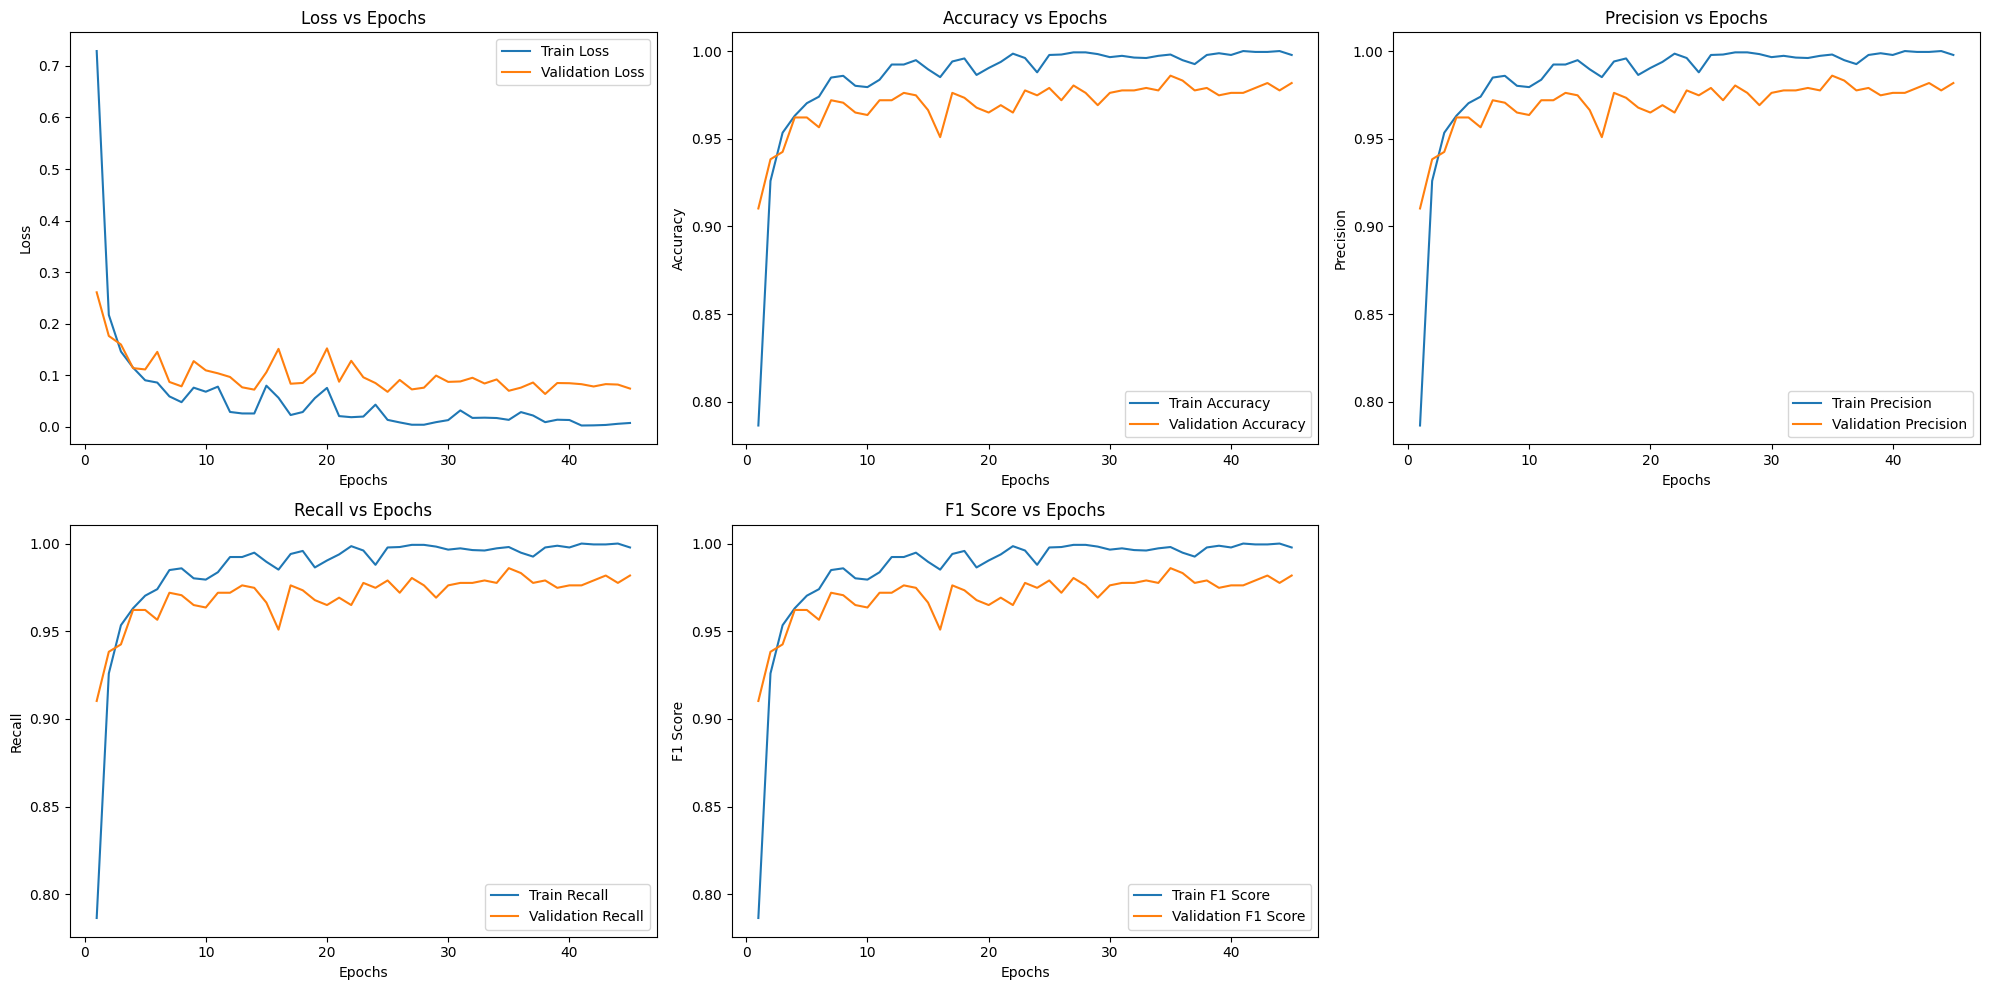

Training complete for resnet50
Creating submission file for resnet50


Test [TEST|resnet50]: 100%|██████████| 13/13 [00:02<00:00,  4.33it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


Test results saved to resnet50/resnet50_test_results.csv


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 72.6MB/s]






Starting training for resnet101
Number of parameters: 42,524,748


Epoch 1/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=81.35%, loss=0.166]


Epoch [1/60], Train Loss: 0.6464, Train Accuracy: 0.8135, Train Precision: 0.8135, Train Recall: 0.8135, Train F1: 0.8135


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Epoch [1/60], Validation Loss: 0.2550, Validation Accuracy: 0.9144, Validation Precision: 0.9144, Validation Recall: 0.9144, Validation F1: 0.9144
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=94.67%, loss=0.876]


Epoch [2/60], Train Loss: 0.1797, Train Accuracy: 0.9467, Train Precision: 0.9467, Train Recall: 0.9467, Train F1: 0.9467


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch [2/60], Validation Loss: 0.2058, Validation Accuracy: 0.9327, Validation Precision: 0.9327, Validation Recall: 0.9327, Validation F1: 0.9327
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s, accuracy=95.24%, loss=0.0533]


Epoch [3/60], Train Loss: 0.1497, Train Accuracy: 0.9524, Train Precision: 0.9524, Train Recall: 0.9524, Train F1: 0.9524


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch [3/60], Validation Loss: 0.1522, Validation Accuracy: 0.9439, Validation Precision: 0.9439, Validation Recall: 0.9439, Validation F1: 0.9439
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s, accuracy=97.05%, loss=0.249]


Epoch [4/60], Train Loss: 0.0930, Train Accuracy: 0.9705, Train Precision: 0.9705, Train Recall: 0.9705, Train F1: 0.9705


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [4/60], Validation Loss: 0.1672, Validation Accuracy: 0.9495, Validation Precision: 0.9495, Validation Recall: 0.9495, Validation F1: 0.9495
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=97.45%, loss=0.0649]


Epoch [5/60], Train Loss: 0.0850, Train Accuracy: 0.9745, Train Precision: 0.9745, Train Recall: 0.9745, Train F1: 0.9745


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Epoch [5/60], Validation Loss: 0.2031, Validation Accuracy: 0.9327, Validation Precision: 0.9327, Validation Recall: 0.9327, Validation F1: 0.9327
Patience: 1/10


Epoch 6/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:40<00:00,  1.58it/s, accuracy=97.77%, loss=0.154]


Epoch [6/60], Train Loss: 0.0659, Train Accuracy: 0.9777, Train Precision: 0.9777, Train Recall: 0.9777, Train F1: 0.9777


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [6/60], Validation Loss: 0.1325, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=98.27%, loss=0.143]


Epoch [7/60], Train Loss: 0.0511, Train Accuracy: 0.9827, Train Precision: 0.9827, Train Recall: 0.9827, Train F1: 0.9827


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch [7/60], Validation Loss: 0.2404, Validation Accuracy: 0.9383, Validation Precision: 0.9383, Validation Recall: 0.9383, Validation F1: 0.9383
Patience: 1/10


Epoch 8/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=98.24%, loss=2.25]


Epoch [8/60], Train Loss: 0.0888, Train Accuracy: 0.9824, Train Precision: 0.9824, Train Recall: 0.9824, Train F1: 0.9824


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [8/60], Validation Loss: 0.1565, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Saving best model at epoch 8...


Epoch 9/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s, accuracy=98.69%, loss=0.819]


Epoch [9/60], Train Loss: 0.0500, Train Accuracy: 0.9869, Train Precision: 0.9869, Train Recall: 0.9869, Train F1: 0.9869


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch [9/60], Validation Loss: 0.1403, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 1/10


Epoch 10/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=98.49%, loss=0.714]


Epoch [10/60], Train Loss: 0.0614, Train Accuracy: 0.9849, Train Precision: 0.9849, Train Recall: 0.9849, Train F1: 0.9849


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch [10/60], Validation Loss: 0.1633, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 2/10


Epoch 11/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s, accuracy=98.98%, loss=0.252]


Epoch [11/60], Train Loss: 0.0455, Train Accuracy: 0.9898, Train Precision: 0.9898, Train Recall: 0.9898, Train F1: 0.9898


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [11/60], Validation Loss: 0.1445, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 3/10


Epoch 12/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s, accuracy=99.16%, loss=0.11]


Epoch [12/60], Train Loss: 0.0362, Train Accuracy: 0.9916, Train Precision: 0.9916, Train Recall: 0.9916, Train F1: 0.9916


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [12/60], Validation Loss: 0.1532, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Patience: 4/10


Epoch 13/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=98.86%, loss=0.213]


Epoch [13/60], Train Loss: 0.0364, Train Accuracy: 0.9886, Train Precision: 0.9886, Train Recall: 0.9886, Train F1: 0.9886


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [13/60], Validation Loss: 0.1269, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Saving best model at epoch 13...


Epoch 14/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=98.74%, loss=0.0717]


Epoch [14/60], Train Loss: 0.0391, Train Accuracy: 0.9874, Train Precision: 0.9874, Train Recall: 0.9874, Train F1: 0.9874


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [14/60], Validation Loss: 0.1453, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 1/10


Epoch 15/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.64it/s, accuracy=98.89%, loss=0.00201]


Epoch [15/60], Train Loss: 0.0364, Train Accuracy: 0.9889, Train Precision: 0.9889, Train Recall: 0.9889, Train F1: 0.9889


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch [15/60], Validation Loss: 0.1544, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 2/10


Epoch 16/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=99.65%, loss=1.07]


Epoch [16/60], Train Loss: 0.0272, Train Accuracy: 0.9965, Train Precision: 0.9965, Train Recall: 0.9965, Train F1: 0.9965


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [16/60], Validation Loss: 0.1661, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 3/10


Epoch 17/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=98.56%, loss=0.0166]


Epoch [17/60], Train Loss: 0.0604, Train Accuracy: 0.9856, Train Precision: 0.9856, Train Recall: 0.9856, Train F1: 0.9856


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch [17/60], Validation Loss: 0.1653, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 4/10


Epoch 18/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.64it/s, accuracy=99.28%, loss=1.02]


Epoch [18/60], Train Loss: 0.0384, Train Accuracy: 0.9928, Train Precision: 0.9928, Train Recall: 0.9928, Train F1: 0.9928


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch [18/60], Validation Loss: 0.1786, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 5/10


Epoch 19/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s, accuracy=98.49%, loss=0.201]


Epoch [19/60], Train Loss: 0.0603, Train Accuracy: 0.9849, Train Precision: 0.9849, Train Recall: 0.9849, Train F1: 0.9849


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


Epoch [19/60], Validation Loss: 0.1644, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Patience: 6/10


Epoch 20/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=99.48%, loss=0.159]


Epoch [20/60], Train Loss: 0.0193, Train Accuracy: 0.9948, Train Precision: 0.9948, Train Recall: 0.9948, Train F1: 0.9948


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch [20/60], Validation Loss: 0.1424, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 7/10


Epoch 21/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s, accuracy=99.23%, loss=0.127]


Epoch [21/60], Train Loss: 0.0258, Train Accuracy: 0.9923, Train Precision: 0.9923, Train Recall: 0.9923, Train F1: 0.9923


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


Epoch [21/60], Validation Loss: 0.2012, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 8/10


Epoch 22/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s, accuracy=99.31%, loss=0.00239]


Epoch [22/60], Train Loss: 0.0201, Train Accuracy: 0.9931, Train Precision: 0.9931, Train Recall: 0.9931, Train F1: 0.9931


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch [22/60], Validation Loss: 0.1403, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 9/10


Epoch 23/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=99.83%, loss=0.0578]


Epoch [23/60], Train Loss: 0.0073, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Epoch [23/60], Validation Loss: 0.1517, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Saving best model at epoch 23...


Epoch 24/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=99.80%, loss=0.058]


Epoch [24/60], Train Loss: 0.0095, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [24/60], Validation Loss: 0.1361, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Saving best model at epoch 24...


Epoch 25/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=99.90%, loss=0.534]


Epoch [25/60], Train Loss: 0.0124, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1: 0.9990


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Epoch [25/60], Validation Loss: 0.1480, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 1/10


Epoch 26/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, accuracy=99.41%, loss=0.0499]


Epoch [26/60], Train Loss: 0.0201, Train Accuracy: 0.9941, Train Precision: 0.9941, Train Recall: 0.9941, Train F1: 0.9941


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


Epoch [26/60], Validation Loss: 0.2032, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 2/10


Epoch 27/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=99.80%, loss=0.155]


Epoch [27/60], Train Loss: 0.0105, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Epoch [27/60], Validation Loss: 0.1428, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 3/10


Epoch 28/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=99.85%, loss=0.00237]


Epoch [28/60], Train Loss: 0.0065, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch [28/60], Validation Loss: 0.1555, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Saving best model at epoch 28...


Epoch 29/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=99.90%, loss=0.0289]


Epoch [29/60], Train Loss: 0.0033, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1: 0.9990


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


Epoch [29/60], Validation Loss: 0.1480, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 1/10


Epoch 30/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s, accuracy=100.00%, loss=0.124]


Epoch [30/60], Train Loss: 0.0039, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Epoch [30/60], Validation Loss: 0.1798, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 2/10


Epoch 31/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=99.90%, loss=0.301]


Epoch [31/60], Train Loss: 0.0082, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1: 0.9990


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Epoch [31/60], Validation Loss: 0.1914, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 3/10


Epoch 32/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:40<00:00,  1.59it/s, accuracy=99.68%, loss=0.17]


Epoch [32/60], Train Loss: 0.0169, Train Accuracy: 0.9968, Train Precision: 0.9968, Train Recall: 0.9968, Train F1: 0.9968


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch [32/60], Validation Loss: 0.2008, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 4/10


Epoch 33/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=99.83%, loss=0.512]


Epoch [33/60], Train Loss: 0.0161, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


Epoch [33/60], Validation Loss: 0.1982, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 5/10


Epoch 34/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s, accuracy=99.58%, loss=0.00227]


Epoch [34/60], Train Loss: 0.0137, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1: 0.9958


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch [34/60], Validation Loss: 0.1979, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 6/10


Epoch 35/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s, accuracy=99.85%, loss=0.00469]


Epoch [35/60], Train Loss: 0.0064, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch [35/60], Validation Loss: 0.1861, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 7/10


Epoch 36/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s, accuracy=99.88%, loss=0.00461]


Epoch [36/60], Train Loss: 0.0044, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [36/60], Validation Loss: 0.1670, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 8/10


Epoch 37/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, accuracy=99.78%, loss=0.0419]


Epoch [37/60], Train Loss: 0.0073, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


Epoch [37/60], Validation Loss: 0.1758, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 9/10


Epoch 38/60 [TRAIN|resnet101]: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s, accuracy=99.98%, loss=0.534]


Epoch [38/60], Train Loss: 0.0101, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1: 0.9998


Evaluation [VALID|resnet101]: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


Epoch [38/60], Validation Loss: 0.1620, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to resnet101/resnet101_training_metrics.csv


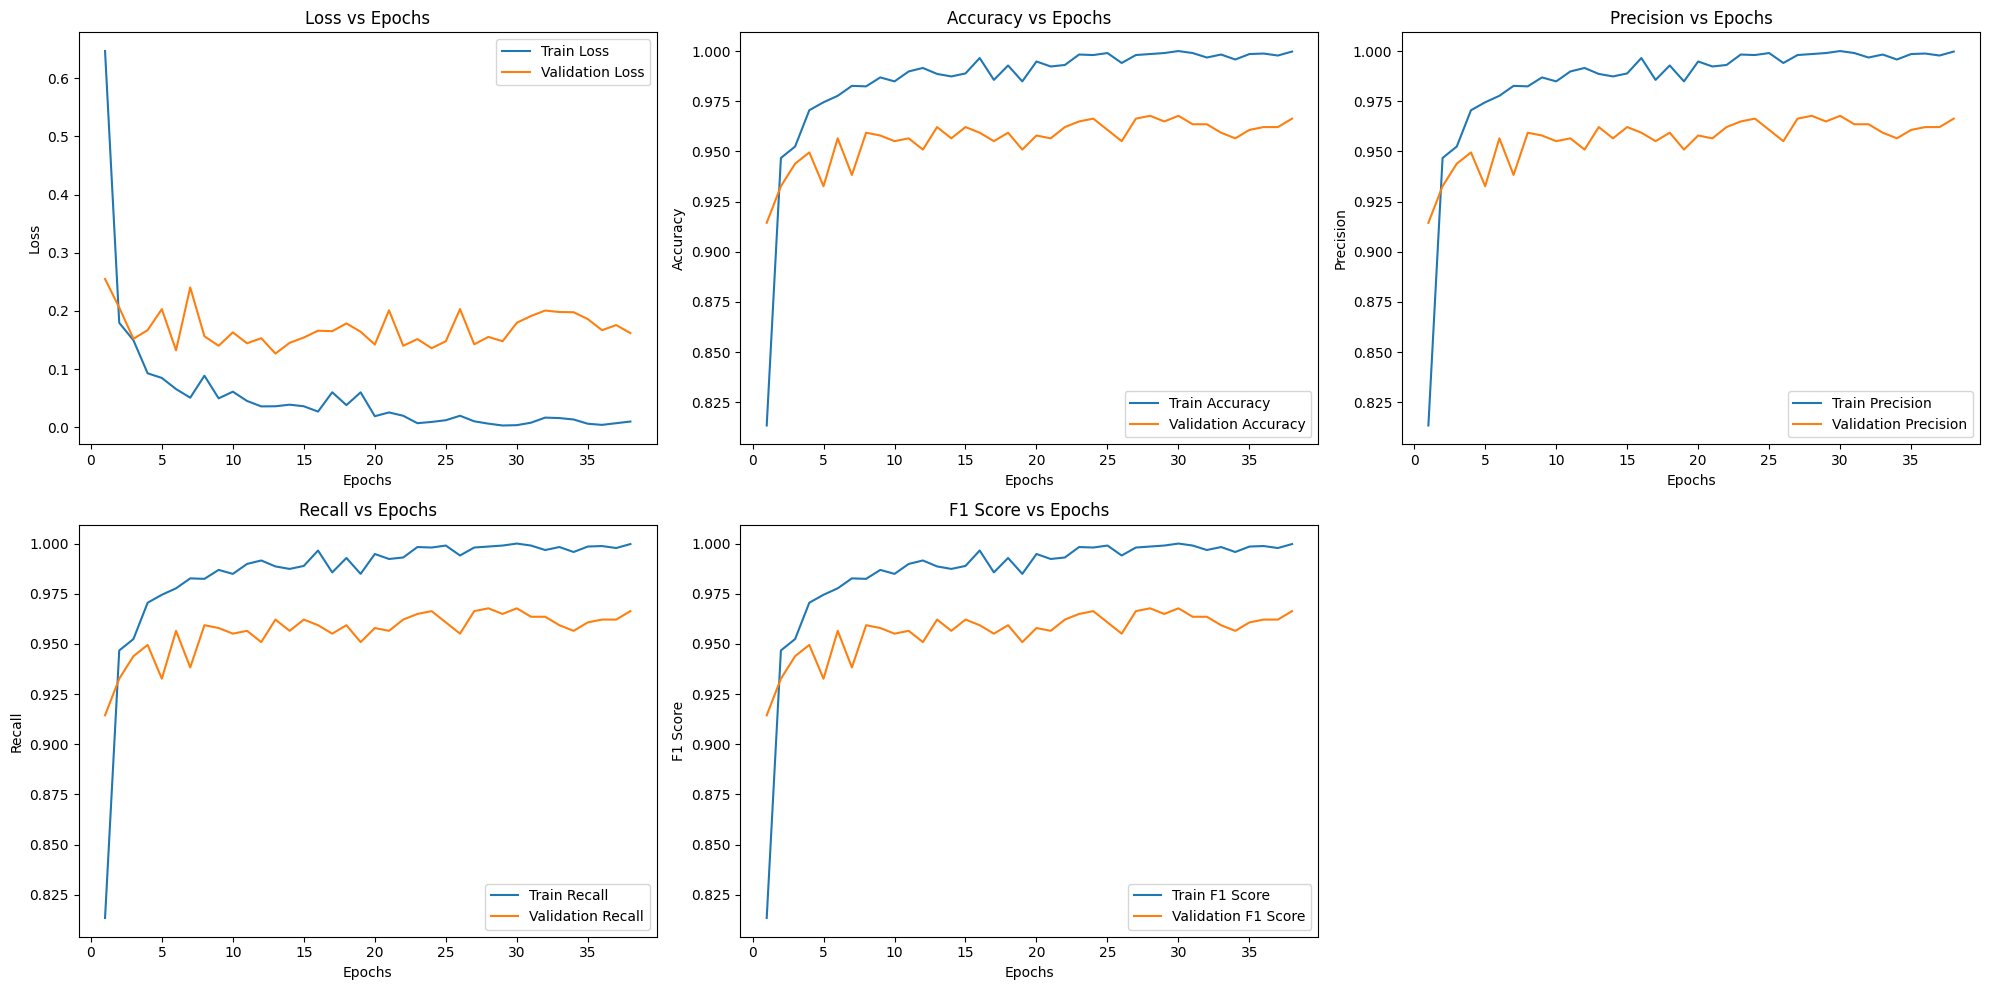

Training complete for resnet101
Creating submission file for resnet101


Test [TEST|resnet101]: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Test results saved to resnet101/resnet101_test_results.csv


100%|██████████| 13.6M/13.6M [00:00<00:00, 83.9MB/s]






Starting training for mobilenet_v2
Number of parameters: 2,239,244


Epoch 1/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.64it/s, accuracy=65.35%, loss=0.637]


Epoch [1/60], Train Loss: 1.1648, Train Accuracy: 0.6535, Train Precision: 0.6535, Train Recall: 0.6535, Train F1: 0.6535


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [1/60], Validation Loss: 0.4510, Validation Accuracy: 0.8794, Validation Precision: 0.8794, Validation Recall: 0.8794, Validation F1: 0.8794
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.64it/s, accuracy=91.03%, loss=0.27]


Epoch [2/60], Train Loss: 0.2962, Train Accuracy: 0.9103, Train Precision: 0.9103, Train Recall: 0.9103, Train F1: 0.9103


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch [2/60], Validation Loss: 0.2761, Validation Accuracy: 0.9313, Validation Precision: 0.9313, Validation Recall: 0.9313, Validation F1: 0.9313
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.66it/s, accuracy=94.13%, loss=0.319]


Epoch [3/60], Train Loss: 0.1863, Train Accuracy: 0.9413, Train Precision: 0.9413, Train Recall: 0.9413, Train F1: 0.9413


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch [3/60], Validation Loss: 0.2272, Validation Accuracy: 0.9397, Validation Precision: 0.9397, Validation Recall: 0.9397, Validation F1: 0.9397
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:25<00:00,  2.48it/s, accuracy=95.91%, loss=0.517]


Epoch [4/60], Train Loss: 0.1391, Train Accuracy: 0.9591, Train Precision: 0.9591, Train Recall: 0.9591, Train F1: 0.9591


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


Epoch [4/60], Validation Loss: 0.1786, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, accuracy=96.83%, loss=0.546]


Epoch [5/60], Train Loss: 0.1100, Train Accuracy: 0.9683, Train Precision: 0.9683, Train Recall: 0.9683, Train F1: 0.9683


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [5/60], Validation Loss: 0.1774, Validation Accuracy: 0.9495, Validation Precision: 0.9495, Validation Recall: 0.9495, Validation F1: 0.9495
Patience: 1/10


Epoch 6/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s, accuracy=97.92%, loss=1.43]


Epoch [6/60], Train Loss: 0.0919, Train Accuracy: 0.9792, Train Precision: 0.9792, Train Recall: 0.9792, Train F1: 0.9792


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [6/60], Validation Loss: 0.1777, Validation Accuracy: 0.9579, Validation Precision: 0.9579, Validation Recall: 0.9579, Validation F1: 0.9579
Patience: 2/10


Epoch 7/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s, accuracy=98.32%, loss=0.656]


Epoch [7/60], Train Loss: 0.0696, Train Accuracy: 0.9832, Train Precision: 0.9832, Train Recall: 0.9832, Train F1: 0.9832


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [7/60], Validation Loss: 0.1847, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Saving best model at epoch 7...


Epoch 8/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=97.62%, loss=0.102]


Epoch [8/60], Train Loss: 0.0769, Train Accuracy: 0.9762, Train Precision: 0.9762, Train Recall: 0.9762, Train F1: 0.9762


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


Epoch [8/60], Validation Loss: 0.1711, Validation Accuracy: 0.9551, Validation Precision: 0.9551, Validation Recall: 0.9551, Validation F1: 0.9551
Patience: 1/10


Epoch 9/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, accuracy=98.61%, loss=0.0434]


Epoch [9/60], Train Loss: 0.0473, Train Accuracy: 0.9861, Train Precision: 0.9861, Train Recall: 0.9861, Train F1: 0.9861


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch [9/60], Validation Loss: 0.1561, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 2/10


Epoch 10/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:25<00:00,  2.47it/s, accuracy=99.06%, loss=1.26]


Epoch [10/60], Train Loss: 0.0538, Train Accuracy: 0.9906, Train Precision: 0.9906, Train Recall: 0.9906, Train F1: 0.9906


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [10/60], Validation Loss: 0.1594, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 3/10


Epoch 11/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.58it/s, accuracy=98.27%, loss=0.141]


Epoch [11/60], Train Loss: 0.0650, Train Accuracy: 0.9827, Train Precision: 0.9827, Train Recall: 0.9827, Train F1: 0.9827


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [11/60], Validation Loss: 0.2064, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Saving best model at epoch 11...


Epoch 12/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.58it/s, accuracy=98.89%, loss=0.0323]


Epoch [12/60], Train Loss: 0.0368, Train Accuracy: 0.9889, Train Precision: 0.9889, Train Recall: 0.9889, Train F1: 0.9889


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [12/60], Validation Loss: 0.2154, Validation Accuracy: 0.9607, Validation Precision: 0.9607, Validation Recall: 0.9607, Validation F1: 0.9607
Patience: 1/10


Epoch 13/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=99.21%, loss=0.0906]


Epoch [13/60], Train Loss: 0.0279, Train Accuracy: 0.9921, Train Precision: 0.9921, Train Recall: 0.9921, Train F1: 0.9921


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [13/60], Validation Loss: 0.1708, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Saving best model at epoch 13...


Epoch 14/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:28<00:00,  2.24it/s, accuracy=99.55%, loss=0.0553]


Epoch [14/60], Train Loss: 0.0207, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch [14/60], Validation Loss: 0.1688, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Saving best model at epoch 14...


Epoch 15/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=99.28%, loss=0.555]


Epoch [15/60], Train Loss: 0.0305, Train Accuracy: 0.9928, Train Precision: 0.9928, Train Recall: 0.9928, Train F1: 0.9928


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [15/60], Validation Loss: 0.2226, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 1/10


Epoch 16/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=99.08%, loss=0.125]


Epoch [16/60], Train Loss: 0.0354, Train Accuracy: 0.9908, Train Precision: 0.9908, Train Recall: 0.9908, Train F1: 0.9908


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [16/60], Validation Loss: 0.1903, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 2/10


Epoch 17/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:23<00:00,  2.68it/s, accuracy=99.50%, loss=0.959]


Epoch [17/60], Train Loss: 0.0353, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch [17/60], Validation Loss: 0.1848, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 3/10


Epoch 18/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:23<00:00,  2.69it/s, accuracy=98.79%, loss=0.159]


Epoch [18/60], Train Loss: 0.0438, Train Accuracy: 0.9879, Train Precision: 0.9879, Train Recall: 0.9879, Train F1: 0.9879


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]


Epoch [18/60], Validation Loss: 0.1384, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 4/10


Epoch 19/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:28<00:00,  2.23it/s, accuracy=99.28%, loss=0.447]


Epoch [19/60], Train Loss: 0.0297, Train Accuracy: 0.9928, Train Precision: 0.9928, Train Recall: 0.9928, Train F1: 0.9928


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


Epoch [19/60], Validation Loss: 0.1580, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 5/10


Epoch 20/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.64it/s, accuracy=99.60%, loss=0.0471]


Epoch [20/60], Train Loss: 0.0182, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [20/60], Validation Loss: 0.1428, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 6/10


Epoch 21/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.61it/s, accuracy=99.78%, loss=0.305]


Epoch [21/60], Train Loss: 0.0146, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]


Epoch [21/60], Validation Loss: 0.1409, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Saving best model at epoch 21...


Epoch 22/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s, accuracy=99.60%, loss=0.00903]


Epoch [22/60], Train Loss: 0.0155, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1: 0.9960


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [22/60], Validation Loss: 0.1411, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 1/10


Epoch 23/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.88%, loss=0.648]


Epoch [23/60], Train Loss: 0.0169, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


Epoch [23/60], Validation Loss: 0.1447, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 2/10


Epoch 24/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:30<00:00,  2.10it/s, accuracy=98.54%, loss=0.322]


Epoch [24/60], Train Loss: 0.0699, Train Accuracy: 0.9854, Train Precision: 0.9854, Train Recall: 0.9854, Train F1: 0.9854


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [24/60], Validation Loss: 0.1833, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Patience: 3/10


Epoch 25/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.61it/s, accuracy=99.58%, loss=0.352]


Epoch [25/60], Train Loss: 0.0220, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1: 0.9958


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


Epoch [25/60], Validation Loss: 0.1597, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 4/10


Epoch 26/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.58it/s, accuracy=99.55%, loss=0.0119]


Epoch [26/60], Train Loss: 0.0175, Train Accuracy: 0.9955, Train Precision: 0.9955, Train Recall: 0.9955, Train F1: 0.9955


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch [26/60], Validation Loss: 0.1946, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 5/10


Epoch 27/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.60it/s, accuracy=99.73%, loss=0.0223]


Epoch [27/60], Train Loss: 0.0110, Train Accuracy: 0.9973, Train Precision: 0.9973, Train Recall: 0.9973, Train F1: 0.9973


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


Epoch [27/60], Validation Loss: 0.1798, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 6/10


Epoch 28/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.88%, loss=0.0096]


Epoch [28/60], Train Loss: 0.0076, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch [28/60], Validation Loss: 0.2095, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 7/10


Epoch 29/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:29<00:00,  2.14it/s, accuracy=99.85%, loss=0.0197]


Epoch [29/60], Train Loss: 0.0068, Train Accuracy: 0.9985, Train Precision: 0.9985, Train Recall: 0.9985, Train F1: 0.9985


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [29/60], Validation Loss: 0.2174, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 8/10


Epoch 30/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.63it/s, accuracy=99.90%, loss=0.0458]


Epoch [30/60], Train Loss: 0.0061, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1: 0.9990


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [30/60], Validation Loss: 0.1815, Validation Accuracy: 0.9691, Validation Precision: 0.9691, Validation Recall: 0.9691, Validation F1: 0.9691
Patience: 9/10


Epoch 31/60 [TRAIN|mobilenet_v2]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.93%, loss=1.48]


Epoch [31/60], Train Loss: 0.0269, Train Accuracy: 0.9993, Train Precision: 0.9993, Train Recall: 0.9993, Train F1: 0.9993


Evaluation [VALID|mobilenet_v2]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [31/60], Validation Loss: 0.2076, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to mobilenet_v2/mobilenet_v2_training_metrics.csv


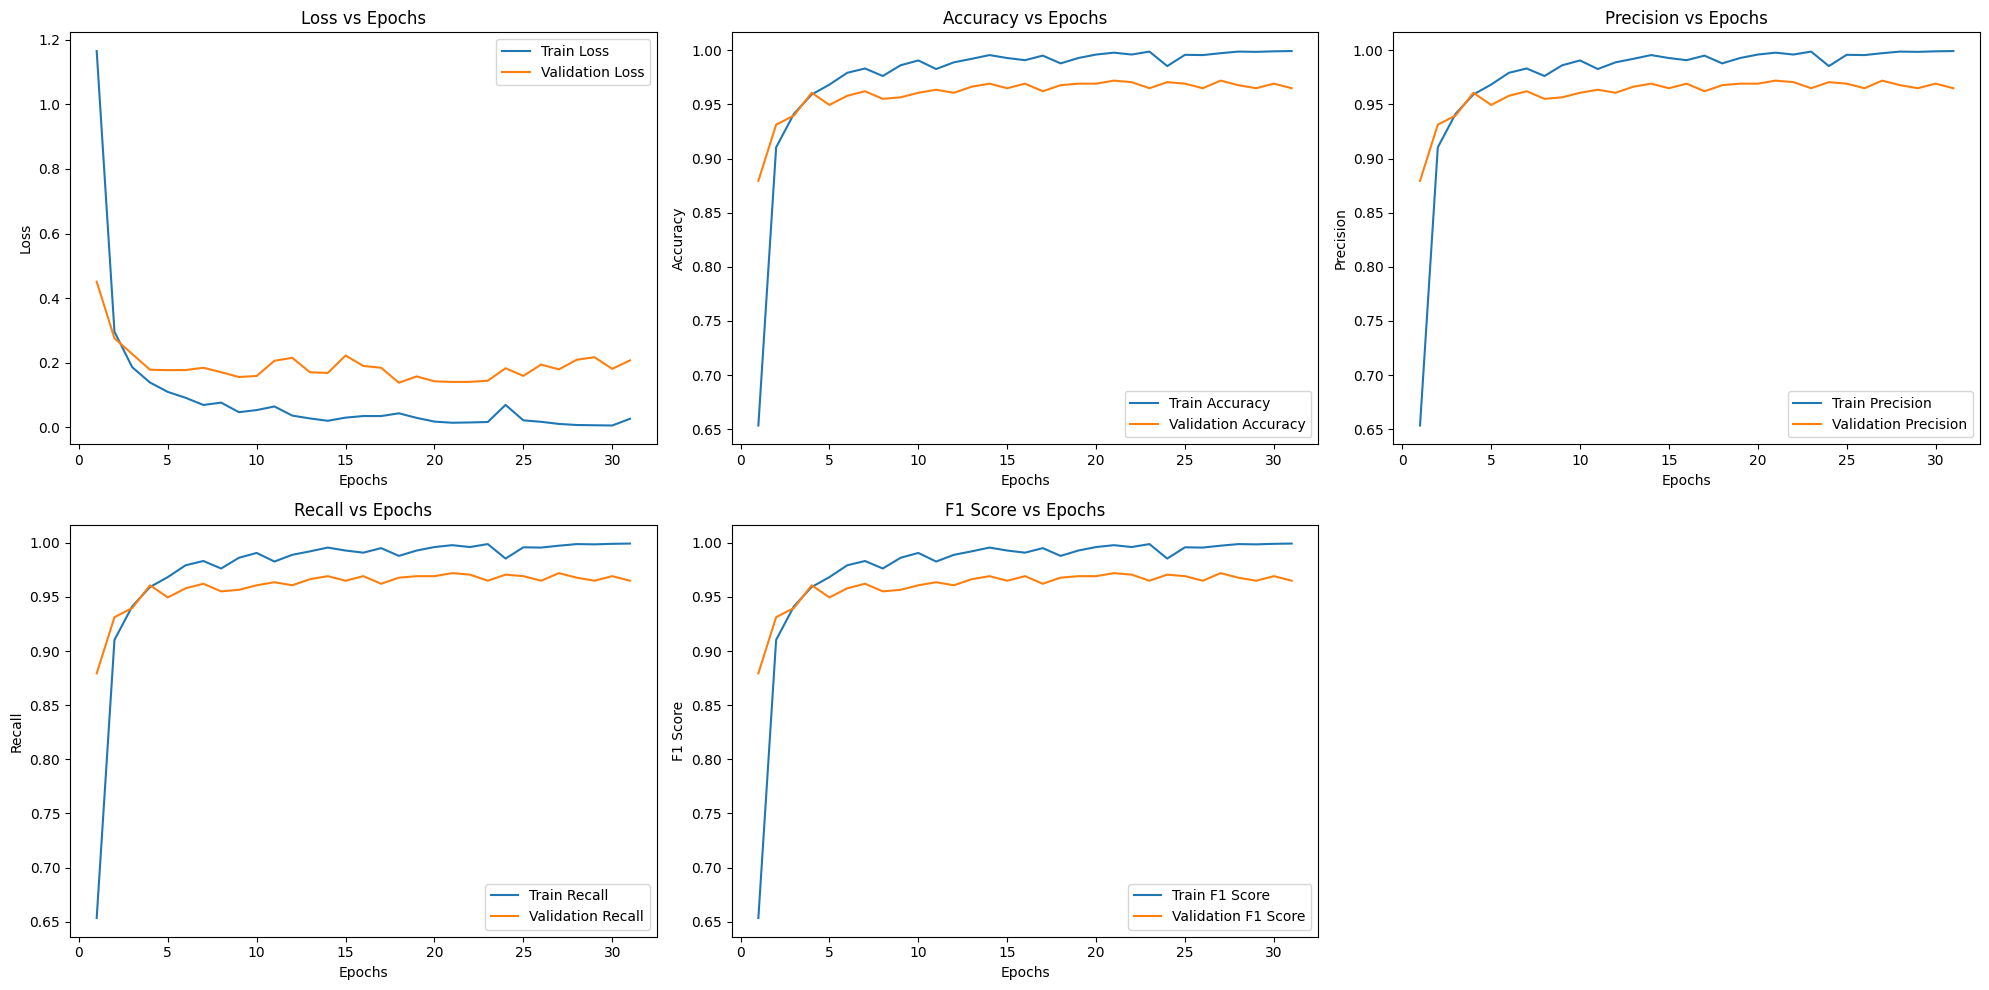

Training complete for mobilenet_v2
Creating submission file for mobilenet_v2


Test [TEST|mobilenet_v2]: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Test results saved to mobilenet_v2/mobilenet_v2_test_results.csv


100%|██████████| 49.7M/49.7M [00:00<00:00, 64.4MB/s]






Starting training for googlenet
Number of parameters: 5,612,204


Epoch 1/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s, accuracy=54.82%, loss=0.564]


Epoch [1/60], Train Loss: 1.5506, Train Accuracy: 0.5482, Train Precision: 0.5482, Train Recall: 0.5482, Train F1: 0.5482


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [1/60], Validation Loss: 0.7355, Validation Accuracy: 0.7938, Validation Precision: 0.7938, Validation Recall: 0.7938, Validation F1: 0.7938
Saving best model at epoch 1...


Epoch 2/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, accuracy=87.96%, loss=0.917]


Epoch [2/60], Train Loss: 0.4888, Train Accuracy: 0.8796, Train Precision: 0.8796, Train Recall: 0.8796, Train F1: 0.8796


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch [2/60], Validation Loss: 0.3192, Validation Accuracy: 0.9201, Validation Precision: 0.9201, Validation Recall: 0.9201, Validation F1: 0.9201
Saving best model at epoch 2...


Epoch 3/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, accuracy=93.11%, loss=0.647]


Epoch [3/60], Train Loss: 0.2650, Train Accuracy: 0.9311, Train Precision: 0.9311, Train Recall: 0.9311, Train F1: 0.9311


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


Epoch [3/60], Validation Loss: 0.2387, Validation Accuracy: 0.9383, Validation Precision: 0.9383, Validation Recall: 0.9383, Validation F1: 0.9383
Saving best model at epoch 3...


Epoch 4/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.48it/s, accuracy=94.55%, loss=0.81]


Epoch [4/60], Train Loss: 0.1989, Train Accuracy: 0.9455, Train Precision: 0.9455, Train Recall: 0.9455, Train F1: 0.9455


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [4/60], Validation Loss: 0.2087, Validation Accuracy: 0.9509, Validation Precision: 0.9509, Validation Recall: 0.9509, Validation F1: 0.9509
Saving best model at epoch 4...


Epoch 5/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.52it/s, accuracy=96.21%, loss=0.123]


Epoch [5/60], Train Loss: 0.1361, Train Accuracy: 0.9621, Train Precision: 0.9621, Train Recall: 0.9621, Train F1: 0.9621


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


Epoch [5/60], Validation Loss: 0.1789, Validation Accuracy: 0.9537, Validation Precision: 0.9537, Validation Recall: 0.9537, Validation F1: 0.9537
Saving best model at epoch 5...


Epoch 6/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s, accuracy=96.71%, loss=0.172]


Epoch [6/60], Train Loss: 0.1149, Train Accuracy: 0.9671, Train Precision: 0.9671, Train Recall: 0.9671, Train F1: 0.9671


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch [6/60], Validation Loss: 0.1755, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Saving best model at epoch 6...


Epoch 7/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:28<00:00,  2.22it/s, accuracy=97.82%, loss=0.693]


Epoch [7/60], Train Loss: 0.0931, Train Accuracy: 0.9782, Train Precision: 0.9782, Train Recall: 0.9782, Train F1: 0.9782


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch [7/60], Validation Loss: 0.1873, Validation Accuracy: 0.9439, Validation Precision: 0.9439, Validation Recall: 0.9439, Validation F1: 0.9439
Patience: 1/10


Epoch 8/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:24<00:00,  2.58it/s, accuracy=98.29%, loss=0.109]


Epoch [8/60], Train Loss: 0.0713, Train Accuracy: 0.9829, Train Precision: 0.9829, Train Recall: 0.9829, Train F1: 0.9829


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


Epoch [8/60], Validation Loss: 0.1749, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 2/10


Epoch 9/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.56it/s, accuracy=98.56%, loss=0.0372]


Epoch [9/60], Train Loss: 0.0536, Train Accuracy: 0.9856, Train Precision: 0.9856, Train Recall: 0.9856, Train F1: 0.9856


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch [9/60], Validation Loss: 0.1658, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 3/10


Epoch 10/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s, accuracy=98.56%, loss=0.439]


Epoch [10/60], Train Loss: 0.0607, Train Accuracy: 0.9856, Train Precision: 0.9856, Train Recall: 0.9856, Train F1: 0.9856


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]


Epoch [10/60], Validation Loss: 0.1676, Validation Accuracy: 0.9565, Validation Precision: 0.9565, Validation Recall: 0.9565, Validation F1: 0.9565
Patience: 4/10


Epoch 11/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.54it/s, accuracy=98.91%, loss=1.1]


Epoch [11/60], Train Loss: 0.0577, Train Accuracy: 0.9891, Train Precision: 0.9891, Train Recall: 0.9891, Train F1: 0.9891


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [11/60], Validation Loss: 0.1748, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Saving best model at epoch 11...


Epoch 12/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s, accuracy=99.23%, loss=0.323]


Epoch [12/60], Train Loss: 0.0424, Train Accuracy: 0.9923, Train Precision: 0.9923, Train Recall: 0.9923, Train F1: 0.9923


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]


Epoch [12/60], Validation Loss: 0.1748, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Saving best model at epoch 12...


Epoch 13/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=99.26%, loss=0.85]


Epoch [13/60], Train Loss: 0.0440, Train Accuracy: 0.9926, Train Precision: 0.9926, Train Recall: 0.9926, Train F1: 0.9926


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.87it/s]


Epoch [13/60], Validation Loss: 0.1872, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 1/10


Epoch 14/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:24<00:00,  2.58it/s, accuracy=99.08%, loss=1.47]


Epoch [14/60], Train Loss: 0.0603, Train Accuracy: 0.9908, Train Precision: 0.9908, Train Recall: 0.9908, Train F1: 0.9908


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]


Epoch [14/60], Validation Loss: 0.1730, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 2/10


Epoch 15/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.49it/s, accuracy=99.18%, loss=0.614]


Epoch [15/60], Train Loss: 0.0458, Train Accuracy: 0.9918, Train Precision: 0.9918, Train Recall: 0.9918, Train F1: 0.9918


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


Epoch [15/60], Validation Loss: 0.1694, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Saving best model at epoch 15...


Epoch 16/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s, accuracy=99.43%, loss=0.264]


Epoch [16/60], Train Loss: 0.0331, Train Accuracy: 0.9943, Train Precision: 0.9943, Train Recall: 0.9943, Train F1: 0.9943


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


Epoch [16/60], Validation Loss: 0.1951, Validation Accuracy: 0.9593, Validation Precision: 0.9593, Validation Recall: 0.9593, Validation F1: 0.9593
Patience: 1/10


Epoch 17/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:30<00:00,  2.07it/s, accuracy=99.50%, loss=0.0957]


Epoch [17/60], Train Loss: 0.0226, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1: 0.9950


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


Epoch [17/60], Validation Loss: 0.1844, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 2/10


Epoch 18/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s, accuracy=99.78%, loss=0.0794]


Epoch [18/60], Train Loss: 0.0175, Train Accuracy: 0.9978, Train Precision: 0.9978, Train Recall: 0.9978, Train F1: 0.9978


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [18/60], Validation Loss: 0.1774, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 3/10


Epoch 19/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.49it/s, accuracy=99.80%, loss=0.248]


Epoch [19/60], Train Loss: 0.0160, Train Accuracy: 0.9980, Train Precision: 0.9980, Train Recall: 0.9980, Train F1: 0.9980


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


Epoch [19/60], Validation Loss: 0.1903, Validation Accuracy: 0.9705, Validation Precision: 0.9705, Validation Recall: 0.9705, Validation F1: 0.9705
Saving best model at epoch 19...


Epoch 20/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s, accuracy=99.63%, loss=0.569]


Epoch [20/60], Train Loss: 0.0263, Train Accuracy: 0.9963, Train Precision: 0.9963, Train Recall: 0.9963, Train F1: 0.9963


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]


Epoch [20/60], Validation Loss: 0.1863, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 1/10


Epoch 21/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s, accuracy=99.70%, loss=0.0322]


Epoch [21/60], Train Loss: 0.0143, Train Accuracy: 0.9970, Train Precision: 0.9970, Train Recall: 0.9970, Train F1: 0.9970


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


Epoch [21/60], Validation Loss: 0.2105, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 2/10


Epoch 22/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s, accuracy=99.88%, loss=0.127]


Epoch [22/60], Train Loss: 0.0109, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s]


Epoch [22/60], Validation Loss: 0.1821, Validation Accuracy: 0.9748, Validation Precision: 0.9748, Validation Recall: 0.9748, Validation F1: 0.9748
Saving best model at epoch 22...


Epoch 23/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:24<00:00,  2.64it/s, accuracy=99.83%, loss=0.239]


Epoch [23/60], Train Loss: 0.0143, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


Epoch [23/60], Validation Loss: 0.1841, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 1/10


Epoch 24/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.53it/s, accuracy=99.75%, loss=0.563]


Epoch [24/60], Train Loss: 0.0196, Train Accuracy: 0.9975, Train Precision: 0.9975, Train Recall: 0.9975, Train F1: 0.9975


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [24/60], Validation Loss: 0.1726, Validation Accuracy: 0.9719, Validation Precision: 0.9719, Validation Recall: 0.9719, Validation F1: 0.9719
Patience: 2/10


Epoch 25/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:24<00:00,  2.57it/s, accuracy=99.88%, loss=0.0757]


Epoch [25/60], Train Loss: 0.0092, Train Accuracy: 0.9988, Train Precision: 0.9988, Train Recall: 0.9988, Train F1: 0.9988


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


Epoch [25/60], Validation Loss: 0.1973, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 3/10


Epoch 26/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:26<00:00,  2.41it/s, accuracy=99.83%, loss=0.557]


Epoch [26/60], Train Loss: 0.0164, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch [26/60], Validation Loss: 0.1801, Validation Accuracy: 0.9663, Validation Precision: 0.9663, Validation Recall: 0.9663, Validation F1: 0.9663
Patience: 4/10


Epoch 27/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, accuracy=99.46%, loss=0.0224]


Epoch [27/60], Train Loss: 0.0213, Train Accuracy: 0.9946, Train Precision: 0.9946, Train Recall: 0.9946, Train F1: 0.9946


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]


Epoch [27/60], Validation Loss: 0.1826, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 5/10


Epoch 28/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:24<00:00,  2.59it/s, accuracy=100.00%, loss=0.206]


Epoch [28/60], Train Loss: 0.0084, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


Epoch [28/60], Validation Loss: 0.2068, Validation Accuracy: 0.9677, Validation Precision: 0.9677, Validation Recall: 0.9677, Validation F1: 0.9677
Patience: 6/10


Epoch 29/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.51it/s, accuracy=99.83%, loss=0.516]


Epoch [29/60], Train Loss: 0.0152, Train Accuracy: 0.9983, Train Precision: 0.9983, Train Recall: 0.9983, Train F1: 0.9983


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


Epoch [29/60], Validation Loss: 0.1859, Validation Accuracy: 0.9734, Validation Precision: 0.9734, Validation Recall: 0.9734, Validation F1: 0.9734
Patience: 7/10


Epoch 30/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:25<00:00,  2.47it/s, accuracy=99.65%, loss=0.554]


Epoch [30/60], Train Loss: 0.0224, Train Accuracy: 0.9965, Train Precision: 0.9965, Train Recall: 0.9965, Train F1: 0.9965


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


Epoch [30/60], Validation Loss: 0.2019, Validation Accuracy: 0.9635, Validation Precision: 0.9635, Validation Recall: 0.9635, Validation F1: 0.9635
Patience: 8/10


Epoch 31/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:30<00:00,  2.12it/s, accuracy=99.93%, loss=0.335]


Epoch [31/60], Train Loss: 0.0120, Train Accuracy: 0.9993, Train Precision: 0.9993, Train Recall: 0.9993, Train F1: 0.9993


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch [31/60], Validation Loss: 0.2096, Validation Accuracy: 0.9621, Validation Precision: 0.9621, Validation Recall: 0.9621, Validation F1: 0.9621
Patience: 9/10


Epoch 32/60 [TRAIN|googlenet]: 100%|██████████| 64/64 [00:26<00:00,  2.42it/s, accuracy=99.70%, loss=0.0119]


Epoch [32/60], Train Loss: 0.0130, Train Accuracy: 0.9970, Train Precision: 0.9970, Train Recall: 0.9970, Train F1: 0.9970


Evaluation [VALID|googlenet]: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


Epoch [32/60], Validation Loss: 0.1801, Validation Accuracy: 0.9649, Validation Precision: 0.9649, Validation Recall: 0.9649, Validation F1: 0.9649
Patience: 10/10
Early stopping...
Saving Last Model
Metrics saved to googlenet/googlenet_training_metrics.csv


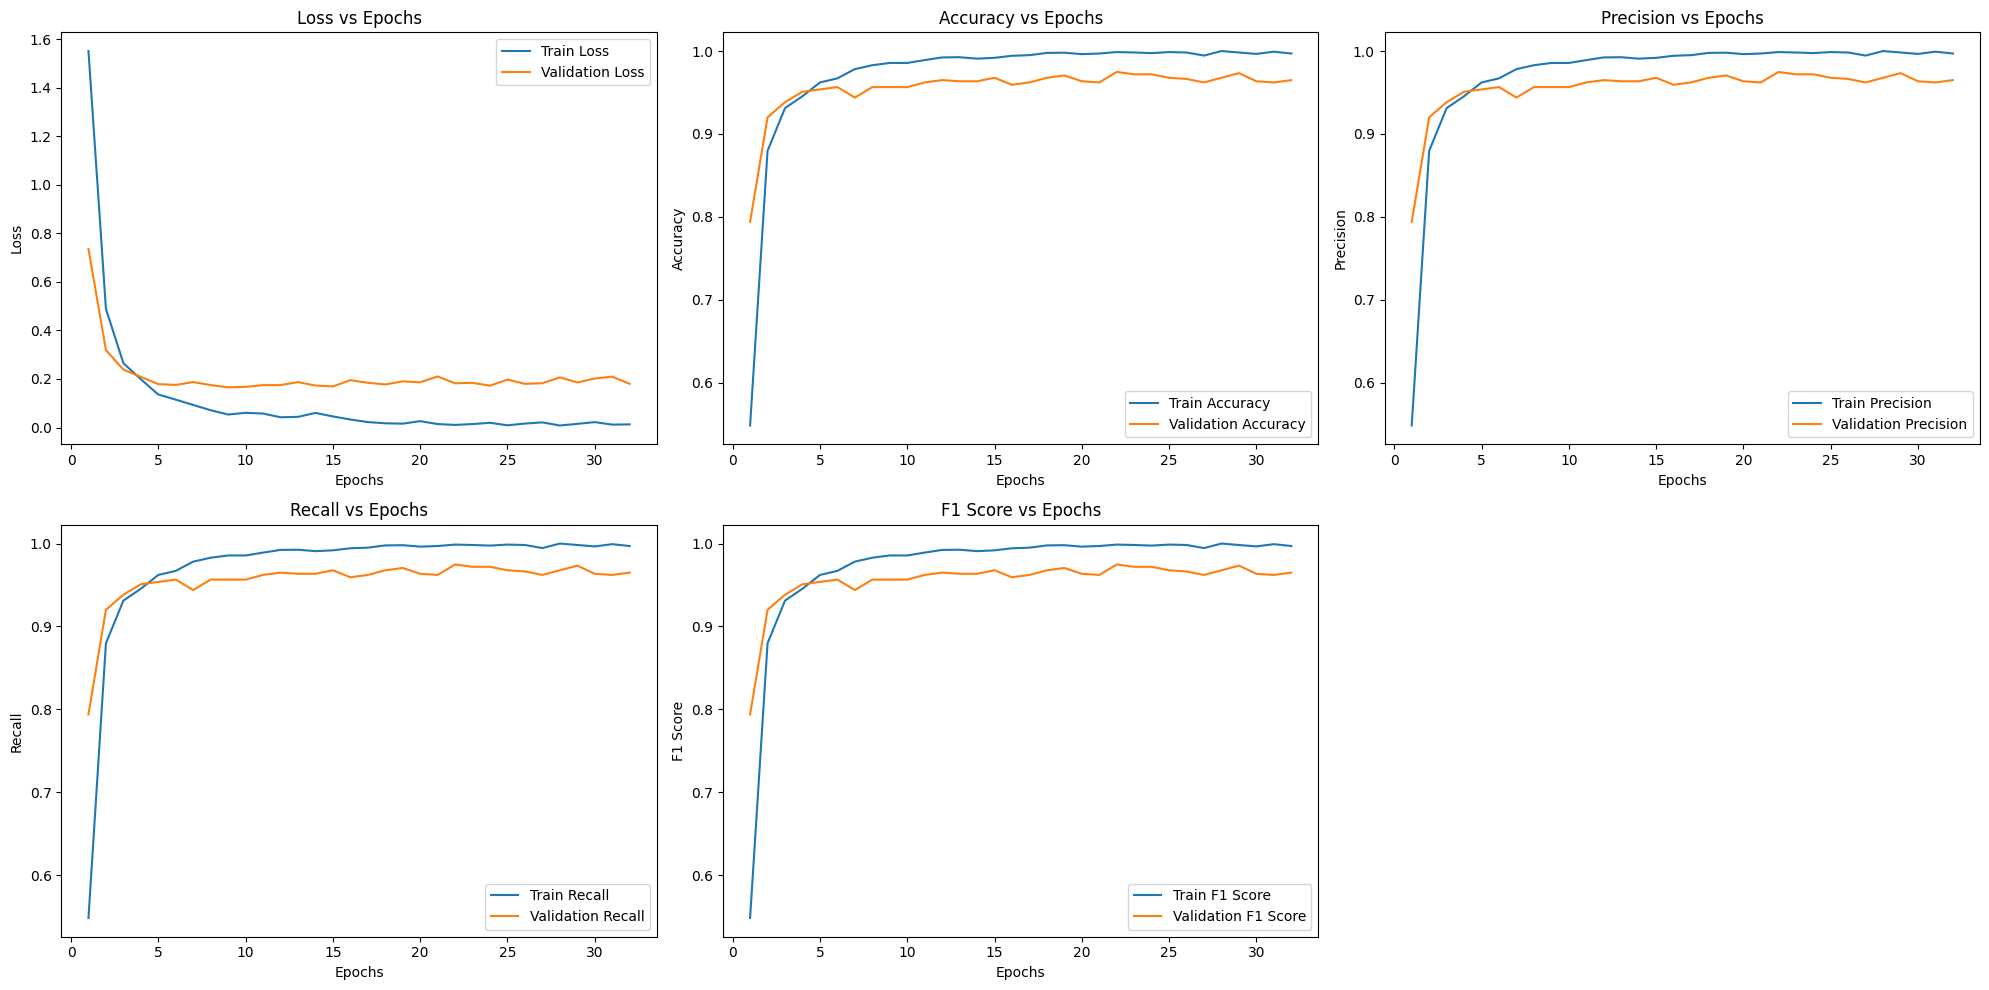

Training complete for googlenet
Creating submission file for googlenet


Test [TEST|googlenet]: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s]

Test results saved to googlenet/googlenet_test_results.csv


In [8]:
image_size = 256

for model_name in pretrained_models:
    if 'efficientnet' in model_name:
        model = create_efficientnet_model(model_name)
    elif 'resnet' in model_name:
        model = create_resnet_model(model_name)
    elif 'mobilenet' in model_name:
        model = create_mobile_net_model(model_name)
    elif 'googlenet' in model_name:
        model = create_googlenet_model(model_name)
    else:
        raise Exception('Unknown model name')
    
    model = model.to(device)

    train(
        path_to_train,
        model,
        model_name,
        lr0 = 0.0001,
        lrf = 0.00001,
        weight_decay = 0.00005,
        num_epochs = 60,
        patience = 10,
        batch_size = 64,
        image_size = image_size,
        val_size = 0.15,
        device = device,
    )

    temp_dataset = datasets.ImageFolder(path_to_train)
    class2id = temp_dataset.class_to_idx

    # load the best model
    model.load_state_dict(torch.load(f'{model_name}/{model_name}_best_model.pt'))

    test_submit(model, model_name, image_size, path_to_test, class2id, device)

    del model